# Dependency package import

In [1]:
import os
import math
import copy
from copy import copy
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP

import tensorflow as tf
from tensorflow.keras.models import Model

import molmap
from molmap import MolMap,loadmap
from molmap.model import RegressionEstimator,MultiClassEstimator,MultiLabelEstimator,save_model,load_model
from molmap.model.loss import cross_entropy

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Function define

In [2]:
def get_color_dict(mp):
    df = mp._S.df
    return df.set_index('Subtypes')['colors'].to_dict()


def show_fmap(mp, X, figsize=(6,6), fname = './1.pdf'):
    
    mp_colors = get_color_dict(mp)
    fig =  plt.figure(figsize=figsize)
    channels = [i for i in mp.extract.colormaps.keys() if i in mp._S.channels ]
             
    
    for i, j  in enumerate(channels):

        data = X[:,:,mp._S.channels.index(j)]
        color = mp_colors[j]
        if mp.ftype == 'fingerprint':
            cmap = sns.dark_palette(color, n_colors =  2, reverse=True)
        else:
            cmap = sns.light_palette(color, n_colors =  100, reverse=False)
        
        ax = sns.heatmap(np.where(data !=0, data, np.nan), 
                    cmap = cmap, 
                    yticklabels=False, xticklabels=False, cbar=False, 
                    linewidths=0.005, linecolor = '0.9')# cbar_kws = dict(use_gridspec=False,location="top")

    ax.axhline(y=0, color='grey',lw=2, ls =  '--')
    ax.axvline(x=data.shape[1], color='grey',lw=2, ls =  '--')
    ax.axhline(y=data.shape[0], color='grey',lw=2, ls =  '--')
    ax.axvline(x=0, color='grey',lw=2, ls =  '--')

    patches = [ plt.plot([],[], marker="s", ms=8, ls="", mec=None, color=j, 
                label=i)[0]  for i,j in mp.extract.colormaps.items() if i in channels]
    
    l = 1.32
    if mp.ftype == 'fingerprint':
        l += 0.05
    plt.legend(handles=patches, bbox_to_anchor=(l,1.01), 
               loc='upper right', ncol=1, facecolor="w", numpoints=1 )    
    
    #plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight', dpi = 400)

In [3]:
class data(object):

    def __init__(self, df, smiles_col, target_cols, task_name, task_type, description):
        assert type(target_cols) == list

        self.df = df
        self.x = df[smiles_col].values
        self.y = df[target_cols].values.astype(float)
        self.y_cols = target_cols
        self.task_name = task_name
        self.task_type = task_type
        self.description = description
        self.n_samples = len(df)

        print('total samples: %s' % self.n_samples)

    def clear(self):
        self.df = None
        self.x = None
        self.y = None

def load_data_clf():
    description = """The ESOL dataset includes 1128 compounds and their experimental water solubility """

    task_name = 'clf'
    task_type = 'classification'
    df = train_formed
    target_cols = ['Class']
    smiles_col = 'smiles'

    return data(df, smiles_col, target_cols, task_name, task_type, description)

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df))
    base_indices = shuffle(base_indices, random_state = random_state)
    nb_test = int(len(base_indices) * split_size[2])
    nb_val = int(len(base_indices) * split_size[1])
    test_idx = base_indices[0:nb_test]
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)]
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)]
    print(len(train_idx), len(valid_idx), len(test_idx))
    return train_idx, valid_idx, test_idx

class data_et(object):

    def __init__(self, df, smiles_col, target_cols, task_name, task_type, description):
        assert type(target_cols) == list

        self.df = df
        self.x = df[smiles_col].values
        self.y = df[target_cols].values.astype(float)
        self.y_cols = target_cols
        self.task_name = task_name
        self.task_type = task_type
        self.description = description
        self.n_samples = len(df)

        print('total samples: %s' % self.n_samples)

    def clear(self):
        self.df = None
        self.x = None
        self.y = None

def load_data_clf_et():
    description = """The ESOL dataset includes 1128 compounds and their experimental water solubility """

    task_name = 'clf'
    task_type = 'classification'
    df = et_formed
    target_cols = ['Class']
    smiles_col = 'smiles'

    return data_et(df, smiles_col, target_cols, task_name, task_type, description)

def Rdsplit_et(df):
#     base_indices = np.arange(len(df))
    et_idx = np.arange(len(df))

    print(len(et_idx))
    return et_idx

class data_dc(object):

    def __init__(self, df, smiles_col, task_name, task_type, description):
        

        self.df = df
        self.x = df[smiles_col].values
        self.task_name = task_name
        self.task_type = task_type
        self.description = description
        self.n_samples = len(df)

        print('total samples: %s' % self.n_samples)

    def clear(self):
        self.df = None
        self.x = None

def load_data_clf_dc():
    description = """The ESOL dataset includes 1128 compounds and their experimental water solubility """

    task_name = 'clf'
    task_type = 'classification'
    df = dc_formed
    smiles_col = 'smiles'

    return data_dc(df, smiles_col, task_name, task_type, description)

def Rdsplit_dc(df):
#     base_indices = np.arange(len(df))
    dc_idx = np.arange(len(df))

    print(len(dc_idx))
    return dc_idx


In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def roc_auc(y_true, y_score):
    return roc_auc_score(y_true, y_score)


def ForwardPropFeatureImp(model, X_true, Y_true, df_grid):
    '''
    Forward prop. Feature importance
    '''

    df_grid = df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    with tf.device('/CPU:0'):
        Y_prob = sigmoid(model.predict(X_true))
    loss = log_loss(Y_true, Y_prob)
    N, W, H, C = X_true.shape
    results = []
    for i in tqdm(range(len(df_grid)), ascii= True):
        ts = df_grid.iloc[i]
        y = ts.y
        x = ts.x
        X1 = copy(X_true)
        X1[:, y, x,:] = np.zeros(X1[:, y, x,:].shape)
        #Y1 = model.predict(X1)
        Y_pred_prob = sigmoid(model.predict(X1))
        mut_loss = log_loss(Y_true, Y_pred_prob)
        res =  mut_loss - loss # if res > 0, important, othervise, not important

        results.append(res)
        
    S = pd.Series(results, name = 'importance')
    df = df_grid.join(S)
    return df

# Feature calculation

In [50]:
bitsinfo = molmap.feature.fingerprint.Extraction().bitsinfo
flist = bitsinfo[bitsinfo.Subtypes.isin(['MACCSFP','PharmacoErGFP','PubChemFP'])].IDs.tolist()

mp1 = MolMap(ftype='descriptor',fmap_type = 'grid',metric='cosine')  #des1
mp2 = MolMap(ftype='fingerprint',fmap_type = 'grid',metric='cosine',flist = flist)  #fp1

mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15)
mp2.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15)

mp1.save('../dataset/des.mp')
mp2.save('../dataset/3fp.mp')

2025-03-26 15:50:47,246 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2025-03-26 15:50:49,939 - INFO - [bidd-molmap] - Finished
2025-03-26 15:50:53,073 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2025-03-26 15:50:55,607 - INFO - [bidd-molmap] - Finished


['../dataset/3fp.mp']

In [51]:
df_train = pd.read_csv('../dataset/smiles_880.csv')
train_smi = df_train['CanSMILES (RDKit Mol)']

In [52]:
X1 = mp1.batch_transform(train_smi)
X2 = mp2.batch_transform(train_smi)

np.save('../dataset/des_trainX.npy',X1)
np.save('../dataset/fp_trainX.npy',X2)

100%|################################################################################| 880/880 [00:45<00:00, 19.37it/s]


## MolMap visualization

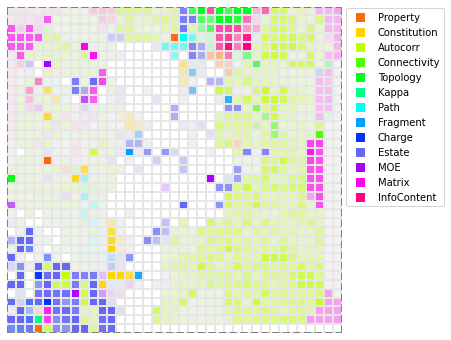

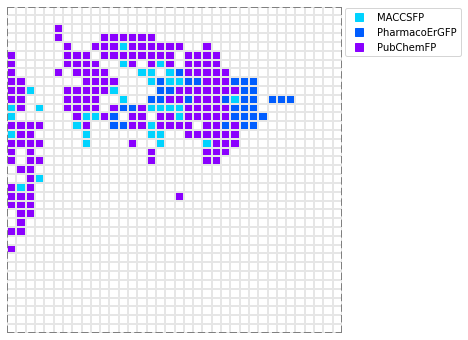

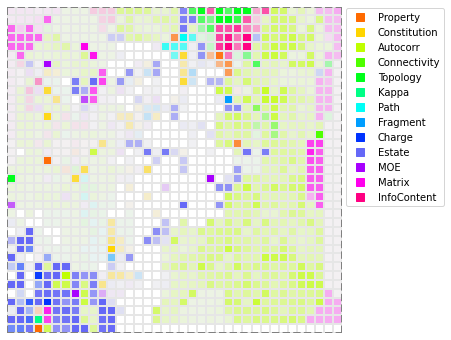

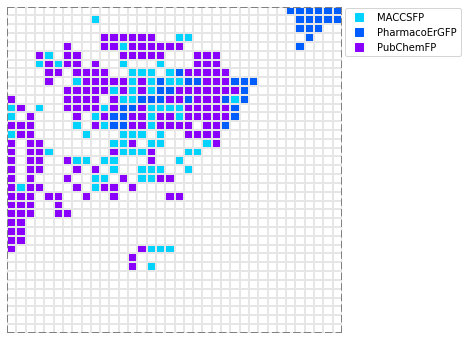

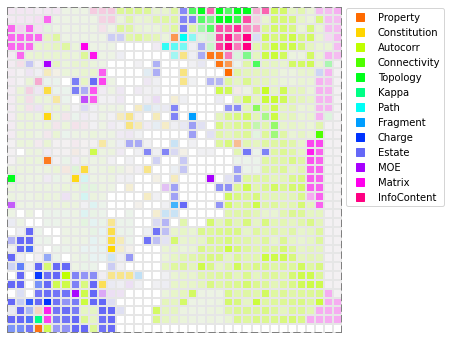

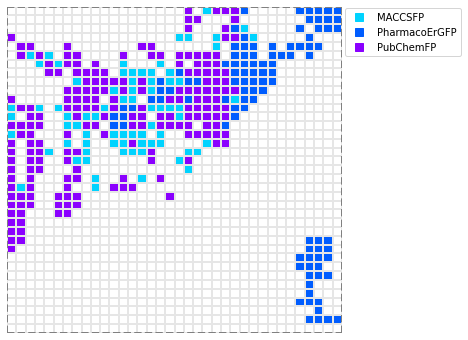

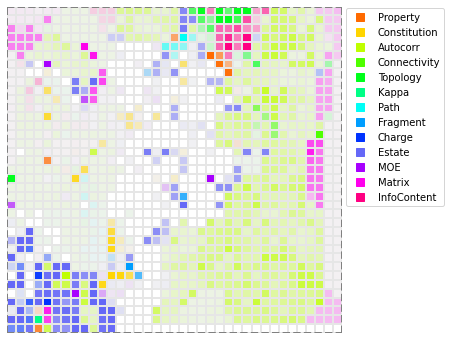

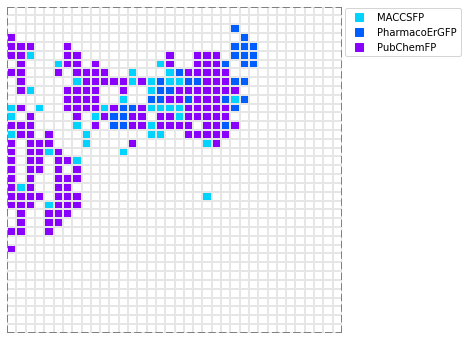

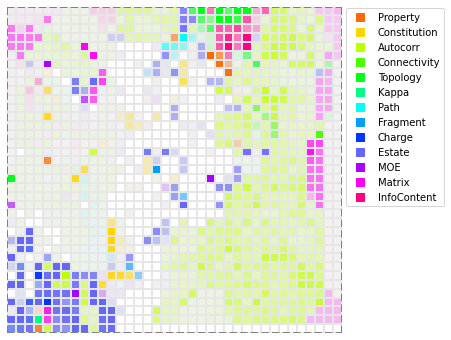

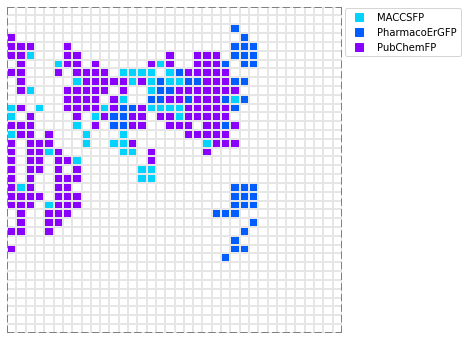

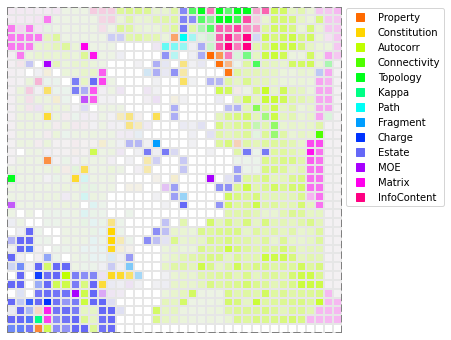

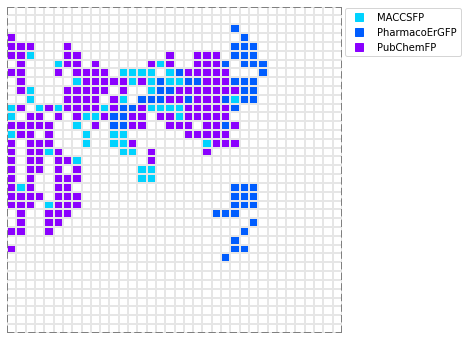

In [53]:
i = 0
for x1, x2, name in zip(X1, X2, df_train.index.tolist()):
    i+=1
    show_fmap(mp1, x1, fname='../dataset/images/%s_x1.jpg' % name) 
    show_fmap(mp2, x2, fname='../dataset/images/%s_x2.jpg' % name)
    if i >5:
        break

# Build dual-channel molmapnet

In [6]:
le = LabelEncoder()   # TICT:1 PICT:0
mp1 = loadmap('../dataset/des.mp')
mp2 = loadmap('../dataset/3fp.mp')

In [7]:
train_X1 = np.load('../dataset/des_trainX.npy')  # des
train_X2 = np.load('../dataset/fp_trainX.npy')  # des

In [8]:
df_train = pd.read_csv('../dataset/smiles_880.csv')
train_smi = df_train['CanSMILES (RDKit Mol)']
train_y = df_train['Label']
train_y_ = le.fit_transform(train_y)
train_formed = pd.DataFrame({'smiles': train_smi, 'Class': train_y_})

In [9]:
data = load_data_clf()
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 888)

total samples: 880
704 88 88


In [10]:
Y = pd.get_dummies(data.df['Class']).values

In [11]:
trainX = (train_X1[train_idx], train_X2[train_idx])
validX = (train_X1[valid_idx], train_X2[valid_idx])
testX = (train_X1[test_idx], train_X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

In [12]:
clf = MultiClassEstimator(n_outputs=trainY.shape[1],
                          fmap_shape1 = train_X1.shape[1:],
                          fmap_shape2 = train_X2.shape[1:],
                          conv1_kernel_size=13,
                          dense_layers=[128, 64],
                          dense_avf='tanh',
                          batch_size=64,
                          lr=0.0001,
                          loss='categorical_crossentropy',
                          monitor='val_loss',
                          random_state=32,
                          metric='ROC',
                          epochs=100,
                          verbose=2,patience=20,
                          gpuid = 0)

MultiClassEstimator(batch_size=64, dense_avf='tanh', epochs=100,
                    fmap_shape1=(37, 37, 13), fmap_shape2=(37, 36, 3),
                    gpuid='0', n_outputs=2, patience=20)


In [13]:
clf.fit(trainX, trainY, validX, validY )

BestEpoch = clf._performance.best_epoch
BestLoss = clf._performance.best
print('Best epochs: %.2f, Best loss: %.2f' % (BestEpoch, BestLoss))

3/3 [==============================] - 0s 19ms/step
epoch: 0001, loss: 0.7141 - val_loss: 0.6991; auc: 0.7526 - val_auc: 0.7303                                                                                                    
3/3 [==============================] - 0s 19ms/step
epoch: 0002, loss: 0.6898 - val_loss: 0.6660; auc: 0.7636 - val_auc: 0.7345                                                                                                    
3/3 [==============================] - 0s 20ms/step
epoch: 0003, loss: 0.6532 - val_loss: 0.6399; auc: 0.7834 - val_auc: 0.7541                                                                                                    
3/3 [==============================] - 0s 19ms/step
epoch: 0004, loss: 0.6368 - val_loss: 0.6314; auc: 0.7878 - val_auc: 0.7546                                                                                                    
3/3 [==============================] - 0s 20ms/step
epoch: 0005, loss: 0.6192 - val_loss

3/3 [==============================] - 0s 20ms/step
epoch: 0030, loss: 0.2197 - val_loss: 0.5058; auc: 0.9976 - val_auc: 0.8241                                                                                                    
3/3 [==============================] - 0s 21ms/step
epoch: 0031, loss: 0.2145 - val_loss: 0.5443; auc: 0.9982 - val_auc: 0.8156                                                                                                    
3/3 [==============================] - 0s 20ms/step
epoch: 0032, loss: 0.2112 - val_loss: 0.5068; auc: 0.9987 - val_auc: 0.8161                                                                                                    
3/3 [==============================] - 0s 20ms/step
epoch: 0033, loss: 0.2104 - val_loss: 0.5253; auc: 0.9990 - val_auc: 0.8214                                                                                                    
3/3 [==============================] - 0s 20ms/step
epoch: 0034, loss: 0.1808 - val_loss

<AxesSubplot:>

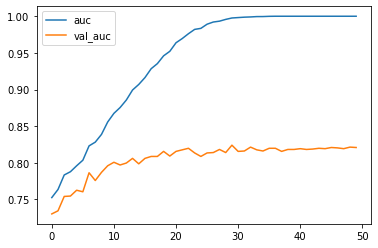

In [14]:
pd.DataFrame(clf.history)[['auc', 'val_auc']].plot()

<AxesSubplot:>

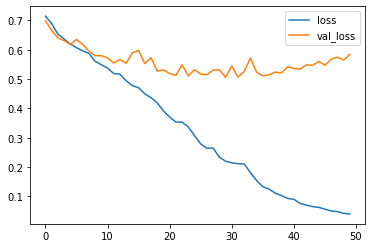

In [15]:
pd.DataFrame(clf.history)[['loss', 'val_loss']].plot()

In [16]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T
train_pred = clf.predict(trainX)
valid_pred = clf.predict(validX)
test_pred = clf.predict(testX)

train_proba = clf.predict_proba(trainX)
valid_proba = clf.predict_proba(validX)
test_proba = clf.predict_proba(testX)

train_acc = accuracy_score(trainY[:, 1],train_pred[:, 1])
valid_acc = accuracy_score(validY[:, 1],valid_pred[:, 1])
test_acc = accuracy_score(testY[:, 1],test_pred[:, 1])

train_auc = roc_auc_score(trainY[:, 1],train_proba[:, 1])
valid_auc = roc_auc_score(validY[:, 1],valid_proba[:, 1])
test_auc = roc_auc_score(testY[:, 1],test_proba[:, 1])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

3/3 [==============================] - 0s 19ms/step


,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
29,0.219742,0.505773,0.997617,0.824059,29.0,0.997617,0.965909,0.824059,0.761364,0.756334,0.681818


In [17]:
result_data = pd.DataFrame([trainY[:, 1],train_proba[:, 1],train_pred[:, 1]
                           ,validY[:, 1],valid_proba[:, 1],valid_pred[:, 1]
                           ,testY[:, 1],test_proba[:, 1],test_pred[:, 1]]).T
result_data.columns=['train_truth', 'train_prob','train_pred','valid_truth', 'valid_prob','valid_pred'
                    ,'test_truth', 'test_prob','test_pred']
result_data = result_data.fillna(999)
result_data['train_truth']=result_data['train_truth'].astype(int)
result_data['train_pred']=result_data['train_pred'].astype(int)
result_data['valid_truth']=result_data['valid_truth'].astype(int)
result_data['valid_pred']=result_data['valid_pred'].astype(int)
result_data['test_truth']=result_data['test_truth'].astype(int)
result_data['test_pred']=result_data['test_pred'].astype(int)

result_data.to_csv('../dataset/dual_prediction.csv')

## Reported model and results

In [18]:
clf  = load_model('../dataset/dual.h5')

In [19]:
result = pd.read_csv('../dataset/dual_prediction.csv',index_col=0)

<AxesSubplot:>

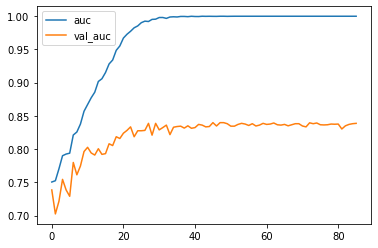

In [20]:
pd.DataFrame(clf.history)[['auc', 'val_auc']].plot()
# plt.savefig('M4_auc.jpg',dpi=600,bbox_inches='tight')

<AxesSubplot:>

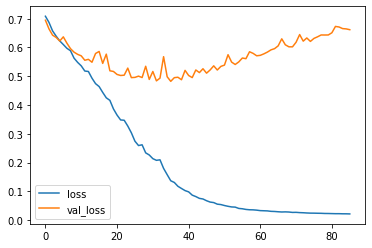

In [21]:
pd.DataFrame(clf.history)[['loss', 'val_loss']].plot()
# plt.savefig('M4_loss.jpg',dpi=600,bbox_inches='tight')

In [22]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T

train_acc = accuracy_score(result['train_truth'],result['train_pred'])
valid_acc = accuracy_score(result['valid_truth'][:88],result['valid_pred'][:88])
test_acc = accuracy_score(result['test_truth'][:88],result['test_pred'][:88])

train_auc = roc_auc_score(result['train_truth'],result['train_prob'])
valid_auc = roc_auc_score(result['valid_truth'][:88],result['valid_prob'][:88])
test_auc = roc_auc_score(result['test_truth'][:88],result['test_prob'][:88])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
29,0.226152,0.488972,0.995293,0.838633,29.0,0.99861,0.984375,0.833863,0.806818,0.777898,0.715909


# Build mono-channel molmapnet

In [5]:
le = LabelEncoder()   # TICT:1 PICT:0
mp1 = loadmap('../dataset/des.mp')
mp2 = loadmap('../dataset/3fp.mp')

In [6]:
train_X1 = np.load('../dataset/des_trainX.npy')  # des
train_X2 = np.load('../dataset/fp_trainX.npy')  # des

In [7]:
df_train = pd.read_csv('../dataset/smiles_880.csv')
train_smi = df_train['CanSMILES (RDKit Mol)']
train_y = df_train['Label']
train_y_ = le.fit_transform(train_y)
train_formed = pd.DataFrame({'smiles': train_smi, 'Class': train_y_})

In [8]:
data = load_data_clf()
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 999)

total samples: 880
704 88 88


In [9]:
Y = pd.get_dummies(data.df['Class']).values

## Descriptors

In [10]:
trainX = (train_X1[train_idx])
validX = (train_X1[valid_idx])
testX = (train_X1[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

In [11]:
clf = MultiClassEstimator(n_outputs=trainY.shape[1],
                          fmap_shape1 = train_X1.shape[1:],
#                           fmap_shape2 = train_X2.shape[1:],
                          conv1_kernel_size=13,
                          dense_layers=[128, 64],
                          dense_avf='tanh',
                          batch_size=64,
                          lr=0.0001,
                          loss='categorical_crossentropy',
                          monitor='val_loss',
                          random_state=32,
                          metric='ROC',
                          epochs=100,
                          verbose=2,patience=20,
                          gpuid = 0)

MultiClassEstimator(batch_size=64, dense_avf='tanh', epochs=100,
                    fmap_shape1=(37, 37, 13), gpuid='0', n_outputs=2,
                    patience=20)


In [12]:
clf.fit(trainX, trainY, validX, validY )

BestEpoch = clf._performance.best_epoch
BestLoss = clf._performance.best
print('Best epochs: %.2f, Best loss: %.2f' % (BestEpoch, BestLoss))

3/3 [==============================] - 0s 11ms/step
epoch: 0001, loss: 0.6790 - val_loss: 0.6861; auc: 0.6843 - val_auc: 0.6517                                                                                                    
3/3 [==============================] - 0s 9ms/step
epoch: 0002, loss: 0.6718 - val_loss: 0.6905; auc: 0.6969 - val_auc: 0.6724                                                                                                    
3/3 [==============================] - 0s 9ms/step
epoch: 0003, loss: 0.6590 - val_loss: 0.6764; auc: 0.6961 - val_auc: 0.6672                                                                                                    
3/3 [==============================] - 0s 9ms/step
epoch: 0004, loss: 0.6538 - val_loss: 0.6643; auc: 0.7022 - val_auc: 0.6786                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0005, loss: 0.6475 - val_loss: 0

3/3 [==============================] - 0s 10ms/step
epoch: 0030, loss: 0.5926 - val_loss: 0.6430; auc: 0.7727 - val_auc: 0.7117                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0031, loss: 0.5722 - val_loss: 0.6229; auc: 0.7778 - val_auc: 0.7096                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0032, loss: 0.5701 - val_loss: 0.6359; auc: 0.7798 - val_auc: 0.7065                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0033, loss: 0.5827 - val_loss: 0.6609; auc: 0.7829 - val_auc: 0.7055                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0034, loss: 0.5617 - val_loss

3/3 [==============================] - 0s 12ms/step
epoch: 0059, loss: 0.5268 - val_loss: 0.5907; auc: 0.8437 - val_auc: 0.7438                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0060, loss: 0.4978 - val_loss: 0.5861; auc: 0.8479 - val_auc: 0.7443                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0061, loss: 0.4974 - val_loss: 0.5823; auc: 0.8506 - val_auc: 0.7490                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0062, loss: 0.4900 - val_loss: 0.5829; auc: 0.8522 - val_auc: 0.7495                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0063, loss: 0.5370 - val_loss

3/3 [==============================] - 0s 10ms/step
epoch: 0088, loss: 0.4284 - val_loss: 0.6019; auc: 0.9071 - val_auc: 0.7676                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0089, loss: 0.4212 - val_loss: 0.5709; auc: 0.9088 - val_auc: 0.7681                                                                                                    
3/3 [==============================] - 0s 11ms/step
epoch: 0090, loss: 0.4071 - val_loss: 0.5854; auc: 0.9097 - val_auc: 0.7723                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0091, loss: 0.4514 - val_loss: 0.6059; auc: 0.9135 - val_auc: 0.7635                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0092, loss: 0.4237 - val_loss

In [13]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T
train_pred = clf.predict(trainX)
valid_pred = clf.predict(validX)
test_pred = clf.predict(testX)

train_proba = clf.predict_proba(trainX)
valid_proba = clf.predict_proba(validX)
test_proba = clf.predict_proba(testX)

train_acc = accuracy_score(trainY[:, 1],train_pred[:, 1])
valid_acc = accuracy_score(validY[:, 1],valid_pred[:, 1])
test_acc = accuracy_score(testY[:, 1],test_pred[:, 1])

train_auc = roc_auc_score(trainY[:, 1],train_proba[:, 1])
valid_auc = roc_auc_score(validY[:, 1],valid_proba[:, 1])
test_auc = roc_auc_score(testY[:, 1],test_proba[:, 1])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

3/3 [==============================] - 0s 10ms/step


,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
97,0.402163,0.563601,0.926891,0.771739,97.0,0.926891,0.846591,0.771739,0.693182,0.803922,0.738636


In [14]:
result_data = pd.DataFrame([trainY[:, 1],train_proba[:, 1],train_pred[:, 1]
                           ,validY[:, 1],valid_proba[:, 1],valid_pred[:, 1]
                           ,testY[:, 1],test_proba[:, 1],test_pred[:, 1]]).T
result_data.columns=['train_truth', 'train_prob','train_pred','valid_truth', 'valid_prob','valid_pred'
                    ,'test_truth', 'test_prob','test_pred']
result_data = result_data.fillna(999)
result_data['train_truth']=result_data['train_truth'].astype(int)
result_data['train_pred']=result_data['train_pred'].astype(int)
result_data['valid_truth']=result_data['valid_truth'].astype(int)
result_data['valid_pred']=result_data['valid_pred'].astype(int)
result_data['test_truth']=result_data['test_truth'].astype(int)
result_data['test_pred']=result_data['test_pred'].astype(int)

# result_data.to_csv('../dataset/des_prediction.csv')

### Reported model and results

In [15]:
clf  = load_model('../dataset/des.h5')

In [16]:
result = pd.read_csv('../dataset/des_prediction.csv',index_col=0)

In [17]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T

train_acc = accuracy_score(result['train_truth'],result['train_pred'])
valid_acc = accuracy_score(result['valid_truth'][:88],result['valid_pred'][:88])
test_acc = accuracy_score(result['test_truth'][:88],result['test_pred'][:88])

train_auc = roc_auc_score(result['train_truth'],result['train_prob'])
valid_auc = roc_auc_score(result['valid_truth'][:88],result['valid_prob'][:88])
test_auc = roc_auc_score(result['test_truth'][:88],result['test_prob'][:88])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
97,0.381636,0.56112,0.933908,0.77795,97.0,0.933908,0.853693,0.77795,0.727273,0.804466,0.761364


### Feature importance calculation

In [18]:
n, w, h, c = trainX.shape
mp1.plot_grid()
df_grid = mp1.df_grid

2025-03-26 17:18:36,283 - INFO - [bidd-molmap] - generate file: ./descriptor_1344_cosine_umap_molmap
2025-03-26 17:18:36,314 - INFO - [bidd-molmap] - save html file to ./descriptor_1344_cosine_umap_molmap


In [19]:
model = clf._model
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = opt, loss = cross_entropy)

In [20]:
with tf.device('/cpu:0'):
    train_imp = ForwardPropFeatureImp(model, trainX, trainY,  df_grid)
    test_imp = ForwardPropFeatureImp(model, testX, testY,  df_grid)

22/22 [==============================] - 2s 62ms/step


  0%|                                                                                         | 0/1369 [00:00<?, ?it/s]

22/22 [==============================] - 1s 61ms/step


  0%|                                                                                 | 1/1369 [00:01<33:46,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


  0%|1                                                                                | 2/1369 [00:03<34:15,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


  0%|1                                                                                | 3/1369 [00:04<34:13,  1.50s/it]

22/22 [==============================] - 1s 62ms/step


  0%|2                                                                                | 4/1369 [00:06<34:25,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


  0%|2                                                                                | 5/1369 [00:07<34:31,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  0%|3                                                                                | 6/1369 [00:09<34:48,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  1%|4                                                                                | 7/1369 [00:10<34:39,  1.53s/it]

22/22 [==============================] - 1s 60ms/step


  1%|4                                                                                | 8/1369 [00:12<34:23,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


  1%|5                                                                                | 9/1369 [00:13<34:10,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


  1%|5                                                                               | 10/1369 [00:15<33:53,  1.50s/it]

22/22 [==============================] - 1s 62ms/step


  1%|6                                                                               | 11/1369 [00:16<34:00,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


  1%|7                                                                               | 12/1369 [00:18<34:17,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


  1%|7                                                                               | 13/1369 [00:19<34:08,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


  1%|8                                                                               | 14/1369 [00:21<34:07,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


  1%|8                                                                               | 15/1369 [00:22<34:08,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


  1%|9                                                                               | 16/1369 [00:24<34:26,  1.53s/it]

22/22 [==============================] - 1s 65ms/step


  1%|9                                                                               | 17/1369 [00:25<34:50,  1.55s/it]

22/22 [==============================] - 1s 61ms/step


  1%|#                                                                               | 18/1369 [00:27<34:47,  1.54s/it]

22/22 [==============================] - 1s 60ms/step


  1%|#1                                                                              | 19/1369 [00:28<34:21,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  1%|#1                                                                              | 20/1369 [00:30<34:12,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


  2%|#2                                                                              | 21/1369 [00:31<33:56,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


  2%|#2                                                                              | 22/1369 [00:33<33:50,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


  2%|#3                                                                              | 23/1369 [00:34<33:39,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


  2%|#4                                                                              | 24/1369 [00:36<33:41,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


  2%|#4                                                                              | 25/1369 [00:37<33:17,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


  2%|#5                                                                              | 26/1369 [00:39<33:07,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


  2%|#5                                                                              | 27/1369 [00:40<33:05,  1.48s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#6                                                                              | 28/1369 [00:42<33:26,  1.50s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#6                                                                              | 29/1369 [00:43<33:37,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#7                                                                              | 30/1369 [00:45<33:56,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#8                                                                              | 31/1369 [00:46<33:53,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#8                                                                              | 32/1369 [00:48<33:52,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  2%|#9                                                                              | 33/1369 [00:49<33:54,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


  2%|#9                                                                              | 34/1369 [00:51<34:03,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  3%|##                                                                              | 35/1369 [00:53<34:05,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##1                                                                             | 36/1369 [00:54<34:12,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##1                                                                             | 37/1369 [00:56<34:01,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##2                                                                             | 38/1369 [00:57<33:56,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##2                                                                             | 39/1369 [00:59<33:54,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##3                                                                             | 40/1369 [01:00<33:56,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  3%|##3                                                                             | 41/1369 [01:02<34:09,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  3%|##4                                                                             | 42/1369 [01:03<34:13,  1.55s/it]

22/22 [==============================] - 1s 61ms/step


  3%|##5                                                                             | 43/1369 [01:05<33:51,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##5                                                                             | 44/1369 [01:06<33:49,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  3%|##6                                                                             | 45/1369 [01:08<33:51,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##6                                                                             | 46/1369 [01:09<33:52,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  3%|##7                                                                             | 47/1369 [01:11<33:48,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  4%|##8                                                                             | 48/1369 [01:12<33:45,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  4%|##8                                                                             | 49/1369 [01:14<33:33,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  4%|##9                                                                             | 50/1369 [01:16<33:39,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  4%|##9                                                                             | 51/1369 [01:17<33:32,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  4%|###                                                                             | 52/1369 [01:19<33:33,  1.53s/it]

22/22 [==============================] - 1s 64ms/step


  4%|###                                                                             | 53/1369 [01:20<33:45,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  4%|###1                                                                            | 54/1369 [01:22<33:51,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  4%|###2                                                                            | 55/1369 [01:23<33:38,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  4%|###2                                                                            | 56/1369 [01:25<33:24,  1.53s/it]

22/22 [==============================] - 1s 64ms/step


  4%|###3                                                                            | 57/1369 [01:26<33:36,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  4%|###3                                                                            | 58/1369 [01:28<33:37,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


  4%|###4                                                                            | 59/1369 [01:29<33:41,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  4%|###5                                                                            | 60/1369 [01:31<33:36,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  4%|###5                                                                            | 61/1369 [01:32<33:33,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  5%|###6                                                                            | 62/1369 [01:34<33:22,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  5%|###6                                                                            | 63/1369 [01:36<33:30,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  5%|###7                                                                            | 64/1369 [01:37<33:28,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  5%|###7                                                                            | 65/1369 [01:39<33:29,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  5%|###8                                                                            | 66/1369 [01:40<33:27,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  5%|###9                                                                            | 67/1369 [01:42<33:11,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  5%|###9                                                                            | 68/1369 [01:43<33:04,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


  5%|####                                                                            | 69/1369 [01:45<33:13,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  5%|####                                                                            | 70/1369 [01:46<33:11,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  5%|####1                                                                           | 71/1369 [01:48<33:16,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  5%|####2                                                                           | 72/1369 [01:49<33:29,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  5%|####2                                                                           | 73/1369 [01:51<33:16,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  5%|####3                                                                           | 74/1369 [01:52<33:14,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  5%|####3                                                                           | 75/1369 [01:54<33:14,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  6%|####4                                                                           | 76/1369 [01:55<33:09,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  6%|####4                                                                           | 77/1369 [01:57<33:07,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


  6%|####5                                                                           | 78/1369 [01:59<33:03,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  6%|####6                                                                           | 79/1369 [02:00<32:46,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


  6%|####6                                                                           | 80/1369 [02:02<32:32,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


  6%|####7                                                                           | 81/1369 [02:03<32:40,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  6%|####7                                                                           | 82/1369 [02:05<32:41,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


  6%|####8                                                                           | 83/1369 [02:06<32:47,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  6%|####9                                                                           | 84/1369 [02:08<32:58,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  6%|####9                                                                           | 85/1369 [02:09<32:37,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


  6%|#####                                                                           | 86/1369 [02:11<32:32,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


  6%|#####                                                                           | 87/1369 [02:12<32:37,  1.53s/it]

22/22 [==============================] - 1s 65ms/step


  6%|#####1                                                                          | 88/1369 [02:14<32:53,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####2                                                                          | 89/1369 [02:15<32:58,  1.55s/it]

22/22 [==============================] - 1s 61ms/step


  7%|#####2                                                                          | 90/1369 [02:17<32:52,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


  7%|#####3                                                                          | 91/1369 [02:18<32:30,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  7%|#####3                                                                          | 92/1369 [02:20<32:33,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  7%|#####4                                                                          | 93/1369 [02:22<32:34,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  7%|#####4                                                                          | 94/1369 [02:23<32:36,  1.53s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####5                                                                          | 95/1369 [02:25<32:42,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


  7%|#####6                                                                          | 96/1369 [02:26<32:49,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  7%|#####6                                                                          | 97/1369 [02:28<32:36,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####7                                                                          | 98/1369 [02:29<32:46,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####7                                                                          | 99/1369 [02:31<32:51,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####7                                                                         | 100/1369 [02:32<32:50,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


  7%|#####8                                                                         | 101/1369 [02:34<32:50,  1.55s/it]

22/22 [==============================] - 1s 61ms/step


  7%|#####8                                                                         | 102/1369 [02:35<32:49,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  8%|#####9                                                                         | 103/1369 [02:37<32:42,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######                                                                         | 104/1369 [02:39<32:34,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######                                                                         | 105/1369 [02:40<32:25,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


  8%|######1                                                                        | 106/1369 [02:42<32:35,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


  8%|######1                                                                        | 107/1369 [02:43<32:34,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######2                                                                        | 108/1369 [02:45<32:33,  1.55s/it]

22/22 [==============================] - 1s 60ms/step


  8%|######2                                                                        | 109/1369 [02:46<32:04,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######3                                                                        | 110/1369 [02:48<32:03,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######4                                                                        | 111/1369 [02:49<31:56,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  8%|######4                                                                        | 112/1369 [02:51<32:00,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


  8%|######5                                                                        | 113/1369 [02:52<32:05,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


  8%|######5                                                                        | 114/1369 [02:54<32:01,  1.53s/it]

22/22 [==============================] - 1s 60ms/step


  8%|######6                                                                        | 115/1369 [02:55<31:41,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


  8%|######6                                                                        | 116/1369 [02:57<31:38,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  9%|######7                                                                        | 117/1369 [02:58<31:40,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


  9%|######8                                                                        | 118/1369 [03:00<31:44,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


  9%|######8                                                                        | 119/1369 [03:01<31:38,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


  9%|######9                                                                        | 120/1369 [03:03<31:32,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


  9%|######9                                                                        | 121/1369 [03:04<31:16,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


  9%|#######                                                                        | 122/1369 [03:06<31:19,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


  9%|#######                                                                        | 123/1369 [03:07<31:16,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


  9%|#######1                                                                       | 124/1369 [03:09<31:11,  1.50s/it]

22/22 [==============================] - 1s 62ms/step


  9%|#######2                                                                       | 125/1369 [03:10<31:16,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


  9%|#######2                                                                       | 126/1369 [03:12<31:22,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


  9%|#######3                                                                       | 127/1369 [03:14<31:23,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


  9%|#######3                                                                       | 128/1369 [03:15<31:20,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


  9%|#######4                                                                       | 129/1369 [03:17<31:16,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


  9%|#######5                                                                       | 130/1369 [03:18<31:23,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 10%|#######5                                                                       | 131/1369 [03:20<31:18,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 10%|#######6                                                                       | 132/1369 [03:21<31:24,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 10%|#######6                                                                       | 133/1369 [03:23<31:15,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 10%|#######7                                                                       | 134/1369 [03:24<31:15,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 10%|#######7                                                                       | 135/1369 [03:26<31:14,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 10%|#######8                                                                       | 136/1369 [03:27<31:21,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 10%|#######9                                                                       | 137/1369 [03:29<31:28,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 10%|#######9                                                                       | 138/1369 [03:30<31:21,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 10%|########                                                                       | 139/1369 [03:32<31:06,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 10%|########                                                                       | 140/1369 [03:33<31:00,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 10%|########1                                                                      | 141/1369 [03:35<31:10,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 10%|########1                                                                      | 142/1369 [03:36<31:11,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 10%|########2                                                                      | 143/1369 [03:38<31:14,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 11%|########3                                                                      | 144/1369 [03:39<31:12,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 11%|########3                                                                      | 145/1369 [03:41<30:57,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 11%|########4                                                                      | 146/1369 [03:42<31:08,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 11%|########4                                                                      | 147/1369 [03:44<31:17,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 11%|########5                                                                      | 148/1369 [03:46<31:25,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 11%|########5                                                                      | 149/1369 [03:47<31:27,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 11%|########6                                                                      | 150/1369 [03:49<31:27,  1.55s/it]

22/22 [==============================] - 1s 61ms/step


 11%|########7                                                                      | 151/1369 [03:50<31:13,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 11%|########7                                                                      | 152/1369 [03:52<31:07,  1.53s/it]

22/22 [==============================] - 1s 64ms/step


 11%|########8                                                                      | 153/1369 [03:53<31:17,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 11%|########8                                                                      | 154/1369 [03:55<31:19,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 11%|########9                                                                      | 155/1369 [03:56<31:15,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 11%|#########                                                                      | 156/1369 [03:58<31:10,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


 11%|#########                                                                      | 157/1369 [03:59<30:54,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 12%|#########1                                                                     | 158/1369 [04:01<30:58,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########1                                                                     | 159/1369 [04:02<30:57,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 12%|#########2                                                                     | 160/1369 [04:04<31:00,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 12%|#########2                                                                     | 161/1369 [04:06<31:07,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########3                                                                     | 162/1369 [04:07<31:08,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########4                                                                     | 163/1369 [04:09<30:55,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########4                                                                     | 164/1369 [04:10<30:52,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 12%|#########5                                                                     | 165/1369 [04:12<30:48,  1.53s/it]

22/22 [==============================] - 1s 64ms/step


 12%|#########5                                                                     | 166/1369 [04:13<30:58,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 12%|#########6                                                                     | 167/1369 [04:15<30:58,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########6                                                                     | 168/1369 [04:16<30:54,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


 12%|#########7                                                                     | 169/1369 [04:18<30:42,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 12%|#########8                                                                     | 170/1369 [04:19<30:47,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 12%|#########8                                                                     | 171/1369 [04:21<30:43,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 13%|#########9                                                                     | 172/1369 [04:23<30:39,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 13%|#########9                                                                     | 173/1369 [04:24<30:32,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########                                                                     | 174/1369 [04:26<30:28,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########                                                                     | 175/1369 [04:27<30:16,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########1                                                                    | 176/1369 [04:29<30:11,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 13%|##########2                                                                    | 177/1369 [04:30<30:16,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 13%|##########2                                                                    | 178/1369 [04:32<30:25,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########3                                                                    | 179/1369 [04:33<30:12,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########3                                                                    | 180/1369 [04:35<30:14,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########4                                                                    | 181/1369 [04:36<30:03,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 13%|##########5                                                                    | 182/1369 [04:38<30:05,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


 13%|##########5                                                                    | 183/1369 [04:39<29:52,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 13%|##########6                                                                    | 184/1369 [04:41<29:50,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 14%|##########6                                                                    | 185/1369 [04:42<29:48,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 14%|##########7                                                                    | 186/1369 [04:44<29:46,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 14%|##########7                                                                    | 187/1369 [04:45<29:32,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 14%|##########8                                                                    | 188/1369 [04:47<29:24,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 14%|##########9                                                                    | 189/1369 [04:48<29:18,  1.49s/it]

22/22 [==============================] - 1s 62ms/step


 14%|##########9                                                                    | 190/1369 [04:50<29:29,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 14%|###########                                                                    | 191/1369 [04:51<29:26,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 14%|###########                                                                    | 192/1369 [04:53<29:35,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 14%|###########1                                                                   | 193/1369 [04:54<29:24,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 14%|###########1                                                                   | 194/1369 [04:56<29:28,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 14%|###########2                                                                   | 195/1369 [04:57<29:28,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 14%|###########3                                                                   | 196/1369 [04:59<29:33,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 14%|###########3                                                                   | 197/1369 [05:00<29:33,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 14%|###########4                                                                   | 198/1369 [05:02<29:28,  1.51s/it]

22/22 [==============================] - 1s 59ms/step


 15%|###########4                                                                   | 199/1369 [05:03<29:09,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 15%|###########5                                                                   | 200/1369 [05:05<29:12,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 15%|###########5                                                                   | 201/1369 [05:06<29:11,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 15%|###########6                                                                   | 202/1369 [05:08<29:10,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 15%|###########7                                                                   | 203/1369 [05:09<29:07,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 15%|###########7                                                                   | 204/1369 [05:11<29:04,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 15%|###########8                                                                   | 205/1369 [05:12<28:58,  1.49s/it]

22/22 [==============================] - 1s 62ms/step


 15%|###########8                                                                   | 206/1369 [05:14<29:06,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 15%|###########9                                                                   | 207/1369 [05:15<29:09,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 15%|############                                                                   | 208/1369 [05:17<29:14,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 15%|############                                                                   | 209/1369 [05:18<29:23,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 15%|############1                                                                  | 210/1369 [05:20<29:32,  1.53s/it]

22/22 [==============================] - 1s 60ms/step


 15%|############1                                                                  | 211/1369 [05:21<29:15,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 15%|############2                                                                  | 212/1369 [05:23<29:21,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 16%|############2                                                                  | 213/1369 [05:24<29:28,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 16%|############3                                                                  | 214/1369 [05:26<29:24,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 16%|############4                                                                  | 215/1369 [05:28<29:23,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 16%|############4                                                                  | 216/1369 [05:29<29:30,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


 16%|############5                                                                  | 217/1369 [05:31<29:14,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 16%|############5                                                                  | 218/1369 [05:32<29:06,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 16%|############6                                                                  | 219/1369 [05:34<29:08,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 16%|############6                                                                  | 220/1369 [05:35<29:07,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 16%|############7                                                                  | 221/1369 [05:37<29:14,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 16%|############8                                                                  | 222/1369 [05:38<29:08,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


 16%|############8                                                                  | 223/1369 [05:40<28:51,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 16%|############9                                                                  | 224/1369 [05:41<28:47,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 16%|############9                                                                  | 225/1369 [05:43<28:51,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 17%|#############                                                                  | 226/1369 [05:44<28:56,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############                                                                  | 227/1369 [05:46<28:52,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############1                                                                 | 228/1369 [05:47<28:53,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############2                                                                 | 229/1369 [05:49<28:40,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############2                                                                 | 230/1369 [05:50<28:36,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############3                                                                 | 231/1369 [05:52<28:37,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 17%|#############3                                                                 | 232/1369 [05:53<28:35,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############4                                                                 | 233/1369 [05:55<28:35,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############5                                                                 | 234/1369 [05:56<28:45,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


 17%|#############5                                                                 | 235/1369 [05:58<28:30,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 17%|#############6                                                                 | 236/1369 [05:59<28:27,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 17%|#############6                                                                 | 237/1369 [06:01<28:28,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 17%|#############7                                                                 | 238/1369 [06:02<28:32,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 17%|#############7                                                                 | 239/1369 [06:04<28:30,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 18%|#############8                                                                 | 240/1369 [06:05<28:40,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 18%|#############9                                                                 | 241/1369 [06:07<28:35,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


 18%|#############9                                                                 | 242/1369 [06:08<28:20,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 18%|##############                                                                 | 243/1369 [06:10<28:25,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 18%|##############                                                                 | 244/1369 [06:11<28:31,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 18%|##############1                                                                | 245/1369 [06:13<28:34,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 18%|##############1                                                                | 246/1369 [06:15<28:35,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 18%|##############2                                                                | 247/1369 [06:16<28:22,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 18%|##############3                                                                | 248/1369 [06:18<28:26,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 18%|##############3                                                                | 249/1369 [06:19<28:26,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 18%|##############4                                                                | 250/1369 [06:21<28:18,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 18%|##############4                                                                | 251/1369 [06:22<28:15,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 18%|##############5                                                                | 252/1369 [06:24<28:13,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 18%|##############5                                                                | 253/1369 [06:25<28:04,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 19%|##############6                                                                | 254/1369 [06:27<28:05,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 19%|##############7                                                                | 255/1369 [06:28<28:11,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 19%|##############7                                                                | 256/1369 [06:30<28:15,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 19%|##############8                                                                | 257/1369 [06:31<28:18,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 19%|##############8                                                                | 258/1369 [06:33<28:19,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 19%|##############9                                                                | 259/1369 [06:34<28:05,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 19%|###############                                                                | 260/1369 [06:36<28:05,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 19%|###############                                                                | 261/1369 [06:37<28:00,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 19%|###############1                                                               | 262/1369 [06:39<27:56,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 19%|###############1                                                               | 263/1369 [06:40<27:56,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 19%|###############2                                                               | 264/1369 [06:42<28:04,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 19%|###############2                                                               | 265/1369 [06:43<27:57,  1.52s/it]

22/22 [==============================] - 1s 60ms/step


 19%|###############3                                                               | 266/1369 [06:45<27:44,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 20%|###############4                                                               | 267/1369 [06:46<27:36,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 20%|###############4                                                               | 268/1369 [06:48<27:27,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 20%|###############5                                                               | 269/1369 [06:49<27:24,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 20%|###############5                                                               | 270/1369 [06:51<27:16,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 20%|###############6                                                               | 271/1369 [06:52<27:01,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 20%|###############6                                                               | 272/1369 [06:54<26:57,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 20%|###############7                                                               | 273/1369 [06:55<26:52,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 20%|###############8                                                               | 274/1369 [06:57<26:59,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 20%|###############8                                                               | 275/1369 [06:58<26:55,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 20%|###############9                                                               | 276/1369 [07:00<26:59,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 20%|###############9                                                               | 277/1369 [07:01<26:43,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 20%|################                                                               | 278/1369 [07:03<26:46,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 20%|################1                                                              | 279/1369 [07:04<26:43,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 20%|################1                                                              | 280/1369 [07:05<26:38,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 21%|################2                                                              | 281/1369 [07:07<26:39,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 21%|################2                                                              | 282/1369 [07:08<26:43,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 21%|################3                                                              | 283/1369 [07:10<26:36,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################3                                                              | 284/1369 [07:11<26:38,  1.47s/it]

22/22 [==============================] - 1s 61ms/step


 21%|################4                                                              | 285/1369 [07:13<26:45,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################5                                                              | 286/1369 [07:14<26:41,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################5                                                              | 287/1369 [07:16<26:43,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 21%|################6                                                              | 288/1369 [07:17<26:42,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 21%|################6                                                              | 289/1369 [07:19<26:27,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################7                                                              | 290/1369 [07:20<26:30,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################7                                                              | 291/1369 [07:22<26:34,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################8                                                              | 292/1369 [07:23<26:33,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 21%|################9                                                              | 293/1369 [07:25<26:30,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 21%|################9                                                              | 294/1369 [07:26<26:30,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################                                                              | 295/1369 [07:28<26:27,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################                                                              | 296/1369 [07:29<26:25,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################1                                                             | 297/1369 [07:31<26:26,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 22%|#################1                                                             | 298/1369 [07:32<26:29,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################2                                                             | 299/1369 [07:34<26:27,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################3                                                             | 300/1369 [07:35<26:40,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################3                                                             | 301/1369 [07:37<26:30,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 22%|#################4                                                             | 302/1369 [07:38<26:23,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################4                                                             | 303/1369 [07:40<26:18,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################5                                                             | 304/1369 [07:41<26:17,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 22%|#################6                                                             | 305/1369 [07:43<26:19,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################6                                                             | 306/1369 [07:44<26:26,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################7                                                             | 307/1369 [07:46<26:24,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 22%|#################7                                                             | 308/1369 [07:47<26:25,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 23%|#################8                                                             | 309/1369 [07:49<26:22,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 23%|#################8                                                             | 310/1369 [07:50<26:26,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 23%|#################9                                                             | 311/1369 [07:52<26:24,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 23%|##################                                                             | 312/1369 [07:53<26:30,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 23%|##################                                                             | 313/1369 [07:55<26:19,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 23%|##################1                                                            | 314/1369 [07:56<26:20,  1.50s/it]

22/22 [==============================] - 1s 62ms/step


 23%|##################1                                                            | 315/1369 [07:58<26:29,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 23%|##################2                                                            | 316/1369 [07:59<26:41,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 23%|##################2                                                            | 317/1369 [08:01<26:40,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 23%|##################3                                                            | 318/1369 [08:02<26:45,  1.53s/it]

22/22 [==============================] - 1s 61ms/step


 23%|##################4                                                            | 319/1369 [08:04<26:32,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 23%|##################4                                                            | 320/1369 [08:05<26:33,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 23%|##################5                                                            | 321/1369 [08:07<26:29,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 24%|##################5                                                            | 322/1369 [08:08<26:30,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 24%|##################6                                                            | 323/1369 [08:10<26:27,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 24%|##################6                                                            | 324/1369 [08:11<26:30,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 24%|##################7                                                            | 325/1369 [08:13<26:28,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 24%|##################8                                                            | 326/1369 [08:14<26:32,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 24%|##################8                                                            | 327/1369 [08:16<26:33,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 24%|##################9                                                            | 328/1369 [08:17<26:37,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 24%|##################9                                                            | 329/1369 [08:19<26:38,  1.54s/it]

22/22 [==============================] - 1s 60ms/step


 24%|###################                                                            | 330/1369 [08:20<26:27,  1.53s/it]

22/22 [==============================] - 1s 60ms/step


 24%|###################1                                                           | 331/1369 [08:22<26:07,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 24%|###################1                                                           | 332/1369 [08:23<26:07,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 24%|###################2                                                           | 333/1369 [08:25<26:06,  1.51s/it]

22/22 [==============================] - 1s 63ms/step


 24%|###################2                                                           | 334/1369 [08:26<26:13,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 24%|###################3                                                           | 335/1369 [08:28<26:11,  1.52s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################3                                                           | 336/1369 [08:30<26:03,  1.51s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################4                                                           | 337/1369 [08:31<25:55,  1.51s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################5                                                           | 338/1369 [08:32<25:42,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 25%|###################5                                                           | 339/1369 [08:34<25:40,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 25%|###################6                                                           | 340/1369 [08:35<25:37,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 25%|###################6                                                           | 341/1369 [08:37<25:39,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################7                                                           | 342/1369 [08:38<25:34,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################7                                                           | 343/1369 [08:40<25:20,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 25%|###################8                                                           | 344/1369 [08:41<25:20,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 25%|###################9                                                           | 345/1369 [08:43<25:14,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 25%|###################9                                                           | 346/1369 [08:44<25:09,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 25%|####################                                                           | 347/1369 [08:46<25:18,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 25%|####################                                                           | 348/1369 [08:47<25:23,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 25%|####################1                                                          | 349/1369 [08:49<25:14,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################1                                                          | 350/1369 [08:50<25:12,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################2                                                          | 351/1369 [08:52<25:12,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 26%|####################3                                                          | 352/1369 [08:53<25:13,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################3                                                          | 353/1369 [08:55<25:13,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 26%|####################4                                                          | 354/1369 [08:56<25:15,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 26%|####################4                                                          | 355/1369 [08:58<25:01,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 26%|####################5                                                          | 356/1369 [08:59<25:13,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################6                                                          | 357/1369 [09:01<25:12,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 26%|####################6                                                          | 358/1369 [09:02<25:13,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 26%|####################7                                                          | 359/1369 [09:04<25:15,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################7                                                          | 360/1369 [09:05<25:15,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################8                                                          | 361/1369 [09:07<25:07,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 26%|####################8                                                          | 362/1369 [09:08<25:03,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 27%|####################9                                                          | 363/1369 [09:10<25:03,  1.49s/it]

22/22 [==============================] - 1s 62ms/step


 27%|#####################                                                          | 364/1369 [09:11<25:11,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################                                                          | 365/1369 [09:13<25:04,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################1                                                         | 366/1369 [09:14<25:11,  1.51s/it]

22/22 [==============================] - 1s 59ms/step


 27%|#####################1                                                         | 367/1369 [09:16<24:54,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 27%|#####################2                                                         | 368/1369 [09:17<24:42,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################2                                                         | 369/1369 [09:19<24:40,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################3                                                         | 370/1369 [09:20<24:41,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################4                                                         | 371/1369 [09:22<24:36,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 27%|#####################4                                                         | 372/1369 [09:23<24:37,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################5                                                         | 373/1369 [09:25<24:43,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################5                                                         | 374/1369 [09:26<24:40,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 27%|#####################6                                                         | 375/1369 [09:28<24:43,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 27%|#####################6                                                         | 376/1369 [09:29<24:41,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 28%|#####################7                                                         | 377/1369 [09:31<24:40,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 28%|#####################8                                                         | 378/1369 [09:32<24:44,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 28%|#####################8                                                         | 379/1369 [09:34<24:33,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 28%|#####################9                                                         | 380/1369 [09:35<24:31,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 28%|#####################9                                                         | 381/1369 [09:37<24:35,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 28%|######################                                                         | 382/1369 [09:38<24:31,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 28%|######################1                                                        | 383/1369 [09:40<24:29,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 28%|######################1                                                        | 384/1369 [09:41<24:34,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 28%|######################2                                                        | 385/1369 [09:43<24:29,  1.49s/it]

22/22 [==============================] - 1s 62ms/step


 28%|######################2                                                        | 386/1369 [09:44<24:38,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 28%|######################3                                                        | 387/1369 [09:46<24:38,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 28%|######################3                                                        | 388/1369 [09:47<24:31,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 28%|######################4                                                        | 389/1369 [09:49<24:29,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


 28%|######################5                                                        | 390/1369 [09:50<24:26,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


 29%|######################5                                                        | 391/1369 [09:51<24:12,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 29%|######################6                                                        | 392/1369 [09:53<24:12,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 29%|######################6                                                        | 393/1369 [09:54<24:11,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 29%|######################7                                                        | 394/1369 [09:56<24:17,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 29%|######################7                                                        | 395/1369 [09:57<24:17,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 29%|######################8                                                        | 396/1369 [09:59<24:21,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 29%|######################9                                                        | 397/1369 [10:00<24:14,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 29%|######################9                                                        | 398/1369 [10:02<24:13,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 29%|#######################                                                        | 399/1369 [10:03<24:13,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 29%|#######################                                                        | 400/1369 [10:05<24:07,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 29%|#######################1                                                       | 401/1369 [10:06<24:10,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 29%|#######################1                                                       | 402/1369 [10:08<24:12,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


 29%|#######################2                                                       | 403/1369 [10:09<23:59,  1.49s/it]

22/22 [==============================] - 1s 58ms/step


 30%|#######################3                                                       | 404/1369 [10:11<23:47,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 30%|#######################3                                                       | 405/1369 [10:12<23:50,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 30%|#######################4                                                       | 406/1369 [10:14<23:49,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 30%|#######################4                                                       | 407/1369 [10:15<23:51,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 30%|#######################5                                                       | 408/1369 [10:17<23:53,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 30%|#######################6                                                       | 409/1369 [10:18<23:38,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 30%|#######################6                                                       | 410/1369 [10:20<23:40,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 30%|#######################7                                                       | 411/1369 [10:21<23:26,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 30%|#######################7                                                       | 412/1369 [10:23<23:31,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 30%|#######################8                                                       | 413/1369 [10:24<23:25,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 30%|#######################8                                                       | 414/1369 [10:26<23:29,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 30%|#######################9                                                       | 415/1369 [10:27<23:18,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 30%|########################                                                       | 416/1369 [10:29<23:11,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 30%|########################                                                       | 417/1369 [10:30<23:14,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################1                                                      | 418/1369 [10:32<23:19,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################1                                                      | 419/1369 [10:33<23:18,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################2                                                      | 420/1369 [10:34<23:19,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################2                                                      | 421/1369 [10:36<23:08,  1.46s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################3                                                      | 422/1369 [10:37<23:21,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################4                                                      | 423/1369 [10:39<23:19,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 31%|########################4                                                      | 424/1369 [10:40<23:22,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################5                                                      | 425/1369 [10:42<23:19,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################5                                                      | 426/1369 [10:43<23:23,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################6                                                      | 427/1369 [10:45<23:15,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################6                                                      | 428/1369 [10:46<23:16,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################7                                                      | 429/1369 [10:48<23:10,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 31%|########################8                                                      | 430/1369 [10:49<23:11,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 31%|########################8                                                      | 431/1369 [10:51<23:06,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 32%|########################9                                                      | 432/1369 [10:52<23:08,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 32%|########################9                                                      | 433/1369 [10:54<22:55,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 32%|#########################                                                      | 434/1369 [10:55<22:41,  1.46s/it]

22/22 [==============================] - 1s 60ms/step


 32%|#########################1                                                     | 435/1369 [10:57<22:44,  1.46s/it]

22/22 [==============================] - 1s 60ms/step


 32%|#########################1                                                     | 436/1369 [10:58<22:47,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 32%|#########################2                                                     | 437/1369 [11:00<22:46,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 32%|#########################2                                                     | 438/1369 [11:01<22:53,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 32%|#########################3                                                     | 439/1369 [11:03<22:42,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 32%|#########################3                                                     | 440/1369 [11:04<22:42,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 32%|#########################4                                                     | 441/1369 [11:05<22:43,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 32%|#########################5                                                     | 442/1369 [11:07<22:45,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 32%|#########################5                                                     | 443/1369 [11:08<22:45,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 32%|#########################6                                                     | 444/1369 [11:10<22:51,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 33%|#########################6                                                     | 445/1369 [11:11<22:44,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 33%|#########################7                                                     | 446/1369 [11:13<22:38,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 33%|#########################7                                                     | 447/1369 [11:14<22:34,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 33%|#########################8                                                     | 448/1369 [11:16<22:38,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 33%|#########################9                                                     | 449/1369 [11:17<22:39,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 33%|#########################9                                                     | 450/1369 [11:19<22:43,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 33%|##########################                                                     | 451/1369 [11:20<22:36,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 33%|##########################                                                     | 452/1369 [11:22<22:42,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 33%|##########################1                                                    | 453/1369 [11:23<22:39,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 33%|##########################1                                                    | 454/1369 [11:25<22:36,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 33%|##########################2                                                    | 455/1369 [11:26<22:39,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 33%|##########################3                                                    | 456/1369 [11:28<22:38,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 33%|##########################3                                                    | 457/1369 [11:29<22:31,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 33%|##########################4                                                    | 458/1369 [11:31<22:30,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 34%|##########################4                                                    | 459/1369 [11:32<22:26,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################5                                                    | 460/1369 [11:34<22:26,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 34%|##########################6                                                    | 461/1369 [11:35<22:28,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################6                                                    | 462/1369 [11:37<22:29,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################7                                                    | 463/1369 [11:38<22:24,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################7                                                    | 464/1369 [11:40<22:23,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 34%|##########################8                                                    | 465/1369 [11:41<22:12,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################8                                                    | 466/1369 [11:42<22:13,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 34%|##########################9                                                    | 467/1369 [11:44<22:11,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 34%|###########################                                                    | 468/1369 [11:45<22:16,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 34%|###########################                                                    | 469/1369 [11:47<22:08,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 34%|###########################1                                                   | 470/1369 [11:48<22:00,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 34%|###########################1                                                   | 471/1369 [11:50<22:03,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 34%|###########################2                                                   | 472/1369 [11:51<22:02,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 35%|###########################2                                                   | 473/1369 [11:53<21:59,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################3                                                   | 474/1369 [11:54<22:07,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################4                                                   | 475/1369 [11:56<21:56,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################4                                                   | 476/1369 [11:57<21:52,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 35%|###########################5                                                   | 477/1369 [11:59<21:55,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 35%|###########################5                                                   | 478/1369 [12:00<21:56,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 35%|###########################6                                                   | 479/1369 [12:02<21:57,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################6                                                   | 480/1369 [12:03<21:57,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################7                                                   | 481/1369 [12:05<21:50,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 35%|###########################8                                                   | 482/1369 [12:06<21:45,  1.47s/it]

22/22 [==============================] - 1s 61ms/step


 35%|###########################8                                                   | 483/1369 [12:08<21:52,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 35%|###########################9                                                   | 484/1369 [12:09<21:50,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 35%|###########################9                                                   | 485/1369 [12:11<21:52,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 36%|############################                                                   | 486/1369 [12:12<21:44,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 36%|############################1                                                  | 487/1369 [12:13<21:39,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################1                                                  | 488/1369 [12:15<21:41,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################2                                                  | 489/1369 [12:16<21:37,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################2                                                  | 490/1369 [12:18<21:38,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################3                                                  | 491/1369 [12:19<21:37,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 36%|############################3                                                  | 492/1369 [12:21<21:38,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 36%|############################4                                                  | 493/1369 [12:22<21:32,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 36%|############################5                                                  | 494/1369 [12:24<21:35,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################5                                                  | 495/1369 [12:25<21:31,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 36%|############################6                                                  | 496/1369 [12:27<21:34,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 36%|############################6                                                  | 497/1369 [12:28<21:26,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 36%|############################7                                                  | 498/1369 [12:30<21:35,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 36%|############################7                                                  | 499/1369 [12:31<21:25,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 37%|############################8                                                  | 500/1369 [12:33<21:24,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 37%|############################9                                                  | 501/1369 [12:34<21:21,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 37%|############################9                                                  | 502/1369 [12:36<21:25,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 37%|#############################                                                  | 503/1369 [12:37<21:28,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################                                                  | 504/1369 [12:39<21:27,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################1                                                 | 505/1369 [12:40<21:17,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################1                                                 | 506/1369 [12:42<21:10,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 37%|#############################2                                                 | 507/1369 [12:43<21:11,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################3                                                 | 508/1369 [12:45<21:09,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 37%|#############################3                                                 | 509/1369 [12:46<21:06,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################4                                                 | 510/1369 [12:48<21:13,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################4                                                 | 511/1369 [12:49<21:04,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 37%|#############################5                                                 | 512/1369 [12:50<21:06,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 37%|#############################6                                                 | 513/1369 [12:52<21:02,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 38%|#############################6                                                 | 514/1369 [12:53<21:00,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 38%|#############################7                                                 | 515/1369 [12:55<21:02,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 38%|#############################7                                                 | 516/1369 [12:56<21:06,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 38%|#############################8                                                 | 517/1369 [12:58<20:50,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 38%|#############################8                                                 | 518/1369 [12:59<20:48,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 38%|#############################9                                                 | 519/1369 [13:01<20:47,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 38%|##############################                                                 | 520/1369 [13:02<20:45,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 38%|##############################                                                 | 521/1369 [13:04<20:38,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 38%|##############################1                                                | 522/1369 [13:05<20:37,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 38%|##############################1                                                | 523/1369 [13:07<20:43,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 38%|##############################2                                                | 524/1369 [13:08<20:42,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 38%|##############################2                                                | 525/1369 [13:10<20:43,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 38%|##############################3                                                | 526/1369 [13:11<20:43,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 38%|##############################4                                                | 527/1369 [13:13<20:41,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################4                                                | 528/1369 [13:14<20:48,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################5                                                | 529/1369 [13:15<20:38,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################5                                                | 530/1369 [13:17<20:34,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################6                                                | 531/1369 [13:18<20:33,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 39%|##############################6                                                | 532/1369 [13:20<20:35,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################7                                                | 533/1369 [13:21<20:30,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 39%|##############################8                                                | 534/1369 [13:23<20:33,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 39%|##############################8                                                | 535/1369 [13:24<20:21,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################9                                                | 536/1369 [13:26<20:22,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 39%|##############################9                                                | 537/1369 [13:27<20:19,  1.47s/it]

22/22 [==============================] - 1s 61ms/step


 39%|###############################                                                | 538/1369 [13:29<20:24,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 39%|###############################1                                               | 539/1369 [13:30<20:14,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 39%|###############################1                                               | 540/1369 [13:32<20:14,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################2                                               | 541/1369 [13:33<20:08,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################2                                               | 542/1369 [13:35<20:07,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################3                                               | 543/1369 [13:36<20:00,  1.45s/it]

22/22 [==============================] - 1s 60ms/step


 40%|###############################3                                               | 544/1369 [13:37<20:02,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################4                                               | 545/1369 [13:39<20:01,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################5                                               | 546/1369 [13:40<20:06,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################5                                               | 547/1369 [13:42<19:58,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################6                                               | 548/1369 [13:43<19:57,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################6                                               | 549/1369 [13:45<19:53,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################7                                               | 550/1369 [13:46<19:52,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 40%|###############################7                                               | 551/1369 [13:48<19:48,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################8                                               | 552/1369 [13:49<19:52,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################9                                               | 553/1369 [13:51<19:45,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 40%|###############################9                                               | 554/1369 [13:52<19:38,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################                                               | 555/1369 [13:53<19:38,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################                                               | 556/1369 [13:55<19:37,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################1                                              | 557/1369 [13:56<19:39,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################2                                              | 558/1369 [13:58<19:43,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################2                                              | 559/1369 [13:59<19:39,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################3                                              | 560/1369 [14:01<19:35,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################3                                              | 561/1369 [14:02<19:32,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################4                                              | 562/1369 [14:04<19:27,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################4                                              | 563/1369 [14:05<19:25,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################5                                              | 564/1369 [14:06<19:31,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################6                                              | 565/1369 [14:08<19:25,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 41%|################################6                                              | 566/1369 [14:09<19:22,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 41%|################################7                                              | 567/1369 [14:11<19:21,  1.45s/it]

22/22 [==============================] - 1s 60ms/step


 41%|################################7                                              | 568/1369 [14:12<19:27,  1.46s/it]

22/22 [==============================] - 1s 61ms/step


 42%|################################8                                              | 569/1369 [14:14<19:34,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 42%|################################8                                              | 570/1369 [14:15<19:31,  1.47s/it]

22/22 [==============================] - 1s 62ms/step


 42%|################################9                                              | 571/1369 [14:18<22:43,  1.71s/it]

22/22 [==============================] - 1s 62ms/step


 42%|#################################                                              | 572/1369 [14:19<22:01,  1.66s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################                                              | 573/1369 [14:21<21:31,  1.62s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################1                                             | 574/1369 [14:22<21:12,  1.60s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################1                                             | 575/1369 [14:24<20:56,  1.58s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################2                                             | 576/1369 [14:25<20:48,  1.57s/it]

22/22 [==============================] - 1s 65ms/step


 42%|#################################2                                             | 577/1369 [14:27<20:55,  1.58s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################3                                             | 578/1369 [14:28<20:45,  1.57s/it]

22/22 [==============================] - 1s 62ms/step


 42%|#################################4                                             | 579/1369 [14:30<20:33,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################4                                             | 580/1369 [14:31<20:25,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 42%|#################################5                                             | 581/1369 [14:33<20:20,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 43%|#################################5                                             | 582/1369 [14:35<20:15,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 43%|#################################6                                             | 583/1369 [14:36<20:21,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 43%|#################################7                                             | 584/1369 [14:38<20:21,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


 43%|#################################7                                             | 585/1369 [14:39<20:22,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 43%|#################################8                                             | 586/1369 [14:41<20:18,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 43%|#################################8                                             | 587/1369 [14:42<20:11,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 43%|#################################9                                             | 588/1369 [14:44<20:04,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 43%|#################################9                                             | 589/1369 [14:45<20:07,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 43%|##################################                                             | 590/1369 [14:47<20:01,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 43%|##################################1                                            | 591/1369 [14:49<20:00,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 43%|##################################1                                            | 592/1369 [14:50<19:54,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 43%|##################################2                                            | 593/1369 [14:52<19:51,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 43%|##################################2                                            | 594/1369 [14:53<19:52,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 43%|##################################3                                            | 595/1369 [14:55<20:05,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 44%|##################################3                                            | 596/1369 [14:56<20:00,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 44%|##################################4                                            | 597/1369 [14:58<19:55,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 44%|##################################5                                            | 598/1369 [14:59<19:51,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################5                                            | 599/1369 [15:01<19:48,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################6                                            | 600/1369 [15:02<19:40,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 44%|##################################6                                            | 601/1369 [15:04<19:46,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################7                                            | 602/1369 [15:05<19:42,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 44%|##################################7                                            | 603/1369 [15:07<19:39,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################8                                            | 604/1369 [15:09<19:34,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################9                                            | 605/1369 [15:10<19:29,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 44%|##################################9                                            | 606/1369 [15:12<19:27,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 44%|###################################                                            | 607/1369 [15:13<19:36,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 44%|###################################                                            | 608/1369 [15:15<19:41,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 44%|###################################1                                           | 609/1369 [15:16<19:41,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 45%|###################################2                                           | 610/1369 [15:18<19:36,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 45%|###################################2                                           | 611/1369 [15:19<19:32,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################3                                           | 612/1369 [15:21<19:26,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 45%|###################################3                                           | 613/1369 [15:22<19:36,  1.56s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################4                                           | 614/1369 [15:24<19:29,  1.55s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################4                                           | 615/1369 [15:26<19:21,  1.54s/it]

22/22 [==============================] - 1s 63ms/step


 45%|###################################5                                           | 616/1369 [15:27<19:20,  1.54s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################6                                           | 617/1369 [15:29<19:15,  1.54s/it]

22/22 [==============================] - 1s 61ms/step


 45%|###################################6                                           | 618/1369 [15:30<19:07,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################7                                           | 619/1369 [15:32<19:11,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################7                                           | 620/1369 [15:33<19:04,  1.53s/it]

22/22 [==============================] - 1s 63ms/step


 45%|###################################8                                           | 621/1369 [15:35<19:07,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 45%|###################################8                                           | 622/1369 [15:36<19:02,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|###################################9                                           | 623/1369 [15:38<18:56,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 46%|####################################                                           | 624/1369 [15:39<18:51,  1.52s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################                                           | 625/1369 [15:41<18:59,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################1                                          | 626/1369 [15:42<18:56,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################1                                          | 627/1369 [15:44<18:53,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################2                                          | 628/1369 [15:45<18:53,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################2                                          | 629/1369 [15:47<18:51,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################3                                          | 630/1369 [15:48<18:48,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################4                                          | 631/1369 [15:50<18:51,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################4                                          | 632/1369 [15:52<18:47,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################5                                          | 633/1369 [15:53<18:43,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################5                                          | 634/1369 [15:55<18:41,  1.53s/it]

22/22 [==============================] - 1s 62ms/step


 46%|####################################6                                          | 635/1369 [15:56<18:37,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 46%|####################################7                                          | 636/1369 [15:58<18:31,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 47%|####################################7                                          | 637/1369 [15:59<18:32,  1.52s/it]

22/22 [==============================] - 1s 63ms/step


 47%|####################################8                                          | 638/1369 [16:01<18:33,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 47%|####################################8                                          | 639/1369 [16:02<18:26,  1.52s/it]

22/22 [==============================] - 1s 61ms/step


 47%|####################################9                                          | 640/1369 [16:04<18:20,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|####################################9                                          | 641/1369 [16:05<18:15,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 47%|#####################################                                          | 642/1369 [16:07<18:07,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################1                                         | 643/1369 [16:08<18:15,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################1                                         | 644/1369 [16:10<18:13,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################2                                         | 645/1369 [16:11<18:10,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################2                                         | 646/1369 [16:13<18:08,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################3                                         | 647/1369 [16:14<18:06,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################3                                         | 648/1369 [16:16<18:04,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 47%|#####################################4                                         | 649/1369 [16:17<18:07,  1.51s/it]

22/22 [==============================] - 1s 62ms/step


 47%|#####################################5                                         | 650/1369 [16:19<18:08,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 48%|#####################################5                                         | 651/1369 [16:20<18:02,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 48%|#####################################6                                         | 652/1369 [16:22<17:59,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 48%|#####################################6                                         | 653/1369 [16:23<17:50,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 48%|#####################################7                                         | 654/1369 [16:25<17:46,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 48%|#####################################7                                         | 655/1369 [16:26<17:49,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 48%|#####################################8                                         | 656/1369 [16:28<17:45,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 48%|#####################################9                                         | 657/1369 [16:29<17:46,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 48%|#####################################9                                         | 658/1369 [16:31<17:45,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 48%|######################################                                         | 659/1369 [16:32<17:41,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 48%|######################################                                         | 660/1369 [16:34<17:36,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 48%|######################################1                                        | 661/1369 [16:35<17:47,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 48%|######################################2                                        | 662/1369 [16:37<17:42,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 48%|######################################2                                        | 663/1369 [16:38<17:36,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################3                                        | 664/1369 [16:40<17:36,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################3                                        | 665/1369 [16:41<17:35,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 49%|######################################4                                        | 666/1369 [16:43<17:35,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################4                                        | 667/1369 [16:44<17:41,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################5                                        | 668/1369 [16:46<17:36,  1.51s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################6                                        | 669/1369 [16:47<17:30,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################6                                        | 670/1369 [16:49<17:29,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################7                                        | 671/1369 [16:50<17:27,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 49%|######################################7                                        | 672/1369 [16:52<17:25,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################8                                        | 673/1369 [16:53<17:27,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################8                                        | 674/1369 [16:55<17:24,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|######################################9                                        | 675/1369 [16:56<17:22,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|#######################################                                        | 676/1369 [16:58<17:21,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 49%|#######################################                                        | 677/1369 [16:59<17:20,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################1                                       | 678/1369 [17:01<17:18,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################1                                       | 679/1369 [17:02<17:20,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################2                                       | 680/1369 [17:04<17:14,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################2                                       | 681/1369 [17:05<17:09,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################3                                       | 682/1369 [17:07<17:03,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################4                                       | 683/1369 [17:08<17:03,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################4                                       | 684/1369 [17:10<17:04,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################5                                       | 685/1369 [17:11<17:10,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################5                                       | 686/1369 [17:13<17:02,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################6                                       | 687/1369 [17:14<16:56,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 50%|#######################################7                                       | 688/1369 [17:16<16:50,  1.48s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################7                                       | 689/1369 [17:17<16:53,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################8                                       | 690/1369 [17:19<16:56,  1.50s/it]

22/22 [==============================] - 1s 61ms/step


 50%|#######################################8                                       | 691/1369 [17:20<17:02,  1.51s/it]

22/22 [==============================] - 1s 60ms/step


 51%|#######################################9                                       | 692/1369 [17:22<16:54,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 51%|#######################################9                                       | 693/1369 [17:23<16:48,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 51%|########################################                                       | 694/1369 [17:25<16:47,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 51%|########################################1                                      | 695/1369 [17:26<16:45,  1.49s/it]

22/22 [==============================] - 1s 61ms/step


 51%|########################################1                                      | 696/1369 [17:28<16:49,  1.50s/it]

22/22 [==============================] - 1s 60ms/step


 51%|########################################2                                      | 697/1369 [17:29<16:50,  1.50s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################2                                      | 698/1369 [17:31<16:40,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################3                                      | 699/1369 [17:32<16:35,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################3                                      | 700/1369 [17:34<16:28,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 51%|########################################4                                      | 701/1369 [17:35<16:32,  1.49s/it]

22/22 [==============================] - 1s 60ms/step


 51%|########################################5                                      | 702/1369 [17:37<16:30,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################5                                      | 703/1369 [17:38<16:31,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################6                                      | 704/1369 [17:40<16:25,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 51%|########################################6                                      | 705/1369 [17:41<16:20,  1.48s/it]

22/22 [==============================] - 1s 59ms/step


 52%|########################################7                                      | 706/1369 [17:42<16:13,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 52%|########################################7                                      | 707/1369 [17:44<16:09,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 52%|########################################8                                      | 708/1369 [17:45<16:13,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 52%|########################################9                                      | 709/1369 [17:47<16:17,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 52%|########################################9                                      | 710/1369 [17:48<16:07,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 52%|#########################################                                      | 711/1369 [17:50<16:05,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 52%|#########################################                                      | 712/1369 [17:51<16:03,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 52%|#########################################1                                     | 713/1369 [17:53<16:05,  1.47s/it]

22/22 [==============================] - 1s 60ms/step


 52%|#########################################2                                     | 714/1369 [17:54<16:06,  1.48s/it]

22/22 [==============================] - 1s 60ms/step


 52%|#########################################2                                     | 715/1369 [17:56<16:12,  1.49s/it]

22/22 [==============================] - 1s 59ms/step


 52%|#########################################3                                     | 716/1369 [17:57<16:05,  1.48s/it]

22/22 [==============================] - 1s 58ms/step


 52%|#########################################3                                     | 717/1369 [17:59<15:59,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 52%|#########################################4                                     | 718/1369 [18:00<15:50,  1.46s/it]

22/22 [==============================] - 1s 60ms/step


 53%|#########################################4                                     | 719/1369 [18:02<15:52,  1.47s/it]

22/22 [==============================] - 1s 59ms/step


 53%|#########################################5                                     | 720/1369 [18:03<15:51,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 53%|#########################################6                                     | 721/1369 [18:04<15:51,  1.47s/it]

22/22 [==============================] - 1s 58ms/step


 53%|#########################################6                                     | 722/1369 [18:06<15:41,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 53%|#########################################7                                     | 723/1369 [18:07<15:35,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 53%|#########################################7                                     | 724/1369 [18:09<15:32,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 53%|#########################################8                                     | 725/1369 [18:10<15:29,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 53%|#########################################8                                     | 726/1369 [18:12<15:28,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 53%|#########################################9                                     | 727/1369 [18:13<15:30,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 53%|##########################################                                     | 728/1369 [18:15<15:22,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 53%|##########################################                                     | 729/1369 [18:16<15:15,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 53%|##########################################1                                    | 730/1369 [18:17<15:13,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 53%|##########################################1                                    | 731/1369 [18:19<15:14,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 53%|##########################################2                                    | 732/1369 [18:20<15:12,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 54%|##########################################2                                    | 733/1369 [18:22<15:18,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 54%|##########################################3                                    | 734/1369 [18:23<15:16,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 54%|##########################################4                                    | 735/1369 [18:25<15:11,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 54%|##########################################4                                    | 736/1369 [18:26<15:10,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 54%|##########################################5                                    | 737/1369 [18:27<15:12,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 54%|##########################################5                                    | 738/1369 [18:29<15:12,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 54%|##########################################6                                    | 739/1369 [18:30<15:13,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 54%|##########################################7                                    | 740/1369 [18:32<15:08,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 54%|##########################################7                                    | 741/1369 [18:33<15:04,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 54%|##########################################8                                    | 742/1369 [18:35<15:08,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 54%|##########################################8                                    | 743/1369 [18:36<15:09,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 54%|##########################################9                                    | 744/1369 [18:38<15:09,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 54%|##########################################9                                    | 745/1369 [18:39<15:03,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 54%|###########################################                                    | 746/1369 [18:40<14:53,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 55%|###########################################1                                   | 747/1369 [18:42<14:46,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################1                                   | 748/1369 [18:43<14:47,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################2                                   | 749/1369 [18:45<14:46,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################2                                   | 750/1369 [18:46<14:47,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 55%|###########################################3                                   | 751/1369 [18:48<14:51,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################3                                   | 752/1369 [18:49<14:46,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 55%|###########################################4                                   | 753/1369 [18:51<14:43,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################5                                   | 754/1369 [18:52<14:43,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################5                                   | 755/1369 [18:53<14:43,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 55%|###########################################6                                   | 756/1369 [18:55<14:44,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 55%|###########################################6                                   | 757/1369 [18:56<14:44,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 55%|###########################################7                                   | 758/1369 [18:58<14:35,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 55%|###########################################7                                   | 759/1369 [18:59<14:31,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 56%|###########################################8                                   | 760/1369 [19:01<14:32,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 56%|###########################################9                                   | 761/1369 [19:02<14:31,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 56%|###########################################9                                   | 762/1369 [19:03<14:29,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################                                   | 763/1369 [19:05<14:33,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################                                   | 764/1369 [19:06<14:28,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################1                                  | 765/1369 [19:08<14:30,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################2                                  | 766/1369 [19:09<14:27,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################2                                  | 767/1369 [19:11<14:27,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################3                                  | 768/1369 [19:12<14:26,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################3                                  | 769/1369 [19:14<14:27,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 56%|############################################4                                  | 770/1369 [19:15<14:21,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 56%|############################################4                                  | 771/1369 [19:16<14:14,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 56%|############################################5                                  | 772/1369 [19:18<14:13,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 56%|############################################6                                  | 773/1369 [19:19<14:16,  1.44s/it]

22/22 [==============================] - 1s 60ms/step


 57%|############################################6                                  | 774/1369 [19:21<14:24,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 57%|############################################7                                  | 775/1369 [19:22<14:20,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 57%|############################################7                                  | 776/1369 [19:24<14:14,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 57%|############################################8                                  | 777/1369 [19:25<14:08,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 57%|############################################8                                  | 778/1369 [19:26<14:06,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 57%|############################################9                                  | 779/1369 [19:28<14:07,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 57%|#############################################                                  | 780/1369 [19:29<14:11,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 57%|#############################################                                  | 781/1369 [19:31<14:13,  1.45s/it]

22/22 [==============================] - 1s 56ms/step


 57%|#############################################1                                 | 782/1369 [19:32<14:03,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 57%|#############################################1                                 | 783/1369 [19:34<14:05,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 57%|#############################################2                                 | 784/1369 [19:35<14:01,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 57%|#############################################2                                 | 785/1369 [19:37<14:00,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 57%|#############################################3                                 | 786/1369 [19:38<13:58,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 57%|#############################################4                                 | 787/1369 [19:39<13:57,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 58%|#############################################4                                 | 788/1369 [19:41<13:49,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################5                                 | 789/1369 [19:42<13:49,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 58%|#############################################5                                 | 790/1369 [19:44<13:46,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################6                                 | 791/1369 [19:45<13:43,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################7                                 | 792/1369 [19:47<13:42,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################7                                 | 793/1369 [19:48<13:45,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 58%|#############################################8                                 | 794/1369 [19:49<13:39,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 58%|#############################################8                                 | 795/1369 [19:51<13:36,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################9                                 | 796/1369 [19:52<13:39,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|#############################################9                                 | 797/1369 [19:54<13:38,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 58%|##############################################                                 | 798/1369 [19:55<13:36,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 58%|##############################################1                                | 799/1369 [19:57<13:38,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 58%|##############################################1                                | 800/1369 [19:58<13:30,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################2                                | 801/1369 [19:59<13:26,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 59%|##############################################2                                | 802/1369 [20:01<13:25,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 59%|##############################################3                                | 803/1369 [20:02<13:28,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 59%|##############################################3                                | 804/1369 [20:04<13:31,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################4                                | 805/1369 [20:05<13:27,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################5                                | 806/1369 [20:07<13:22,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 59%|##############################################5                                | 807/1369 [20:08<13:25,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################6                                | 808/1369 [20:09<13:24,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 59%|##############################################6                                | 809/1369 [20:11<13:22,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################7                                | 810/1369 [20:12<13:19,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################7                                | 811/1369 [20:14<13:17,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 59%|##############################################8                                | 812/1369 [20:15<13:11,  1.42s/it]

22/22 [==============================] - 1s 59ms/step


 59%|##############################################9                                | 813/1369 [20:17<13:15,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 59%|##############################################9                                | 814/1369 [20:18<13:16,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 60%|###############################################                                | 815/1369 [20:19<13:19,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################                                | 816/1369 [20:21<13:16,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################1                               | 817/1369 [20:22<13:18,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 60%|###############################################2                               | 818/1369 [20:24<13:11,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################2                               | 819/1369 [20:25<13:08,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 60%|###############################################3                               | 820/1369 [20:27<13:10,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 60%|###############################################3                               | 821/1369 [20:28<13:13,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 60%|###############################################4                               | 822/1369 [20:30<13:14,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################4                               | 823/1369 [20:31<13:12,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 60%|###############################################5                               | 824/1369 [20:32<13:06,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################6                               | 825/1369 [20:34<13:03,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################6                               | 826/1369 [20:35<13:00,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 60%|###############################################7                               | 827/1369 [20:37<12:59,  1.44s/it]

22/22 [==============================] - 1s 60ms/step


 60%|###############################################7                               | 828/1369 [20:38<13:03,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 61%|###############################################8                               | 829/1369 [20:40<13:04,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 61%|###############################################8                               | 830/1369 [20:41<13:00,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 61%|###############################################9                               | 831/1369 [20:43<13:00,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################                               | 832/1369 [20:44<12:59,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################                               | 833/1369 [20:46<12:58,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################1                              | 834/1369 [20:47<12:59,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 61%|################################################1                              | 835/1369 [20:48<13:01,  1.46s/it]

22/22 [==============================] - 1s 57ms/step


 61%|################################################2                              | 836/1369 [20:50<12:53,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################3                              | 837/1369 [20:51<12:52,  1.45s/it]

22/22 [==============================] - 1s 60ms/step


 61%|################################################3                              | 838/1369 [20:53<12:56,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################4                              | 839/1369 [20:54<12:55,  1.46s/it]

22/22 [==============================] - 1s 59ms/step


 61%|################################################4                              | 840/1369 [20:56<12:52,  1.46s/it]

22/22 [==============================] - 1s 58ms/step


 61%|################################################5                              | 841/1369 [20:57<12:51,  1.46s/it]

22/22 [==============================] - 1s 57ms/step


 62%|################################################5                              | 842/1369 [20:59<12:44,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 62%|################################################6                              | 843/1369 [21:00<12:39,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 62%|################################################7                              | 844/1369 [21:02<12:39,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 62%|################################################7                              | 845/1369 [21:03<12:39,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 62%|################################################8                              | 846/1369 [21:04<12:35,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 62%|################################################8                              | 847/1369 [21:06<12:32,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 62%|################################################9                              | 848/1369 [21:07<12:24,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 62%|################################################9                              | 849/1369 [21:09<12:23,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 62%|#################################################                              | 850/1369 [21:10<12:24,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 62%|#################################################1                             | 851/1369 [21:12<12:27,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 62%|#################################################1                             | 852/1369 [21:13<12:28,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 62%|#################################################2                             | 853/1369 [21:14<12:31,  1.46s/it]

22/22 [==============================] - 1s 57ms/step


 62%|#################################################2                             | 854/1369 [21:16<12:24,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 62%|#################################################3                             | 855/1369 [21:17<12:20,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 63%|#################################################3                             | 856/1369 [21:19<12:16,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 63%|#################################################4                             | 857/1369 [21:20<12:12,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 63%|#################################################5                             | 858/1369 [21:22<12:12,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 63%|#################################################5                             | 859/1369 [21:23<12:11,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 63%|#################################################6                             | 860/1369 [21:24<12:05,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 63%|#################################################6                             | 861/1369 [21:26<12:05,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 63%|#################################################7                             | 862/1369 [21:27<12:08,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 63%|#################################################8                             | 863/1369 [21:29<12:07,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 63%|#################################################8                             | 864/1369 [21:30<12:04,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 63%|#################################################9                             | 865/1369 [21:32<12:01,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 63%|#################################################9                             | 866/1369 [21:33<11:58,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 63%|##################################################                             | 867/1369 [21:35<11:58,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 63%|##################################################                             | 868/1369 [21:36<11:59,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 63%|##################################################1                            | 869/1369 [21:37<11:57,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 64%|##################################################2                            | 870/1369 [21:39<11:56,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################2                            | 871/1369 [21:40<11:54,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################3                            | 872/1369 [21:42<11:51,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################3                            | 873/1369 [21:43<11:46,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 64%|##################################################4                            | 874/1369 [21:45<11:46,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################4                            | 875/1369 [21:46<11:44,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 64%|##################################################5                            | 876/1369 [21:47<11:43,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################6                            | 877/1369 [21:49<11:44,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 64%|##################################################6                            | 878/1369 [21:50<11:36,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 64%|##################################################7                            | 879/1369 [21:52<11:32,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################7                            | 880/1369 [21:53<11:32,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 64%|##################################################8                            | 881/1369 [21:54<11:33,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################8                            | 882/1369 [21:56<11:30,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 64%|##################################################9                            | 883/1369 [21:57<11:32,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################                            | 884/1369 [21:59<11:30,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 65%|###################################################                            | 885/1369 [22:00<11:29,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################1                           | 886/1369 [22:02<11:27,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 65%|###################################################1                           | 887/1369 [22:03<11:26,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################2                           | 888/1369 [22:04<11:24,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################3                           | 889/1369 [22:06<11:26,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 65%|###################################################3                           | 890/1369 [22:07<11:19,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 65%|###################################################4                           | 891/1369 [22:09<11:21,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################4                           | 892/1369 [22:10<11:19,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 65%|###################################################5                           | 893/1369 [22:12<11:18,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################5                           | 894/1369 [22:13<11:15,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 65%|###################################################6                           | 895/1369 [22:14<11:17,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 65%|###################################################7                           | 896/1369 [22:16<11:12,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 66%|###################################################7                           | 897/1369 [22:17<11:13,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 66%|###################################################8                           | 898/1369 [22:19<11:12,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 66%|###################################################8                           | 899/1369 [22:20<11:09,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 66%|###################################################9                           | 900/1369 [22:22<11:09,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 66%|###################################################9                           | 901/1369 [22:23<11:11,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 66%|####################################################                           | 902/1369 [22:24<11:05,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 66%|####################################################1                          | 903/1369 [22:26<11:06,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 66%|####################################################1                          | 904/1369 [22:27<11:05,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 66%|####################################################2                          | 905/1369 [22:29<11:07,  1.44s/it]

22/22 [==============================] - 1s 59ms/step


 66%|####################################################2                          | 906/1369 [22:30<11:06,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 66%|####################################################3                          | 907/1369 [22:32<11:06,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 66%|####################################################3                          | 908/1369 [22:33<11:01,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 66%|####################################################4                          | 909/1369 [22:34<10:59,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 66%|####################################################5                          | 910/1369 [22:36<11:00,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################5                          | 911/1369 [22:37<10:58,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################6                          | 912/1369 [22:39<10:55,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################6                          | 913/1369 [22:40<10:59,  1.45s/it]

22/22 [==============================] - 1s 59ms/step


 67%|####################################################7                          | 914/1369 [22:42<10:57,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################8                          | 915/1369 [22:43<10:55,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################8                          | 916/1369 [22:45<10:53,  1.44s/it]

22/22 [==============================] - 1s 60ms/step


 67%|####################################################9                          | 917/1369 [22:46<10:56,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 67%|####################################################9                          | 918/1369 [22:48<10:53,  1.45s/it]

22/22 [==============================] - 1s 58ms/step


 67%|#####################################################                          | 919/1369 [22:49<10:52,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 67%|#####################################################                          | 920/1369 [22:50<10:46,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 67%|#####################################################1                         | 921/1369 [22:52<10:44,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 67%|#####################################################2                         | 922/1369 [22:53<10:37,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 67%|#####################################################2                         | 923/1369 [22:55<10:37,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 67%|#####################################################3                         | 924/1369 [22:56<10:41,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 68%|#####################################################3                         | 925/1369 [22:58<10:40,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 68%|#####################################################4                         | 926/1369 [22:59<10:30,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 68%|#####################################################4                         | 927/1369 [23:00<10:31,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 68%|#####################################################5                         | 928/1369 [23:02<10:29,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 68%|#####################################################6                         | 929/1369 [23:03<10:27,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 68%|#####################################################6                         | 930/1369 [23:05<10:24,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 68%|#####################################################7                         | 931/1369 [23:06<10:24,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 68%|#####################################################7                         | 932/1369 [23:07<10:19,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 68%|#####################################################8                         | 933/1369 [23:09<10:22,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 68%|#####################################################8                         | 934/1369 [23:10<10:23,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 68%|#####################################################9                         | 935/1369 [23:12<10:19,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 68%|######################################################                         | 936/1369 [23:13<10:19,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 68%|######################################################                         | 937/1369 [23:15<10:24,  1.45s/it]

22/22 [==============================] - 1s 57ms/step


 69%|######################################################1                        | 938/1369 [23:16<10:18,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################1                        | 939/1369 [23:18<10:17,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################2                        | 940/1369 [23:19<10:17,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################3                        | 941/1369 [23:20<10:15,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################3                        | 942/1369 [23:22<10:13,  1.44s/it]

22/22 [==============================] - 1s 56ms/step


 69%|######################################################4                        | 943/1369 [23:23<10:10,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 69%|######################################################4                        | 944/1369 [23:25<10:04,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 69%|######################################################5                        | 945/1369 [23:26<10:01,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################5                        | 946/1369 [23:28<10:02,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################6                        | 947/1369 [23:29<10:02,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 69%|######################################################7                        | 948/1369 [23:30<10:00,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 69%|######################################################7                        | 949/1369 [23:32<09:59,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 69%|######################################################8                        | 950/1369 [23:33<09:55,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 69%|######################################################8                        | 951/1369 [23:35<09:53,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 70%|######################################################9                        | 952/1369 [23:36<09:51,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 70%|######################################################9                        | 953/1369 [23:37<09:49,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 70%|#######################################################                        | 954/1369 [23:39<09:46,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 70%|#######################################################1                       | 955/1369 [23:40<09:46,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 70%|#######################################################1                       | 956/1369 [23:42<09:42,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 70%|#######################################################2                       | 957/1369 [23:43<09:38,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 70%|#######################################################2                       | 958/1369 [23:45<09:37,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 70%|#######################################################3                       | 959/1369 [23:46<09:37,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 70%|#######################################################3                       | 960/1369 [23:47<09:37,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 70%|#######################################################4                       | 961/1369 [23:49<09:41,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 70%|#######################################################5                       | 962/1369 [23:50<09:39,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 70%|#######################################################5                       | 963/1369 [23:52<09:41,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 70%|#######################################################6                       | 964/1369 [23:53<09:43,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 70%|#######################################################6                       | 965/1369 [23:55<09:40,  1.44s/it]

22/22 [==============================] - 1s 58ms/step


 71%|#######################################################7                       | 966/1369 [23:56<09:39,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 71%|#######################################################8                       | 967/1369 [23:57<09:39,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 71%|#######################################################8                       | 968/1369 [23:59<09:34,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 71%|#######################################################9                       | 969/1369 [24:00<09:31,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 71%|#######################################################9                       | 970/1369 [24:02<09:27,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 71%|########################################################                       | 971/1369 [24:03<09:26,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 71%|########################################################                       | 972/1369 [24:05<09:25,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 71%|########################################################1                      | 973/1369 [24:06<09:24,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 71%|########################################################2                      | 974/1369 [24:07<09:23,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 71%|########################################################2                      | 975/1369 [24:09<09:21,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 71%|########################################################3                      | 976/1369 [24:10<09:15,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 71%|########################################################3                      | 977/1369 [24:12<09:14,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 71%|########################################################4                      | 978/1369 [24:13<09:11,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 72%|########################################################4                      | 979/1369 [24:14<09:10,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 72%|########################################################5                      | 980/1369 [24:16<09:05,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 72%|########################################################6                      | 981/1369 [24:17<09:07,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|########################################################6                      | 982/1369 [24:19<09:06,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|########################################################7                      | 983/1369 [24:20<09:04,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 72%|########################################################7                      | 984/1369 [24:21<09:01,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 72%|########################################################8                      | 985/1369 [24:23<09:01,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|########################################################8                      | 986/1369 [24:24<08:59,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|########################################################9                      | 987/1369 [24:26<09:01,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 72%|#########################################################                      | 988/1369 [24:27<08:58,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|#########################################################                      | 989/1369 [24:29<08:55,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|#########################################################1                     | 990/1369 [24:30<08:53,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 72%|#########################################################1                     | 991/1369 [24:31<08:55,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 72%|#########################################################2                     | 992/1369 [24:33<08:49,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 73%|#########################################################3                     | 993/1369 [24:34<08:50,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 73%|#########################################################3                     | 994/1369 [24:36<08:47,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 73%|#########################################################4                     | 995/1369 [24:37<08:44,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 73%|#########################################################4                     | 996/1369 [24:38<08:42,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 73%|#########################################################5                     | 997/1369 [24:40<08:45,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 73%|#########################################################5                     | 998/1369 [24:41<08:39,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 73%|#########################################################6                     | 999/1369 [24:43<08:39,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 73%|########################################################9                     | 1000/1369 [24:44<08:38,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 73%|#########################################################                     | 1001/1369 [24:45<08:38,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 73%|#########################################################                     | 1002/1369 [24:47<08:38,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 73%|#########################################################1                    | 1003/1369 [24:48<08:40,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 73%|#########################################################2                    | 1004/1369 [24:50<08:35,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 73%|#########################################################2                    | 1005/1369 [24:51<08:35,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 73%|#########################################################3                    | 1006/1369 [24:53<08:35,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 74%|#########################################################3                    | 1007/1369 [24:54<08:35,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 74%|#########################################################4                    | 1008/1369 [24:55<08:33,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################4                    | 1009/1369 [24:57<08:32,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 74%|#########################################################5                    | 1010/1369 [24:58<08:25,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################6                    | 1011/1369 [25:00<08:25,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################6                    | 1012/1369 [25:01<08:21,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 74%|#########################################################7                    | 1013/1369 [25:02<08:22,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################7                    | 1014/1369 [25:04<08:20,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################8                    | 1015/1369 [25:05<08:19,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 74%|#########################################################8                    | 1016/1369 [25:07<08:14,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 74%|#########################################################9                    | 1017/1369 [25:08<08:09,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 74%|##########################################################                    | 1018/1369 [25:09<08:09,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 74%|##########################################################                    | 1019/1369 [25:11<08:07,  1.39s/it]

22/22 [==============================] - 1s 57ms/step


 75%|##########################################################1                   | 1020/1369 [25:12<08:08,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 75%|##########################################################1                   | 1021/1369 [25:14<08:08,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 75%|##########################################################2                   | 1022/1369 [25:15<08:03,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################2                   | 1023/1369 [25:16<08:01,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################3                   | 1024/1369 [25:18<07:59,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################4                   | 1025/1369 [25:19<07:58,  1.39s/it]

22/22 [==============================] - 1s 57ms/step


 75%|##########################################################4                   | 1026/1369 [25:21<07:58,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################5                   | 1027/1369 [25:22<07:59,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 75%|##########################################################5                   | 1028/1369 [25:23<07:55,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################6                   | 1029/1369 [25:25<07:55,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 75%|##########################################################6                   | 1030/1369 [25:26<07:54,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################7                   | 1031/1369 [25:28<07:51,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 75%|##########################################################7                   | 1032/1369 [25:29<07:50,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 75%|##########################################################8                   | 1033/1369 [25:30<07:51,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 76%|##########################################################9                   | 1034/1369 [25:32<07:46,  1.39s/it]

22/22 [==============================] - 1s 55ms/step


 76%|##########################################################9                   | 1035/1369 [25:33<07:43,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 76%|###########################################################                   | 1036/1369 [25:34<07:43,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 76%|###########################################################                   | 1037/1369 [25:36<07:40,  1.39s/it]

22/22 [==============================] - 1s 58ms/step


 76%|###########################################################1                  | 1038/1369 [25:37<07:42,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 76%|###########################################################1                  | 1039/1369 [25:39<07:42,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################2                  | 1040/1369 [25:40<07:40,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################3                  | 1041/1369 [25:42<07:41,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################3                  | 1042/1369 [25:43<07:39,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################4                  | 1043/1369 [25:44<07:39,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 76%|###########################################################4                  | 1044/1369 [25:46<07:36,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################5                  | 1045/1369 [25:47<07:38,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 76%|###########################################################5                  | 1046/1369 [25:49<07:33,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 76%|###########################################################6                  | 1047/1369 [25:50<07:33,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 77%|###########################################################7                  | 1048/1369 [25:51<07:31,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 77%|###########################################################7                  | 1049/1369 [25:53<07:31,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 77%|###########################################################8                  | 1050/1369 [25:54<07:31,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 77%|###########################################################8                  | 1051/1369 [25:56<07:29,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 77%|###########################################################9                  | 1052/1369 [25:57<07:22,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 77%|###########################################################9                  | 1053/1369 [25:58<07:22,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 77%|############################################################                  | 1054/1369 [26:00<07:22,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 77%|############################################################1                 | 1055/1369 [26:01<07:22,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 77%|############################################################1                 | 1056/1369 [26:03<07:21,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 77%|############################################################2                 | 1057/1369 [26:04<07:22,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 77%|############################################################2                 | 1058/1369 [26:05<07:17,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 77%|############################################################3                 | 1059/1369 [26:07<07:13,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 77%|############################################################3                 | 1060/1369 [26:08<07:12,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 78%|############################################################4                 | 1061/1369 [26:10<07:13,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 78%|############################################################5                 | 1062/1369 [26:11<07:13,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 78%|############################################################5                 | 1063/1369 [26:13<07:16,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 78%|############################################################6                 | 1064/1369 [26:14<07:11,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 78%|############################################################6                 | 1065/1369 [26:15<07:10,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 78%|############################################################7                 | 1066/1369 [26:17<07:10,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 78%|############################################################7                 | 1067/1369 [26:18<07:10,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 78%|############################################################8                 | 1068/1369 [26:20<07:10,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 78%|############################################################9                 | 1069/1369 [26:21<07:10,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 78%|############################################################9                 | 1070/1369 [26:23<07:07,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 78%|#############################################################                 | 1071/1369 [26:24<07:05,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 78%|#############################################################                 | 1072/1369 [26:25<07:02,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 78%|#############################################################1                | 1073/1369 [26:27<07:01,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 78%|#############################################################1                | 1074/1369 [26:28<06:59,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################2                | 1075/1369 [26:30<06:59,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 79%|#############################################################3                | 1076/1369 [26:31<06:54,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################3                | 1077/1369 [26:32<06:52,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################4                | 1078/1369 [26:34<06:52,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################4                | 1079/1369 [26:35<06:51,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 79%|#############################################################5                | 1080/1369 [26:37<06:51,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 79%|#############################################################5                | 1081/1369 [26:38<06:48,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 79%|#############################################################6                | 1082/1369 [26:40<06:45,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 79%|#############################################################7                | 1083/1369 [26:41<06:46,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 79%|#############################################################7                | 1084/1369 [26:42<06:47,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 79%|#############################################################8                | 1085/1369 [26:44<06:46,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################8                | 1086/1369 [26:45<06:44,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 79%|#############################################################9                | 1087/1369 [26:47<06:44,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 79%|#############################################################9                | 1088/1369 [26:48<06:38,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################                | 1089/1369 [26:50<06:38,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################1               | 1090/1369 [26:51<06:36,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################1               | 1091/1369 [26:52<06:33,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 80%|##############################################################2               | 1092/1369 [26:54<06:34,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 80%|##############################################################2               | 1093/1369 [26:55<06:32,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 80%|##############################################################3               | 1094/1369 [26:57<06:28,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 80%|##############################################################3               | 1095/1369 [26:58<06:25,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 80%|##############################################################4               | 1096/1369 [26:59<06:23,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################5               | 1097/1369 [27:01<06:23,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 80%|##############################################################5               | 1098/1369 [27:02<06:20,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 80%|##############################################################6               | 1099/1369 [27:04<06:20,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 80%|##############################################################6               | 1100/1369 [27:05<06:17,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################7               | 1101/1369 [27:06<06:17,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 80%|##############################################################7               | 1102/1369 [27:08<06:16,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 81%|##############################################################8               | 1103/1369 [27:09<06:16,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 81%|##############################################################9               | 1104/1369 [27:11<06:15,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 81%|##############################################################9               | 1105/1369 [27:12<06:15,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 81%|###############################################################               | 1106/1369 [27:14<06:13,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 81%|###############################################################               | 1107/1369 [27:15<06:12,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 81%|###############################################################1              | 1108/1369 [27:16<06:10,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 81%|###############################################################1              | 1109/1369 [27:18<06:10,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 81%|###############################################################2              | 1110/1369 [27:19<06:08,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 81%|###############################################################3              | 1111/1369 [27:21<06:07,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 81%|###############################################################3              | 1112/1369 [27:22<06:01,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 81%|###############################################################4              | 1113/1369 [27:23<05:59,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 81%|###############################################################4              | 1114/1369 [27:25<05:56,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 81%|###############################################################5              | 1115/1369 [27:26<05:58,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 82%|###############################################################5              | 1116/1369 [27:28<05:56,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 82%|###############################################################6              | 1117/1369 [27:29<05:55,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 82%|###############################################################6              | 1118/1369 [27:30<05:53,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 82%|###############################################################7              | 1119/1369 [27:32<05:53,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 82%|###############################################################8              | 1120/1369 [27:33<05:54,  1.42s/it]

22/22 [==============================] - 1s 59ms/step


 82%|###############################################################8              | 1121/1369 [27:35<05:55,  1.43s/it]

22/22 [==============================] - 1s 59ms/step


 82%|###############################################################9              | 1122/1369 [27:36<05:55,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 82%|###############################################################9              | 1123/1369 [27:38<05:53,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 82%|################################################################              | 1124/1369 [27:39<05:51,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 82%|################################################################              | 1125/1369 [27:41<05:49,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 82%|################################################################1             | 1126/1369 [27:42<05:47,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 82%|################################################################2             | 1127/1369 [27:43<05:46,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 82%|################################################################2             | 1128/1369 [27:45<05:44,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 82%|################################################################3             | 1129/1369 [27:46<05:43,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 83%|################################################################3             | 1130/1369 [27:48<05:39,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 83%|################################################################4             | 1131/1369 [27:49<05:38,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 83%|################################################################4             | 1132/1369 [27:51<05:37,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 83%|################################################################5             | 1133/1369 [27:52<05:35,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 83%|################################################################6             | 1134/1369 [27:53<05:34,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 83%|################################################################6             | 1135/1369 [27:55<05:33,  1.43s/it]

22/22 [==============================] - 1s 55ms/step


 83%|################################################################7             | 1136/1369 [27:56<05:28,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 83%|################################################################7             | 1137/1369 [27:58<05:27,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 83%|################################################################8             | 1138/1369 [27:59<05:27,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 83%|################################################################8             | 1139/1369 [28:00<05:26,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 83%|################################################################9             | 1140/1369 [28:02<05:25,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 83%|#################################################################             | 1141/1369 [28:03<05:25,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 83%|#################################################################             | 1142/1369 [28:05<05:21,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 83%|#################################################################1            | 1143/1369 [28:06<05:20,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 84%|#################################################################1            | 1144/1369 [28:08<05:20,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 84%|#################################################################2            | 1145/1369 [28:09<05:18,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################2            | 1146/1369 [28:10<05:16,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 84%|#################################################################3            | 1147/1369 [28:12<05:14,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 84%|#################################################################4            | 1148/1369 [28:13<05:11,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################4            | 1149/1369 [28:15<05:10,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################5            | 1150/1369 [28:16<05:09,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################5            | 1151/1369 [28:17<05:07,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################6            | 1152/1369 [28:19<05:05,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################6            | 1153/1369 [28:20<05:06,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 84%|#################################################################7            | 1154/1369 [28:22<05:02,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 84%|#################################################################8            | 1155/1369 [28:23<05:01,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 84%|#################################################################8            | 1156/1369 [28:24<05:00,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 85%|#################################################################9            | 1157/1369 [28:26<04:58,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 85%|#################################################################9            | 1158/1369 [28:27<04:58,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 85%|##################################################################            | 1159/1369 [28:29<04:58,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 85%|##################################################################            | 1160/1369 [28:30<04:54,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 85%|##################################################################1           | 1161/1369 [28:32<04:53,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 85%|##################################################################2           | 1162/1369 [28:33<04:53,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 85%|##################################################################2           | 1163/1369 [28:34<04:53,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 85%|##################################################################3           | 1164/1369 [28:36<04:52,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 85%|##################################################################3           | 1165/1369 [28:37<04:52,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 85%|##################################################################4           | 1166/1369 [28:39<04:48,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 85%|##################################################################4           | 1167/1369 [28:40<04:46,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 85%|##################################################################5           | 1168/1369 [28:42<04:45,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 85%|##################################################################6           | 1169/1369 [28:43<04:44,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 85%|##################################################################6           | 1170/1369 [28:44<04:41,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 86%|##################################################################7           | 1171/1369 [28:46<04:42,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 86%|##################################################################7           | 1172/1369 [28:47<04:38,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 86%|##################################################################8           | 1173/1369 [28:49<04:35,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 86%|##################################################################8           | 1174/1369 [28:50<04:35,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 86%|##################################################################9           | 1175/1369 [28:51<04:35,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 86%|###################################################################           | 1176/1369 [28:53<04:31,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 86%|###################################################################           | 1177/1369 [28:54<04:32,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 86%|###################################################################1          | 1178/1369 [28:56<04:30,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 86%|###################################################################1          | 1179/1369 [28:57<04:27,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 86%|###################################################################2          | 1180/1369 [28:58<04:26,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 86%|###################################################################2          | 1181/1369 [29:00<04:24,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 86%|###################################################################3          | 1182/1369 [29:01<04:23,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 86%|###################################################################4          | 1183/1369 [29:03<04:21,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 86%|###################################################################4          | 1184/1369 [29:04<04:18,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################5          | 1185/1369 [29:05<04:16,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################5          | 1186/1369 [29:07<04:15,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 87%|###################################################################6          | 1187/1369 [29:08<04:14,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################6          | 1188/1369 [29:10<04:12,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################7          | 1189/1369 [29:11<04:12,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 87%|###################################################################8          | 1190/1369 [29:12<04:09,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################8          | 1191/1369 [29:14<04:08,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################9          | 1192/1369 [29:15<04:06,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 87%|###################################################################9          | 1193/1369 [29:17<04:05,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 87%|####################################################################          | 1194/1369 [29:18<04:05,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 87%|####################################################################          | 1195/1369 [29:20<04:05,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 87%|####################################################################1         | 1196/1369 [29:21<04:03,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 87%|####################################################################2         | 1197/1369 [29:22<04:02,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################2         | 1198/1369 [29:24<04:01,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################3         | 1199/1369 [29:25<04:00,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################3         | 1200/1369 [29:27<03:59,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 88%|####################################################################4         | 1201/1369 [29:28<03:59,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################4         | 1202/1369 [29:29<03:56,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################5         | 1203/1369 [29:31<03:54,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################5         | 1204/1369 [29:32<03:51,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################6         | 1205/1369 [29:34<03:50,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################7         | 1206/1369 [29:35<03:49,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################7         | 1207/1369 [29:36<03:49,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 88%|####################################################################8         | 1208/1369 [29:38<03:47,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################8         | 1209/1369 [29:39<03:44,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 88%|####################################################################9         | 1210/1369 [29:41<03:43,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 88%|####################################################################9         | 1211/1369 [29:42<03:44,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################         | 1212/1369 [29:44<03:43,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 89%|#####################################################################1        | 1213/1369 [29:45<03:42,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 89%|#####################################################################1        | 1214/1369 [29:46<03:39,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 89%|#####################################################################2        | 1215/1369 [29:48<03:35,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 89%|#####################################################################2        | 1216/1369 [29:49<03:33,  1.39s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################3        | 1217/1369 [29:51<03:33,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################3        | 1218/1369 [29:52<03:32,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################4        | 1219/1369 [29:53<03:33,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 89%|#####################################################################5        | 1220/1369 [29:55<03:30,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################5        | 1221/1369 [29:56<03:28,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################6        | 1222/1369 [29:58<03:27,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################6        | 1223/1369 [29:59<03:27,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################7        | 1224/1369 [30:00<03:25,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 89%|#####################################################################7        | 1225/1369 [30:02<03:24,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 90%|#####################################################################8        | 1226/1369 [30:03<03:21,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 90%|#####################################################################9        | 1227/1369 [30:05<03:18,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 90%|#####################################################################9        | 1228/1369 [30:06<03:17,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 90%|######################################################################        | 1229/1369 [30:07<03:17,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 90%|######################################################################        | 1230/1369 [30:09<03:16,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 90%|######################################################################1       | 1231/1369 [30:10<03:15,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 90%|######################################################################1       | 1232/1369 [30:12<03:12,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 90%|######################################################################2       | 1233/1369 [30:13<03:10,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 90%|######################################################################3       | 1234/1369 [30:15<03:09,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 90%|######################################################################3       | 1235/1369 [30:16<03:08,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 90%|######################################################################4       | 1236/1369 [30:17<03:07,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 90%|######################################################################4       | 1237/1369 [30:19<03:07,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 90%|######################################################################5       | 1238/1369 [30:20<03:04,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 91%|######################################################################5       | 1239/1369 [30:22<03:03,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 91%|######################################################################6       | 1240/1369 [30:23<03:01,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 91%|######################################################################7       | 1241/1369 [30:24<03:01,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 91%|######################################################################7       | 1242/1369 [30:26<03:00,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 91%|######################################################################8       | 1243/1369 [30:27<03:00,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 91%|######################################################################8       | 1244/1369 [30:29<02:57,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 91%|######################################################################9       | 1245/1369 [30:30<02:54,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 91%|######################################################################9       | 1246/1369 [30:32<02:52,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 91%|#######################################################################       | 1247/1369 [30:33<02:51,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 91%|#######################################################################1      | 1248/1369 [30:34<02:50,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 91%|#######################################################################1      | 1249/1369 [30:36<02:49,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 91%|#######################################################################2      | 1250/1369 [30:37<02:48,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 91%|#######################################################################2      | 1251/1369 [30:39<02:47,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 91%|#######################################################################3      | 1252/1369 [30:40<02:45,  1.41s/it]

22/22 [==============================] - 1s 59ms/step


 92%|#######################################################################3      | 1253/1369 [30:41<02:45,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 92%|#######################################################################4      | 1254/1369 [30:43<02:43,  1.43s/it]

22/22 [==============================] - 1s 58ms/step


 92%|#######################################################################5      | 1255/1369 [30:44<02:43,  1.44s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################5      | 1256/1369 [30:46<02:41,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################6      | 1257/1369 [30:47<02:39,  1.42s/it]

22/22 [==============================] - 1s 58ms/step


 92%|#######################################################################6      | 1258/1369 [30:49<02:38,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################7      | 1259/1369 [30:50<02:37,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################7      | 1260/1369 [30:51<02:35,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################8      | 1261/1369 [30:53<02:34,  1.43s/it]

22/22 [==============================] - 1s 57ms/step


 92%|#######################################################################9      | 1262/1369 [30:54<02:31,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 92%|#######################################################################9      | 1263/1369 [30:56<02:30,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 92%|########################################################################      | 1264/1369 [30:57<02:28,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 92%|########################################################################      | 1265/1369 [30:59<02:26,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 92%|########################################################################1     | 1266/1369 [31:00<02:26,  1.42s/it]

22/22 [==============================] - 1s 57ms/step


 93%|########################################################################1     | 1267/1369 [31:01<02:25,  1.43s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################2     | 1268/1369 [31:03<02:22,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 93%|########################################################################3     | 1269/1369 [31:04<02:20,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 93%|########################################################################3     | 1270/1369 [31:06<02:19,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 93%|########################################################################4     | 1271/1369 [31:07<02:17,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################4     | 1272/1369 [31:08<02:16,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################5     | 1273/1369 [31:10<02:15,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################5     | 1274/1369 [31:11<02:13,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################6     | 1275/1369 [31:13<02:11,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 93%|########################################################################7     | 1276/1369 [31:14<02:10,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################7     | 1277/1369 [31:15<02:08,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 93%|########################################################################8     | 1278/1369 [31:17<02:07,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 93%|########################################################################8     | 1279/1369 [31:18<02:07,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 93%|########################################################################9     | 1280/1369 [31:20<02:05,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 94%|########################################################################9     | 1281/1369 [31:21<02:03,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 94%|#########################################################################     | 1282/1369 [31:22<02:02,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 94%|#########################################################################1    | 1283/1369 [31:24<02:01,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 94%|#########################################################################1    | 1284/1369 [31:25<01:59,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################2    | 1285/1369 [31:27<01:58,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################2    | 1286/1369 [31:28<01:56,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 94%|#########################################################################3    | 1287/1369 [31:29<01:54,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################3    | 1288/1369 [31:31<01:52,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################4    | 1289/1369 [31:32<01:51,  1.39s/it]

22/22 [==============================] - 1s 57ms/step


 94%|#########################################################################4    | 1290/1369 [31:34<01:50,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################5    | 1291/1369 [31:35<01:49,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 94%|#########################################################################6    | 1292/1369 [31:36<01:47,  1.39s/it]

22/22 [==============================] - 1s 55ms/step


 94%|#########################################################################6    | 1293/1369 [31:38<01:45,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 95%|#########################################################################7    | 1294/1369 [31:39<01:44,  1.39s/it]

22/22 [==============================] - 1s 56ms/step


 95%|#########################################################################7    | 1295/1369 [31:41<01:43,  1.39s/it]

22/22 [==============================] - 1s 58ms/step


 95%|#########################################################################8    | 1296/1369 [31:42<01:42,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 95%|#########################################################################8    | 1297/1369 [31:43<01:41,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 95%|#########################################################################9    | 1298/1369 [31:45<01:39,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 95%|##########################################################################    | 1299/1369 [31:46<01:38,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 95%|##########################################################################    | 1300/1369 [31:48<01:36,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 95%|##########################################################################1   | 1301/1369 [31:49<01:35,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 95%|##########################################################################1   | 1302/1369 [31:50<01:33,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 95%|##########################################################################2   | 1303/1369 [31:52<01:33,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 95%|##########################################################################2   | 1304/1369 [31:53<01:31,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 95%|##########################################################################3   | 1305/1369 [31:55<01:29,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 95%|##########################################################################4   | 1306/1369 [31:56<01:28,  1.41s/it]

22/22 [==============================] - 1s 57ms/step


 95%|##########################################################################4   | 1307/1369 [31:58<01:27,  1.41s/it]

22/22 [==============================] - 1s 58ms/step


 96%|##########################################################################5   | 1308/1369 [31:59<01:26,  1.42s/it]

22/22 [==============================] - 1s 56ms/step


 96%|##########################################################################5   | 1309/1369 [32:00<01:25,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 96%|##########################################################################6   | 1310/1369 [32:02<01:22,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 96%|##########################################################################6   | 1311/1369 [32:03<01:21,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 96%|##########################################################################7   | 1312/1369 [32:05<01:19,  1.40s/it]

22/22 [==============================] - 1s 57ms/step


 96%|##########################################################################8   | 1313/1369 [32:06<01:18,  1.40s/it]

22/22 [==============================] - 1s 58ms/step


 96%|##########################################################################8   | 1314/1369 [32:07<01:17,  1.41s/it]

22/22 [==============================] - 1s 56ms/step


 96%|##########################################################################9   | 1315/1369 [32:09<01:16,  1.42s/it]

22/22 [==============================] - 1s 55ms/step


 96%|##########################################################################9   | 1316/1369 [32:10<01:14,  1.41s/it]

22/22 [==============================] - 1s 55ms/step


 96%|###########################################################################   | 1317/1369 [32:12<01:13,  1.40s/it]

22/22 [==============================] - 1s 55ms/step


 96%|###########################################################################   | 1318/1369 [32:13<01:11,  1.39s/it]

22/22 [==============================] - 1s 57ms/step


 96%|###########################################################################1  | 1319/1369 [32:14<01:10,  1.40s/it]

22/22 [==============================] - 1s 56ms/step


 96%|###########################################################################2  | 1320/1369 [32:16<01:08,  1.40s/it]

22/22 [==============================] - 1s 66ms/step


 96%|###########################################################################2  | 1321/1369 [32:19<01:29,  1.87s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################3  | 1322/1369 [32:20<01:23,  1.77s/it]

22/22 [==============================] - 1s 62ms/step


 97%|###########################################################################3  | 1323/1369 [32:22<01:18,  1.70s/it]

22/22 [==============================] - 1s 64ms/step


 97%|###########################################################################4  | 1324/1369 [32:23<01:14,  1.66s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################4  | 1325/1369 [32:25<01:11,  1.62s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################5  | 1326/1369 [32:26<01:08,  1.60s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################6  | 1327/1369 [32:28<01:06,  1.59s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################6  | 1328/1369 [32:30<01:04,  1.58s/it]

22/22 [==============================] - 1s 64ms/step


 97%|###########################################################################7  | 1329/1369 [32:31<01:03,  1.58s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################7  | 1330/1369 [32:33<01:01,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################8  | 1331/1369 [32:34<00:59,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 97%|###########################################################################8  | 1332/1369 [32:36<00:57,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 97%|###########################################################################9  | 1333/1369 [32:37<00:56,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


 97%|############################################################################  | 1334/1369 [32:39<00:54,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################  | 1335/1369 [32:40<00:53,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################1 | 1336/1369 [32:42<00:51,  1.56s/it]

22/22 [==============================] - 1s 62ms/step


 98%|############################################################################1 | 1337/1369 [32:44<00:49,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################2 | 1338/1369 [32:45<00:48,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################2 | 1339/1369 [32:47<00:47,  1.57s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################3 | 1340/1369 [32:48<00:45,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################4 | 1341/1369 [32:50<00:43,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################4 | 1342/1369 [32:51<00:42,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################5 | 1343/1369 [32:53<00:40,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################5 | 1344/1369 [32:55<00:38,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################6 | 1345/1369 [32:56<00:37,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################6 | 1346/1369 [32:58<00:35,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 98%|############################################################################7 | 1347/1369 [32:59<00:34,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 98%|############################################################################8 | 1348/1369 [33:01<00:32,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 99%|############################################################################8 | 1349/1369 [33:02<00:30,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 99%|############################################################################9 | 1350/1369 [33:04<00:29,  1.54s/it]

22/22 [==============================] - 1s 64ms/step


 99%|############################################################################9 | 1351/1369 [33:05<00:28,  1.56s/it]

22/22 [==============================] - 1s 62ms/step


 99%|############################################################################# | 1352/1369 [33:07<00:26,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 99%|############################################################################# | 1353/1369 [33:08<00:24,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 99%|#############################################################################1| 1354/1369 [33:10<00:23,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 99%|#############################################################################2| 1355/1369 [33:12<00:21,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 99%|#############################################################################2| 1356/1369 [33:13<00:20,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 99%|#############################################################################3| 1357/1369 [33:15<00:18,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


 99%|#############################################################################3| 1358/1369 [33:16<00:17,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


 99%|#############################################################################4| 1359/1369 [33:18<00:15,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


 99%|#############################################################################4| 1360/1369 [33:19<00:13,  1.55s/it]

22/22 [==============================] - 1s 63ms/step


 99%|#############################################################################5| 1361/1369 [33:21<00:12,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


 99%|#############################################################################6| 1362/1369 [33:23<00:10,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


100%|#############################################################################6| 1363/1369 [33:24<00:09,  1.58s/it]

22/22 [==============================] - 1s 64ms/step


100%|#############################################################################7| 1364/1369 [33:26<00:07,  1.57s/it]

22/22 [==============================] - 1s 63ms/step


100%|#############################################################################7| 1365/1369 [33:27<00:06,  1.56s/it]

22/22 [==============================] - 1s 64ms/step


100%|#############################################################################8| 1366/1369 [33:29<00:04,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


100%|#############################################################################8| 1367/1369 [33:30<00:03,  1.56s/it]

22/22 [==============================] - 1s 63ms/step


100%|#############################################################################9| 1368/1369 [33:32<00:01,  1.55s/it]

22/22 [==============================] - 1s 64ms/step


100%|##############################################################################| 1369/1369 [33:33<00:00,  1.47s/it]


3/3 [==============================] - 0s 57ms/step


  0%|                                                                                         | 0/1369 [00:00<?, ?it/s]

3/3 [==============================] - 0s 59ms/step


  0%|                                                                                 | 1/1369 [00:00<05:38,  4.04it/s]

3/3 [==============================] - 0s 58ms/step


  0%|1                                                                                | 2/1369 [00:00<05:32,  4.11it/s]

3/3 [==============================] - 0s 57ms/step


  0%|1                                                                                | 3/1369 [00:00<05:34,  4.08it/s]

3/3 [==============================] - 0s 59ms/step


  0%|2                                                                                | 4/1369 [00:00<05:37,  4.05it/s]

3/3 [==============================] - 0s 59ms/step


  0%|2                                                                                | 5/1369 [00:01<05:38,  4.03it/s]

3/3 [==============================] - 0s 58ms/step


  0%|3                                                                                | 6/1369 [00:01<05:37,  4.04it/s]

3/3 [==============================] - 0s 57ms/step


  1%|4                                                                                | 7/1369 [00:01<05:37,  4.03it/s]

3/3 [==============================] - 0s 58ms/step


  1%|4                                                                                | 8/1369 [00:01<05:35,  4.05it/s]

3/3 [==============================] - 0s 58ms/step


  1%|5                                                                                | 9/1369 [00:02<05:34,  4.06it/s]

3/3 [==============================] - 0s 56ms/step


  1%|5                                                                               | 10/1369 [00:02<05:33,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


  1%|6                                                                               | 11/1369 [00:02<05:33,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


  1%|7                                                                               | 12/1369 [00:02<05:34,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  1%|7                                                                               | 13/1369 [00:03<05:35,  4.04it/s]

3/3 [==============================] - 0s 58ms/step


  1%|8                                                                               | 14/1369 [00:03<05:35,  4.04it/s]

3/3 [==============================] - 0s 57ms/step


  1%|8                                                                               | 15/1369 [00:03<05:33,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  1%|9                                                                               | 16/1369 [00:03<05:32,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


  1%|9                                                                               | 17/1369 [00:04<05:32,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


  1%|#                                                                               | 18/1369 [00:04<05:32,  4.07it/s]

3/3 [==============================] - 0s 59ms/step


  1%|#1                                                                              | 19/1369 [00:04<05:36,  4.01it/s]

3/3 [==============================] - 0s 58ms/step


  1%|#1                                                                              | 20/1369 [00:04<05:34,  4.03it/s]

3/3 [==============================] - 0s 56ms/step


  2%|#2                                                                              | 21/1369 [00:05<05:32,  4.06it/s]

3/3 [==============================] - 0s 57ms/step


  2%|#2                                                                              | 22/1369 [00:05<05:30,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


  2%|#3                                                                              | 23/1369 [00:05<05:30,  4.07it/s]

3/3 [==============================] - 0s 57ms/step


  2%|#4                                                                              | 24/1369 [00:05<05:30,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


  2%|#4                                                                              | 25/1369 [00:06<05:35,  4.01it/s]

3/3 [==============================] - 0s 60ms/step


  2%|#5                                                                              | 26/1369 [00:06<05:36,  3.99it/s]

3/3 [==============================] - 0s 59ms/step


  2%|#5                                                                              | 27/1369 [00:06<05:35,  4.00it/s]

3/3 [==============================] - 0s 56ms/step


  2%|#6                                                                              | 28/1369 [00:06<05:31,  4.04it/s]

3/3 [==============================] - 0s 57ms/step


  2%|#6                                                                              | 29/1369 [00:07<05:30,  4.05it/s]

3/3 [==============================] - 0s 58ms/step


  2%|#7                                                                              | 30/1369 [00:07<05:29,  4.06it/s]

3/3 [==============================] - 0s 56ms/step


  2%|#8                                                                              | 31/1369 [00:07<05:27,  4.08it/s]

3/3 [==============================] - 0s 59ms/step


  2%|#8                                                                              | 32/1369 [00:07<05:29,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  2%|#9                                                                              | 33/1369 [00:08<05:29,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  2%|#9                                                                              | 34/1369 [00:08<05:28,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  3%|##                                                                              | 35/1369 [00:08<05:28,  4.06it/s]

3/3 [==============================] - 0s 59ms/step


  3%|##1                                                                             | 36/1369 [00:08<05:27,  4.07it/s]

3/3 [==============================] - 0s 57ms/step


  3%|##1                                                                             | 37/1369 [00:09<05:28,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  3%|##2                                                                             | 38/1369 [00:09<05:26,  4.07it/s]

3/3 [==============================] - 0s 59ms/step


  3%|##2                                                                             | 39/1369 [00:09<05:27,  4.06it/s]

3/3 [==============================] - 0s 59ms/step


  3%|##3                                                                             | 40/1369 [00:09<05:27,  4.06it/s]

3/3 [==============================] - 0s 59ms/step


  3%|##3                                                                             | 41/1369 [00:10<05:27,  4.06it/s]

3/3 [==============================] - 0s 55ms/step


  3%|##4                                                                             | 42/1369 [00:10<05:24,  4.09it/s]

3/3 [==============================] - 0s 60ms/step


  3%|##5                                                                             | 43/1369 [00:10<05:28,  4.03it/s]

3/3 [==============================] - 0s 56ms/step


  3%|##5                                                                             | 44/1369 [00:10<05:25,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


  3%|##6                                                                             | 45/1369 [00:11<05:24,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


  3%|##6                                                                             | 46/1369 [00:11<05:24,  4.08it/s]

3/3 [==============================] - 0s 57ms/step


  3%|##7                                                                             | 47/1369 [00:11<05:23,  4.09it/s]

3/3 [==============================] - 0s 55ms/step


  4%|##8                                                                             | 48/1369 [00:11<05:20,  4.12it/s]

3/3 [==============================] - 0s 59ms/step


  4%|##8                                                                             | 49/1369 [00:12<05:25,  4.06it/s]

3/3 [==============================] - 0s 59ms/step


  4%|##9                                                                             | 50/1369 [00:12<05:24,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  4%|##9                                                                             | 51/1369 [00:12<05:25,  4.04it/s]

3/3 [==============================] - 0s 58ms/step


  4%|###                                                                             | 52/1369 [00:12<05:25,  4.05it/s]

3/3 [==============================] - 0s 57ms/step


  4%|###                                                                             | 53/1369 [00:13<05:21,  4.09it/s]

3/3 [==============================] - 0s 57ms/step


  4%|###1                                                                            | 54/1369 [00:13<05:20,  4.10it/s]

3/3 [==============================] - 0s 58ms/step


  4%|###2                                                                            | 55/1369 [00:13<05:23,  4.06it/s]

3/3 [==============================] - 0s 56ms/step


  4%|###2                                                                            | 56/1369 [00:13<05:20,  4.09it/s]

3/3 [==============================] - 0s 57ms/step


  4%|###3                                                                            | 57/1369 [00:14<05:21,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


  4%|###3                                                                            | 58/1369 [00:14<05:22,  4.07it/s]

3/3 [==============================] - 0s 55ms/step


  4%|###4                                                                            | 59/1369 [00:14<05:19,  4.11it/s]

3/3 [==============================] - 0s 56ms/step


  4%|###5                                                                            | 60/1369 [00:14<05:18,  4.12it/s]

3/3 [==============================] - 0s 57ms/step


  4%|###5                                                                            | 61/1369 [00:15<05:20,  4.09it/s]

3/3 [==============================] - 0s 58ms/step


  5%|###6                                                                            | 62/1369 [00:15<05:20,  4.07it/s]

3/3 [==============================] - 0s 60ms/step


  5%|###6                                                                            | 63/1369 [00:15<05:23,  4.04it/s]

3/3 [==============================] - 0s 58ms/step


  5%|###7                                                                            | 64/1369 [00:15<05:21,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  5%|###7                                                                            | 65/1369 [00:16<05:20,  4.07it/s]

3/3 [==============================] - 0s 56ms/step


  5%|###8                                                                            | 66/1369 [00:16<05:22,  4.04it/s]

3/3 [==============================] - 0s 58ms/step


  5%|###9                                                                            | 67/1369 [00:16<05:25,  4.00it/s]

3/3 [==============================] - 0s 58ms/step


  5%|###9                                                                            | 68/1369 [00:16<05:22,  4.03it/s]

3/3 [==============================] - 0s 56ms/step


  5%|####                                                                            | 69/1369 [00:16<05:20,  4.06it/s]

3/3 [==============================] - 0s 53ms/step


  5%|####                                                                            | 70/1369 [00:17<05:15,  4.12it/s]

3/3 [==============================] - 0s 57ms/step


  5%|####1                                                                           | 71/1369 [00:17<05:16,  4.11it/s]

3/3 [==============================] - 0s 58ms/step


  5%|####2                                                                           | 72/1369 [00:17<05:14,  4.12it/s]

3/3 [==============================] - 0s 57ms/step


  5%|####2                                                                           | 73/1369 [00:17<05:17,  4.09it/s]

3/3 [==============================] - 0s 56ms/step


  5%|####3                                                                           | 74/1369 [00:18<05:14,  4.12it/s]

3/3 [==============================] - 0s 57ms/step


  5%|####3                                                                           | 75/1369 [00:18<05:14,  4.11it/s]

3/3 [==============================] - 0s 53ms/step


  6%|####4                                                                           | 76/1369 [00:18<05:10,  4.16it/s]

3/3 [==============================] - 0s 55ms/step


  6%|####4                                                                           | 77/1369 [00:18<05:09,  4.18it/s]

3/3 [==============================] - 0s 56ms/step


  6%|####5                                                                           | 78/1369 [00:19<05:09,  4.17it/s]

3/3 [==============================] - 0s 58ms/step


  6%|####6                                                                           | 79/1369 [00:19<05:14,  4.10it/s]

3/3 [==============================] - 0s 56ms/step


  6%|####6                                                                           | 80/1369 [00:19<05:11,  4.14it/s]

3/3 [==============================] - 0s 58ms/step


  6%|####7                                                                           | 81/1369 [00:19<05:11,  4.14it/s]

3/3 [==============================] - 0s 58ms/step


  6%|####7                                                                           | 82/1369 [00:20<05:14,  4.09it/s]

3/3 [==============================] - 0s 57ms/step


  6%|####8                                                                           | 83/1369 [00:20<05:14,  4.09it/s]

3/3 [==============================] - 0s 57ms/step


  6%|####9                                                                           | 84/1369 [00:20<05:13,  4.10it/s]

3/3 [==============================] - 0s 57ms/step


  6%|####9                                                                           | 85/1369 [00:20<05:15,  4.06it/s]

3/3 [==============================] - 0s 58ms/step


  6%|#####                                                                           | 86/1369 [00:21<05:12,  4.11it/s]

3/3 [==============================] - 0s 57ms/step


  6%|#####                                                                           | 87/1369 [00:21<05:12,  4.11it/s]

3/3 [==============================] - 0s 54ms/step


  6%|#####1                                                                          | 88/1369 [00:21<05:09,  4.14it/s]

3/3 [==============================] - 0s 54ms/step


  7%|#####2                                                                          | 89/1369 [00:21<05:08,  4.15it/s]

3/3 [==============================] - 0s 58ms/step


  7%|#####2                                                                          | 90/1369 [00:22<05:10,  4.12it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####3                                                                          | 91/1369 [00:22<05:11,  4.10it/s]

3/3 [==============================] - 0s 58ms/step


  7%|#####3                                                                          | 92/1369 [00:22<05:11,  4.10it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####4                                                                          | 93/1369 [00:22<05:08,  4.14it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####4                                                                          | 94/1369 [00:23<05:07,  4.15it/s]

3/3 [==============================] - 0s 58ms/step


  7%|#####5                                                                          | 95/1369 [00:23<05:06,  4.15it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####6                                                                          | 96/1369 [00:23<05:06,  4.15it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####6                                                                          | 97/1369 [00:23<05:09,  4.11it/s]

3/3 [==============================] - 0s 57ms/step


  7%|#####7                                                                          | 98/1369 [00:24<05:09,  4.11it/s]

3/3 [==============================] - 0s 55ms/step


  7%|#####7                                                                          | 99/1369 [00:24<05:07,  4.13it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####7                                                                         | 100/1369 [00:24<05:07,  4.13it/s]

3/3 [==============================] - 0s 57ms/step


  7%|#####8                                                                         | 101/1369 [00:24<05:07,  4.12it/s]

3/3 [==============================] - 0s 56ms/step


  7%|#####8                                                                         | 102/1369 [00:24<05:08,  4.11it/s]

3/3 [==============================] - 0s 58ms/step


  8%|#####9                                                                         | 103/1369 [00:25<05:10,  4.08it/s]

3/3 [==============================] - 0s 54ms/step


  8%|######                                                                         | 104/1369 [00:25<05:06,  4.13it/s]

3/3 [==============================] - 0s 57ms/step


  8%|######                                                                         | 105/1369 [00:25<05:05,  4.13it/s]

3/3 [==============================] - 0s 57ms/step


  8%|######1                                                                        | 106/1369 [00:25<05:04,  4.15it/s]

3/3 [==============================] - 0s 56ms/step


  8%|######1                                                                        | 107/1369 [00:26<05:04,  4.15it/s]

3/3 [==============================] - 0s 55ms/step


  8%|######2                                                                        | 108/1369 [00:26<05:02,  4.16it/s]

3/3 [==============================] - 0s 57ms/step


  8%|######2                                                                        | 109/1369 [00:26<05:06,  4.12it/s]

3/3 [==============================] - 0s 59ms/step


  8%|######3                                                                        | 110/1369 [00:26<05:08,  4.09it/s]

3/3 [==============================] - 0s 57ms/step


  8%|######4                                                                        | 111/1369 [00:27<05:05,  4.11it/s]

3/3 [==============================] - 0s 55ms/step


  8%|######4                                                                        | 112/1369 [00:27<05:02,  4.16it/s]

3/3 [==============================] - 0s 56ms/step


  8%|######5                                                                        | 113/1369 [00:27<05:00,  4.18it/s]

3/3 [==============================] - 0s 56ms/step


  8%|######5                                                                        | 114/1369 [00:27<04:59,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


  8%|######6                                                                        | 115/1369 [00:28<05:00,  4.17it/s]

3/3 [==============================] - 0s 55ms/step


  8%|######6                                                                        | 116/1369 [00:28<04:59,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


  9%|######7                                                                        | 117/1369 [00:28<04:58,  4.19it/s]

3/3 [==============================] - 0s 56ms/step


  9%|######8                                                                        | 118/1369 [00:28<04:58,  4.19it/s]

3/3 [==============================] - 0s 57ms/step


  9%|######8                                                                        | 119/1369 [00:29<04:59,  4.18it/s]

3/3 [==============================] - 0s 57ms/step


  9%|######9                                                                        | 120/1369 [00:29<04:58,  4.18it/s]

3/3 [==============================] - 0s 56ms/step


  9%|######9                                                                        | 121/1369 [00:29<05:02,  4.12it/s]

3/3 [==============================] - 0s 55ms/step


  9%|#######                                                                        | 122/1369 [00:29<05:00,  4.15it/s]

3/3 [==============================] - 0s 54ms/step


  9%|#######                                                                        | 123/1369 [00:30<04:57,  4.19it/s]

3/3 [==============================] - 0s 56ms/step


  9%|#######1                                                                       | 124/1369 [00:30<04:58,  4.17it/s]

3/3 [==============================] - 0s 57ms/step


  9%|#######2                                                                       | 125/1369 [00:30<04:58,  4.17it/s]

3/3 [==============================] - 0s 55ms/step


  9%|#######2                                                                       | 126/1369 [00:30<04:55,  4.21it/s]

3/3 [==============================] - 0s 58ms/step


  9%|#######3                                                                       | 127/1369 [00:31<05:00,  4.13it/s]

3/3 [==============================] - 0s 56ms/step


  9%|#######3                                                                       | 128/1369 [00:31<04:58,  4.15it/s]

3/3 [==============================] - 0s 54ms/step


  9%|#######4                                                                       | 129/1369 [00:31<04:58,  4.15it/s]

3/3 [==============================] - 0s 54ms/step


  9%|#######5                                                                       | 130/1369 [00:31<04:55,  4.20it/s]

3/3 [==============================] - 0s 55ms/step


 10%|#######5                                                                       | 131/1369 [00:31<04:55,  4.19it/s]

3/3 [==============================] - 0s 53ms/step


 10%|#######6                                                                       | 132/1369 [00:32<04:53,  4.22it/s]

3/3 [==============================] - 0s 58ms/step


 10%|#######6                                                                       | 133/1369 [00:32<04:58,  4.14it/s]

3/3 [==============================] - 0s 55ms/step


 10%|#######7                                                                       | 134/1369 [00:32<04:55,  4.18it/s]

3/3 [==============================] - 0s 54ms/step


 10%|#######7                                                                       | 135/1369 [00:32<04:55,  4.17it/s]

3/3 [==============================] - 0s 54ms/step


 10%|#######8                                                                       | 136/1369 [00:33<04:53,  4.20it/s]

3/3 [==============================] - 0s 55ms/step


 10%|#######9                                                                       | 137/1369 [00:33<04:52,  4.21it/s]

3/3 [==============================] - 0s 54ms/step


 10%|#######9                                                                       | 138/1369 [00:33<04:53,  4.20it/s]

3/3 [==============================] - 0s 57ms/step


 10%|########                                                                       | 139/1369 [00:33<04:55,  4.16it/s]

3/3 [==============================] - 0s 55ms/step


 10%|########                                                                       | 140/1369 [00:34<04:54,  4.17it/s]

3/3 [==============================] - 0s 52ms/step


 10%|########1                                                                      | 141/1369 [00:34<04:53,  4.18it/s]

3/3 [==============================] - 0s 53ms/step


 10%|########1                                                                      | 142/1369 [00:34<04:52,  4.20it/s]

3/3 [==============================] - 0s 57ms/step


 10%|########2                                                                      | 143/1369 [00:34<04:52,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


 11%|########3                                                                      | 144/1369 [00:35<04:52,  4.18it/s]

3/3 [==============================] - 0s 55ms/step


 11%|########3                                                                      | 145/1369 [00:35<04:53,  4.17it/s]

3/3 [==============================] - 0s 55ms/step


 11%|########4                                                                      | 146/1369 [00:35<04:50,  4.21it/s]

3/3 [==============================] - 0s 56ms/step


 11%|########4                                                                      | 147/1369 [00:35<04:49,  4.22it/s]

3/3 [==============================] - 0s 57ms/step


 11%|########5                                                                      | 148/1369 [00:36<04:49,  4.22it/s]

3/3 [==============================] - 0s 56ms/step


 11%|########5                                                                      | 149/1369 [00:36<04:49,  4.21it/s]

3/3 [==============================] - 0s 56ms/step


 11%|########6                                                                      | 150/1369 [00:36<04:50,  4.19it/s]

3/3 [==============================] - 0s 52ms/step


 11%|########7                                                                      | 151/1369 [00:36<04:49,  4.21it/s]

3/3 [==============================] - 0s 55ms/step


 11%|########7                                                                      | 152/1369 [00:36<04:48,  4.22it/s]

3/3 [==============================] - 0s 54ms/step


 11%|########8                                                                      | 153/1369 [00:37<04:48,  4.22it/s]

3/3 [==============================] - 0s 57ms/step


 11%|########8                                                                      | 154/1369 [00:37<04:48,  4.21it/s]

3/3 [==============================] - 0s 57ms/step


 11%|########9                                                                      | 155/1369 [00:37<04:47,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 11%|#########                                                                      | 156/1369 [00:37<04:47,  4.22it/s]

3/3 [==============================] - 0s 52ms/step


 11%|#########                                                                      | 157/1369 [00:38<04:47,  4.22it/s]

3/3 [==============================] - 0s 59ms/step


 12%|#########1                                                                     | 158/1369 [00:38<04:49,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


 12%|#########1                                                                     | 159/1369 [00:38<04:48,  4.20it/s]

3/3 [==============================] - 0s 53ms/step


 12%|#########2                                                                     | 160/1369 [00:38<04:47,  4.20it/s]

3/3 [==============================] - 0s 55ms/step


 12%|#########2                                                                     | 161/1369 [00:39<04:44,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 12%|#########3                                                                     | 162/1369 [00:39<04:42,  4.27it/s]

3/3 [==============================] - 0s 58ms/step


 12%|#########4                                                                     | 163/1369 [00:39<04:48,  4.18it/s]

3/3 [==============================] - 0s 55ms/step


 12%|#########4                                                                     | 164/1369 [00:39<04:46,  4.21it/s]

3/3 [==============================] - 0s 56ms/step


 12%|#########5                                                                     | 165/1369 [00:40<04:47,  4.19it/s]

3/3 [==============================] - 0s 53ms/step


 12%|#########5                                                                     | 166/1369 [00:40<04:44,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 12%|#########6                                                                     | 167/1369 [00:40<04:44,  4.22it/s]

3/3 [==============================] - 0s 57ms/step


 12%|#########6                                                                     | 168/1369 [00:40<04:45,  4.21it/s]

3/3 [==============================] - 0s 56ms/step


 12%|#########7                                                                     | 169/1369 [00:41<04:48,  4.16it/s]

3/3 [==============================] - 0s 56ms/step


 12%|#########8                                                                     | 170/1369 [00:41<04:47,  4.17it/s]

3/3 [==============================] - 0s 54ms/step


 12%|#########8                                                                     | 171/1369 [00:41<04:43,  4.22it/s]

3/3 [==============================] - 0s 54ms/step


 13%|#########9                                                                     | 172/1369 [00:41<04:42,  4.24it/s]

3/3 [==============================] - 0s 57ms/step


 13%|#########9                                                                     | 173/1369 [00:41<04:43,  4.22it/s]

3/3 [==============================] - 0s 56ms/step


 13%|##########                                                                     | 174/1369 [00:42<04:44,  4.19it/s]

3/3 [==============================] - 0s 56ms/step


 13%|##########                                                                     | 175/1369 [00:42<04:47,  4.16it/s]

3/3 [==============================] - 0s 57ms/step


 13%|##########1                                                                    | 176/1369 [00:42<04:47,  4.16it/s]

3/3 [==============================] - 0s 55ms/step


 13%|##########2                                                                    | 177/1369 [00:42<04:44,  4.19it/s]

3/3 [==============================] - 0s 56ms/step


 13%|##########2                                                                    | 178/1369 [00:43<04:42,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 13%|##########3                                                                    | 179/1369 [00:43<04:40,  4.24it/s]

3/3 [==============================] - 0s 56ms/step


 13%|##########3                                                                    | 180/1369 [00:43<04:42,  4.20it/s]

3/3 [==============================] - 0s 57ms/step


 13%|##########4                                                                    | 181/1369 [00:43<04:45,  4.16it/s]

3/3 [==============================] - 0s 54ms/step


 13%|##########5                                                                    | 182/1369 [00:44<04:42,  4.21it/s]

3/3 [==============================] - 0s 55ms/step


 13%|##########5                                                                    | 183/1369 [00:44<04:41,  4.21it/s]

3/3 [==============================] - 0s 54ms/step


 13%|##########6                                                                    | 184/1369 [00:44<04:39,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 14%|##########6                                                                    | 185/1369 [00:44<04:38,  4.26it/s]

3/3 [==============================] - 0s 54ms/step


 14%|##########7                                                                    | 186/1369 [00:45<04:38,  4.25it/s]

3/3 [==============================] - 0s 55ms/step


 14%|##########7                                                                    | 187/1369 [00:45<04:40,  4.21it/s]

3/3 [==============================] - 0s 55ms/step


 14%|##########8                                                                    | 188/1369 [00:45<04:41,  4.20it/s]

3/3 [==============================] - 0s 55ms/step


 14%|##########9                                                                    | 189/1369 [00:45<04:38,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 14%|##########9                                                                    | 190/1369 [00:45<04:38,  4.24it/s]

3/3 [==============================] - 0s 54ms/step


 14%|###########                                                                    | 191/1369 [00:46<04:37,  4.25it/s]

3/3 [==============================] - 0s 56ms/step


 14%|###########                                                                    | 192/1369 [00:46<04:37,  4.24it/s]

3/3 [==============================] - 0s 56ms/step


 14%|###########1                                                                   | 193/1369 [00:46<04:42,  4.17it/s]

3/3 [==============================] - 0s 52ms/step


 14%|###########1                                                                   | 194/1369 [00:46<04:37,  4.23it/s]

3/3 [==============================] - 0s 52ms/step


 14%|###########2                                                                   | 195/1369 [00:47<04:35,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 14%|###########3                                                                   | 196/1369 [00:47<04:35,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 14%|###########3                                                                   | 197/1369 [00:47<04:34,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 14%|###########4                                                                   | 198/1369 [00:47<04:34,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 15%|###########4                                                                   | 199/1369 [00:48<04:35,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 15%|###########5                                                                   | 200/1369 [00:48<04:35,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 15%|###########5                                                                   | 201/1369 [00:48<04:32,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 15%|###########6                                                                   | 202/1369 [00:48<04:30,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 15%|###########7                                                                   | 203/1369 [00:49<04:31,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 15%|###########7                                                                   | 204/1369 [00:49<04:31,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 15%|###########8                                                                   | 205/1369 [00:49<04:32,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 15%|###########8                                                                   | 206/1369 [00:49<04:32,  4.27it/s]

3/3 [==============================] - 0s 52ms/step


 15%|###########9                                                                   | 207/1369 [00:49<04:30,  4.30it/s]

3/3 [==============================] - 0s 56ms/step


 15%|############                                                                   | 208/1369 [00:50<04:31,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 15%|############                                                                   | 209/1369 [00:50<04:29,  4.30it/s]

3/3 [==============================] - 0s 54ms/step


 15%|############1                                                                  | 210/1369 [00:50<04:29,  4.30it/s]

3/3 [==============================] - 0s 55ms/step


 15%|############1                                                                  | 211/1369 [00:50<04:32,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 15%|############2                                                                  | 212/1369 [00:51<04:31,  4.26it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############2                                                                  | 213/1369 [00:51<04:30,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############3                                                                  | 214/1369 [00:51<04:29,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 16%|############4                                                                  | 215/1369 [00:51<04:27,  4.31it/s]

3/3 [==============================] - 0s 55ms/step


 16%|############4                                                                  | 216/1369 [00:52<04:29,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 16%|############5                                                                  | 217/1369 [00:52<04:30,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 16%|############5                                                                  | 218/1369 [00:52<04:29,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############6                                                                  | 219/1369 [00:52<04:28,  4.28it/s]

3/3 [==============================] - 0s 56ms/step


 16%|############6                                                                  | 220/1369 [00:53<04:28,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############7                                                                  | 221/1369 [00:53<04:27,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############8                                                                  | 222/1369 [00:53<04:28,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 16%|############8                                                                  | 223/1369 [00:53<04:32,  4.21it/s]

3/3 [==============================] - 0s 54ms/step


 16%|############9                                                                  | 224/1369 [00:53<04:29,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 16%|############9                                                                  | 225/1369 [00:54<04:28,  4.27it/s]

3/3 [==============================] - 0s 57ms/step


 17%|#############                                                                  | 226/1369 [00:54<04:29,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 17%|#############                                                                  | 227/1369 [00:54<04:28,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 17%|#############1                                                                 | 228/1369 [00:54<04:29,  4.23it/s]

3/3 [==============================] - 0s 54ms/step


 17%|#############2                                                                 | 229/1369 [00:55<04:30,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 17%|#############2                                                                 | 230/1369 [00:55<04:29,  4.23it/s]

3/3 [==============================] - 0s 54ms/step


 17%|#############3                                                                 | 231/1369 [00:55<04:27,  4.26it/s]

3/3 [==============================] - 0s 59ms/step


 17%|#############3                                                                 | 232/1369 [00:55<04:29,  4.21it/s]

3/3 [==============================] - 0s 54ms/step


 17%|#############4                                                                 | 233/1369 [00:56<04:28,  4.24it/s]

3/3 [==============================] - 0s 54ms/step


 17%|#############5                                                                 | 234/1369 [00:56<04:25,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 17%|#############5                                                                 | 235/1369 [00:56<04:26,  4.25it/s]

3/3 [==============================] - 0s 52ms/step


 17%|#############6                                                                 | 236/1369 [00:56<04:26,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 17%|#############6                                                                 | 237/1369 [00:57<04:23,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 17%|#############7                                                                 | 238/1369 [00:57<04:23,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 17%|#############7                                                                 | 239/1369 [00:57<04:21,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 18%|#############8                                                                 | 240/1369 [00:57<04:21,  4.32it/s]

3/3 [==============================] - 0s 54ms/step


 18%|#############9                                                                 | 241/1369 [00:57<04:23,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 18%|#############9                                                                 | 242/1369 [00:58<04:25,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 18%|##############                                                                 | 243/1369 [00:58<04:24,  4.27it/s]

3/3 [==============================] - 0s 56ms/step


 18%|##############                                                                 | 244/1369 [00:58<04:23,  4.27it/s]

3/3 [==============================] - 0s 52ms/step


 18%|##############1                                                                | 245/1369 [00:58<04:22,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 18%|##############1                                                                | 246/1369 [00:59<04:22,  4.28it/s]

3/3 [==============================] - 0s 59ms/step


 18%|##############2                                                                | 247/1369 [00:59<04:28,  4.19it/s]

3/3 [==============================] - 0s 54ms/step


 18%|##############3                                                                | 248/1369 [00:59<04:25,  4.22it/s]

3/3 [==============================] - 0s 54ms/step


 18%|##############3                                                                | 249/1369 [00:59<04:23,  4.25it/s]

3/3 [==============================] - 0s 56ms/step


 18%|##############4                                                                | 250/1369 [01:00<04:23,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 18%|##############4                                                                | 251/1369 [01:00<04:22,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 18%|##############5                                                                | 252/1369 [01:00<04:22,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 18%|##############5                                                                | 253/1369 [01:00<04:23,  4.23it/s]

3/3 [==============================] - 0s 53ms/step


 19%|##############6                                                                | 254/1369 [01:01<04:21,  4.27it/s]

3/3 [==============================] - 0s 52ms/step


 19%|##############7                                                                | 255/1369 [01:01<04:20,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 19%|##############7                                                                | 256/1369 [01:01<04:18,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 19%|##############8                                                                | 257/1369 [01:01<04:19,  4.29it/s]

3/3 [==============================] - 0s 55ms/step


 19%|##############8                                                                | 258/1369 [01:01<04:21,  4.25it/s]

3/3 [==============================] - 0s 54ms/step


 19%|##############9                                                                | 259/1369 [01:02<04:22,  4.23it/s]

3/3 [==============================] - 0s 55ms/step


 19%|###############                                                                | 260/1369 [01:02<04:22,  4.22it/s]

3/3 [==============================] - 0s 54ms/step


 19%|###############                                                                | 261/1369 [01:02<04:23,  4.21it/s]

3/3 [==============================] - 0s 52ms/step


 19%|###############1                                                               | 262/1369 [01:02<04:20,  4.24it/s]

3/3 [==============================] - 0s 52ms/step


 19%|###############1                                                               | 263/1369 [01:03<04:19,  4.26it/s]

3/3 [==============================] - 0s 52ms/step


 19%|###############2                                                               | 264/1369 [01:03<04:19,  4.26it/s]

3/3 [==============================] - 0s 57ms/step


 19%|###############2                                                               | 265/1369 [01:03<04:22,  4.21it/s]

3/3 [==============================] - 0s 53ms/step


 19%|###############3                                                               | 266/1369 [01:03<04:20,  4.23it/s]

3/3 [==============================] - 0s 55ms/step


 20%|###############4                                                               | 267/1369 [01:04<04:20,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 20%|###############4                                                               | 268/1369 [01:04<04:18,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 20%|###############5                                                               | 269/1369 [01:04<04:16,  4.28it/s]

3/3 [==============================] - 0s 56ms/step


 20%|###############5                                                               | 270/1369 [01:04<04:18,  4.25it/s]

3/3 [==============================] - 0s 50ms/step


 20%|###############6                                                               | 271/1369 [01:04<04:16,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 20%|###############6                                                               | 272/1369 [01:05<04:16,  4.27it/s]

3/3 [==============================] - 0s 56ms/step


 20%|###############7                                                               | 273/1369 [01:05<04:15,  4.29it/s]

3/3 [==============================] - 0s 55ms/step


 20%|###############8                                                               | 274/1369 [01:05<04:16,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 20%|###############8                                                               | 275/1369 [01:05<04:15,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 20%|###############9                                                               | 276/1369 [01:06<04:14,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 20%|###############9                                                               | 277/1369 [01:06<04:15,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 20%|################                                                               | 278/1369 [01:06<04:14,  4.29it/s]

3/3 [==============================] - 0s 57ms/step


 20%|################1                                                              | 279/1369 [01:06<04:14,  4.29it/s]

3/3 [==============================] - 0s 55ms/step


 20%|################1                                                              | 280/1369 [01:07<04:14,  4.28it/s]

3/3 [==============================] - 0s 56ms/step


 21%|################2                                                              | 281/1369 [01:07<04:14,  4.28it/s]

3/3 [==============================] - 0s 56ms/step


 21%|################2                                                              | 282/1369 [01:07<04:16,  4.23it/s]

3/3 [==============================] - 0s 54ms/step


 21%|################3                                                              | 283/1369 [01:07<04:18,  4.19it/s]

3/3 [==============================] - 0s 53ms/step


 21%|################3                                                              | 284/1369 [01:08<04:16,  4.24it/s]

3/3 [==============================] - 0s 56ms/step


 21%|################4                                                              | 285/1369 [01:08<04:16,  4.22it/s]

3/3 [==============================] - 0s 52ms/step


 21%|################5                                                              | 286/1369 [01:08<04:16,  4.23it/s]

3/3 [==============================] - 0s 53ms/step


 21%|################5                                                              | 287/1369 [01:08<04:14,  4.25it/s]

3/3 [==============================] - 0s 54ms/step


 21%|################6                                                              | 288/1369 [01:08<04:14,  4.25it/s]

3/3 [==============================] - 0s 56ms/step


 21%|################6                                                              | 289/1369 [01:09<04:17,  4.19it/s]

3/3 [==============================] - 0s 53ms/step


 21%|################7                                                              | 290/1369 [01:09<04:14,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 21%|################7                                                              | 291/1369 [01:09<04:12,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 21%|################8                                                              | 292/1369 [01:09<04:13,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 21%|################9                                                              | 293/1369 [01:10<04:12,  4.27it/s]

3/3 [==============================] - 0s 59ms/step


 21%|################9                                                              | 294/1369 [01:10<04:15,  4.20it/s]

3/3 [==============================] - 0s 56ms/step


 22%|#################                                                              | 295/1369 [01:10<04:17,  4.18it/s]

3/3 [==============================] - 0s 55ms/step


 22%|#################                                                              | 296/1369 [01:10<04:14,  4.21it/s]

3/3 [==============================] - 0s 54ms/step


 22%|#################1                                                             | 297/1369 [01:11<04:13,  4.23it/s]

3/3 [==============================] - 0s 52ms/step


 22%|#################1                                                             | 298/1369 [01:11<04:13,  4.23it/s]

3/3 [==============================] - 0s 54ms/step


 22%|#################2                                                             | 299/1369 [01:11<04:12,  4.24it/s]

3/3 [==============================] - 0s 54ms/step


 22%|#################3                                                             | 300/1369 [01:11<04:12,  4.23it/s]

3/3 [==============================] - 0s 56ms/step


 22%|#################3                                                             | 301/1369 [01:12<04:14,  4.20it/s]

3/3 [==============================] - 0s 52ms/step


 22%|#################4                                                             | 302/1369 [01:12<04:10,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 22%|#################4                                                             | 303/1369 [01:12<04:11,  4.24it/s]

3/3 [==============================] - 0s 57ms/step


 22%|#################5                                                             | 304/1369 [01:12<04:11,  4.23it/s]

3/3 [==============================] - 0s 52ms/step


 22%|#################6                                                             | 305/1369 [01:13<04:07,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 22%|#################6                                                             | 306/1369 [01:13<04:06,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 22%|#################7                                                             | 307/1369 [01:13<04:08,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 22%|#################7                                                             | 308/1369 [01:13<04:07,  4.28it/s]

3/3 [==============================] - 0s 50ms/step


 23%|#################8                                                             | 309/1369 [01:13<04:05,  4.32it/s]

3/3 [==============================] - 0s 55ms/step


 23%|#################8                                                             | 310/1369 [01:14<04:04,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 23%|#################9                                                             | 311/1369 [01:14<04:03,  4.34it/s]

3/3 [==============================] - 0s 56ms/step


 23%|##################                                                             | 312/1369 [01:14<04:06,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 23%|##################                                                             | 313/1369 [01:14<04:07,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 23%|##################1                                                            | 314/1369 [01:15<04:05,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 23%|##################1                                                            | 315/1369 [01:15<04:03,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 23%|##################2                                                            | 316/1369 [01:15<04:04,  4.31it/s]

3/3 [==============================] - 0s 52ms/step


 23%|##################2                                                            | 317/1369 [01:15<04:02,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 23%|##################3                                                            | 318/1369 [01:16<04:01,  4.35it/s]

3/3 [==============================] - 0s 53ms/step


 23%|##################4                                                            | 319/1369 [01:16<04:03,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 23%|##################4                                                            | 320/1369 [01:16<04:02,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 23%|##################5                                                            | 321/1369 [01:16<04:02,  4.32it/s]

3/3 [==============================] - 0s 55ms/step


 24%|##################5                                                            | 322/1369 [01:16<04:03,  4.30it/s]

3/3 [==============================] - 0s 51ms/step


 24%|##################6                                                            | 323/1369 [01:17<04:00,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 24%|##################6                                                            | 324/1369 [01:17<04:00,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 24%|##################7                                                            | 325/1369 [01:17<04:01,  4.32it/s]

3/3 [==============================] - 0s 51ms/step


 24%|##################8                                                            | 326/1369 [01:17<04:00,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 24%|##################8                                                            | 327/1369 [01:18<04:01,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 24%|##################9                                                            | 328/1369 [01:18<03:59,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 24%|##################9                                                            | 329/1369 [01:18<04:00,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 24%|###################                                                            | 330/1369 [01:18<03:59,  4.34it/s]

3/3 [==============================] - 0s 55ms/step


 24%|###################1                                                           | 331/1369 [01:19<04:03,  4.26it/s]

3/3 [==============================] - 0s 54ms/step


 24%|###################1                                                           | 332/1369 [01:19<04:01,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 24%|###################2                                                           | 333/1369 [01:19<04:01,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 24%|###################2                                                           | 334/1369 [01:19<03:58,  4.34it/s]

3/3 [==============================] - 0s 55ms/step


 24%|###################3                                                           | 335/1369 [01:19<03:58,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 25%|###################3                                                           | 336/1369 [01:20<03:57,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 25%|###################4                                                           | 337/1369 [01:20<03:56,  4.36it/s]

3/3 [==============================] - 0s 55ms/step


 25%|###################5                                                           | 338/1369 [01:20<03:58,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 25%|###################5                                                           | 339/1369 [01:20<03:57,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 25%|###################6                                                           | 340/1369 [01:21<03:56,  4.35it/s]

3/3 [==============================] - 0s 54ms/step


 25%|###################6                                                           | 341/1369 [01:21<03:56,  4.34it/s]

3/3 [==============================] - 0s 56ms/step


 25%|###################7                                                           | 342/1369 [01:21<03:58,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 25%|###################7                                                           | 343/1369 [01:21<03:58,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 25%|###################8                                                           | 344/1369 [01:22<03:59,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 25%|###################9                                                           | 345/1369 [01:22<03:58,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 25%|###################9                                                           | 346/1369 [01:22<03:56,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 25%|####################                                                           | 347/1369 [01:22<03:55,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 25%|####################                                                           | 348/1369 [01:22<03:56,  4.31it/s]

3/3 [==============================] - 0s 51ms/step


 25%|####################1                                                          | 349/1369 [01:23<03:56,  4.31it/s]

3/3 [==============================] - 0s 55ms/step


 26%|####################1                                                          | 350/1369 [01:23<03:55,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 26%|####################2                                                          | 351/1369 [01:23<03:55,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 26%|####################3                                                          | 352/1369 [01:23<03:55,  4.33it/s]

3/3 [==============================] - 0s 51ms/step


 26%|####################3                                                          | 353/1369 [01:24<03:53,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 26%|####################4                                                          | 354/1369 [01:24<03:52,  4.37it/s]

3/3 [==============================] - 0s 56ms/step


 26%|####################4                                                          | 355/1369 [01:24<03:56,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 26%|####################5                                                          | 356/1369 [01:24<03:55,  4.31it/s]

3/3 [==============================] - 0s 51ms/step


 26%|####################6                                                          | 357/1369 [01:25<03:53,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 26%|####################6                                                          | 358/1369 [01:25<03:52,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 26%|####################7                                                          | 359/1369 [01:25<03:51,  4.36it/s]

3/3 [==============================] - 0s 55ms/step


 26%|####################7                                                          | 360/1369 [01:25<03:51,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 26%|####################8                                                          | 361/1369 [01:25<03:53,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 26%|####################8                                                          | 362/1369 [01:26<03:52,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 27%|####################9                                                          | 363/1369 [01:26<03:51,  4.34it/s]

3/3 [==============================] - 0s 53ms/step


 27%|#####################                                                          | 364/1369 [01:26<03:50,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 27%|#####################                                                          | 365/1369 [01:26<03:50,  4.37it/s]

3/3 [==============================] - 0s 54ms/step


 27%|#####################1                                                         | 366/1369 [01:27<03:51,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 27%|#####################1                                                         | 367/1369 [01:27<03:52,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 27%|#####################2                                                         | 368/1369 [01:27<03:51,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 27%|#####################2                                                         | 369/1369 [01:27<03:52,  4.31it/s]

3/3 [==============================] - 0s 56ms/step


 27%|#####################3                                                         | 370/1369 [01:28<03:53,  4.28it/s]

3/3 [==============================] - 0s 52ms/step


 27%|#####################4                                                         | 371/1369 [01:28<03:51,  4.31it/s]

3/3 [==============================] - 0s 52ms/step


 27%|#####################4                                                         | 372/1369 [01:28<03:49,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 27%|#####################5                                                         | 373/1369 [01:28<03:50,  4.31it/s]

3/3 [==============================] - 0s 51ms/step


 27%|#####################5                                                         | 374/1369 [01:28<03:49,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 27%|#####################6                                                         | 375/1369 [01:29<03:49,  4.33it/s]

3/3 [==============================] - 0s 55ms/step


 27%|#####################6                                                         | 376/1369 [01:29<03:48,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 28%|#####################7                                                         | 377/1369 [01:29<03:50,  4.31it/s]

3/3 [==============================] - 0s 52ms/step


 28%|#####################8                                                         | 378/1369 [01:29<03:48,  4.35it/s]

3/3 [==============================] - 0s 53ms/step


 28%|#####################8                                                         | 379/1369 [01:30<03:48,  4.33it/s]

3/3 [==============================] - 0s 50ms/step


 28%|#####################9                                                         | 380/1369 [01:30<03:46,  4.36it/s]

3/3 [==============================] - 0s 55ms/step


 28%|#####################9                                                         | 381/1369 [01:30<03:47,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 28%|######################                                                         | 382/1369 [01:30<03:44,  4.40it/s]

3/3 [==============================] - 0s 49ms/step


 28%|######################1                                                        | 383/1369 [01:31<03:41,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 28%|######################1                                                        | 384/1369 [01:31<03:42,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 28%|######################2                                                        | 385/1369 [01:31<03:44,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 28%|######################2                                                        | 386/1369 [01:31<03:44,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 28%|######################3                                                        | 387/1369 [01:31<03:43,  4.39it/s]

3/3 [==============================] - 0s 54ms/step


 28%|######################3                                                        | 388/1369 [01:32<03:44,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 28%|######################4                                                        | 389/1369 [01:32<03:41,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 28%|######################5                                                        | 390/1369 [01:32<03:42,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 29%|######################5                                                        | 391/1369 [01:32<03:48,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 29%|######################6                                                        | 392/1369 [01:33<03:48,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 29%|######################6                                                        | 393/1369 [01:33<03:47,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 29%|######################7                                                        | 394/1369 [01:33<03:46,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 29%|######################7                                                        | 395/1369 [01:33<03:44,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 29%|######################8                                                        | 396/1369 [01:34<03:43,  4.34it/s]

3/3 [==============================] - 0s 53ms/step


 29%|######################9                                                        | 397/1369 [01:34<03:45,  4.32it/s]

3/3 [==============================] - 0s 54ms/step


 29%|######################9                                                        | 398/1369 [01:34<03:44,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 29%|#######################                                                        | 399/1369 [01:34<03:44,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 29%|#######################                                                        | 400/1369 [01:34<03:44,  4.31it/s]

3/3 [==============================] - 0s 55ms/step


 29%|#######################1                                                       | 401/1369 [01:35<03:45,  4.29it/s]

3/3 [==============================] - 0s 55ms/step


 29%|#######################1                                                       | 402/1369 [01:35<03:46,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 29%|#######################2                                                       | 403/1369 [01:35<03:47,  4.25it/s]

3/3 [==============================] - 0s 52ms/step


 30%|#######################3                                                       | 404/1369 [01:35<03:44,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 30%|#######################3                                                       | 405/1369 [01:36<03:43,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 30%|#######################4                                                       | 406/1369 [01:36<03:42,  4.34it/s]

3/3 [==============================] - 0s 57ms/step


 30%|#######################4                                                       | 407/1369 [01:36<03:44,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 30%|#######################5                                                       | 408/1369 [01:36<03:44,  4.28it/s]

3/3 [==============================] - 0s 52ms/step


 30%|#######################6                                                       | 409/1369 [01:37<03:45,  4.25it/s]

3/3 [==============================] - 0s 55ms/step


 30%|#######################6                                                       | 410/1369 [01:37<03:43,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 30%|#######################7                                                       | 411/1369 [01:37<03:42,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 30%|#######################7                                                       | 412/1369 [01:37<03:41,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 30%|#######################8                                                       | 413/1369 [01:37<03:40,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 30%|#######################8                                                       | 414/1369 [01:38<03:40,  4.32it/s]

3/3 [==============================] - 0s 51ms/step


 30%|#######################9                                                       | 415/1369 [01:38<03:41,  4.30it/s]

3/3 [==============================] - 0s 54ms/step


 30%|########################                                                       | 416/1369 [01:38<03:39,  4.34it/s]

3/3 [==============================] - 0s 57ms/step


 30%|########################                                                       | 417/1369 [01:38<03:40,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 31%|########################1                                                      | 418/1369 [01:39<03:41,  4.30it/s]

3/3 [==============================] - 0s 54ms/step


 31%|########################1                                                      | 419/1369 [01:39<03:39,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 31%|########################2                                                      | 420/1369 [01:39<03:39,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 31%|########################2                                                      | 421/1369 [01:39<03:42,  4.27it/s]

3/3 [==============================] - 0s 56ms/step


 31%|########################3                                                      | 422/1369 [01:40<03:42,  4.26it/s]

3/3 [==============================] - 0s 54ms/step


 31%|########################4                                                      | 423/1369 [01:40<03:40,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 31%|########################4                                                      | 424/1369 [01:40<03:38,  4.33it/s]

3/3 [==============================] - 0s 51ms/step


 31%|########################5                                                      | 425/1369 [01:40<03:36,  4.35it/s]

3/3 [==============================] - 0s 53ms/step


 31%|########################5                                                      | 426/1369 [01:40<03:37,  4.34it/s]

3/3 [==============================] - 0s 53ms/step


 31%|########################6                                                      | 427/1369 [01:41<03:38,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 31%|########################6                                                      | 428/1369 [01:41<03:38,  4.31it/s]

3/3 [==============================] - 0s 57ms/step


 31%|########################7                                                      | 429/1369 [01:41<03:40,  4.25it/s]

3/3 [==============================] - 0s 52ms/step


 31%|########################8                                                      | 430/1369 [01:41<03:38,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 31%|########################8                                                      | 431/1369 [01:42<03:37,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 32%|########################9                                                      | 432/1369 [01:42<03:35,  4.34it/s]

3/3 [==============================] - 0s 55ms/step


 32%|########################9                                                      | 433/1369 [01:42<03:38,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 32%|#########################                                                      | 434/1369 [01:42<03:36,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 32%|#########################1                                                     | 435/1369 [01:43<03:36,  4.32it/s]

3/3 [==============================] - 0s 55ms/step


 32%|#########################1                                                     | 436/1369 [01:43<03:35,  4.34it/s]

3/3 [==============================] - 0s 55ms/step


 32%|#########################2                                                     | 437/1369 [01:43<03:34,  4.34it/s]

3/3 [==============================] - 0s 56ms/step


 32%|#########################2                                                     | 438/1369 [01:43<03:36,  4.31it/s]

3/3 [==============================] - 0s 52ms/step


 32%|#########################3                                                     | 439/1369 [01:43<03:36,  4.30it/s]

3/3 [==============================] - 0s 57ms/step


 32%|#########################3                                                     | 440/1369 [01:44<03:36,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 32%|#########################4                                                     | 441/1369 [01:44<03:36,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 32%|#########################5                                                     | 442/1369 [01:44<03:35,  4.30it/s]

3/3 [==============================] - 0s 54ms/step


 32%|#########################5                                                     | 443/1369 [01:44<03:34,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 32%|#########################6                                                     | 444/1369 [01:45<03:34,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 33%|#########################6                                                     | 445/1369 [01:45<03:36,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 33%|#########################7                                                     | 446/1369 [01:45<03:34,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 33%|#########################7                                                     | 447/1369 [01:45<03:34,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 33%|#########################8                                                     | 448/1369 [01:46<03:33,  4.31it/s]

3/3 [==============================] - 0s 55ms/step


 33%|#########################9                                                     | 449/1369 [01:46<03:33,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 33%|#########################9                                                     | 450/1369 [01:46<03:33,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 33%|##########################                                                     | 451/1369 [01:46<03:34,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 33%|##########################                                                     | 452/1369 [01:47<03:33,  4.30it/s]

3/3 [==============================] - 0s 51ms/step


 33%|##########################1                                                    | 453/1369 [01:47<03:33,  4.30it/s]

3/3 [==============================] - 0s 51ms/step


 33%|##########################1                                                    | 454/1369 [01:47<03:31,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 33%|##########################2                                                    | 455/1369 [01:47<03:31,  4.33it/s]

3/3 [==============================] - 0s 55ms/step


 33%|##########################3                                                    | 456/1369 [01:47<03:31,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 33%|##########################3                                                    | 457/1369 [01:48<03:32,  4.29it/s]

3/3 [==============================] - 0s 58ms/step


 33%|##########################4                                                    | 458/1369 [01:48<03:33,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 34%|##########################4                                                    | 459/1369 [01:48<03:31,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 34%|##########################5                                                    | 460/1369 [01:48<03:29,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 34%|##########################6                                                    | 461/1369 [01:49<03:28,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 34%|##########################6                                                    | 462/1369 [01:49<03:27,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 34%|##########################7                                                    | 463/1369 [01:49<03:29,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 34%|##########################7                                                    | 464/1369 [01:49<03:28,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 34%|##########################8                                                    | 465/1369 [01:50<03:27,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 34%|##########################8                                                    | 466/1369 [01:50<03:26,  4.38it/s]

3/3 [==============================] - 0s 54ms/step


 34%|##########################9                                                    | 467/1369 [01:50<03:26,  4.37it/s]

3/3 [==============================] - 0s 55ms/step


 34%|###########################                                                    | 468/1369 [01:50<03:26,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 34%|###########################                                                    | 469/1369 [01:50<03:28,  4.32it/s]

3/3 [==============================] - 0s 49ms/step


 34%|###########################1                                                   | 470/1369 [01:51<03:24,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 34%|###########################1                                                   | 471/1369 [01:51<03:24,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 34%|###########################2                                                   | 472/1369 [01:51<03:22,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################2                                                   | 473/1369 [01:51<03:21,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################3                                                   | 474/1369 [01:52<03:21,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 35%|###########################4                                                   | 475/1369 [01:52<03:23,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################4                                                   | 476/1369 [01:52<03:22,  4.42it/s]

3/3 [==============================] - 0s 54ms/step


 35%|###########################5                                                   | 477/1369 [01:52<03:23,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################5                                                   | 478/1369 [01:52<03:21,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 35%|###########################6                                                   | 479/1369 [01:53<03:20,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 35%|###########################6                                                   | 480/1369 [01:53<03:20,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 35%|###########################7                                                   | 481/1369 [01:53<03:23,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################8                                                   | 482/1369 [01:53<03:20,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################8                                                   | 483/1369 [01:54<03:20,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 35%|###########################9                                                   | 484/1369 [01:54<03:19,  4.43it/s]

3/3 [==============================] - 0s 53ms/step


 35%|###########################9                                                   | 485/1369 [01:54<03:20,  4.41it/s]

3/3 [==============================] - 0s 55ms/step


 36%|############################                                                   | 486/1369 [01:54<03:21,  4.38it/s]

3/3 [==============================] - 0s 50ms/step


 36%|############################1                                                  | 487/1369 [01:55<03:20,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 36%|############################1                                                  | 488/1369 [01:55<03:19,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 36%|############################2                                                  | 489/1369 [01:55<03:17,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 36%|############################2                                                  | 490/1369 [01:55<03:16,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 36%|############################3                                                  | 491/1369 [01:55<03:15,  4.49it/s]

3/3 [==============================] - 0s 52ms/step


 36%|############################3                                                  | 492/1369 [01:56<03:17,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 36%|############################4                                                  | 493/1369 [01:56<03:18,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 36%|############################5                                                  | 494/1369 [01:56<03:17,  4.42it/s]

3/3 [==============================] - 0s 51ms/step


 36%|############################5                                                  | 495/1369 [01:56<03:17,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 36%|############################6                                                  | 496/1369 [01:57<03:16,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 36%|############################6                                                  | 497/1369 [01:57<03:15,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 36%|############################7                                                  | 498/1369 [01:57<03:16,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 36%|############################7                                                  | 499/1369 [01:57<03:17,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 37%|############################8                                                  | 500/1369 [01:57<03:17,  4.40it/s]

3/3 [==============================] - 0s 49ms/step


 37%|############################9                                                  | 501/1369 [01:58<03:15,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 37%|############################9                                                  | 502/1369 [01:58<03:15,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 37%|#############################                                                  | 503/1369 [01:58<03:15,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 37%|#############################                                                  | 504/1369 [01:58<03:16,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 37%|#############################1                                                 | 505/1369 [01:59<03:18,  4.36it/s]

3/3 [==============================] - 0s 49ms/step


 37%|#############################1                                                 | 506/1369 [01:59<03:15,  4.42it/s]

3/3 [==============================] - 0s 52ms/step


 37%|#############################2                                                 | 507/1369 [01:59<03:15,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 37%|#############################3                                                 | 508/1369 [01:59<03:14,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 37%|#############################3                                                 | 509/1369 [01:59<03:11,  4.49it/s]

3/3 [==============================] - 0s 55ms/step


 37%|#############################4                                                 | 510/1369 [02:00<03:12,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 37%|#############################4                                                 | 511/1369 [02:00<03:15,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 37%|#############################5                                                 | 512/1369 [02:00<03:14,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 37%|#############################6                                                 | 513/1369 [02:00<03:13,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 38%|#############################6                                                 | 514/1369 [02:01<03:12,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 38%|#############################7                                                 | 515/1369 [02:01<03:13,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 38%|#############################7                                                 | 516/1369 [02:01<03:13,  4.42it/s]

3/3 [==============================] - 0s 54ms/step


 38%|#############################8                                                 | 517/1369 [02:01<03:16,  4.34it/s]

3/3 [==============================] - 0s 50ms/step


 38%|#############################8                                                 | 518/1369 [02:02<03:14,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 38%|#############################9                                                 | 519/1369 [02:02<03:14,  4.38it/s]

3/3 [==============================] - 0s 54ms/step


 38%|##############################                                                 | 520/1369 [02:02<03:14,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 38%|##############################                                                 | 521/1369 [02:02<03:11,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 38%|##############################1                                                | 522/1369 [02:02<03:11,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 38%|##############################1                                                | 523/1369 [02:03<03:12,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 38%|##############################2                                                | 524/1369 [02:03<03:11,  4.41it/s]

3/3 [==============================] - 0s 48ms/step


 38%|##############################2                                                | 525/1369 [02:03<03:09,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 38%|##############################3                                                | 526/1369 [02:03<03:11,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 38%|##############################4                                                | 527/1369 [02:04<03:10,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 39%|##############################4                                                | 528/1369 [02:04<03:09,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 39%|##############################5                                                | 529/1369 [02:04<03:08,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 39%|##############################5                                                | 530/1369 [02:04<03:07,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 39%|##############################6                                                | 531/1369 [02:04<03:07,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 39%|##############################6                                                | 532/1369 [02:05<03:06,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 39%|##############################7                                                | 533/1369 [02:05<03:07,  4.46it/s]

3/3 [==============================] - 0s 49ms/step


 39%|##############################8                                                | 534/1369 [02:05<03:06,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 39%|##############################8                                                | 535/1369 [02:05<03:08,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 39%|##############################9                                                | 536/1369 [02:06<03:06,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 39%|##############################9                                                | 537/1369 [02:06<03:07,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 39%|###############################                                                | 538/1369 [02:06<03:06,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 39%|###############################1                                               | 539/1369 [02:06<03:05,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 39%|###############################1                                               | 540/1369 [02:06<03:05,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 40%|###############################2                                               | 541/1369 [02:07<03:06,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 40%|###############################2                                               | 542/1369 [02:07<03:07,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 40%|###############################3                                               | 543/1369 [02:07<03:05,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 40%|###############################3                                               | 544/1369 [02:07<03:04,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 40%|###############################4                                               | 545/1369 [02:08<03:03,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 40%|###############################5                                               | 546/1369 [02:08<03:03,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 40%|###############################5                                               | 547/1369 [02:08<03:05,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 40%|###############################6                                               | 548/1369 [02:08<03:04,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 40%|###############################6                                               | 549/1369 [02:08<03:05,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 40%|###############################7                                               | 550/1369 [02:09<03:04,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 40%|###############################7                                               | 551/1369 [02:09<03:02,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 40%|###############################8                                               | 552/1369 [02:09<03:02,  4.47it/s]

3/3 [==============================] - 0s 49ms/step


 40%|###############################9                                               | 553/1369 [02:09<03:03,  4.45it/s]

3/3 [==============================] - 0s 55ms/step


 40%|###############################9                                               | 554/1369 [02:10<03:04,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 41%|################################                                               | 555/1369 [02:10<03:03,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 41%|################################                                               | 556/1369 [02:10<03:02,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 41%|################################1                                              | 557/1369 [02:10<03:01,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 41%|################################2                                              | 558/1369 [02:11<03:01,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 41%|################################2                                              | 559/1369 [02:11<03:01,  4.45it/s]

3/3 [==============================] - 0s 54ms/step


 41%|################################3                                              | 560/1369 [02:11<03:02,  4.43it/s]

3/3 [==============================] - 0s 48ms/step


 41%|################################3                                              | 561/1369 [02:11<03:00,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 41%|################################4                                              | 562/1369 [02:11<02:59,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 41%|################################4                                              | 563/1369 [02:12<02:58,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 41%|################################5                                              | 564/1369 [02:12<02:57,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 41%|################################6                                              | 565/1369 [02:12<03:00,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 41%|################################6                                              | 566/1369 [02:12<02:58,  4.51it/s]

3/3 [==============================] - 0s 49ms/step


 41%|################################7                                              | 567/1369 [02:13<02:57,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 41%|################################7                                              | 568/1369 [02:13<02:56,  4.54it/s]

3/3 [==============================] - 0s 49ms/step


 42%|################################8                                              | 569/1369 [02:13<02:55,  4.55it/s]

3/3 [==============================] - 0s 52ms/step


 42%|################################8                                              | 570/1369 [02:13<02:56,  4.52it/s]

3/3 [==============================] - 0s 50ms/step


 42%|################################9                                              | 571/1369 [02:13<02:58,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 42%|#################################                                              | 572/1369 [02:14<02:58,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 42%|#################################                                              | 573/1369 [02:14<02:57,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 42%|#################################1                                             | 574/1369 [02:14<02:55,  4.53it/s]

3/3 [==============================] - 0s 50ms/step


 42%|#################################1                                             | 575/1369 [02:14<02:55,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 42%|#################################2                                             | 576/1369 [02:15<02:56,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 42%|#################################2                                             | 577/1369 [02:15<02:57,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 42%|#################################3                                             | 578/1369 [02:15<02:57,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 42%|#################################4                                             | 579/1369 [02:15<02:56,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 42%|#################################4                                             | 580/1369 [02:15<02:56,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 42%|#################################5                                             | 581/1369 [02:16<02:55,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 43%|#################################5                                             | 582/1369 [02:16<02:56,  4.46it/s]

3/3 [==============================] - 0s 49ms/step


 43%|#################################6                                             | 583/1369 [02:16<02:55,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 43%|#################################7                                             | 584/1369 [02:16<02:54,  4.51it/s]

3/3 [==============================] - 0s 53ms/step


 43%|#################################7                                             | 585/1369 [02:17<02:55,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 43%|#################################8                                             | 586/1369 [02:17<02:54,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 43%|#################################8                                             | 587/1369 [02:17<02:53,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 43%|#################################9                                             | 588/1369 [02:17<02:52,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 43%|#################################9                                             | 589/1369 [02:17<02:53,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 43%|##################################                                             | 590/1369 [02:18<02:52,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 43%|##################################1                                            | 591/1369 [02:18<02:53,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 43%|##################################1                                            | 592/1369 [02:18<02:53,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 43%|##################################2                                            | 593/1369 [02:18<02:52,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 43%|##################################2                                            | 594/1369 [02:19<02:52,  4.50it/s]

3/3 [==============================] - 0s 47ms/step


 43%|##################################3                                            | 595/1369 [02:19<02:53,  4.47it/s]

3/3 [==============================] - 0s 60ms/step


 44%|##################################3                                            | 596/1369 [02:19<04:54,  2.63it/s]

3/3 [==============================] - 0s 60ms/step


 44%|##################################4                                            | 597/1369 [02:20<04:25,  2.91it/s]

3/3 [==============================] - 0s 56ms/step


 44%|##################################5                                            | 598/1369 [02:20<04:01,  3.19it/s]

3/3 [==============================] - 0s 53ms/step


 44%|##################################5                                            | 599/1369 [02:20<03:43,  3.45it/s]

3/3 [==============================] - 0s 57ms/step


 44%|##################################6                                            | 600/1369 [02:20<03:31,  3.64it/s]

3/3 [==============================] - 0s 54ms/step


 44%|##################################6                                            | 601/1369 [02:21<03:22,  3.79it/s]

3/3 [==============================] - 0s 56ms/step


 44%|##################################7                                            | 602/1369 [02:21<03:17,  3.88it/s]

3/3 [==============================] - 0s 57ms/step


 44%|##################################7                                            | 603/1369 [02:21<03:12,  3.99it/s]

3/3 [==============================] - 0s 55ms/step


 44%|##################################8                                            | 604/1369 [02:21<03:08,  4.06it/s]

3/3 [==============================] - 0s 57ms/step


 44%|##################################9                                            | 605/1369 [02:22<03:07,  4.08it/s]

3/3 [==============================] - 0s 56ms/step


 44%|##################################9                                            | 606/1369 [02:22<03:05,  4.12it/s]

3/3 [==============================] - 0s 53ms/step


 44%|###################################                                            | 607/1369 [02:22<03:02,  4.17it/s]

3/3 [==============================] - 0s 56ms/step


 44%|###################################                                            | 608/1369 [02:22<03:03,  4.14it/s]

3/3 [==============================] - 0s 56ms/step


 44%|###################################1                                           | 609/1369 [02:23<03:02,  4.16it/s]

3/3 [==============================] - 0s 60ms/step


 45%|###################################2                                           | 610/1369 [02:23<03:03,  4.14it/s]

3/3 [==============================] - 0s 56ms/step


 45%|###################################2                                           | 611/1369 [02:23<03:03,  4.13it/s]

3/3 [==============================] - 0s 54ms/step


 45%|###################################3                                           | 612/1369 [02:23<03:01,  4.16it/s]

3/3 [==============================] - 0s 56ms/step


 45%|###################################3                                           | 613/1369 [02:24<03:01,  4.16it/s]

3/3 [==============================] - 0s 53ms/step


 45%|###################################4                                           | 614/1369 [02:24<03:00,  4.18it/s]

3/3 [==============================] - 0s 54ms/step


 45%|###################################4                                           | 615/1369 [02:24<03:00,  4.18it/s]

3/3 [==============================] - 0s 56ms/step


 45%|###################################5                                           | 616/1369 [02:24<02:59,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


 45%|###################################6                                           | 617/1369 [02:25<02:59,  4.19it/s]

3/3 [==============================] - 0s 55ms/step


 45%|###################################6                                           | 618/1369 [02:25<02:57,  4.22it/s]

3/3 [==============================] - 0s 52ms/step


 45%|###################################7                                           | 619/1369 [02:25<02:55,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 45%|###################################7                                           | 620/1369 [02:25<02:57,  4.22it/s]

3/3 [==============================] - 0s 54ms/step


 45%|###################################8                                           | 621/1369 [02:25<02:56,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 45%|###################################8                                           | 622/1369 [02:26<02:54,  4.27it/s]

3/3 [==============================] - 0s 56ms/step


 46%|###################################9                                           | 623/1369 [02:26<02:56,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################                                           | 624/1369 [02:26<02:54,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 46%|####################################                                           | 625/1369 [02:26<02:53,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 46%|####################################1                                          | 626/1369 [02:27<02:54,  4.25it/s]

3/3 [==============================] - 0s 52ms/step


 46%|####################################1                                          | 627/1369 [02:27<02:52,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################2                                          | 628/1369 [02:27<02:52,  4.29it/s]

3/3 [==============================] - 0s 55ms/step


 46%|####################################2                                          | 629/1369 [02:27<02:52,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 46%|####################################3                                          | 630/1369 [02:28<02:51,  4.30it/s]

3/3 [==============================] - 0s 58ms/step


 46%|####################################4                                          | 631/1369 [02:28<02:53,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################4                                          | 632/1369 [02:28<02:54,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 46%|####################################5                                          | 633/1369 [02:28<02:53,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################5                                          | 634/1369 [02:29<02:53,  4.23it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################6                                          | 635/1369 [02:29<02:53,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 46%|####################################7                                          | 636/1369 [02:29<02:52,  4.26it/s]

3/3 [==============================] - 0s 53ms/step


 47%|####################################7                                          | 637/1369 [02:29<02:51,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 47%|####################################8                                          | 638/1369 [02:29<02:52,  4.24it/s]

3/3 [==============================] - 0s 55ms/step


 47%|####################################8                                          | 639/1369 [02:30<02:51,  4.25it/s]

3/3 [==============================] - 0s 54ms/step


 47%|####################################9                                          | 640/1369 [02:30<02:52,  4.23it/s]

3/3 [==============================] - 0s 55ms/step


 47%|####################################9                                          | 641/1369 [02:30<02:52,  4.22it/s]

3/3 [==============================] - 0s 56ms/step


 47%|#####################################                                          | 642/1369 [02:30<02:51,  4.23it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################1                                         | 643/1369 [02:31<02:50,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 47%|#####################################1                                         | 644/1369 [02:31<02:50,  4.25it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################2                                         | 645/1369 [02:31<02:49,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################2                                         | 646/1369 [02:31<02:49,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 47%|#####################################3                                         | 647/1369 [02:32<02:48,  4.28it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################3                                         | 648/1369 [02:32<02:48,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################4                                         | 649/1369 [02:32<02:47,  4.30it/s]

3/3 [==============================] - 0s 54ms/step


 47%|#####################################5                                         | 650/1369 [02:32<02:48,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 48%|#####################################5                                         | 651/1369 [02:33<02:49,  4.25it/s]

3/3 [==============================] - 0s 56ms/step


 48%|#####################################6                                         | 652/1369 [02:33<02:49,  4.22it/s]

3/3 [==============================] - 0s 56ms/step


 48%|#####################################6                                         | 653/1369 [02:33<02:49,  4.23it/s]

3/3 [==============================] - 0s 55ms/step


 48%|#####################################7                                         | 654/1369 [02:33<02:50,  4.20it/s]

3/3 [==============================] - 0s 53ms/step


 48%|#####################################7                                         | 655/1369 [02:33<02:48,  4.25it/s]

3/3 [==============================] - 0s 55ms/step


 48%|#####################################8                                         | 656/1369 [02:34<02:48,  4.22it/s]

3/3 [==============================] - 0s 51ms/step


 48%|#####################################9                                         | 657/1369 [02:34<02:46,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 48%|#####################################9                                         | 658/1369 [02:34<02:45,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 48%|######################################                                         | 659/1369 [02:34<02:44,  4.31it/s]

3/3 [==============================] - 0s 55ms/step


 48%|######################################                                         | 660/1369 [02:35<02:45,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 48%|######################################1                                        | 661/1369 [02:35<02:44,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 48%|######################################2                                        | 662/1369 [02:35<02:45,  4.28it/s]

3/3 [==============================] - 0s 57ms/step


 48%|######################################2                                        | 663/1369 [02:35<02:45,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 49%|######################################3                                        | 664/1369 [02:36<02:44,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 49%|######################################3                                        | 665/1369 [02:36<02:42,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 49%|######################################4                                        | 666/1369 [02:36<02:42,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 49%|######################################4                                        | 667/1369 [02:36<02:42,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 49%|######################################5                                        | 668/1369 [02:36<02:43,  4.28it/s]

3/3 [==============================] - 0s 52ms/step


 49%|######################################6                                        | 669/1369 [02:37<02:42,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 49%|######################################6                                        | 670/1369 [02:37<02:40,  4.35it/s]

3/3 [==============================] - 0s 58ms/step


 49%|######################################7                                        | 671/1369 [02:37<02:42,  4.30it/s]

3/3 [==============================] - 0s 48ms/step


 49%|######################################7                                        | 672/1369 [02:37<02:39,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 49%|######################################8                                        | 673/1369 [02:38<02:39,  4.36it/s]

3/3 [==============================] - 0s 55ms/step


 49%|######################################8                                        | 674/1369 [02:38<02:42,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 49%|######################################9                                        | 675/1369 [02:38<02:42,  4.28it/s]

3/3 [==============================] - 0s 52ms/step


 49%|#######################################                                        | 676/1369 [02:38<02:41,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 49%|#######################################                                        | 677/1369 [02:39<02:40,  4.32it/s]

3/3 [==============================] - 0s 54ms/step


 50%|#######################################1                                       | 678/1369 [02:39<02:39,  4.33it/s]

3/3 [==============================] - 0s 55ms/step


 50%|#######################################1                                       | 679/1369 [02:39<02:40,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 50%|#######################################2                                       | 680/1369 [02:39<02:41,  4.27it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################2                                       | 681/1369 [02:39<02:39,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 50%|#######################################3                                       | 682/1369 [02:40<02:39,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 50%|#######################################4                                       | 683/1369 [02:40<02:39,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################4                                       | 684/1369 [02:40<02:38,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################5                                       | 685/1369 [02:40<02:38,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################5                                       | 686/1369 [02:41<02:40,  4.25it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################6                                       | 687/1369 [02:41<02:39,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 50%|#######################################7                                       | 688/1369 [02:41<02:38,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 50%|#######################################7                                       | 689/1369 [02:41<02:38,  4.30it/s]

3/3 [==============================] - 0s 55ms/step


 50%|#######################################8                                       | 690/1369 [02:42<02:38,  4.28it/s]

3/3 [==============================] - 0s 55ms/step


 50%|#######################################8                                       | 691/1369 [02:42<02:38,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 51%|#######################################9                                       | 692/1369 [02:42<02:40,  4.22it/s]

3/3 [==============================] - 0s 55ms/step


 51%|#######################################9                                       | 693/1369 [02:42<02:39,  4.25it/s]

3/3 [==============================] - 0s 54ms/step


 51%|########################################                                       | 694/1369 [02:43<02:38,  4.26it/s]

3/3 [==============================] - 0s 54ms/step


 51%|########################################1                                      | 695/1369 [02:43<02:38,  4.26it/s]

3/3 [==============================] - 0s 55ms/step


 51%|########################################1                                      | 696/1369 [02:43<02:38,  4.25it/s]

3/3 [==============================] - 0s 55ms/step


 51%|########################################2                                      | 697/1369 [02:43<02:37,  4.26it/s]

3/3 [==============================] - 0s 51ms/step


 51%|########################################2                                      | 698/1369 [02:43<02:38,  4.24it/s]

3/3 [==============================] - 0s 53ms/step


 51%|########################################3                                      | 699/1369 [02:44<02:35,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 51%|########################################3                                      | 700/1369 [02:44<02:34,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 51%|########################################4                                      | 701/1369 [02:44<02:33,  4.34it/s]

3/3 [==============================] - 0s 56ms/step


 51%|########################################5                                      | 702/1369 [02:44<02:34,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 51%|########################################5                                      | 703/1369 [02:45<02:34,  4.30it/s]

3/3 [==============================] - 0s 50ms/step


 51%|########################################6                                      | 704/1369 [02:45<02:34,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 51%|########################################6                                      | 705/1369 [02:45<02:35,  4.26it/s]

3/3 [==============================] - 0s 52ms/step


 52%|########################################7                                      | 706/1369 [02:45<02:34,  4.29it/s]

3/3 [==============================] - 0s 54ms/step


 52%|########################################7                                      | 707/1369 [02:46<02:33,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 52%|########################################8                                      | 708/1369 [02:46<02:32,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 52%|########################################9                                      | 709/1369 [02:46<02:32,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 52%|########################################9                                      | 710/1369 [02:46<02:32,  4.32it/s]

3/3 [==============================] - 0s 56ms/step


 52%|#########################################                                      | 711/1369 [02:46<02:32,  4.30it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################                                      | 712/1369 [02:47<02:33,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################1                                     | 713/1369 [02:47<02:32,  4.31it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################2                                     | 714/1369 [02:47<02:31,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################2                                     | 715/1369 [02:47<02:30,  4.34it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################3                                     | 716/1369 [02:48<02:32,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 52%|#########################################3                                     | 717/1369 [02:48<02:30,  4.33it/s]

3/3 [==============================] - 0s 56ms/step


 52%|#########################################4                                     | 718/1369 [02:48<02:31,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 53%|#########################################4                                     | 719/1369 [02:48<02:30,  4.32it/s]

3/3 [==============================] - 0s 55ms/step


 53%|#########################################5                                     | 720/1369 [02:49<02:31,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 53%|#########################################6                                     | 721/1369 [02:49<02:29,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 53%|#########################################6                                     | 722/1369 [02:49<02:30,  4.31it/s]

3/3 [==============================] - 0s 51ms/step


 53%|#########################################7                                     | 723/1369 [02:49<02:28,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 53%|#########################################7                                     | 724/1369 [02:49<02:28,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 53%|#########################################8                                     | 725/1369 [02:50<02:27,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 53%|#########################################8                                     | 726/1369 [02:50<02:26,  4.38it/s]

3/3 [==============================] - 0s 55ms/step


 53%|#########################################9                                     | 727/1369 [02:50<02:28,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 53%|##########################################                                     | 728/1369 [02:50<02:29,  4.29it/s]

3/3 [==============================] - 0s 53ms/step


 53%|##########################################                                     | 729/1369 [02:51<02:28,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 53%|##########################################1                                    | 730/1369 [02:51<02:26,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 53%|##########################################1                                    | 731/1369 [02:51<02:25,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 53%|##########################################2                                    | 732/1369 [02:51<02:25,  4.37it/s]

3/3 [==============================] - 0s 50ms/step


 54%|##########################################2                                    | 733/1369 [02:52<02:24,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 54%|##########################################3                                    | 734/1369 [02:52<02:25,  4.37it/s]

3/3 [==============================] - 0s 54ms/step


 54%|##########################################4                                    | 735/1369 [02:52<02:25,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 54%|##########################################4                                    | 736/1369 [02:52<02:24,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 54%|##########################################5                                    | 737/1369 [02:52<02:23,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 54%|##########################################5                                    | 738/1369 [02:53<02:24,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 54%|##########################################6                                    | 739/1369 [02:53<02:23,  4.39it/s]

3/3 [==============================] - 0s 53ms/step


 54%|##########################################7                                    | 740/1369 [02:53<02:25,  4.32it/s]

3/3 [==============================] - 0s 51ms/step


 54%|##########################################7                                    | 741/1369 [02:53<02:25,  4.33it/s]

3/3 [==============================] - 0s 50ms/step


 54%|##########################################8                                    | 742/1369 [02:54<02:23,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 54%|##########################################8                                    | 743/1369 [02:54<02:22,  4.39it/s]

3/3 [==============================] - 0s 52ms/step


 54%|##########################################9                                    | 744/1369 [02:54<02:22,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 54%|##########################################9                                    | 745/1369 [02:54<02:21,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 54%|###########################################                                    | 746/1369 [02:55<02:22,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 55%|###########################################1                                   | 747/1369 [02:55<02:23,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 55%|###########################################1                                   | 748/1369 [02:55<02:22,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 55%|###########################################2                                   | 749/1369 [02:55<02:22,  4.36it/s]

3/3 [==============================] - 0s 54ms/step


 55%|###########################################2                                   | 750/1369 [02:55<02:22,  4.35it/s]

3/3 [==============================] - 0s 55ms/step


 55%|###########################################3                                   | 751/1369 [02:56<02:23,  4.31it/s]

3/3 [==============================] - 0s 54ms/step


 55%|###########################################3                                   | 752/1369 [02:56<02:23,  4.30it/s]

3/3 [==============================] - 0s 57ms/step


 55%|###########################################4                                   | 753/1369 [02:56<02:24,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 55%|###########################################5                                   | 754/1369 [02:56<02:24,  4.27it/s]

3/3 [==============================] - 0s 54ms/step


 55%|###########################################5                                   | 755/1369 [02:57<02:23,  4.27it/s]

3/3 [==============================] - 0s 55ms/step


 55%|###########################################6                                   | 756/1369 [02:57<02:23,  4.26it/s]

3/3 [==============================] - 0s 52ms/step


 55%|###########################################6                                   | 757/1369 [02:57<02:22,  4.30it/s]

3/3 [==============================] - 0s 52ms/step


 55%|###########################################7                                   | 758/1369 [02:57<02:22,  4.29it/s]

3/3 [==============================] - 0s 52ms/step


 55%|###########################################7                                   | 759/1369 [02:58<02:21,  4.32it/s]

3/3 [==============================] - 0s 50ms/step


 56%|###########################################8                                   | 760/1369 [02:58<02:19,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 56%|###########################################9                                   | 761/1369 [02:58<02:18,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 56%|###########################################9                                   | 762/1369 [02:58<02:18,  4.39it/s]

3/3 [==============================] - 0s 54ms/step


 56%|############################################                                   | 763/1369 [02:58<02:19,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 56%|############################################                                   | 764/1369 [02:59<02:20,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 56%|############################################1                                  | 765/1369 [02:59<02:19,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 56%|############################################2                                  | 766/1369 [02:59<02:17,  4.38it/s]

3/3 [==============================] - 0s 56ms/step


 56%|############################################2                                  | 767/1369 [02:59<02:18,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 56%|############################################3                                  | 768/1369 [03:00<02:17,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 56%|############################################3                                  | 769/1369 [03:00<02:17,  4.37it/s]

3/3 [==============================] - 0s 53ms/step


 56%|############################################4                                  | 770/1369 [03:00<02:18,  4.32it/s]

3/3 [==============================] - 0s 54ms/step


 56%|############################################4                                  | 771/1369 [03:00<02:17,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 56%|############################################5                                  | 772/1369 [03:01<02:16,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 56%|############################################6                                  | 773/1369 [03:01<02:16,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 57%|############################################6                                  | 774/1369 [03:01<02:16,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 57%|############################################7                                  | 775/1369 [03:01<02:16,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 57%|############################################7                                  | 776/1369 [03:01<02:16,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 57%|############################################8                                  | 777/1369 [03:02<02:16,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 57%|############################################8                                  | 778/1369 [03:02<02:15,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 57%|############################################9                                  | 779/1369 [03:02<02:14,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 57%|#############################################                                  | 780/1369 [03:02<02:14,  4.38it/s]

3/3 [==============================] - 0s 54ms/step


 57%|#############################################                                  | 781/1369 [03:03<02:14,  4.36it/s]

3/3 [==============================] - 0s 50ms/step


 57%|#############################################1                                 | 782/1369 [03:03<02:14,  4.35it/s]

3/3 [==============================] - 0s 53ms/step


 57%|#############################################1                                 | 783/1369 [03:03<02:14,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 57%|#############################################2                                 | 784/1369 [03:03<02:13,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 57%|#############################################2                                 | 785/1369 [03:04<02:12,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 57%|#############################################3                                 | 786/1369 [03:04<02:12,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 57%|#############################################4                                 | 787/1369 [03:04<02:12,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 58%|#############################################4                                 | 788/1369 [03:04<02:13,  4.36it/s]

3/3 [==============================] - 0s 52ms/step


 58%|#############################################5                                 | 789/1369 [03:04<02:12,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 58%|#############################################5                                 | 790/1369 [03:05<02:12,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 58%|#############################################6                                 | 791/1369 [03:05<02:11,  4.40it/s]

3/3 [==============================] - 0s 57ms/step


 58%|#############################################7                                 | 792/1369 [03:05<02:13,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 58%|#############################################7                                 | 793/1369 [03:05<02:13,  4.32it/s]

3/3 [==============================] - 0s 52ms/step


 58%|#############################################8                                 | 794/1369 [03:06<02:14,  4.28it/s]

3/3 [==============================] - 0s 53ms/step


 58%|#############################################8                                 | 795/1369 [03:06<02:13,  4.31it/s]

3/3 [==============================] - 0s 50ms/step


 58%|#############################################9                                 | 796/1369 [03:06<02:11,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 58%|#############################################9                                 | 797/1369 [03:06<02:10,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 58%|##############################################                                 | 798/1369 [03:06<02:10,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 58%|##############################################1                                | 799/1369 [03:07<02:09,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 58%|##############################################1                                | 800/1369 [03:07<02:09,  4.38it/s]

3/3 [==============================] - 0s 50ms/step


 59%|##############################################2                                | 801/1369 [03:07<02:08,  4.43it/s]

3/3 [==============================] - 0s 54ms/step


 59%|##############################################2                                | 802/1369 [03:07<02:08,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 59%|##############################################3                                | 803/1369 [03:08<02:07,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 59%|##############################################3                                | 804/1369 [03:08<02:08,  4.41it/s]

3/3 [==============================] - 0s 55ms/step


 59%|##############################################4                                | 805/1369 [03:08<02:09,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 59%|##############################################5                                | 806/1369 [03:08<02:09,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 59%|##############################################5                                | 807/1369 [03:09<02:09,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 59%|##############################################6                                | 808/1369 [03:09<02:08,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 59%|##############################################6                                | 809/1369 [03:09<02:07,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 59%|##############################################7                                | 810/1369 [03:09<02:06,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 59%|##############################################7                                | 811/1369 [03:09<02:07,  4.39it/s]

3/3 [==============================] - 0s 53ms/step


 59%|##############################################8                                | 812/1369 [03:10<02:08,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 59%|##############################################9                                | 813/1369 [03:10<02:07,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 59%|##############################################9                                | 814/1369 [03:10<02:06,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 60%|###############################################                                | 815/1369 [03:10<02:05,  4.43it/s]

3/3 [==============================] - 0s 55ms/step


 60%|###############################################                                | 816/1369 [03:11<02:06,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 60%|###############################################1                               | 817/1369 [03:11<02:05,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 60%|###############################################2                               | 818/1369 [03:11<02:06,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 60%|###############################################2                               | 819/1369 [03:11<02:06,  4.34it/s]

3/3 [==============================] - 0s 53ms/step


 60%|###############################################3                               | 820/1369 [03:12<02:05,  4.36it/s]

3/3 [==============================] - 0s 56ms/step


 60%|###############################################3                               | 821/1369 [03:12<02:06,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 60%|###############################################4                               | 822/1369 [03:12<02:05,  4.35it/s]

3/3 [==============================] - 0s 54ms/step


 60%|###############################################4                               | 823/1369 [03:12<02:05,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 60%|###############################################5                               | 824/1369 [03:12<02:05,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 60%|###############################################6                               | 825/1369 [03:13<02:04,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 60%|###############################################6                               | 826/1369 [03:13<02:05,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 60%|###############################################7                               | 827/1369 [03:13<02:04,  4.35it/s]

3/3 [==============================] - 0s 53ms/step


 60%|###############################################7                               | 828/1369 [03:13<02:04,  4.33it/s]

3/3 [==============================] - 0s 53ms/step


 61%|###############################################8                               | 829/1369 [03:14<02:03,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 61%|###############################################8                               | 830/1369 [03:14<02:04,  4.34it/s]

3/3 [==============================] - 0s 52ms/step


 61%|###############################################9                               | 831/1369 [03:14<02:03,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 61%|################################################                               | 832/1369 [03:14<02:03,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 61%|################################################                               | 833/1369 [03:14<02:02,  4.38it/s]

3/3 [==============================] - 0s 55ms/step


 61%|################################################1                              | 834/1369 [03:15<02:02,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 61%|################################################1                              | 835/1369 [03:15<02:01,  4.39it/s]

3/3 [==============================] - 0s 52ms/step


 61%|################################################2                              | 836/1369 [03:15<02:01,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 61%|################################################3                              | 837/1369 [03:15<02:01,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 61%|################################################3                              | 838/1369 [03:16<02:01,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 61%|################################################4                              | 839/1369 [03:16<02:00,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 61%|################################################4                              | 840/1369 [03:16<02:00,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 61%|################################################5                              | 841/1369 [03:16<02:01,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 62%|################################################5                              | 842/1369 [03:17<02:01,  4.33it/s]

3/3 [==============================] - 0s 52ms/step


 62%|################################################6                              | 843/1369 [03:17<02:00,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 62%|################################################7                              | 844/1369 [03:17<01:59,  4.39it/s]

3/3 [==============================] - 0s 49ms/step


 62%|################################################7                              | 845/1369 [03:17<01:57,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 62%|################################################8                              | 846/1369 [03:17<01:57,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 62%|################################################8                              | 847/1369 [03:18<01:56,  4.48it/s]

3/3 [==============================] - 0s 54ms/step


 62%|################################################9                              | 848/1369 [03:18<01:58,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 62%|################################################9                              | 849/1369 [03:18<01:57,  4.43it/s]

3/3 [==============================] - 0s 53ms/step


 62%|#################################################                              | 850/1369 [03:18<01:56,  4.44it/s]

3/3 [==============================] - 0s 53ms/step


 62%|#################################################1                             | 851/1369 [03:19<01:57,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 62%|#################################################1                             | 852/1369 [03:19<01:57,  4.40it/s]

3/3 [==============================] - 0s 54ms/step


 62%|#################################################2                             | 853/1369 [03:19<01:57,  4.37it/s]

3/3 [==============================] - 0s 52ms/step


 62%|#################################################2                             | 854/1369 [03:19<01:58,  4.35it/s]

3/3 [==============================] - 0s 52ms/step


 62%|#################################################3                             | 855/1369 [03:20<01:58,  4.35it/s]

3/3 [==============================] - 0s 51ms/step


 63%|#################################################3                             | 856/1369 [03:20<01:57,  4.36it/s]

3/3 [==============================] - 0s 50ms/step


 63%|#################################################4                             | 857/1369 [03:20<01:56,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 63%|#################################################5                             | 858/1369 [03:20<01:56,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 63%|#################################################5                             | 859/1369 [03:20<01:56,  4.39it/s]

3/3 [==============================] - 0s 50ms/step


 63%|#################################################6                             | 860/1369 [03:21<01:56,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 63%|#################################################6                             | 861/1369 [03:21<01:56,  4.35it/s]

3/3 [==============================] - 0s 50ms/step


 63%|#################################################7                             | 862/1369 [03:21<01:55,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 63%|#################################################8                             | 863/1369 [03:21<01:54,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 63%|#################################################8                             | 864/1369 [03:22<01:53,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 63%|#################################################9                             | 865/1369 [03:22<01:53,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 63%|#################################################9                             | 866/1369 [03:22<01:55,  4.35it/s]

3/3 [==============================] - 0s 55ms/step


 63%|##################################################                             | 867/1369 [03:22<01:56,  4.33it/s]

3/3 [==============================] - 0s 54ms/step


 63%|##################################################                             | 868/1369 [03:22<01:55,  4.34it/s]

3/3 [==============================] - 0s 54ms/step


 63%|##################################################1                            | 869/1369 [03:23<01:55,  4.33it/s]

3/3 [==============================] - 0s 51ms/step


 64%|##################################################2                            | 870/1369 [03:23<01:53,  4.38it/s]

3/3 [==============================] - 0s 54ms/step


 64%|##################################################2                            | 871/1369 [03:23<01:54,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 64%|##################################################3                            | 872/1369 [03:23<01:54,  4.33it/s]

3/3 [==============================] - 0s 51ms/step


 64%|##################################################3                            | 873/1369 [03:24<01:53,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 64%|##################################################4                            | 874/1369 [03:24<01:52,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 64%|##################################################4                            | 875/1369 [03:24<01:52,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 64%|##################################################5                            | 876/1369 [03:24<01:52,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 64%|##################################################6                            | 877/1369 [03:25<01:52,  4.39it/s]

3/3 [==============================] - 0s 53ms/step


 64%|##################################################6                            | 878/1369 [03:25<01:53,  4.32it/s]

3/3 [==============================] - 0s 53ms/step


 64%|##################################################7                            | 879/1369 [03:25<01:52,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 64%|##################################################7                            | 880/1369 [03:25<01:51,  4.39it/s]

3/3 [==============================] - 0s 52ms/step


 64%|##################################################8                            | 881/1369 [03:25<01:50,  4.42it/s]

3/3 [==============================] - 0s 51ms/step


 64%|##################################################8                            | 882/1369 [03:26<01:50,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 64%|##################################################9                            | 883/1369 [03:26<01:50,  4.40it/s]

3/3 [==============================] - 0s 56ms/step


 65%|###################################################                            | 884/1369 [03:26<01:52,  4.32it/s]

3/3 [==============================] - 0s 51ms/step


 65%|###################################################                            | 885/1369 [03:26<01:51,  4.36it/s]

3/3 [==============================] - 0s 51ms/step


 65%|###################################################1                           | 886/1369 [03:27<01:50,  4.37it/s]

3/3 [==============================] - 0s 50ms/step


 65%|###################################################1                           | 887/1369 [03:27<01:49,  4.39it/s]

3/3 [==============================] - 0s 53ms/step


 65%|###################################################2                           | 888/1369 [03:27<01:49,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 65%|###################################################3                           | 889/1369 [03:27<01:48,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 65%|###################################################3                           | 890/1369 [03:28<01:49,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 65%|###################################################4                           | 891/1369 [03:28<01:49,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 65%|###################################################4                           | 892/1369 [03:28<01:48,  4.41it/s]

3/3 [==============================] - 0s 49ms/step


 65%|###################################################5                           | 893/1369 [03:28<01:47,  4.43it/s]

3/3 [==============================] - 0s 53ms/step


 65%|###################################################5                           | 894/1369 [03:28<01:48,  4.38it/s]

3/3 [==============================] - 0s 52ms/step


 65%|###################################################6                           | 895/1369 [03:29<01:47,  4.39it/s]

3/3 [==============================] - 0s 52ms/step


 65%|###################################################7                           | 896/1369 [03:29<01:48,  4.36it/s]

3/3 [==============================] - 0s 49ms/step


 66%|###################################################7                           | 897/1369 [03:29<01:47,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 66%|###################################################8                           | 898/1369 [03:29<01:46,  4.43it/s]

3/3 [==============================] - 0s 53ms/step


 66%|###################################################8                           | 899/1369 [03:30<01:46,  4.42it/s]

3/3 [==============================] - 0s 52ms/step


 66%|###################################################9                           | 900/1369 [03:30<01:46,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 66%|###################################################9                           | 901/1369 [03:30<01:45,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 66%|####################################################                           | 902/1369 [03:30<01:46,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 66%|####################################################1                          | 903/1369 [03:30<01:45,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################1                          | 904/1369 [03:31<01:44,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################2                          | 905/1369 [03:31<01:44,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################2                          | 906/1369 [03:31<01:43,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################3                          | 907/1369 [03:31<01:43,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################3                          | 908/1369 [03:32<01:43,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 66%|####################################################4                          | 909/1369 [03:32<01:43,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 66%|####################################################5                          | 910/1369 [03:32<01:43,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 67%|####################################################5                          | 911/1369 [03:32<01:42,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 67%|####################################################6                          | 912/1369 [03:32<01:42,  4.47it/s]

3/3 [==============================] - 0s 54ms/step


 67%|####################################################6                          | 913/1369 [03:33<01:42,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 67%|####################################################7                          | 914/1369 [03:33<01:43,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 67%|####################################################8                          | 915/1369 [03:33<01:42,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 67%|####################################################8                          | 916/1369 [03:33<01:41,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 67%|####################################################9                          | 917/1369 [03:34<01:41,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 67%|####################################################9                          | 918/1369 [03:34<01:40,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 67%|#####################################################                          | 919/1369 [03:34<01:40,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 67%|#####################################################                          | 920/1369 [03:34<01:41,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 67%|#####################################################1                         | 921/1369 [03:34<01:41,  4.40it/s]

3/3 [==============================] - 0s 54ms/step


 67%|#####################################################2                         | 922/1369 [03:35<01:41,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 67%|#####################################################2                         | 923/1369 [03:35<01:40,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 67%|#####################################################3                         | 924/1369 [03:35<01:39,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 68%|#####################################################3                         | 925/1369 [03:35<01:40,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 68%|#####################################################4                         | 926/1369 [03:36<01:40,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 68%|#####################################################4                         | 927/1369 [03:36<01:40,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 68%|#####################################################5                         | 928/1369 [03:36<01:39,  4.42it/s]

3/3 [==============================] - 0s 54ms/step


 68%|#####################################################6                         | 929/1369 [03:36<01:39,  4.41it/s]

3/3 [==============================] - 0s 49ms/step


 68%|#####################################################6                         | 930/1369 [03:37<01:38,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 68%|#####################################################7                         | 931/1369 [03:37<01:38,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 68%|#####################################################7                         | 932/1369 [03:37<01:39,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 68%|#####################################################8                         | 933/1369 [03:37<01:38,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 68%|#####################################################8                         | 934/1369 [03:37<01:37,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 68%|#####################################################9                         | 935/1369 [03:38<01:37,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 68%|######################################################                         | 936/1369 [03:38<01:37,  4.46it/s]

3/3 [==============================] - 0s 49ms/step


 68%|######################################################                         | 937/1369 [03:38<01:36,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################1                        | 938/1369 [03:38<01:38,  4.37it/s]

3/3 [==============================] - 0s 50ms/step


 69%|######################################################1                        | 939/1369 [03:39<01:37,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################2                        | 940/1369 [03:39<01:37,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 69%|######################################################3                        | 941/1369 [03:39<01:36,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 69%|######################################################3                        | 942/1369 [03:39<01:36,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 69%|######################################################4                        | 943/1369 [03:39<01:35,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 69%|######################################################4                        | 944/1369 [03:40<01:36,  4.39it/s]

3/3 [==============================] - 0s 51ms/step


 69%|######################################################5                        | 945/1369 [03:40<01:35,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 69%|######################################################5                        | 946/1369 [03:40<01:34,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################6                        | 947/1369 [03:40<01:34,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 69%|######################################################7                        | 948/1369 [03:41<01:34,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################7                        | 949/1369 [03:41<01:35,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################8                        | 950/1369 [03:41<01:36,  4.36it/s]

3/3 [==============================] - 0s 53ms/step


 69%|######################################################8                        | 951/1369 [03:41<01:35,  4.38it/s]

3/3 [==============================] - 0s 50ms/step


 70%|######################################################9                        | 952/1369 [03:42<01:34,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 70%|######################################################9                        | 953/1369 [03:42<01:34,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 70%|#######################################################                        | 954/1369 [03:42<01:34,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 70%|#######################################################1                       | 955/1369 [03:42<01:33,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 70%|#######################################################1                       | 956/1369 [03:42<01:34,  4.38it/s]

3/3 [==============================] - 0s 49ms/step


 70%|#######################################################2                       | 957/1369 [03:43<01:33,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 70%|#######################################################2                       | 958/1369 [03:43<01:32,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 70%|#######################################################3                       | 959/1369 [03:43<01:32,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 70%|#######################################################3                       | 960/1369 [03:43<01:32,  4.43it/s]

3/3 [==============================] - 0s 54ms/step


 70%|#######################################################4                       | 961/1369 [03:44<01:33,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 70%|#######################################################5                       | 962/1369 [03:44<01:33,  4.34it/s]

3/3 [==============================] - 0s 51ms/step


 70%|#######################################################5                       | 963/1369 [03:44<01:32,  4.40it/s]

3/3 [==============================] - 0s 53ms/step


 70%|#######################################################6                       | 964/1369 [03:44<01:31,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 70%|#######################################################6                       | 965/1369 [03:44<01:31,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 71%|#######################################################7                       | 966/1369 [03:45<01:30,  4.47it/s]

3/3 [==============================] - 0s 53ms/step


 71%|#######################################################8                       | 967/1369 [03:45<01:30,  4.44it/s]

3/3 [==============================] - 0s 53ms/step


 71%|#######################################################8                       | 968/1369 [03:45<01:31,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 71%|#######################################################9                       | 969/1369 [03:45<01:31,  4.37it/s]

3/3 [==============================] - 0s 51ms/step


 71%|#######################################################9                       | 970/1369 [03:46<01:31,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 71%|########################################################                       | 971/1369 [03:46<01:30,  4.39it/s]

3/3 [==============================] - 0s 49ms/step


 71%|########################################################                       | 972/1369 [03:46<01:29,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 71%|########################################################1                      | 973/1369 [03:46<01:29,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 71%|########################################################2                      | 974/1369 [03:46<01:29,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 71%|########################################################2                      | 975/1369 [03:47<01:29,  4.41it/s]

3/3 [==============================] - 0s 49ms/step


 71%|########################################################3                      | 976/1369 [03:47<01:28,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 71%|########################################################3                      | 977/1369 [03:47<01:27,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 71%|########################################################4                      | 978/1369 [03:47<01:27,  4.48it/s]

3/3 [==============================] - 0s 48ms/step


 72%|########################################################4                      | 979/1369 [03:48<01:26,  4.50it/s]

3/3 [==============================] - 0s 53ms/step


 72%|########################################################5                      | 980/1369 [03:48<01:27,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 72%|########################################################6                      | 981/1369 [03:48<01:27,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 72%|########################################################6                      | 982/1369 [03:48<01:27,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 72%|########################################################7                      | 983/1369 [03:49<01:26,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 72%|########################################################7                      | 984/1369 [03:49<01:26,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 72%|########################################################8                      | 985/1369 [03:49<01:26,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 72%|########################################################8                      | 986/1369 [03:49<01:27,  4.39it/s]

3/3 [==============================] - 0s 50ms/step


 72%|########################################################9                      | 987/1369 [03:49<01:26,  4.42it/s]

3/3 [==============================] - 0s 51ms/step


 72%|#########################################################                      | 988/1369 [03:50<01:25,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 72%|#########################################################                      | 989/1369 [03:50<01:25,  4.46it/s]

3/3 [==============================] - 0s 54ms/step


 72%|#########################################################1                     | 990/1369 [03:50<01:25,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 72%|#########################################################1                     | 991/1369 [03:50<01:24,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 72%|#########################################################2                     | 992/1369 [03:51<01:25,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 73%|#########################################################3                     | 993/1369 [03:51<01:24,  4.45it/s]

3/3 [==============================] - 0s 53ms/step


 73%|#########################################################3                     | 994/1369 [03:51<01:24,  4.42it/s]

3/3 [==============================] - 0s 53ms/step


 73%|#########################################################4                     | 995/1369 [03:51<01:24,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 73%|#########################################################4                     | 996/1369 [03:51<01:24,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 73%|#########################################################5                     | 997/1369 [03:52<01:23,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 73%|#########################################################5                     | 998/1369 [03:52<01:24,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 73%|#########################################################6                     | 999/1369 [03:52<01:23,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 73%|########################################################9                     | 1000/1369 [03:52<01:22,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 73%|#########################################################                     | 1001/1369 [03:53<01:22,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 73%|#########################################################                     | 1002/1369 [03:53<01:22,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 73%|#########################################################1                    | 1003/1369 [03:53<01:22,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 73%|#########################################################2                    | 1004/1369 [03:53<01:23,  4.38it/s]

3/3 [==============================] - 0s 53ms/step


 73%|#########################################################2                    | 1005/1369 [03:53<01:22,  4.39it/s]

3/3 [==============================] - 0s 50ms/step


 73%|#########################################################3                    | 1006/1369 [03:54<01:21,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 74%|#########################################################3                    | 1007/1369 [03:54<01:20,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 74%|#########################################################4                    | 1008/1369 [03:54<01:20,  4.49it/s]

3/3 [==============================] - 0s 52ms/step


 74%|#########################################################4                    | 1009/1369 [03:54<01:20,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 74%|#########################################################5                    | 1010/1369 [03:55<01:21,  4.41it/s]

3/3 [==============================] - 0s 50ms/step


 74%|#########################################################6                    | 1011/1369 [03:55<01:20,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 74%|#########################################################6                    | 1012/1369 [03:55<01:19,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 74%|#########################################################7                    | 1013/1369 [03:55<01:18,  4.51it/s]

3/3 [==============================] - 0s 52ms/step


 74%|#########################################################7                    | 1014/1369 [03:55<01:18,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 74%|#########################################################8                    | 1015/1369 [03:56<01:18,  4.50it/s]

3/3 [==============================] - 0s 53ms/step


 74%|#########################################################8                    | 1016/1369 [03:56<01:20,  4.41it/s]

3/3 [==============================] - 0s 49ms/step


 74%|#########################################################9                    | 1017/1369 [03:56<01:19,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 74%|##########################################################                    | 1018/1369 [03:56<01:18,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 74%|##########################################################                    | 1019/1369 [03:57<01:18,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 75%|##########################################################1                   | 1020/1369 [03:57<01:17,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################1                   | 1021/1369 [03:57<01:18,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################2                   | 1022/1369 [03:57<01:18,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################2                   | 1023/1369 [03:57<01:17,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 75%|##########################################################3                   | 1024/1369 [03:58<01:17,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 75%|##########################################################4                   | 1025/1369 [03:58<01:17,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################4                   | 1026/1369 [03:58<01:16,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################5                   | 1027/1369 [03:58<01:16,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 75%|##########################################################5                   | 1028/1369 [03:59<01:17,  4.40it/s]

3/3 [==============================] - 0s 49ms/step


 75%|##########################################################6                   | 1029/1369 [03:59<01:16,  4.44it/s]

3/3 [==============================] - 0s 53ms/step


 75%|##########################################################6                   | 1030/1369 [03:59<01:16,  4.44it/s]

3/3 [==============================] - 0s 49ms/step


 75%|##########################################################7                   | 1031/1369 [03:59<01:15,  4.47it/s]

3/3 [==============================] - 0s 48ms/step


 75%|##########################################################7                   | 1032/1369 [04:00<01:14,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 75%|##########################################################8                   | 1033/1369 [04:00<01:15,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 76%|##########################################################9                   | 1034/1369 [04:00<01:16,  4.40it/s]

3/3 [==============================] - 0s 51ms/step


 76%|##########################################################9                   | 1035/1369 [04:00<01:15,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 76%|###########################################################                   | 1036/1369 [04:00<01:15,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 76%|###########################################################                   | 1037/1369 [04:01<01:14,  4.45it/s]

3/3 [==============================] - 0s 54ms/step


 76%|###########################################################1                  | 1038/1369 [04:01<01:14,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 76%|###########################################################1                  | 1039/1369 [04:01<01:14,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 76%|###########################################################2                  | 1040/1369 [04:01<01:15,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 76%|###########################################################3                  | 1041/1369 [04:02<01:14,  4.40it/s]

3/3 [==============================] - 0s 52ms/step


 76%|###########################################################3                  | 1042/1369 [04:02<01:13,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 76%|###########################################################4                  | 1043/1369 [04:02<01:13,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 76%|###########################################################4                  | 1044/1369 [04:02<01:12,  4.46it/s]

3/3 [==============================] - 0s 49ms/step


 76%|###########################################################5                  | 1045/1369 [04:02<01:12,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 76%|###########################################################5                  | 1046/1369 [04:03<01:12,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 76%|###########################################################6                  | 1047/1369 [04:03<01:11,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 77%|###########################################################7                  | 1048/1369 [04:03<01:11,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 77%|###########################################################7                  | 1049/1369 [04:03<01:10,  4.52it/s]

3/3 [==============================] - 0s 48ms/step


 77%|###########################################################8                  | 1050/1369 [04:04<01:10,  4.54it/s]

3/3 [==============================] - 0s 52ms/step


 77%|###########################################################8                  | 1051/1369 [04:04<01:10,  4.51it/s]

3/3 [==============================] - 0s 53ms/step


 77%|###########################################################9                  | 1052/1369 [04:04<01:11,  4.44it/s]

3/3 [==============================] - 0s 49ms/step


 77%|###########################################################9                  | 1053/1369 [04:04<01:10,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 77%|############################################################                  | 1054/1369 [04:04<01:10,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 77%|############################################################1                 | 1055/1369 [04:05<01:10,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 77%|############################################################1                 | 1056/1369 [04:05<01:09,  4.50it/s]

3/3 [==============================] - 0s 48ms/step


 77%|############################################################2                 | 1057/1369 [04:05<01:08,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 77%|############################################################2                 | 1058/1369 [04:05<01:09,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 77%|############################################################3                 | 1059/1369 [04:06<01:09,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 77%|############################################################3                 | 1060/1369 [04:06<01:08,  4.52it/s]

3/3 [==============================] - 0s 54ms/step


 78%|############################################################4                 | 1061/1369 [04:06<01:08,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 78%|############################################################5                 | 1062/1369 [04:06<01:08,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 78%|############################################################5                 | 1063/1369 [04:06<01:07,  4.53it/s]

3/3 [==============================] - 0s 49ms/step


 78%|############################################################6                 | 1064/1369 [04:07<01:07,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 78%|############################################################6                 | 1065/1369 [04:07<01:06,  4.54it/s]

3/3 [==============================] - 0s 52ms/step


 78%|############################################################7                 | 1066/1369 [04:07<01:07,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 78%|############################################################7                 | 1067/1369 [04:07<01:06,  4.54it/s]

3/3 [==============================] - 0s 50ms/step


 78%|############################################################8                 | 1068/1369 [04:08<01:06,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 78%|############################################################9                 | 1069/1369 [04:08<01:06,  4.52it/s]

3/3 [==============================] - 0s 54ms/step


 78%|############################################################9                 | 1070/1369 [04:08<01:07,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 78%|#############################################################                 | 1071/1369 [04:08<01:06,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 78%|#############################################################                 | 1072/1369 [04:08<01:06,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 78%|#############################################################1                | 1073/1369 [04:09<01:05,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 78%|#############################################################1                | 1074/1369 [04:09<01:05,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 79%|#############################################################2                | 1075/1369 [04:09<01:05,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 79%|#############################################################3                | 1076/1369 [04:09<01:06,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################3                | 1077/1369 [04:10<01:05,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 79%|#############################################################4                | 1078/1369 [04:10<01:05,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 79%|#############################################################4                | 1079/1369 [04:10<01:04,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################5                | 1080/1369 [04:10<01:04,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################5                | 1081/1369 [04:10<01:04,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################6                | 1082/1369 [04:11<01:04,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################7                | 1083/1369 [04:11<01:03,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################7                | 1084/1369 [04:11<01:03,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 79%|#############################################################8                | 1085/1369 [04:11<01:03,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 79%|#############################################################8                | 1086/1369 [04:12<01:03,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 79%|#############################################################9                | 1087/1369 [04:12<01:02,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 79%|#############################################################9                | 1088/1369 [04:12<01:03,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 80%|##############################################################                | 1089/1369 [04:12<01:02,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 80%|##############################################################1               | 1090/1369 [04:12<01:02,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 80%|##############################################################1               | 1091/1369 [04:13<01:01,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 80%|##############################################################2               | 1092/1369 [04:13<01:01,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 80%|##############################################################2               | 1093/1369 [04:13<01:01,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 80%|##############################################################3               | 1094/1369 [04:13<01:02,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 80%|##############################################################3               | 1095/1369 [04:14<01:01,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 80%|##############################################################4               | 1096/1369 [04:14<01:01,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 80%|##############################################################5               | 1097/1369 [04:14<01:01,  4.46it/s]

3/3 [==============================] - 0s 49ms/step


 80%|##############################################################5               | 1098/1369 [04:14<01:00,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 80%|##############################################################6               | 1099/1369 [04:14<01:00,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 80%|##############################################################6               | 1100/1369 [04:15<01:00,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 80%|##############################################################7               | 1101/1369 [04:15<00:59,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 80%|##############################################################7               | 1102/1369 [04:15<00:59,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 81%|##############################################################8               | 1103/1369 [04:15<00:58,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 81%|##############################################################9               | 1104/1369 [04:16<00:59,  4.46it/s]

3/3 [==============================] - 0s 48ms/step


 81%|##############################################################9               | 1105/1369 [04:16<00:58,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 81%|###############################################################               | 1106/1369 [04:16<00:58,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 81%|###############################################################               | 1107/1369 [04:16<00:58,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 81%|###############################################################1              | 1108/1369 [04:16<00:58,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 81%|###############################################################1              | 1109/1369 [04:17<00:57,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 81%|###############################################################2              | 1110/1369 [04:17<00:57,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 81%|###############################################################3              | 1111/1369 [04:17<00:56,  4.53it/s]

3/3 [==============================] - 0s 49ms/step


 81%|###############################################################3              | 1112/1369 [04:17<00:56,  4.52it/s]

3/3 [==============================] - 0s 50ms/step


 81%|###############################################################4              | 1113/1369 [04:18<00:56,  4.54it/s]

3/3 [==============================] - 0s 51ms/step


 81%|###############################################################4              | 1114/1369 [04:18<00:56,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 81%|###############################################################5              | 1115/1369 [04:18<00:56,  4.53it/s]

3/3 [==============================] - 0s 50ms/step


 82%|###############################################################5              | 1116/1369 [04:18<00:55,  4.55it/s]

3/3 [==============================] - 0s 51ms/step


 82%|###############################################################6              | 1117/1369 [04:18<00:55,  4.55it/s]

3/3 [==============================] - 0s 51ms/step


 82%|###############################################################6              | 1118/1369 [04:19<00:55,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 82%|###############################################################7              | 1119/1369 [04:19<00:55,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 82%|###############################################################8              | 1120/1369 [04:19<00:54,  4.53it/s]

3/3 [==============================] - 0s 49ms/step


 82%|###############################################################8              | 1121/1369 [04:19<00:54,  4.56it/s]

3/3 [==============================] - 0s 50ms/step


 82%|###############################################################9              | 1122/1369 [04:20<00:54,  4.54it/s]

3/3 [==============================] - 0s 50ms/step


 82%|###############################################################9              | 1123/1369 [04:20<00:54,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 82%|################################################################              | 1124/1369 [04:20<00:54,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 82%|################################################################              | 1125/1369 [04:20<00:54,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 82%|################################################################1             | 1126/1369 [04:20<00:54,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 82%|################################################################2             | 1127/1369 [04:21<00:53,  4.54it/s]

3/3 [==============================] - 0s 51ms/step


 82%|################################################################2             | 1128/1369 [04:21<00:53,  4.52it/s]

3/3 [==============================] - 0s 50ms/step


 82%|################################################################3             | 1129/1369 [04:21<00:53,  4.53it/s]

3/3 [==============================] - 0s 49ms/step


 83%|################################################################3             | 1130/1369 [04:21<00:53,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 83%|################################################################4             | 1131/1369 [04:22<00:53,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 83%|################################################################4             | 1132/1369 [04:22<00:52,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 83%|################################################################5             | 1133/1369 [04:22<00:52,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 83%|################################################################6             | 1134/1369 [04:22<00:52,  4.52it/s]

3/3 [==============================] - 0s 50ms/step


 83%|################################################################6             | 1135/1369 [04:22<00:51,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 83%|################################################################7             | 1136/1369 [04:23<00:51,  4.49it/s]

3/3 [==============================] - 0s 52ms/step


 83%|################################################################7             | 1137/1369 [04:23<00:51,  4.48it/s]

3/3 [==============================] - 0s 47ms/step


 83%|################################################################8             | 1138/1369 [04:23<00:51,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 83%|################################################################8             | 1139/1369 [04:23<00:51,  4.51it/s]

3/3 [==============================] - 0s 52ms/step


 83%|################################################################9             | 1140/1369 [04:24<00:51,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 83%|#################################################################             | 1141/1369 [04:24<00:50,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 83%|#################################################################             | 1142/1369 [04:24<00:50,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 83%|#################################################################1            | 1143/1369 [04:24<00:50,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 84%|#################################################################1            | 1144/1369 [04:24<00:50,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 84%|#################################################################2            | 1145/1369 [04:25<00:50,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 84%|#################################################################2            | 1146/1369 [04:25<00:49,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 84%|#################################################################3            | 1147/1369 [04:25<00:49,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 84%|#################################################################4            | 1148/1369 [04:25<00:49,  4.47it/s]

3/3 [==============================] - 0s 49ms/step


 84%|#################################################################4            | 1149/1369 [04:26<00:49,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 84%|#################################################################5            | 1150/1369 [04:26<00:49,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 84%|#################################################################5            | 1151/1369 [04:26<00:48,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 84%|#################################################################6            | 1152/1369 [04:26<00:48,  4.44it/s]

3/3 [==============================] - 0s 49ms/step


 84%|#################################################################6            | 1153/1369 [04:26<00:48,  4.49it/s]

3/3 [==============================] - 0s 54ms/step


 84%|#################################################################7            | 1154/1369 [04:27<00:48,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 84%|#################################################################8            | 1155/1369 [04:27<00:47,  4.48it/s]

3/3 [==============================] - 0s 48ms/step


 84%|#################################################################8            | 1156/1369 [04:27<00:47,  4.51it/s]

3/3 [==============================] - 0s 49ms/step


 85%|#################################################################9            | 1157/1369 [04:27<00:46,  4.54it/s]

3/3 [==============================] - 0s 53ms/step


 85%|#################################################################9            | 1158/1369 [04:28<00:46,  4.51it/s]

3/3 [==============================] - 0s 48ms/step


 85%|##################################################################            | 1159/1369 [04:28<00:46,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 85%|##################################################################            | 1160/1369 [04:28<00:46,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 85%|##################################################################1           | 1161/1369 [04:28<00:46,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 85%|##################################################################2           | 1162/1369 [04:29<00:46,  4.50it/s]

3/3 [==============================] - 0s 52ms/step


 85%|##################################################################2           | 1163/1369 [04:29<00:45,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 85%|##################################################################3           | 1164/1369 [04:29<00:45,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 85%|##################################################################3           | 1165/1369 [04:29<00:45,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 85%|##################################################################4           | 1166/1369 [04:29<00:45,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 85%|##################################################################4           | 1167/1369 [04:30<00:45,  4.48it/s]

3/3 [==============================] - 0s 48ms/step


 85%|##################################################################5           | 1168/1369 [04:30<00:44,  4.51it/s]

3/3 [==============================] - 0s 52ms/step


 85%|##################################################################6           | 1169/1369 [04:30<00:44,  4.51it/s]

3/3 [==============================] - 0s 49ms/step


 85%|##################################################################6           | 1170/1369 [04:30<00:44,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 86%|##################################################################7           | 1171/1369 [04:30<00:43,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 86%|##################################################################7           | 1172/1369 [04:31<00:43,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 86%|##################################################################8           | 1173/1369 [04:31<00:43,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 86%|##################################################################8           | 1174/1369 [04:31<00:43,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 86%|##################################################################9           | 1175/1369 [04:31<00:43,  4.51it/s]

3/3 [==============================] - 0s 49ms/step


 86%|###################################################################           | 1176/1369 [04:32<00:42,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 86%|###################################################################           | 1177/1369 [04:32<00:42,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 86%|###################################################################1          | 1178/1369 [04:32<00:42,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 86%|###################################################################1          | 1179/1369 [04:32<00:42,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 86%|###################################################################2          | 1180/1369 [04:32<00:41,  4.53it/s]

3/3 [==============================] - 0s 49ms/step


 86%|###################################################################2          | 1181/1369 [04:33<00:41,  4.53it/s]

3/3 [==============================] - 0s 50ms/step


 86%|###################################################################3          | 1182/1369 [04:33<00:41,  4.55it/s]

3/3 [==============================] - 0s 48ms/step


 86%|###################################################################4          | 1183/1369 [04:33<00:40,  4.56it/s]

3/3 [==============================] - 0s 50ms/step


 86%|###################################################################4          | 1184/1369 [04:33<00:41,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 87%|###################################################################5          | 1185/1369 [04:34<00:40,  4.52it/s]

3/3 [==============================] - 0s 50ms/step


 87%|###################################################################5          | 1186/1369 [04:34<00:40,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 87%|###################################################################6          | 1187/1369 [04:34<00:40,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 87%|###################################################################6          | 1188/1369 [04:34<00:39,  4.53it/s]

3/3 [==============================] - 0s 50ms/step


 87%|###################################################################7          | 1189/1369 [04:34<00:39,  4.51it/s]

3/3 [==============================] - 0s 55ms/step


 87%|###################################################################8          | 1190/1369 [04:35<00:40,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 87%|###################################################################8          | 1191/1369 [04:35<00:39,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 87%|###################################################################9          | 1192/1369 [04:35<00:39,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 87%|###################################################################9          | 1193/1369 [04:35<00:39,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 87%|####################################################################          | 1194/1369 [04:36<00:39,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 87%|####################################################################          | 1195/1369 [04:36<00:38,  4.50it/s]

3/3 [==============================] - 0s 52ms/step


 87%|####################################################################1         | 1196/1369 [04:36<00:38,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 87%|####################################################################2         | 1197/1369 [04:36<00:38,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 88%|####################################################################2         | 1198/1369 [04:36<00:37,  4.53it/s]

3/3 [==============================] - 0s 53ms/step


 88%|####################################################################3         | 1199/1369 [04:37<00:37,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 88%|####################################################################3         | 1200/1369 [04:37<00:37,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################4         | 1201/1369 [04:37<00:37,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################4         | 1202/1369 [04:37<00:37,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################5         | 1203/1369 [04:38<00:37,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 88%|####################################################################5         | 1204/1369 [04:38<00:37,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 88%|####################################################################6         | 1205/1369 [04:38<00:37,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 88%|####################################################################7         | 1206/1369 [04:38<00:36,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 88%|####################################################################7         | 1207/1369 [04:39<00:36,  4.47it/s]

3/3 [==============================] - 0s 53ms/step


 88%|####################################################################8         | 1208/1369 [04:39<00:36,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################8         | 1209/1369 [04:39<00:36,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################9         | 1210/1369 [04:39<00:35,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 88%|####################################################################9         | 1211/1369 [04:39<00:35,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 89%|#####################################################################         | 1212/1369 [04:40<00:35,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 89%|#####################################################################1        | 1213/1369 [04:40<00:34,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 89%|#####################################################################1        | 1214/1369 [04:40<00:34,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 89%|#####################################################################2        | 1215/1369 [04:40<00:34,  4.45it/s]

3/3 [==============================] - 0s 49ms/step


 89%|#####################################################################2        | 1216/1369 [04:41<00:34,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 89%|#####################################################################3        | 1217/1369 [04:41<00:34,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 89%|#####################################################################3        | 1218/1369 [04:41<00:33,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 89%|#####################################################################4        | 1219/1369 [04:41<00:33,  4.47it/s]

3/3 [==============================] - 0s 52ms/step


 89%|#####################################################################5        | 1220/1369 [04:41<00:33,  4.41it/s]

3/3 [==============================] - 0s 52ms/step


 89%|#####################################################################5        | 1221/1369 [04:42<00:33,  4.38it/s]

3/3 [==============================] - 0s 51ms/step


 89%|#####################################################################6        | 1222/1369 [04:42<00:33,  4.42it/s]

3/3 [==============================] - 0s 50ms/step


 89%|#####################################################################6        | 1223/1369 [04:42<00:32,  4.46it/s]

3/3 [==============================] - 0s 47ms/step


 89%|#####################################################################7        | 1224/1369 [04:42<00:32,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 89%|#####################################################################7        | 1225/1369 [04:43<00:31,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 90%|#####################################################################8        | 1226/1369 [04:43<00:32,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 90%|#####################################################################9        | 1227/1369 [04:43<00:31,  4.46it/s]

3/3 [==============================] - 0s 53ms/step


 90%|#####################################################################9        | 1228/1369 [04:43<00:31,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 90%|######################################################################        | 1229/1369 [04:43<00:31,  4.48it/s]

3/3 [==============================] - 0s 53ms/step


 90%|######################################################################        | 1230/1369 [04:44<00:31,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 90%|######################################################################1       | 1231/1369 [04:44<00:31,  4.42it/s]

3/3 [==============================] - 0s 49ms/step


 90%|######################################################################1       | 1232/1369 [04:44<00:31,  4.42it/s]

3/3 [==============================] - 0s 52ms/step


 90%|######################################################################2       | 1233/1369 [04:44<00:30,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 90%|######################################################################3       | 1234/1369 [04:45<00:30,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 90%|######################################################################3       | 1235/1369 [04:45<00:30,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 90%|######################################################################4       | 1236/1369 [04:45<00:29,  4.49it/s]

3/3 [==============================] - 0s 51ms/step


 90%|######################################################################4       | 1237/1369 [04:45<00:29,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 90%|######################################################################5       | 1238/1369 [04:45<00:29,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 91%|######################################################################5       | 1239/1369 [04:46<00:29,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 91%|######################################################################6       | 1240/1369 [04:46<00:29,  4.45it/s]

3/3 [==============================] - 0s 51ms/step


 91%|######################################################################7       | 1241/1369 [04:46<00:28,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 91%|######################################################################7       | 1242/1369 [04:46<00:28,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 91%|######################################################################8       | 1243/1369 [04:47<00:28,  4.50it/s]

3/3 [==============================] - 0s 52ms/step


 91%|######################################################################8       | 1244/1369 [04:47<00:28,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 91%|######################################################################9       | 1245/1369 [04:47<00:27,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 91%|######################################################################9       | 1246/1369 [04:47<00:27,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 91%|#######################################################################       | 1247/1369 [04:48<00:27,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 91%|#######################################################################1      | 1248/1369 [04:48<00:26,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 91%|#######################################################################1      | 1249/1369 [04:48<00:26,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 91%|#######################################################################2      | 1250/1369 [04:48<00:26,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 91%|#######################################################################2      | 1251/1369 [04:48<00:26,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 91%|#######################################################################3      | 1252/1369 [04:49<00:26,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 92%|#######################################################################3      | 1253/1369 [04:49<00:25,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 92%|#######################################################################4      | 1254/1369 [04:49<00:25,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 92%|#######################################################################5      | 1255/1369 [04:49<00:25,  4.50it/s]

3/3 [==============================] - 0s 53ms/step


 92%|#######################################################################5      | 1256/1369 [04:50<00:25,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 92%|#######################################################################6      | 1257/1369 [04:50<00:25,  4.47it/s]

3/3 [==============================] - 0s 49ms/step


 92%|#######################################################################6      | 1258/1369 [04:50<00:24,  4.50it/s]

3/3 [==============================] - 0s 51ms/step


 92%|#######################################################################7      | 1259/1369 [04:50<00:24,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 92%|#######################################################################7      | 1260/1369 [04:50<00:24,  4.53it/s]

3/3 [==============================] - 0s 52ms/step


 92%|#######################################################################8      | 1261/1369 [04:51<00:24,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 92%|#######################################################################9      | 1262/1369 [04:51<00:24,  4.41it/s]

3/3 [==============================] - 0s 51ms/step


 92%|#######################################################################9      | 1263/1369 [04:51<00:23,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 92%|########################################################################      | 1264/1369 [04:51<00:23,  4.46it/s]

3/3 [==============================] - 0s 51ms/step


 92%|########################################################################      | 1265/1369 [04:52<00:23,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 92%|########################################################################1     | 1266/1369 [04:52<00:22,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 93%|########################################################################1     | 1267/1369 [04:52<00:22,  4.50it/s]

3/3 [==============================] - 0s 48ms/step


 93%|########################################################################2     | 1268/1369 [04:52<00:22,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 93%|########################################################################3     | 1269/1369 [04:52<00:22,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 93%|########################################################################3     | 1270/1369 [04:53<00:22,  4.50it/s]

3/3 [==============================] - 0s 49ms/step


 93%|########################################################################4     | 1271/1369 [04:53<00:21,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################4     | 1272/1369 [04:53<00:21,  4.51it/s]

3/3 [==============================] - 0s 49ms/step


 93%|########################################################################5     | 1273/1369 [04:53<00:21,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################5     | 1274/1369 [04:54<00:21,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################6     | 1275/1369 [04:54<00:20,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################7     | 1276/1369 [04:54<00:20,  4.51it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################7     | 1277/1369 [04:54<00:20,  4.51it/s]

3/3 [==============================] - 0s 52ms/step


 93%|########################################################################8     | 1278/1369 [04:54<00:20,  4.50it/s]

3/3 [==============================] - 0s 50ms/step


 93%|########################################################################8     | 1279/1369 [04:55<00:19,  4.51it/s]

3/3 [==============================] - 0s 52ms/step


 93%|########################################################################9     | 1280/1369 [04:55<00:20,  4.44it/s]

3/3 [==============================] - 0s 50ms/step


 94%|########################################################################9     | 1281/1369 [04:55<00:19,  4.42it/s]

3/3 [==============================] - 0s 51ms/step


 94%|#########################################################################     | 1282/1369 [04:55<00:19,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 94%|#########################################################################1    | 1283/1369 [04:56<00:19,  4.46it/s]

3/3 [==============================] - 0s 52ms/step


 94%|#########################################################################1    | 1284/1369 [04:56<00:19,  4.46it/s]

3/3 [==============================] - 0s 48ms/step


 94%|#########################################################################2    | 1285/1369 [04:56<00:18,  4.50it/s]

3/3 [==============================] - 0s 53ms/step


 94%|#########################################################################2    | 1286/1369 [04:56<00:18,  4.41it/s]

3/3 [==============================] - 0s 53ms/step


 94%|#########################################################################3    | 1287/1369 [04:56<00:18,  4.40it/s]

3/3 [==============================] - 0s 50ms/step


 94%|#########################################################################3    | 1288/1369 [04:57<00:18,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 94%|#########################################################################4    | 1289/1369 [04:57<00:18,  4.43it/s]

3/3 [==============================] - 0s 49ms/step


 94%|#########################################################################4    | 1290/1369 [04:57<00:17,  4.48it/s]

3/3 [==============================] - 0s 49ms/step


 94%|#########################################################################5    | 1291/1369 [04:57<00:17,  4.52it/s]

3/3 [==============================] - 0s 51ms/step


 94%|#########################################################################6    | 1292/1369 [04:58<00:17,  4.47it/s]

3/3 [==============================] - 0s 50ms/step


 94%|#########################################################################6    | 1293/1369 [04:58<00:16,  4.48it/s]

3/3 [==============================] - 0s 50ms/step


 95%|#########################################################################7    | 1294/1369 [04:58<00:16,  4.52it/s]

3/3 [==============================] - 0s 49ms/step


 95%|#########################################################################7    | 1295/1369 [04:58<00:16,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 95%|#########################################################################8    | 1296/1369 [04:58<00:16,  4.51it/s]

3/3 [==============================] - 0s 48ms/step


 95%|#########################################################################8    | 1297/1369 [04:59<00:15,  4.52it/s]

3/3 [==============================] - 0s 52ms/step


 95%|#########################################################################9    | 1298/1369 [04:59<00:15,  4.45it/s]

3/3 [==============================] - 0s 52ms/step


 95%|##########################################################################    | 1299/1369 [04:59<00:15,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 95%|##########################################################################    | 1300/1369 [04:59<00:15,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 95%|##########################################################################1   | 1301/1369 [05:00<00:15,  4.48it/s]

3/3 [==============================] - 0s 51ms/step


 95%|##########################################################################1   | 1302/1369 [05:00<00:14,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 95%|##########################################################################2   | 1303/1369 [05:00<00:14,  4.44it/s]

3/3 [==============================] - 0s 52ms/step


 95%|##########################################################################2   | 1304/1369 [05:00<00:14,  4.39it/s]

3/3 [==============================] - 0s 49ms/step


 95%|##########################################################################3   | 1305/1369 [05:00<00:14,  4.44it/s]

3/3 [==============================] - 0s 51ms/step


 95%|##########################################################################4   | 1306/1369 [05:01<00:14,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 95%|##########################################################################4   | 1307/1369 [05:01<00:13,  4.45it/s]

3/3 [==============================] - 0s 50ms/step


 96%|##########################################################################5   | 1308/1369 [05:01<00:13,  4.48it/s]

3/3 [==============================] - 0s 52ms/step


 96%|##########################################################################5   | 1309/1369 [05:01<00:13,  4.47it/s]

3/3 [==============================] - 0s 51ms/step


 96%|##########################################################################6   | 1310/1369 [05:02<00:13,  4.43it/s]

3/3 [==============================] - 0s 52ms/step


 96%|##########################################################################6   | 1311/1369 [05:02<00:13,  4.43it/s]

3/3 [==============================] - 0s 51ms/step


 96%|##########################################################################7   | 1312/1369 [05:02<00:12,  4.43it/s]

3/3 [==============================] - 0s 50ms/step


 96%|##########################################################################8   | 1313/1369 [05:02<00:12,  4.46it/s]

3/3 [==============================] - 0s 50ms/step


 96%|##########################################################################8   | 1314/1369 [05:02<00:12,  4.48it/s]

3/3 [==============================] - 0s 47ms/step


 96%|##########################################################################9   | 1315/1369 [05:03<00:11,  4.54it/s]

3/3 [==============================] - 0s 52ms/step


 96%|##########################################################################9   | 1316/1369 [05:03<00:11,  4.49it/s]

3/3 [==============================] - 0s 50ms/step


 96%|###########################################################################   | 1317/1369 [05:03<00:11,  4.49it/s]

3/3 [==============================] - 0s 49ms/step


 96%|###########################################################################   | 1318/1369 [05:03<00:11,  4.53it/s]

3/3 [==============================] - 0s 50ms/step


 96%|###########################################################################1  | 1319/1369 [05:04<00:11,  4.53it/s]

3/3 [==============================] - 0s 51ms/step


 96%|###########################################################################2  | 1320/1369 [05:04<00:10,  4.51it/s]

3/3 [==============================] - 0s 51ms/step


 96%|###########################################################################2  | 1321/1369 [05:04<00:10,  4.50it/s]

3/3 [==============================] - 0s 62ms/step


 97%|###########################################################################3  | 1322/1369 [05:05<00:16,  2.80it/s]

3/3 [==============================] - 0s 58ms/step


 97%|###########################################################################3  | 1323/1369 [05:05<00:14,  3.08it/s]

3/3 [==============================] - 0s 58ms/step


 97%|###########################################################################4  | 1324/1369 [05:05<00:13,  3.31it/s]

3/3 [==============================] - 0s 54ms/step


 97%|###########################################################################4  | 1325/1369 [05:05<00:12,  3.55it/s]

3/3 [==============================] - 0s 56ms/step


 97%|###########################################################################5  | 1326/1369 [05:06<00:11,  3.70it/s]

3/3 [==============================] - 0s 55ms/step


 97%|###########################################################################6  | 1327/1369 [05:06<00:10,  3.83it/s]

3/3 [==============================] - 0s 59ms/step


 97%|###########################################################################6  | 1328/1369 [05:06<00:10,  3.86it/s]

3/3 [==============================] - 0s 57ms/step


 97%|###########################################################################7  | 1329/1369 [05:06<00:10,  3.92it/s]

3/3 [==============================] - 0s 56ms/step


 97%|###########################################################################7  | 1330/1369 [05:07<00:09,  3.99it/s]

3/3 [==============================] - 0s 58ms/step


 97%|###########################################################################8  | 1331/1369 [05:07<00:09,  4.03it/s]

3/3 [==============================] - 0s 56ms/step


 97%|###########################################################################8  | 1332/1369 [05:07<00:09,  4.07it/s]

3/3 [==============================] - 0s 58ms/step


 97%|###########################################################################9  | 1333/1369 [05:07<00:08,  4.08it/s]

3/3 [==============================] - 0s 57ms/step


 97%|############################################################################  | 1334/1369 [05:08<00:08,  4.04it/s]

3/3 [==============================] - 0s 59ms/step


 98%|############################################################################  | 1335/1369 [05:08<00:08,  4.03it/s]

3/3 [==============================] - 0s 57ms/step


 98%|############################################################################1 | 1336/1369 [05:08<00:08,  4.03it/s]

3/3 [==============================] - 0s 57ms/step


 98%|############################################################################1 | 1337/1369 [05:08<00:07,  4.05it/s]

3/3 [==============================] - 0s 58ms/step


 98%|############################################################################2 | 1338/1369 [05:09<00:07,  4.09it/s]

3/3 [==============================] - 0s 54ms/step


 98%|############################################################################2 | 1339/1369 [05:09<00:07,  4.15it/s]

3/3 [==============================] - 0s 55ms/step


 98%|############################################################################3 | 1340/1369 [05:09<00:07,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


 98%|############################################################################4 | 1341/1369 [05:09<00:06,  4.08it/s]

3/3 [==============================] - 0s 56ms/step


 98%|############################################################################4 | 1342/1369 [05:10<00:06,  4.12it/s]

3/3 [==============================] - 0s 59ms/step


 98%|############################################################################5 | 1343/1369 [05:10<00:06,  4.12it/s]

3/3 [==============================] - 0s 56ms/step


 98%|############################################################################5 | 1344/1369 [05:10<00:06,  4.10it/s]

3/3 [==============================] - 0s 55ms/step


 98%|############################################################################6 | 1345/1369 [05:10<00:05,  4.15it/s]

3/3 [==============================] - 0s 58ms/step


 98%|############################################################################6 | 1346/1369 [05:11<00:05,  4.11it/s]

3/3 [==============================] - 0s 55ms/step


 98%|############################################################################7 | 1347/1369 [05:11<00:05,  4.13it/s]

3/3 [==============================] - 0s 56ms/step


 98%|############################################################################8 | 1348/1369 [05:11<00:05,  4.14it/s]

3/3 [==============================] - 0s 55ms/step


 99%|############################################################################8 | 1349/1369 [05:11<00:04,  4.16it/s]

3/3 [==============================] - 0s 57ms/step


 99%|############################################################################9 | 1350/1369 [05:12<00:04,  4.16it/s]

3/3 [==============================] - 0s 56ms/step


 99%|############################################################################9 | 1351/1369 [05:12<00:04,  4.17it/s]

3/3 [==============================] - 0s 57ms/step


 99%|############################################################################# | 1352/1369 [05:12<00:04,  4.11it/s]

3/3 [==============================] - 0s 54ms/step


 99%|############################################################################# | 1353/1369 [05:12<00:03,  4.15it/s]

3/3 [==============================] - 0s 57ms/step


 99%|#############################################################################1| 1354/1369 [05:12<00:03,  4.15it/s]

3/3 [==============================] - 0s 57ms/step


 99%|#############################################################################2| 1355/1369 [05:13<00:03,  4.16it/s]

3/3 [==============================] - 0s 58ms/step


 99%|#############################################################################2| 1356/1369 [05:13<00:03,  4.13it/s]

3/3 [==============================] - 0s 56ms/step


 99%|#############################################################################3| 1357/1369 [05:13<00:02,  4.13it/s]

3/3 [==============================] - 0s 59ms/step


 99%|#############################################################################3| 1358/1369 [05:13<00:02,  4.08it/s]

3/3 [==============================] - 0s 58ms/step


 99%|#############################################################################4| 1359/1369 [05:14<00:02,  4.07it/s]

3/3 [==============================] - 0s 56ms/step


 99%|#############################################################################4| 1360/1369 [05:14<00:02,  4.11it/s]

3/3 [==============================] - 0s 55ms/step


 99%|#############################################################################5| 1361/1369 [05:14<00:01,  4.13it/s]

3/3 [==============================] - 0s 58ms/step


 99%|#############################################################################6| 1362/1369 [05:14<00:01,  4.14it/s]

3/3 [==============================] - 0s 56ms/step


100%|#############################################################################6| 1363/1369 [05:15<00:01,  4.15it/s]

3/3 [==============================] - 0s 60ms/step


100%|#############################################################################7| 1364/1369 [05:15<00:01,  4.08it/s]

3/3 [==============================] - 0s 55ms/step


100%|#############################################################################7| 1365/1369 [05:15<00:00,  4.09it/s]

3/3 [==============================] - 0s 59ms/step


100%|#############################################################################8| 1366/1369 [05:15<00:00,  4.06it/s]

3/3 [==============================] - 0s 56ms/step


100%|#############################################################################8| 1367/1369 [05:16<00:00,  4.08it/s]

3/3 [==============================] - 0s 56ms/step


100%|#############################################################################9| 1368/1369 [05:16<00:00,  4.10it/s]

3/3 [==============================] - 0s 58ms/step


100%|##############################################################################| 1369/1369 [05:16<00:00,  4.32it/s]


In [21]:
train_imp.sort_values('importance',ascending=False)

,x,y,v,Subtypes,colors,importance
169,21,4,MINaasN,Estate,#6568f7,0.026844
283,24,7,MolQedWeightsNone,Property,#ff6a00,0.021908
206,21,5,MAXaasN,Estate,#6568f7,0.019888
208,23,5,MolFpDensityMorgan3,Property,#ff6a00,0.016718
607,15,16,MAXsssN,Estate,#6568f7,0.016639
...,...,...,...,...,...,...
1103,30,29,MATS7c,Autocorr,#bfff00,-0.000168
1120,10,30,SlogP_VSA8,MOE,#a700ff,-0.000182
403,33,10,GATS6dv,Autocorr,#bfff00,-0.000185
1171,24,31,AATSC6d,Autocorr,#bfff00,-0.000196


In [22]:
cols = ['Feature importance based on training set',  'Feature importance based on test set' ] 
dfp = pd.DataFrame([train_imp.importance.tolist(), 
                      test_imp.importance.tolist()], index = cols, columns = train_imp.v).T 

dfp['Subtypes'] = train_imp.Subtypes.tolist()
dfp['colors'] = train_imp.colors.tolist()
# dfp.to_csv('des_imp.csv')

### Visualization

In [24]:
# des_imp = pd.read_csv('../dataset/des_imp.csv')

In [23]:
colormaps_all = mp1.extract.colormaps

colormaps = {}
for i in mp1.df_grid.Subtypes.unique():
    colormaps[i] = colormaps_all[i]
colormaps

{'Matrix': '#ff00ed',
 'Autocorr': '#bfff00',
 'Topology': '#00ff1b',
 'MOE': '#a700ff',
 'Charge': '#0033ff',
 'Estate': '#6568f7',
 'InfoContent': '#ff0082',
 'Constitution': '#ffd500',
 'Property': '#ff6a00',
 'Connectivity': '#4fff00',
 'Kappa': '#00ff86',
 'Fragment': '#009eff',
 'Path': '#00fff6',
 'NaN': '#000000'}

In [24]:
dfp['test_importance_ABS'] = np.abs(dfp['Feature importance based on test set'])
dfp['train_importance_ABS'] = np.abs(dfp['Feature importance based on training set'])

In [25]:
abs_train = list(dfp.train_importance_ABS)
print(len(abs_train))

1369


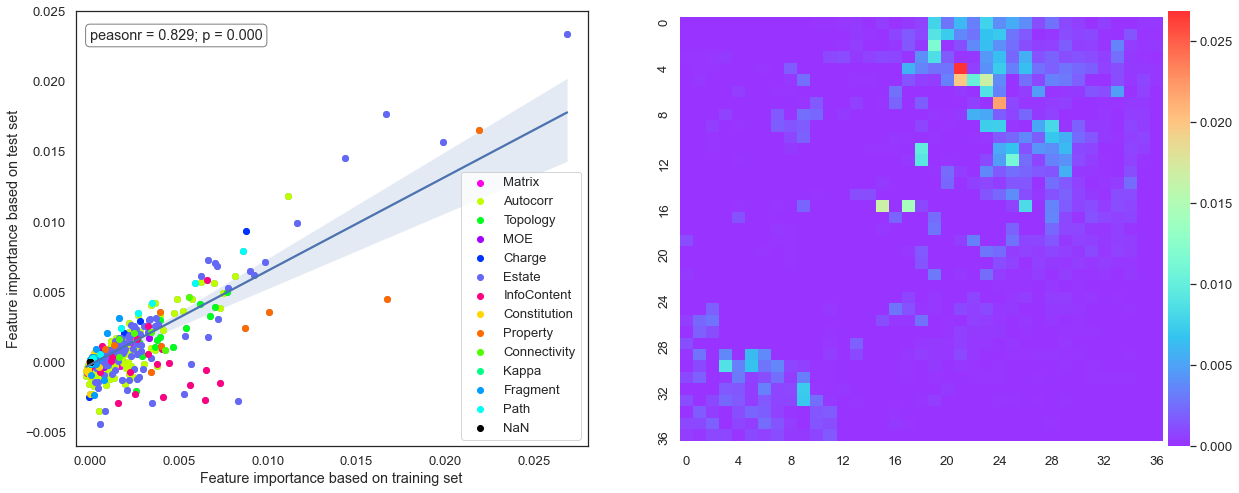

In [26]:
sns.set(style='white',  font='sans-serif', font_scale=1.2)

fig, (ax, ax2)  = plt.subplots(1, 2, figsize=(20, 8))
sns.regplot(dfp['Feature importance based on training set'], 
            dfp['Feature importance based on test set'], ax = ax)

for subtype, color in colormaps.items():
    dfi = dfp[dfp['Subtypes'] == subtype]
    x = dfi['Feature importance based on training set']
    y = dfi['Feature importance based on test set']
    ax.scatter(x, y, label = subtype, color = color)
for i,j in dfp.iterrows():
    x = j['Feature importance based on training set']
    y = j['Feature importance based on test set']
    if (x > 0.03) | (y > 0.052):
        ax.text(x-0.005,y,i, fontsize = 11, verticalalignment = 'center')
from scipy.stats import pearsonr
pcc, p = pearsonr(dfp['Feature importance based on training set'], dfp['Feature importance based on test set'])    
p = '%.3f' % p
pcc = '%.3f' % pcc
ax.text(0.00,0.023,'peasonr = %s; p = %s' % (pcc, p), bbox = {'boxstyle': 'round', 'facecolor': 'white', 'edgecolor':'gray'})
ax.legend(loc = 'lower right')

ax.set_xlim(-0.0008, 0.028)
ax.set_ylim(-0.006, 0.025)

IMPM = pd.Series(abs_train).values.reshape(37,37)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, 
            yticklabels=4, 
#             vmin = -0.004,
            ax = ax2,  
            cbar_kws = {'fraction':0.046, 'pad':0.01})

bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)


plt.subplots_adjust(wspace = 0.18)
# plt.savefig('des_feature_importance.jpg', dpi = 600, bbox_inches="tight")
plt.show()

## Fingerprints

In [10]:
trainX = (train_X2[train_idx])
validX = (train_X2[valid_idx])
testX = (train_X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

In [11]:
clf = MultiClassEstimator(n_outputs=trainY.shape[1],
                          fmap_shape1 = train_X2.shape[1:],
#                           fmap_shape2 = train_X2.shape[1:],
                          conv1_kernel_size=13,
                          dense_layers=[128, 64],
                          dense_avf='tanh',
                          batch_size=64,
                          lr=0.0001,
                          loss='categorical_crossentropy',
                          monitor='val_loss',
                          random_state=32,
                          metric='ROC',
                          epochs=100,
                          verbose=2,patience=20,
                          gpuid = 0)

MultiClassEstimator(batch_size=64, dense_avf='tanh', epochs=100,
                    fmap_shape1=(37, 36, 3), gpuid='0', n_outputs=2,
                    patience=20)


In [12]:
clf.fit(trainX, trainY, validX, validY )

BestEpoch = clf._performance.best_epoch
BestLoss = clf._performance.best
print('Best epochs: %.2f, Best loss: %.2f' % (BestEpoch, BestLoss))

3/3 [==============================] - 0s 9ms/step
epoch: 0001, loss: 0.6751 - val_loss: 0.6803; auc: 0.7453 - val_auc: 0.6294                                                                                                    
3/3 [==============================] - 0s 7ms/step
epoch: 0002, loss: 0.6469 - val_loss: 0.6762; auc: 0.7795 - val_auc: 0.6641                                                                                                    
3/3 [==============================] - 0s 10ms/step
epoch: 0003, loss: 0.6213 - val_loss: 0.6557; auc: 0.7914 - val_auc: 0.6651                                                                                                    
3/3 [==============================] - 0s 8ms/step
epoch: 0004, loss: 0.6040 - val_loss: 0.6443; auc: 0.8099 - val_auc: 0.6858                                                                                                    
3/3 [==============================] - 0s 7ms/step
epoch: 0005, loss: 0.5880 - val_loss: 0.

3/3 [==============================] - 0s 8ms/step
epoch: 0030, loss: 0.1922 - val_loss: 0.6033; auc: 0.9998 - val_auc: 0.7645                                                                                                    
3/3 [==============================] - 0s 9ms/step
epoch: 0031, loss: 0.1789 - val_loss: 0.5832; auc: 1.0000 - val_auc: 0.7738                                                                                                    
3/3 [==============================] - 0s 8ms/step
epoch: 0032, loss: 0.1554 - val_loss: 0.5868; auc: 1.0000 - val_auc: 0.7728                                                                                                    
3/3 [==============================] - 0s 9ms/step
epoch: 0033, loss: 0.1509 - val_loss: 0.6177; auc: 1.0000 - val_auc: 0.7681                                                                                                    
3/3 [==============================] - 0s 8ms/step
epoch: 0034, loss: 0.1372 - val_loss: 0.5

In [13]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T
train_pred = clf.predict(trainX)
valid_pred = clf.predict(validX)
test_pred = clf.predict(testX)

train_proba = clf.predict_proba(trainX)
valid_proba = clf.predict_proba(validX)
test_proba = clf.predict_proba(testX)

train_acc = accuracy_score(trainY[:, 1],train_pred[:, 1])
valid_acc = accuracy_score(validY[:, 1],valid_pred[:, 1])
test_acc = accuracy_score(testY[:, 1],test_pred[:, 1])

train_auc = roc_auc_score(trainY[:, 1],train_proba[:, 1])
valid_auc = roc_auc_score(validY[:, 1],valid_proba[:, 1])
test_auc = roc_auc_score(testY[:, 1],test_proba[:, 1])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

3/3 [==============================] - 0s 8ms/step


,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
23,0.286008,0.568416,0.992095,0.76501,23.0,0.992095,0.953125,0.76501,0.715909,0.824074,0.772727


In [14]:
result_data = pd.DataFrame([trainY[:, 1],train_proba[:, 1],train_pred[:, 1]
                           ,validY[:, 1],valid_proba[:, 1],valid_pred[:, 1]
                           ,testY[:, 1],test_proba[:, 1],test_pred[:, 1]]).T
result_data.columns=['train_truth', 'train_prob','train_pred','valid_truth', 'valid_prob','valid_pred'
                    ,'test_truth', 'test_prob','test_pred']
result_data = result_data.fillna(999)
result_data['train_truth']=result_data['train_truth'].astype(int)
result_data['train_pred']=result_data['train_pred'].astype(int)
result_data['valid_truth']=result_data['valid_truth'].astype(int)
result_data['valid_pred']=result_data['valid_pred'].astype(int)
result_data['test_truth']=result_data['test_truth'].astype(int)
result_data['test_pred']=result_data['test_pred'].astype(int)

# result_data.to_csv('../dataset/fp_prediction.csv')

### Reported model and results

In [15]:
clf  = load_model('../dataset/fp.h5')

In [16]:
result = pd.read_csv('../dataset/fp_prediction.csv',index_col=0)

In [17]:
BestEpoch_info = pd.DataFrame(clf.history).iloc[BestEpoch,:]
result_df = pd.DataFrame(BestEpoch_info).T

train_acc = accuracy_score(result['train_truth'],result['train_pred'])
valid_acc = accuracy_score(result['valid_truth'][:88],result['valid_pred'][:88])
test_acc = accuracy_score(result['test_truth'][:88],result['test_pred'][:88])

train_auc = roc_auc_score(result['train_truth'],result['train_prob'])
valid_auc = roc_auc_score(result['valid_truth'][:88],result['valid_prob'][:88])
test_auc = roc_auc_score(result['test_truth'][:88],result['test_prob'][:88])

result_df['train_auc'] = train_auc
result_df['train_acc'] = train_acc
result_df['valid_auc'] = valid_auc
result_df['valid_acc'] = valid_acc
result_df['test_auc'] = test_auc
result_df['test_acc'] = test_acc

result_df

,loss,val_loss,auc,val_auc,epoch,train_auc,train_acc,valid_auc,valid_acc,test_auc,test_acc
23,0.286776,0.565868,0.992477,0.771222,23.0,0.992477,0.950284,0.771222,0.727273,0.826253,0.772727


### Feature importance calculation

In [18]:
n, w, h, c = trainX.shape
mp2.plot_grid()
df_grid = mp2.df_grid

2025-03-26 19:20:31,709 - INFO - [bidd-molmap] - generate file: ./fingerprint_1303_cosine_umap_molmap
2025-03-26 19:20:31,750 - INFO - [bidd-molmap] - save html file to ./fingerprint_1303_cosine_umap_molmap


In [19]:
model = clf._model
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = opt, loss = cross_entropy)

In [20]:
with tf.device('/cpu:0'):
    train_imp = ForwardPropFeatureImp(model, trainX, trainY,  df_grid)
    test_imp = ForwardPropFeatureImp(model, testX, testY,  df_grid)

22/22 [==============================] - 1s 47ms/step


  0%|                                                                                         | 0/1332 [00:00<?, ?it/s]

22/22 [==============================] - 1s 46ms/step


  0%|                                                                                 | 1/1332 [00:01<23:43,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


  0%|1                                                                                | 2/1332 [00:02<23:31,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  0%|1                                                                                | 3/1332 [00:03<23:33,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  0%|2                                                                                | 4/1332 [00:04<23:25,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  0%|3                                                                                | 5/1332 [00:05<23:27,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  0%|3                                                                                | 6/1332 [00:06<23:21,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  1%|4                                                                                | 7/1332 [00:07<23:22,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


  1%|4                                                                                | 8/1332 [00:08<23:11,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  1%|5                                                                                | 9/1332 [00:09<23:15,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  1%|6                                                                               | 10/1332 [00:10<23:14,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  1%|6                                                                               | 11/1332 [00:11<23:14,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


  1%|7                                                                               | 12/1332 [00:12<23:05,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


  1%|7                                                                               | 13/1332 [00:13<22:54,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


  1%|8                                                                               | 14/1332 [00:14<22:57,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  1%|9                                                                               | 15/1332 [00:15<23:09,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  1%|9                                                                               | 16/1332 [00:16<23:11,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


  1%|#                                                                               | 17/1332 [00:17<23:18,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


  1%|#                                                                               | 18/1332 [00:19<23:20,  1.07s/it]

22/22 [==============================] - 1s 43ms/step


  1%|#1                                                                              | 19/1332 [00:20<22:58,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


  2%|#2                                                                              | 20/1332 [00:21<23:04,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#2                                                                              | 21/1332 [00:22<23:04,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#3                                                                              | 22/1332 [00:23<22:58,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#3                                                                              | 23/1332 [00:24<22:54,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#4                                                                              | 24/1332 [00:25<22:49,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


  2%|#5                                                                              | 25/1332 [00:26<22:31,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#5                                                                              | 26/1332 [00:27<22:30,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#6                                                                              | 27/1332 [00:28<22:38,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  2%|#6                                                                              | 28/1332 [00:29<22:30,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


  2%|#7                                                                              | 29/1332 [00:30<22:37,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#8                                                                              | 30/1332 [00:31<22:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#8                                                                              | 31/1332 [00:32<22:31,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#9                                                                              | 32/1332 [00:33<22:32,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  2%|#9                                                                              | 33/1332 [00:34<22:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##                                                                              | 34/1332 [00:35<22:30,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##1                                                                             | 35/1332 [00:36<22:33,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  3%|##1                                                                             | 36/1332 [00:37<22:27,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  3%|##2                                                                             | 37/1332 [00:38<22:20,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##2                                                                             | 38/1332 [00:39<22:20,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##3                                                                             | 39/1332 [00:40<22:21,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  3%|##4                                                                             | 40/1332 [00:41<22:14,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##4                                                                             | 41/1332 [00:42<22:14,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##5                                                                             | 42/1332 [00:43<22:12,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  3%|##5                                                                             | 43/1332 [00:44<22:02,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##6                                                                             | 44/1332 [00:45<22:06,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  3%|##7                                                                             | 45/1332 [00:47<22:13,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  3%|##7                                                                             | 46/1332 [00:48<22:04,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  4%|##8                                                                             | 47/1332 [00:49<22:05,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  4%|##8                                                                             | 48/1332 [00:50<22:12,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  4%|##9                                                                             | 49/1332 [00:51<22:02,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  4%|###                                                                             | 50/1332 [00:52<22:06,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  4%|###                                                                             | 51/1332 [00:53<22:03,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  4%|###1                                                                            | 52/1332 [00:54<22:12,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  4%|###1                                                                            | 53/1332 [00:55<22:11,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  4%|###2                                                                            | 54/1332 [00:56<22:04,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  4%|###3                                                                            | 55/1332 [00:57<21:59,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  4%|###3                                                                            | 56/1332 [00:58<21:58,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  4%|###4                                                                            | 57/1332 [00:59<22:03,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  4%|###4                                                                            | 58/1332 [01:00<21:54,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  4%|###5                                                                            | 59/1332 [01:01<22:00,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###6                                                                            | 60/1332 [01:02<22:00,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###6                                                                            | 61/1332 [01:03<21:54,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###7                                                                            | 62/1332 [01:04<21:53,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  5%|###7                                                                            | 63/1332 [01:05<21:49,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###8                                                                            | 64/1332 [01:06<21:49,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###9                                                                            | 65/1332 [01:07<21:53,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  5%|###9                                                                            | 66/1332 [01:08<21:50,  1.04s/it]

22/22 [==============================] - 1s 42ms/step


  5%|####                                                                            | 67/1332 [01:09<21:38,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  5%|####                                                                            | 68/1332 [01:10<21:48,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  5%|####1                                                                           | 69/1332 [01:11<21:56,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  5%|####2                                                                           | 70/1332 [01:12<21:45,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  5%|####2                                                                           | 71/1332 [01:13<21:48,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  5%|####3                                                                           | 72/1332 [01:14<21:45,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  5%|####3                                                                           | 73/1332 [01:16<21:38,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  6%|####4                                                                           | 74/1332 [01:17<21:34,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  6%|####5                                                                           | 75/1332 [01:18<21:37,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  6%|####5                                                                           | 76/1332 [01:19<21:34,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  6%|####6                                                                           | 77/1332 [01:20<21:42,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  6%|####6                                                                           | 78/1332 [01:21<21:40,  1.04s/it]

22/22 [==============================] - 1s 42ms/step


  6%|####7                                                                           | 79/1332 [01:22<21:28,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  6%|####8                                                                           | 80/1332 [01:23<21:26,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  6%|####8                                                                           | 81/1332 [01:24<21:36,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  6%|####9                                                                           | 82/1332 [01:25<21:29,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  6%|####9                                                                           | 83/1332 [01:26<21:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  6%|#####                                                                           | 84/1332 [01:27<21:31,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  6%|#####1                                                                          | 85/1332 [01:28<21:24,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  6%|#####1                                                                          | 86/1332 [01:29<21:25,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  7%|#####2                                                                          | 87/1332 [01:30<21:20,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####2                                                                          | 88/1332 [01:31<21:20,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####3                                                                          | 89/1332 [01:32<21:22,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####4                                                                          | 90/1332 [01:33<21:21,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  7%|#####4                                                                          | 91/1332 [01:34<21:17,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####5                                                                          | 92/1332 [01:35<21:20,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####5                                                                          | 93/1332 [01:36<21:24,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####6                                                                          | 94/1332 [01:37<21:21,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####7                                                                          | 95/1332 [01:38<21:21,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####7                                                                          | 96/1332 [01:39<21:18,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####8                                                                          | 97/1332 [01:40<21:16,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####8                                                                          | 98/1332 [01:41<21:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  7%|#####9                                                                          | 99/1332 [01:42<21:16,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  8%|#####9                                                                         | 100/1332 [01:43<21:11,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|#####9                                                                         | 101/1332 [01:44<21:14,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|######                                                                         | 102/1332 [01:45<21:16,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######1                                                                        | 103/1332 [01:47<21:07,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|######1                                                                        | 104/1332 [01:48<21:05,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######2                                                                        | 105/1332 [01:49<21:07,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######2                                                                        | 106/1332 [01:50<21:01,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|######3                                                                        | 107/1332 [01:51<21:04,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|######4                                                                        | 108/1332 [01:52<21:05,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######4                                                                        | 109/1332 [01:53<20:57,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######5                                                                        | 110/1332 [01:54<20:54,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  8%|######5                                                                        | 111/1332 [01:55<21:05,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  8%|######6                                                                        | 112/1332 [01:56<20:57,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  8%|######7                                                                        | 113/1332 [01:57<21:08,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  9%|######7                                                                        | 114/1332 [01:58<21:08,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  9%|######8                                                                        | 115/1332 [01:59<21:00,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  9%|######8                                                                        | 116/1332 [02:00<20:50,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


  9%|######9                                                                        | 117/1332 [02:01<20:54,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  9%|######9                                                                        | 118/1332 [02:02<20:48,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  9%|#######                                                                        | 119/1332 [02:03<20:55,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


  9%|#######1                                                                       | 120/1332 [02:04<20:49,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


  9%|#######1                                                                       | 121/1332 [02:05<20:36,  1.02s/it]

22/22 [==============================] - 1s 45ms/step


  9%|#######2                                                                       | 122/1332 [02:06<20:46,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  9%|#######2                                                                       | 123/1332 [02:07<20:44,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


  9%|#######3                                                                       | 124/1332 [02:08<20:39,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


  9%|#######4                                                                       | 125/1332 [02:09<20:50,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


  9%|#######4                                                                       | 126/1332 [02:10<20:49,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 10%|#######5                                                                       | 127/1332 [02:11<20:39,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|#######5                                                                       | 128/1332 [02:12<20:41,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|#######6                                                                       | 129/1332 [02:13<20:44,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 10%|#######7                                                                       | 130/1332 [02:14<20:38,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|#######7                                                                       | 131/1332 [02:15<20:41,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|#######8                                                                       | 132/1332 [02:16<20:46,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 10%|#######8                                                                       | 133/1332 [02:17<20:34,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|#######9                                                                       | 134/1332 [02:19<20:37,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 10%|########                                                                       | 135/1332 [02:20<20:45,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 10%|########                                                                       | 136/1332 [02:21<20:44,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 10%|########1                                                                      | 137/1332 [02:22<20:44,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 10%|########1                                                                      | 138/1332 [02:23<20:42,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 10%|########2                                                                      | 139/1332 [02:24<20:29,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########3                                                                      | 140/1332 [02:25<20:32,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########3                                                                      | 141/1332 [02:26<20:35,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 11%|########4                                                                      | 142/1332 [02:27<20:29,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########4                                                                      | 143/1332 [02:28<20:28,  1.03s/it]

22/22 [==============================] - 1s 46ms/step


 11%|########5                                                                      | 144/1332 [02:29<20:43,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 11%|########5                                                                      | 145/1332 [02:30<20:37,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########6                                                                      | 146/1332 [02:31<20:37,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 11%|########7                                                                      | 147/1332 [02:32<20:34,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 11%|########7                                                                      | 148/1332 [02:33<20:27,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 11%|########8                                                                      | 149/1332 [02:34<20:35,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########8                                                                      | 150/1332 [02:35<20:29,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 11%|########9                                                                      | 151/1332 [02:36<20:23,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 11%|#########                                                                      | 152/1332 [02:37<20:25,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 11%|#########                                                                      | 153/1332 [02:38<20:28,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 12%|#########1                                                                     | 154/1332 [02:39<20:17,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########1                                                                     | 155/1332 [02:40<20:21,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########2                                                                     | 156/1332 [02:41<20:22,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 12%|#########3                                                                     | 157/1332 [02:42<20:10,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########3                                                                     | 158/1332 [02:43<20:14,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 12%|#########4                                                                     | 159/1332 [02:44<20:14,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 12%|#########4                                                                     | 160/1332 [02:45<20:07,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 12%|#########5                                                                     | 161/1332 [02:47<20:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########6                                                                     | 162/1332 [02:48<20:16,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 12%|#########6                                                                     | 163/1332 [02:49<20:08,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########7                                                                     | 164/1332 [02:50<20:11,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########7                                                                     | 165/1332 [02:51<20:12,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 12%|#########8                                                                     | 166/1332 [02:52<20:13,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 13%|#########9                                                                     | 167/1332 [02:53<20:26,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 13%|#########9                                                                     | 168/1332 [02:54<20:23,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 13%|##########                                                                     | 169/1332 [02:55<20:11,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 13%|##########                                                                     | 170/1332 [02:56<20:10,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 13%|##########1                                                                    | 171/1332 [02:57<20:18,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 13%|##########2                                                                    | 172/1332 [02:58<20:13,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 13%|##########2                                                                    | 173/1332 [02:59<20:20,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 13%|##########3                                                                    | 174/1332 [03:00<20:19,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 13%|##########3                                                                    | 175/1332 [03:01<20:14,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 13%|##########4                                                                    | 176/1332 [03:02<20:14,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 13%|##########4                                                                    | 177/1332 [03:03<20:15,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 13%|##########5                                                                    | 178/1332 [03:04<20:10,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 13%|##########6                                                                    | 179/1332 [03:05<20:16,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########6                                                                    | 180/1332 [03:06<20:15,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########7                                                                    | 181/1332 [03:08<20:14,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########7                                                                    | 182/1332 [03:09<20:12,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########8                                                                    | 183/1332 [03:10<20:15,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########9                                                                    | 184/1332 [03:11<20:18,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|##########9                                                                    | 185/1332 [03:12<20:21,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|###########                                                                    | 186/1332 [03:13<20:16,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 14%|###########                                                                    | 187/1332 [03:14<20:05,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 14%|###########1                                                                   | 188/1332 [03:15<20:12,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|###########2                                                                   | 189/1332 [03:16<20:14,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 14%|###########2                                                                   | 190/1332 [03:17<20:10,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 14%|###########3                                                                   | 191/1332 [03:18<20:13,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 14%|###########3                                                                   | 192/1332 [03:19<20:07,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 14%|###########4                                                                   | 193/1332 [03:20<20:00,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 15%|###########5                                                                   | 194/1332 [03:21<19:56,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 15%|###########5                                                                   | 195/1332 [03:22<19:54,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 15%|###########6                                                                   | 196/1332 [03:23<19:49,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 15%|###########6                                                                   | 197/1332 [03:24<19:59,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 15%|###########7                                                                   | 198/1332 [03:26<20:05,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|###########8                                                                   | 199/1332 [03:27<20:00,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|###########8                                                                   | 200/1332 [03:28<19:59,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|###########9                                                                   | 201/1332 [03:29<20:04,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|###########9                                                                   | 202/1332 [03:30<19:59,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|############                                                                   | 203/1332 [03:31<19:58,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|############                                                                   | 204/1332 [03:32<20:01,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 15%|############1                                                                  | 205/1332 [03:33<19:49,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 15%|############2                                                                  | 206/1332 [03:34<19:46,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############2                                                                  | 207/1332 [03:35<19:51,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############3                                                                  | 208/1332 [03:36<19:52,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 16%|############3                                                                  | 209/1332 [03:37<19:59,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############4                                                                  | 210/1332 [03:38<19:53,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 16%|############5                                                                  | 211/1332 [03:39<19:43,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############5                                                                  | 212/1332 [03:40<19:47,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############6                                                                  | 213/1332 [03:41<19:49,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############6                                                                  | 214/1332 [03:43<19:47,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############7                                                                  | 215/1332 [03:44<19:48,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 16%|############8                                                                  | 216/1332 [03:45<19:41,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 16%|############8                                                                  | 217/1332 [03:46<19:35,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############9                                                                  | 218/1332 [03:47<19:37,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 16%|############9                                                                  | 219/1332 [03:48<19:40,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 17%|#############                                                                  | 220/1332 [03:49<19:32,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############1                                                                 | 221/1332 [03:50<19:36,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############1                                                                 | 222/1332 [03:51<19:36,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 17%|#############2                                                                 | 223/1332 [03:52<19:23,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 17%|#############2                                                                 | 224/1332 [03:53<19:30,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############3                                                                 | 225/1332 [03:54<19:35,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############4                                                                 | 226/1332 [03:55<19:37,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 17%|#############4                                                                 | 227/1332 [03:56<19:41,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############5                                                                 | 228/1332 [03:57<19:35,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############5                                                                 | 229/1332 [03:58<19:30,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############6                                                                 | 230/1332 [03:59<19:30,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############7                                                                 | 231/1332 [04:01<19:32,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############7                                                                 | 232/1332 [04:02<19:29,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 17%|#############8                                                                 | 233/1332 [04:03<19:28,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 18%|#############8                                                                 | 234/1332 [04:04<19:27,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 18%|#############9                                                                 | 235/1332 [04:05<19:14,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 18%|#############9                                                                 | 236/1332 [04:06<19:12,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 18%|##############                                                                 | 237/1332 [04:07<19:12,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 18%|##############1                                                                | 238/1332 [04:08<19:05,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 18%|##############1                                                                | 239/1332 [04:09<19:09,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 18%|##############2                                                                | 240/1332 [04:10<19:07,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 18%|##############2                                                                | 241/1332 [04:11<18:56,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 18%|##############3                                                                | 242/1332 [04:12<18:56,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 18%|##############4                                                                | 243/1332 [04:13<19:00,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 18%|##############4                                                                | 244/1332 [04:14<19:01,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 18%|##############5                                                                | 245/1332 [04:15<19:06,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 18%|##############5                                                                | 246/1332 [04:16<19:06,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 19%|##############6                                                                | 247/1332 [04:17<19:01,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 19%|##############7                                                                | 248/1332 [04:18<19:04,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 19%|##############7                                                                | 249/1332 [04:19<19:03,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 19%|##############8                                                                | 250/1332 [04:21<19:01,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 19%|##############8                                                                | 251/1332 [04:22<19:06,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 19%|##############9                                                                | 252/1332 [04:23<19:02,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 19%|###############                                                                | 253/1332 [04:24<18:54,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 19%|###############                                                                | 254/1332 [04:25<18:53,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 19%|###############1                                                               | 255/1332 [04:26<18:57,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 19%|###############1                                                               | 256/1332 [04:27<18:56,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 19%|###############2                                                               | 257/1332 [04:28<19:00,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 19%|###############3                                                               | 258/1332 [04:29<18:54,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 19%|###############3                                                               | 259/1332 [04:30<18:49,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 20%|###############4                                                               | 260/1332 [04:31<18:46,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 20%|###############4                                                               | 261/1332 [04:32<18:41,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 20%|###############5                                                               | 262/1332 [04:33<18:34,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 20%|###############5                                                               | 263/1332 [04:34<18:42,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 20%|###############6                                                               | 264/1332 [04:35<18:44,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 20%|###############7                                                               | 265/1332 [04:36<18:39,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 20%|###############7                                                               | 266/1332 [04:37<18:44,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 20%|###############8                                                               | 267/1332 [04:38<18:50,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 20%|###############8                                                               | 268/1332 [04:39<18:41,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 20%|###############9                                                               | 269/1332 [04:41<18:49,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 20%|################                                                               | 270/1332 [04:42<18:45,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 20%|################                                                               | 271/1332 [04:43<18:41,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 20%|################1                                                              | 272/1332 [04:44<18:40,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 20%|################1                                                              | 273/1332 [04:45<18:40,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################2                                                              | 274/1332 [04:46<18:42,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 21%|################3                                                              | 275/1332 [04:47<18:46,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################3                                                              | 276/1332 [04:48<18:46,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 21%|################4                                                              | 277/1332 [04:49<18:37,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################4                                                              | 278/1332 [04:50<18:37,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 21%|################5                                                              | 279/1332 [04:51<18:36,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 21%|################6                                                              | 280/1332 [04:52<18:29,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 21%|################6                                                              | 281/1332 [04:53<18:35,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################7                                                              | 282/1332 [04:54<18:31,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 21%|################7                                                              | 283/1332 [04:55<18:26,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################8                                                              | 284/1332 [04:56<18:29,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 21%|################9                                                              | 285/1332 [04:57<18:28,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 21%|################9                                                              | 286/1332 [04:59<18:23,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################                                                              | 287/1332 [05:00<18:25,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################                                                              | 288/1332 [05:01<18:22,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 22%|#################1                                                             | 289/1332 [05:02<18:17,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################1                                                             | 290/1332 [05:03<18:18,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################2                                                             | 291/1332 [05:04<18:24,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################3                                                             | 292/1332 [05:05<18:20,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################3                                                             | 293/1332 [05:06<18:22,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################4                                                             | 294/1332 [05:07<18:25,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 22%|#################4                                                             | 295/1332 [05:08<18:15,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 22%|#################5                                                             | 296/1332 [05:09<18:13,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################6                                                             | 297/1332 [05:10<18:12,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 22%|#################6                                                             | 298/1332 [05:11<18:09,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 22%|#################7                                                             | 299/1332 [05:12<18:07,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 23%|#################7                                                             | 300/1332 [05:13<18:07,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 23%|#################8                                                             | 301/1332 [05:14<18:04,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 23%|#################9                                                             | 302/1332 [05:15<18:10,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 23%|#################9                                                             | 303/1332 [05:17<18:12,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################                                                             | 304/1332 [05:18<18:11,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################                                                             | 305/1332 [05:19<18:12,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################1                                                            | 306/1332 [05:20<18:09,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 23%|##################2                                                            | 307/1332 [05:21<17:59,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################2                                                            | 308/1332 [05:22<17:56,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################3                                                            | 309/1332 [05:23<18:01,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 23%|##################3                                                            | 310/1332 [05:24<17:57,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################4                                                            | 311/1332 [05:25<17:59,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 23%|##################5                                                            | 312/1332 [05:26<17:56,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 23%|##################5                                                            | 313/1332 [05:27<17:50,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 24%|##################6                                                            | 314/1332 [05:28<17:47,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 24%|##################6                                                            | 315/1332 [05:29<17:53,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 24%|##################7                                                            | 316/1332 [05:30<17:59,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 24%|##################8                                                            | 317/1332 [05:31<17:56,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 24%|##################8                                                            | 318/1332 [05:32<17:49,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 24%|##################9                                                            | 319/1332 [05:33<17:39,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 24%|##################9                                                            | 320/1332 [05:34<17:39,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 24%|###################                                                            | 321/1332 [05:35<17:36,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 24%|###################                                                            | 322/1332 [05:37<17:39,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 24%|###################1                                                           | 323/1332 [05:38<17:41,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 24%|###################2                                                           | 324/1332 [05:39<17:34,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 24%|###################2                                                           | 325/1332 [05:40<17:22,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 24%|###################3                                                           | 326/1332 [05:41<17:29,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 25%|###################3                                                           | 327/1332 [05:42<17:29,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 25%|###################4                                                           | 328/1332 [05:43<17:25,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 25%|###################5                                                           | 329/1332 [05:44<17:28,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 25%|###################5                                                           | 330/1332 [05:45<17:28,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 25%|###################6                                                           | 331/1332 [05:46<17:21,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 25%|###################6                                                           | 332/1332 [05:47<17:24,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 25%|###################7                                                           | 333/1332 [05:48<17:31,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 25%|###################8                                                           | 334/1332 [05:49<17:29,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 25%|###################8                                                           | 335/1332 [05:50<17:31,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 25%|###################9                                                           | 336/1332 [05:51<17:38,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 25%|###################9                                                           | 337/1332 [05:52<17:26,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 25%|####################                                                           | 338/1332 [05:53<17:24,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 25%|####################1                                                          | 339/1332 [05:54<17:25,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################1                                                          | 340/1332 [05:55<17:19,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 26%|####################2                                                          | 341/1332 [05:56<17:20,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 26%|####################2                                                          | 342/1332 [05:58<17:20,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 26%|####################3                                                          | 343/1332 [05:59<17:06,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################4                                                          | 344/1332 [06:00<17:03,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################4                                                          | 345/1332 [06:01<17:05,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################5                                                          | 346/1332 [06:02<17:03,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 26%|####################5                                                          | 347/1332 [06:03<17:06,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 26%|####################6                                                          | 348/1332 [06:04<17:07,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################6                                                          | 349/1332 [06:05<17:04,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################7                                                          | 350/1332 [06:06<17:01,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 26%|####################8                                                          | 351/1332 [06:07<17:05,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 26%|####################8                                                          | 352/1332 [06:08<17:00,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 27%|####################9                                                          | 353/1332 [06:09<16:59,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 27%|####################9                                                          | 354/1332 [06:10<17:01,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 27%|#####################                                                          | 355/1332 [06:11<16:55,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################1                                                         | 356/1332 [06:12<16:58,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################1                                                         | 357/1332 [06:13<17:03,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 27%|#####################2                                                         | 358/1332 [06:14<17:00,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 27%|#####################2                                                         | 359/1332 [06:15<17:10,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 27%|#####################3                                                         | 360/1332 [06:16<17:03,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 27%|#####################4                                                         | 361/1332 [06:17<17:00,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################4                                                         | 362/1332 [06:18<17:01,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################5                                                         | 363/1332 [06:19<17:05,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 27%|#####################5                                                         | 364/1332 [06:21<17:00,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################6                                                         | 365/1332 [06:22<17:01,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 27%|#####################7                                                         | 366/1332 [06:23<17:04,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 28%|#####################7                                                         | 367/1332 [06:24<16:57,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 28%|#####################8                                                         | 368/1332 [06:25<16:57,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 28%|#####################8                                                         | 369/1332 [06:26<16:59,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 28%|#####################9                                                         | 370/1332 [06:27<16:52,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 28%|######################                                                         | 371/1332 [06:28<16:57,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 28%|######################                                                         | 372/1332 [06:29<16:58,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 28%|######################1                                                        | 373/1332 [06:30<16:47,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 28%|######################1                                                        | 374/1332 [06:31<16:49,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 28%|######################2                                                        | 375/1332 [06:32<16:44,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 28%|######################3                                                        | 376/1332 [06:33<16:37,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 28%|######################3                                                        | 377/1332 [06:34<16:42,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 28%|######################4                                                        | 378/1332 [06:35<16:37,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 28%|######################4                                                        | 379/1332 [06:36<16:30,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################5                                                        | 380/1332 [06:37<16:34,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################5                                                        | 381/1332 [06:38<16:39,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################6                                                        | 382/1332 [06:39<16:39,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 29%|######################7                                                        | 383/1332 [06:41<16:45,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################7                                                        | 384/1332 [06:42<16:43,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 29%|######################8                                                        | 385/1332 [06:43<16:34,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################8                                                        | 386/1332 [06:44<16:35,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 29%|######################9                                                        | 387/1332 [06:45<16:40,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 29%|#######################                                                        | 388/1332 [06:46<16:33,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 29%|#######################                                                        | 389/1332 [06:47<16:34,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 29%|#######################1                                                       | 390/1332 [06:48<16:33,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 29%|#######################1                                                       | 391/1332 [06:49<16:29,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 29%|#######################2                                                       | 392/1332 [06:50<16:32,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 30%|#######################3                                                       | 393/1332 [06:51<16:31,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 30%|#######################3                                                       | 394/1332 [06:52<16:24,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 30%|#######################4                                                       | 395/1332 [06:53<16:28,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 30%|#######################4                                                       | 396/1332 [06:54<16:30,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 30%|#######################5                                                       | 397/1332 [06:55<16:23,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 30%|#######################6                                                       | 398/1332 [06:56<16:22,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 30%|#######################6                                                       | 399/1332 [06:57<16:19,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 30%|#######################7                                                       | 400/1332 [06:58<16:19,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 30%|#######################7                                                       | 401/1332 [06:59<16:26,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 30%|#######################8                                                       | 402/1332 [07:01<16:26,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 30%|#######################9                                                       | 403/1332 [07:02<16:24,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 30%|#######################9                                                       | 404/1332 [07:03<16:31,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 30%|########################                                                       | 405/1332 [07:04<16:31,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 30%|########################                                                       | 406/1332 [07:05<16:21,  1.06s/it]

22/22 [==============================] - 1s 47ms/step


 31%|########################1                                                      | 407/1332 [07:06<16:30,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################1                                                      | 408/1332 [07:07<16:24,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 31%|########################2                                                      | 409/1332 [07:08<16:16,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################3                                                      | 410/1332 [07:09<16:16,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 31%|########################3                                                      | 411/1332 [07:10<16:12,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################4                                                      | 412/1332 [07:11<16:11,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 31%|########################4                                                      | 413/1332 [07:12<16:15,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################5                                                      | 414/1332 [07:13<16:16,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 31%|########################6                                                      | 415/1332 [07:14<16:10,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################6                                                      | 416/1332 [07:15<16:10,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################7                                                      | 417/1332 [07:16<16:11,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 31%|########################7                                                      | 418/1332 [07:18<16:05,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 31%|########################8                                                      | 419/1332 [07:19<16:07,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 32%|########################9                                                      | 420/1332 [07:20<16:05,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 32%|########################9                                                      | 421/1332 [07:21<15:59,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################                                                      | 422/1332 [07:22<15:56,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 32%|#########################                                                      | 423/1332 [07:23<15:55,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 32%|#########################1                                                     | 424/1332 [07:24<15:59,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################2                                                     | 425/1332 [07:25<15:58,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################2                                                     | 426/1332 [07:26<16:00,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 32%|#########################3                                                     | 427/1332 [07:27<15:53,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################3                                                     | 428/1332 [07:28<15:51,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 32%|#########################4                                                     | 429/1332 [07:29<15:47,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 32%|#########################5                                                     | 430/1332 [07:30<15:44,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################5                                                     | 431/1332 [07:31<15:46,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 32%|#########################6                                                     | 432/1332 [07:32<15:46,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 33%|#########################6                                                     | 433/1332 [07:33<15:38,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 33%|#########################7                                                     | 434/1332 [07:34<15:40,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 33%|#########################7                                                     | 435/1332 [07:35<15:41,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 33%|#########################8                                                     | 436/1332 [07:36<15:32,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 33%|#########################9                                                     | 437/1332 [07:37<15:35,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 33%|#########################9                                                     | 438/1332 [07:39<15:34,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 33%|##########################                                                     | 439/1332 [07:40<15:26,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 33%|##########################                                                     | 440/1332 [07:41<15:22,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 33%|##########################1                                                    | 441/1332 [07:42<15:27,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 33%|##########################2                                                    | 442/1332 [07:43<15:25,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 33%|##########################2                                                    | 443/1332 [07:44<15:34,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 33%|##########################3                                                    | 444/1332 [07:45<15:30,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 33%|##########################3                                                    | 445/1332 [07:46<15:27,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 33%|##########################4                                                    | 446/1332 [07:47<15:31,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 34%|##########################5                                                    | 447/1332 [07:48<15:32,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 34%|##########################5                                                    | 448/1332 [07:49<15:31,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 34%|##########################6                                                    | 449/1332 [07:50<15:34,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 34%|##########################6                                                    | 450/1332 [07:51<15:30,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 34%|##########################7                                                    | 451/1332 [07:52<15:21,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 34%|##########################8                                                    | 452/1332 [07:53<15:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 34%|##########################8                                                    | 453/1332 [07:54<15:19,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 34%|##########################9                                                    | 454/1332 [07:55<15:13,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 34%|##########################9                                                    | 455/1332 [07:56<15:19,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 34%|###########################                                                    | 456/1332 [07:57<15:14,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 34%|###########################1                                                   | 457/1332 [07:58<15:06,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 34%|###########################1                                                   | 458/1332 [07:59<15:10,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 34%|###########################2                                                   | 459/1332 [08:00<15:10,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################2                                                   | 460/1332 [08:02<15:09,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################3                                                   | 461/1332 [08:03<15:09,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################4                                                   | 462/1332 [08:04<15:09,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################4                                                   | 463/1332 [08:05<15:04,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################5                                                   | 464/1332 [08:06<15:03,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################5                                                   | 465/1332 [08:07<15:03,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################6                                                   | 466/1332 [08:08<14:59,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 35%|###########################6                                                   | 467/1332 [08:09<15:03,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################7                                                   | 468/1332 [08:10<14:58,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 35%|###########################8                                                   | 469/1332 [08:11<14:48,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################8                                                   | 470/1332 [08:12<14:47,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################9                                                   | 471/1332 [08:13<14:54,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 35%|###########################9                                                   | 472/1332 [08:14<14:50,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 36%|############################                                                   | 473/1332 [08:15<14:54,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################1                                                  | 474/1332 [08:16<14:52,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 36%|############################1                                                  | 475/1332 [08:17<14:43,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 36%|############################2                                                  | 476/1332 [08:18<14:48,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################2                                                  | 477/1332 [08:19<14:50,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################3                                                  | 478/1332 [08:20<14:47,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 36%|############################4                                                  | 479/1332 [08:21<14:53,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################4                                                  | 480/1332 [08:22<14:49,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 36%|############################5                                                  | 481/1332 [08:23<14:43,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################5                                                  | 482/1332 [08:24<14:40,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################6                                                  | 483/1332 [08:25<14:43,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 36%|############################7                                                  | 484/1332 [08:26<14:38,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 36%|############################7                                                  | 485/1332 [08:28<14:49,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 36%|############################8                                                  | 486/1332 [08:29<14:46,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 37%|############################8                                                  | 487/1332 [08:30<14:39,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 37%|############################9                                                  | 488/1332 [08:31<14:38,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 37%|#############################                                                  | 489/1332 [08:32<14:40,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 37%|#############################                                                  | 490/1332 [08:33<14:31,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 37%|#############################1                                                 | 491/1332 [08:34<14:37,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 37%|#############################1                                                 | 492/1332 [08:35<14:31,  1.04s/it]

22/22 [==============================] - 1s 42ms/step


 37%|#############################2                                                 | 493/1332 [08:36<14:22,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 37%|#############################2                                                 | 494/1332 [08:37<14:18,  1.02s/it]

22/22 [==============================] - 1s 43ms/step


 37%|#############################3                                                 | 495/1332 [08:38<14:20,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 37%|#############################4                                                 | 496/1332 [08:39<14:13,  1.02s/it]

22/22 [==============================] - 1s 45ms/step


 37%|#############################4                                                 | 497/1332 [08:40<14:21,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 37%|#############################5                                                 | 498/1332 [08:41<14:21,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 37%|#############################5                                                 | 499/1332 [08:42<14:12,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 38%|#############################6                                                 | 500/1332 [08:43<14:17,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 38%|#############################7                                                 | 501/1332 [08:44<14:22,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 38%|#############################7                                                 | 502/1332 [08:45<14:16,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 38%|#############################8                                                 | 503/1332 [08:46<14:23,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 38%|#############################8                                                 | 504/1332 [08:47<14:20,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 38%|#############################9                                                 | 505/1332 [08:48<14:12,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 38%|##############################                                                 | 506/1332 [08:49<14:11,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 38%|##############################                                                 | 507/1332 [08:50<14:15,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 38%|##############################1                                                | 508/1332 [08:51<14:11,  1.03s/it]

22/22 [==============================] - 1s 47ms/step


 38%|##############################1                                                | 509/1332 [08:52<14:26,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 38%|##############################2                                                | 510/1332 [08:53<14:27,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 38%|##############################3                                                | 511/1332 [08:54<14:21,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 38%|##############################3                                                | 512/1332 [08:56<14:16,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 39%|##############################4                                                | 513/1332 [08:57<14:17,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 39%|##############################4                                                | 514/1332 [08:58<14:08,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 39%|##############################5                                                | 515/1332 [08:59<14:13,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 39%|##############################6                                                | 516/1332 [09:00<14:13,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 39%|##############################6                                                | 517/1332 [09:01<14:03,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 39%|##############################7                                                | 518/1332 [09:02<14:04,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 39%|##############################7                                                | 519/1332 [09:03<14:06,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 39%|##############################8                                                | 520/1332 [09:04<13:58,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 39%|##############################9                                                | 521/1332 [09:05<14:05,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 39%|##############################9                                                | 522/1332 [09:06<14:04,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 39%|###############################                                                | 523/1332 [09:07<13:55,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 39%|###############################                                                | 524/1332 [09:08<13:55,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 39%|###############################1                                               | 525/1332 [09:09<13:56,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 39%|###############################1                                               | 526/1332 [09:10<13:50,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 40%|###############################2                                               | 527/1332 [09:11<13:54,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################3                                               | 528/1332 [09:12<13:51,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################3                                               | 529/1332 [09:13<13:48,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################4                                               | 530/1332 [09:14<13:49,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################4                                               | 531/1332 [09:15<13:54,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################5                                               | 532/1332 [09:16<13:52,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 40%|###############################6                                               | 533/1332 [09:17<13:58,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 40%|###############################6                                               | 534/1332 [09:18<14:01,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 40%|###############################7                                               | 535/1332 [09:19<13:53,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 40%|###############################7                                               | 536/1332 [09:21<14:01,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 40%|###############################8                                               | 537/1332 [09:22<14:08,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 40%|###############################9                                               | 538/1332 [09:23<14:03,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 40%|###############################9                                               | 539/1332 [09:24<14:05,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################                                               | 540/1332 [09:25<14:02,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################                                               | 541/1332 [09:26<13:58,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################1                                              | 542/1332 [09:27<13:56,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################2                                              | 543/1332 [09:28<13:58,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################2                                              | 544/1332 [09:29<13:54,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 41%|################################3                                              | 545/1332 [09:30<13:57,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################3                                              | 546/1332 [09:31<13:54,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 41%|################################4                                              | 547/1332 [09:32<13:49,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 41%|################################5                                              | 548/1332 [09:33<13:54,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################5                                              | 549/1332 [09:34<13:56,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 41%|################################6                                              | 550/1332 [09:35<13:45,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 41%|################################6                                              | 551/1332 [09:36<13:45,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 41%|################################7                                              | 552/1332 [09:37<13:41,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 42%|################################7                                              | 553/1332 [09:39<13:32,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 42%|################################8                                              | 554/1332 [09:40<13:32,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 42%|################################9                                              | 555/1332 [09:41<13:37,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 42%|################################9                                              | 556/1332 [09:42<13:27,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 42%|#################################                                              | 557/1332 [09:43<13:34,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 42%|#################################                                              | 558/1332 [09:44<13:34,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 42%|#################################1                                             | 559/1332 [09:45<13:30,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 42%|#################################2                                             | 560/1332 [09:46<13:28,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 42%|#################################2                                             | 561/1332 [09:47<13:30,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 42%|#################################3                                             | 562/1332 [09:48<13:24,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 42%|#################################3                                             | 563/1332 [09:49<13:32,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 42%|#################################4                                             | 564/1332 [09:50<13:27,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 42%|#################################5                                             | 565/1332 [09:51<13:20,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 42%|#################################5                                             | 566/1332 [09:52<13:20,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 43%|#################################6                                             | 567/1332 [09:53<13:22,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 43%|#################################6                                             | 568/1332 [09:54<13:20,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 43%|#################################7                                             | 569/1332 [09:55<13:27,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 43%|#################################8                                             | 570/1332 [09:56<13:27,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 43%|#################################8                                             | 571/1332 [09:57<13:16,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 43%|#################################9                                             | 572/1332 [09:58<13:16,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 43%|#################################9                                             | 573/1332 [10:00<13:18,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 43%|##################################                                             | 574/1332 [10:01<13:11,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 43%|##################################1                                            | 575/1332 [10:02<13:12,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 43%|##################################1                                            | 576/1332 [10:03<13:10,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 43%|##################################2                                            | 577/1332 [10:04<13:02,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 43%|##################################2                                            | 578/1332 [10:05<13:02,  1.04s/it]

22/22 [==============================] - 1s 51ms/step


 43%|##################################3                                            | 579/1332 [10:06<15:24,  1.23s/it]

22/22 [==============================] - 1s 49ms/step


 44%|##################################3                                            | 580/1332 [10:08<15:03,  1.20s/it]

22/22 [==============================] - 1s 47ms/step


 44%|##################################4                                            | 581/1332 [10:09<14:41,  1.17s/it]

22/22 [==============================] - 1s 49ms/step


 44%|##################################5                                            | 582/1332 [10:10<14:35,  1.17s/it]

22/22 [==============================] - 1s 49ms/step


 44%|##################################5                                            | 583/1332 [10:11<14:29,  1.16s/it]

22/22 [==============================] - 1s 48ms/step


 44%|##################################6                                            | 584/1332 [10:12<14:19,  1.15s/it]

22/22 [==============================] - 1s 48ms/step


 44%|##################################6                                            | 585/1332 [10:13<14:16,  1.15s/it]

22/22 [==============================] - 1s 48ms/step


 44%|##################################7                                            | 586/1332 [10:14<14:10,  1.14s/it]

22/22 [==============================] - 1s 46ms/step


 44%|##################################8                                            | 587/1332 [10:15<13:56,  1.12s/it]

22/22 [==============================] - 1s 48ms/step


 44%|##################################8                                            | 588/1332 [10:16<13:54,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 44%|##################################9                                            | 589/1332 [10:18<13:48,  1.12s/it]

22/22 [==============================] - 1s 49ms/step


 44%|##################################9                                            | 590/1332 [10:19<13:55,  1.13s/it]

22/22 [==============================] - 1s 48ms/step


 44%|###################################                                            | 591/1332 [10:20<13:55,  1.13s/it]

22/22 [==============================] - 1s 48ms/step


 44%|###################################1                                           | 592/1332 [10:21<13:56,  1.13s/it]

22/22 [==============================] - 1s 46ms/step


 45%|###################################1                                           | 593/1332 [10:22<13:43,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################2                                           | 594/1332 [10:23<13:41,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 45%|###################################2                                           | 595/1332 [10:24<13:40,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################3                                           | 596/1332 [10:25<13:39,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################4                                           | 597/1332 [10:27<13:39,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################4                                           | 598/1332 [10:28<13:38,  1.12s/it]

22/22 [==============================] - 1s 46ms/step


 45%|###################################5                                           | 599/1332 [10:29<13:29,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 45%|###################################5                                           | 600/1332 [10:30<13:31,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 45%|###################################6                                           | 601/1332 [10:31<13:35,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################7                                           | 602/1332 [10:32<13:32,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 45%|###################################7                                           | 603/1332 [10:33<13:35,  1.12s/it]

22/22 [==============================] - 1s 48ms/step


 45%|###################################8                                           | 604/1332 [10:34<13:35,  1.12s/it]

22/22 [==============================] - 1s 46ms/step


 45%|###################################8                                           | 605/1332 [10:35<13:28,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 45%|###################################9                                           | 606/1332 [10:37<13:27,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 46%|####################################                                           | 607/1332 [10:38<13:30,  1.12s/it]

22/22 [==============================] - 1s 48ms/step


 46%|####################################                                           | 608/1332 [10:39<13:30,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 46%|####################################1                                          | 609/1332 [10:40<13:27,  1.12s/it]

22/22 [==============================] - 1s 49ms/step


 46%|####################################1                                          | 610/1332 [10:41<13:31,  1.12s/it]

22/22 [==============================] - 1s 46ms/step


 46%|####################################2                                          | 611/1332 [10:42<13:21,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 46%|####################################2                                          | 612/1332 [10:43<13:24,  1.12s/it]

22/22 [==============================] - 1s 46ms/step


 46%|####################################3                                          | 613/1332 [10:44<13:15,  1.11s/it]

22/22 [==============================] - 1s 49ms/step


 46%|####################################4                                          | 614/1332 [10:46<13:21,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 46%|####################################4                                          | 615/1332 [10:47<13:20,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 46%|####################################5                                          | 616/1332 [10:48<13:15,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 46%|####################################5                                          | 617/1332 [10:49<13:16,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 46%|####################################6                                          | 618/1332 [10:50<13:11,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 46%|####################################7                                          | 619/1332 [10:51<13:07,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 47%|####################################7                                          | 620/1332 [10:52<13:04,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 47%|####################################8                                          | 621/1332 [10:53<13:12,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 47%|####################################8                                          | 622/1332 [10:54<13:08,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 47%|####################################9                                          | 623/1332 [10:55<13:05,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################                                          | 624/1332 [10:57<13:05,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################                                          | 625/1332 [10:58<13:03,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################1                                         | 626/1332 [10:59<13:03,  1.11s/it]

22/22 [==============================] - 1s 49ms/step


 47%|#####################################1                                         | 627/1332 [11:00<13:12,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################2                                         | 628/1332 [11:01<13:08,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################3                                         | 629/1332 [11:02<13:05,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################3                                         | 630/1332 [11:03<13:00,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 47%|#####################################4                                         | 631/1332 [11:04<12:54,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 47%|#####################################4                                         | 632/1332 [11:05<12:53,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 48%|#####################################5                                         | 633/1332 [11:07<13:01,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 48%|#####################################6                                         | 634/1332 [11:08<12:59,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 48%|#####################################6                                         | 635/1332 [11:09<12:55,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 48%|#####################################7                                         | 636/1332 [11:10<12:49,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 48%|#####################################7                                         | 637/1332 [11:11<12:42,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 48%|#####################################8                                         | 638/1332 [11:12<12:45,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 48%|#####################################8                                         | 639/1332 [11:13<12:48,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 48%|#####################################9                                         | 640/1332 [11:14<12:44,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 48%|######################################                                         | 641/1332 [11:15<12:46,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 48%|######################################                                         | 642/1332 [11:17<12:45,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 48%|######################################1                                        | 643/1332 [11:18<12:41,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 48%|######################################1                                        | 644/1332 [11:19<12:41,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 48%|######################################2                                        | 645/1332 [11:20<12:46,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 48%|######################################3                                        | 646/1332 [11:21<12:44,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################3                                        | 647/1332 [11:22<12:40,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################4                                        | 648/1332 [11:23<12:39,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################4                                        | 649/1332 [11:24<12:35,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 49%|######################################5                                        | 650/1332 [11:25<12:36,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 49%|######################################6                                        | 651/1332 [11:27<12:39,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################6                                        | 652/1332 [11:28<12:36,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################7                                        | 653/1332 [11:29<12:31,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################7                                        | 654/1332 [11:30<12:30,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################8                                        | 655/1332 [11:31<12:28,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|######################################9                                        | 656/1332 [11:32<12:28,  1.11s/it]

22/22 [==============================] - 1s 49ms/step


 49%|######################################9                                        | 657/1332 [11:33<12:35,  1.12s/it]

22/22 [==============================] - 1s 47ms/step


 49%|#######################################                                        | 658/1332 [11:34<12:31,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 49%|#######################################                                        | 659/1332 [11:35<12:27,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################1                                       | 660/1332 [11:37<12:24,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################2                                       | 661/1332 [11:38<12:21,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################2                                       | 662/1332 [11:39<12:21,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################3                                       | 663/1332 [11:40<12:22,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 50%|#######################################3                                       | 664/1332 [11:41<12:17,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################4                                       | 665/1332 [11:42<12:16,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################5                                       | 666/1332 [11:43<12:14,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 50%|#######################################5                                       | 667/1332 [11:44<12:10,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################6                                       | 668/1332 [11:45<12:09,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 50%|#######################################6                                       | 669/1332 [11:47<12:15,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################7                                       | 670/1332 [11:48<12:13,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################7                                       | 671/1332 [11:49<12:11,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 50%|#######################################8                                       | 672/1332 [11:50<12:08,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 51%|#######################################9                                       | 673/1332 [11:51<12:05,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 51%|#######################################9                                       | 674/1332 [11:52<12:06,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 51%|########################################                                       | 675/1332 [11:53<12:11,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################                                       | 676/1332 [11:54<12:08,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################1                                      | 677/1332 [11:55<12:05,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################2                                      | 678/1332 [11:56<12:03,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 51%|########################################2                                      | 679/1332 [11:58<11:58,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################3                                      | 680/1332 [11:59<11:57,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################3                                      | 681/1332 [12:00<11:57,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 51%|########################################4                                      | 682/1332 [12:01<11:53,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 51%|########################################5                                      | 683/1332 [12:02<11:53,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 51%|########################################5                                      | 684/1332 [12:03<11:51,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 51%|########################################6                                      | 685/1332 [12:04<11:47,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 52%|########################################6                                      | 686/1332 [12:05<11:45,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 52%|########################################7                                      | 687/1332 [12:06<11:49,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 52%|########################################8                                      | 688/1332 [12:07<11:46,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|########################################8                                      | 689/1332 [12:09<11:47,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|########################################9                                      | 690/1332 [12:10<11:47,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 52%|########################################9                                      | 691/1332 [12:11<11:43,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 52%|#########################################                                      | 692/1332 [12:12<11:41,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|#########################################1                                     | 693/1332 [12:13<11:44,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|#########################################1                                     | 694/1332 [12:14<11:42,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|#########################################2                                     | 695/1332 [12:15<11:40,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 52%|#########################################2                                     | 696/1332 [12:16<11:39,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 52%|#########################################3                                     | 697/1332 [12:17<11:34,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 52%|#########################################3                                     | 698/1332 [12:18<11:32,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 52%|#########################################4                                     | 699/1332 [12:19<11:34,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 53%|#########################################5                                     | 700/1332 [12:21<11:31,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 53%|#########################################5                                     | 701/1332 [12:22<11:29,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 53%|#########################################6                                     | 702/1332 [12:23<11:26,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 53%|#########################################6                                     | 703/1332 [12:24<11:21,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 53%|#########################################7                                     | 704/1332 [12:25<11:23,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 53%|#########################################8                                     | 705/1332 [12:26<11:28,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 53%|#########################################8                                     | 706/1332 [12:27<11:27,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 53%|#########################################9                                     | 707/1332 [12:28<11:29,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 53%|#########################################9                                     | 708/1332 [12:29<11:28,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 53%|##########################################                                     | 709/1332 [12:30<11:23,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 53%|##########################################1                                    | 710/1332 [12:32<11:28,  1.11s/it]

22/22 [==============================] - 1s 48ms/step


 53%|##########################################1                                    | 711/1332 [12:33<11:32,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 53%|##########################################2                                    | 712/1332 [12:34<11:26,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################2                                    | 713/1332 [12:35<11:23,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 54%|##########################################3                                    | 714/1332 [12:36<11:17,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 54%|##########################################4                                    | 715/1332 [12:37<11:13,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################4                                    | 716/1332 [12:38<11:13,  1.09s/it]

22/22 [==============================] - 1s 48ms/step


 54%|##########################################5                                    | 717/1332 [12:39<11:19,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################5                                    | 718/1332 [12:40<11:16,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################6                                    | 719/1332 [12:41<11:15,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################7                                    | 720/1332 [12:43<11:14,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 54%|##########################################7                                    | 721/1332 [12:44<11:10,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################8                                    | 722/1332 [12:45<11:09,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 54%|##########################################8                                    | 723/1332 [12:46<11:15,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################9                                    | 724/1332 [12:47<11:14,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 54%|##########################################9                                    | 725/1332 [12:48<11:12,  1.11s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################                                    | 726/1332 [12:49<11:11,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 55%|###########################################1                                   | 727/1332 [12:50<11:03,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 55%|###########################################1                                   | 728/1332 [12:51<11:01,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################2                                   | 729/1332 [12:53<11:05,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################2                                   | 730/1332 [12:54<11:02,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################3                                   | 731/1332 [12:55<11:01,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################4                                   | 732/1332 [12:56<10:59,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 55%|###########################################4                                   | 733/1332 [12:57<10:57,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################5                                   | 734/1332 [12:58<10:56,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 55%|###########################################5                                   | 735/1332 [12:59<11:01,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 55%|###########################################6                                   | 736/1332 [13:00<10:57,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################7                                   | 737/1332 [13:01<10:56,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 55%|###########################################7                                   | 738/1332 [13:02<10:54,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 55%|###########################################8                                   | 739/1332 [13:04<10:51,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 56%|###########################################8                                   | 740/1332 [13:05<10:49,  1.10s/it]

22/22 [==============================] - 1s 48ms/step


 56%|###########################################9                                   | 741/1332 [13:06<10:55,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################                                   | 742/1332 [13:07<10:48,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################                                   | 743/1332 [13:08<10:45,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################1                                  | 744/1332 [13:09<10:43,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 56%|############################################1                                  | 745/1332 [13:10<10:37,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################2                                  | 746/1332 [13:11<10:39,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 56%|############################################3                                  | 747/1332 [13:12<10:42,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 56%|############################################3                                  | 748/1332 [13:13<10:43,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 56%|############################################4                                  | 749/1332 [13:15<10:43,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################4                                  | 750/1332 [13:16<10:39,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 56%|############################################5                                  | 751/1332 [13:17<10:36,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 56%|############################################6                                  | 752/1332 [13:18<10:34,  1.09s/it]

22/22 [==============================] - 1s 49ms/step


 57%|############################################6                                  | 753/1332 [13:19<10:42,  1.11s/it]

22/22 [==============================] - 1s 46ms/step


 57%|############################################7                                  | 754/1332 [13:20<10:35,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 57%|############################################7                                  | 755/1332 [13:21<10:32,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 57%|############################################8                                  | 756/1332 [13:22<10:29,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 57%|############################################8                                  | 757/1332 [13:23<10:24,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 57%|############################################9                                  | 758/1332 [13:24<10:22,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 57%|#############################################                                  | 759/1332 [13:25<10:25,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 57%|#############################################                                  | 760/1332 [13:27<10:23,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 57%|#############################################1                                 | 761/1332 [13:28<10:21,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 57%|#############################################1                                 | 762/1332 [13:29<10:18,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 57%|#############################################2                                 | 763/1332 [13:30<10:13,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 57%|#############################################3                                 | 764/1332 [13:31<10:14,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 57%|#############################################3                                 | 765/1332 [13:32<10:16,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 58%|#############################################4                                 | 766/1332 [13:33<10:14,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 58%|#############################################4                                 | 767/1332 [13:34<10:11,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 58%|#############################################5                                 | 768/1332 [13:35<10:08,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 58%|#############################################6                                 | 769/1332 [13:36<10:06,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 58%|#############################################6                                 | 770/1332 [13:37<10:09,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 58%|#############################################7                                 | 771/1332 [13:38<10:14,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 58%|#############################################7                                 | 772/1332 [13:40<10:10,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 58%|#############################################8                                 | 773/1332 [13:41<10:09,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 58%|#############################################9                                 | 774/1332 [13:42<10:09,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 58%|#############################################9                                 | 775/1332 [13:43<10:07,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 58%|##############################################                                 | 776/1332 [13:44<10:02,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 58%|##############################################                                 | 777/1332 [13:45<10:06,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 58%|##############################################1                                | 778/1332 [13:46<10:04,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 58%|##############################################2                                | 779/1332 [13:47<10:04,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 59%|##############################################2                                | 780/1332 [13:48<10:02,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 59%|##############################################3                                | 781/1332 [13:49<09:59,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################3                                | 782/1332 [13:50<09:59,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################4                                | 783/1332 [13:52<10:04,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################4                                | 784/1332 [13:53<10:04,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################5                                | 785/1332 [13:54<10:01,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 59%|##############################################6                                | 786/1332 [13:55<09:57,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 59%|##############################################6                                | 787/1332 [13:56<09:52,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################7                                | 788/1332 [13:57<09:52,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################7                                | 789/1332 [13:58<09:54,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 59%|##############################################8                                | 790/1332 [13:59<09:56,  1.10s/it]

22/22 [==============================] - 1s 45ms/step


 59%|##############################################9                                | 791/1332 [14:00<09:50,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 59%|##############################################9                                | 792/1332 [14:01<09:48,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 60%|###############################################                                | 793/1332 [14:02<09:42,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 60%|###############################################                                | 794/1332 [14:04<09:42,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################1                               | 795/1332 [14:05<09:47,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################2                               | 796/1332 [14:06<09:47,  1.10s/it]

22/22 [==============================] - 1s 46ms/step


 60%|###############################################2                               | 797/1332 [14:07<09:45,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################3                               | 798/1332 [14:08<09:44,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 60%|###############################################3                               | 799/1332 [14:09<09:40,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 60%|###############################################4                               | 800/1332 [14:10<09:38,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################5                               | 801/1332 [14:11<09:40,  1.09s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################5                               | 802/1332 [14:12<09:41,  1.10s/it]

22/22 [==============================] - 1s 47ms/step


 60%|###############################################6                               | 803/1332 [14:13<09:41,  1.10s/it]

22/22 [==============================] - 1s 45ms/step


 60%|###############################################6                               | 804/1332 [14:14<09:34,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 60%|###############################################7                               | 805/1332 [14:16<09:28,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 61%|###############################################8                               | 806/1332 [14:17<09:28,  1.08s/it]

22/22 [==============================] - 1s 47ms/step


 61%|###############################################8                               | 807/1332 [14:18<09:33,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 61%|###############################################9                               | 808/1332 [14:19<09:30,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 61%|###############################################9                               | 809/1332 [14:20<09:30,  1.09s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################                               | 810/1332 [14:21<09:28,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 61%|################################################                               | 811/1332 [14:22<09:22,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################1                              | 812/1332 [14:23<09:21,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################2                              | 813/1332 [14:24<09:23,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 61%|################################################2                              | 814/1332 [14:25<09:19,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################3                              | 815/1332 [14:26<09:17,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################3                              | 816/1332 [14:27<09:18,  1.08s/it]

22/22 [==============================] - 1s 44ms/step


 61%|################################################4                              | 817/1332 [14:29<09:10,  1.07s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################5                              | 818/1332 [14:30<09:12,  1.07s/it]

22/22 [==============================] - 1s 46ms/step


 61%|################################################5                              | 819/1332 [14:31<09:13,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 62%|################################################6                              | 820/1332 [14:32<09:11,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|################################################6                              | 821/1332 [14:33<09:10,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|################################################7                              | 822/1332 [14:34<09:10,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|################################################8                              | 823/1332 [14:35<09:08,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|################################################8                              | 824/1332 [14:36<09:06,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|################################################9                              | 825/1332 [14:37<09:08,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 62%|################################################9                              | 826/1332 [14:38<09:03,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 62%|#################################################                              | 827/1332 [14:39<09:02,  1.07s/it]

22/22 [==============================] - 1s 46ms/step


 62%|#################################################1                             | 828/1332 [14:40<09:02,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 62%|#################################################1                             | 829/1332 [14:41<08:59,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 62%|#################################################2                             | 830/1332 [14:42<08:57,  1.07s/it]

22/22 [==============================] - 1s 47ms/step


 62%|#################################################2                             | 831/1332 [14:44<09:01,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 62%|#################################################3                             | 832/1332 [14:45<08:59,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################4                             | 833/1332 [14:46<08:57,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################4                             | 834/1332 [14:47<08:55,  1.07s/it]

22/22 [==============================] - 1s 46ms/step


 63%|#################################################5                             | 835/1332 [14:48<08:56,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################5                             | 836/1332 [14:49<08:53,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 63%|#################################################6                             | 837/1332 [14:50<08:54,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################7                             | 838/1332 [14:51<08:49,  1.07s/it]

22/22 [==============================] - 1s 46ms/step


 63%|#################################################7                             | 839/1332 [14:52<08:49,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################8                             | 840/1332 [14:53<08:46,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 63%|#################################################8                             | 841/1332 [14:54<08:43,  1.07s/it]

22/22 [==============================] - 1s 47ms/step


 63%|#################################################9                             | 842/1332 [14:55<08:48,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 63%|#################################################9                             | 843/1332 [14:57<08:50,  1.09s/it]

22/22 [==============================] - 1s 45ms/step


 63%|##################################################                             | 844/1332 [14:58<08:47,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 63%|##################################################1                            | 845/1332 [14:59<08:44,  1.08s/it]

22/22 [==============================] - 1s 46ms/step


 64%|##################################################1                            | 846/1332 [15:00<08:42,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################2                            | 847/1332 [15:01<08:39,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################2                            | 848/1332 [15:02<08:36,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################3                            | 849/1332 [15:03<08:35,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################4                            | 850/1332 [15:04<08:32,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################4                            | 851/1332 [15:05<08:31,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################5                            | 852/1332 [15:06<08:30,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 64%|##################################################5                            | 853/1332 [15:07<08:25,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################6                            | 854/1332 [15:08<08:25,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################7                            | 855/1332 [15:09<08:26,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################7                            | 856/1332 [15:10<08:26,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################8                            | 857/1332 [15:11<08:25,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 64%|##################################################8                            | 858/1332 [15:12<08:23,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 64%|##################################################9                            | 859/1332 [15:13<08:18,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 65%|###################################################                            | 860/1332 [15:15<08:21,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 65%|###################################################                            | 861/1332 [15:16<08:23,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 65%|###################################################1                           | 862/1332 [15:17<08:19,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 65%|###################################################1                           | 863/1332 [15:18<08:20,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 65%|###################################################2                           | 864/1332 [15:19<08:15,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 65%|###################################################3                           | 865/1332 [15:20<08:12,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 65%|###################################################3                           | 866/1332 [15:21<08:11,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 65%|###################################################4                           | 867/1332 [15:22<08:14,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 65%|###################################################4                           | 868/1332 [15:23<08:10,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 65%|###################################################5                           | 869/1332 [15:24<08:11,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 65%|###################################################5                           | 870/1332 [15:25<08:08,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 65%|###################################################6                           | 871/1332 [15:26<08:03,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 65%|###################################################7                           | 872/1332 [15:27<08:02,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 66%|###################################################7                           | 873/1332 [15:28<08:04,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 66%|###################################################8                           | 874/1332 [15:29<08:02,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 66%|###################################################8                           | 875/1332 [15:30<08:02,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 66%|###################################################9                           | 876/1332 [15:31<08:01,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 66%|####################################################                           | 877/1332 [15:33<07:57,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 66%|####################################################                           | 878/1332 [15:34<07:58,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 66%|####################################################1                          | 879/1332 [15:35<08:00,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 66%|####################################################1                          | 880/1332 [15:36<07:58,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 66%|####################################################2                          | 881/1332 [15:37<07:56,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 66%|####################################################3                          | 882/1332 [15:38<07:55,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 66%|####################################################3                          | 883/1332 [15:39<07:51,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 66%|####################################################4                          | 884/1332 [15:40<07:50,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 66%|####################################################4                          | 885/1332 [15:41<07:54,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 67%|####################################################5                          | 886/1332 [15:42<07:51,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 67%|####################################################6                          | 887/1332 [15:43<07:54,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 67%|####################################################6                          | 888/1332 [15:44<07:52,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 67%|####################################################7                          | 889/1332 [15:45<07:47,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 67%|####################################################7                          | 890/1332 [15:46<07:46,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 67%|####################################################8                          | 891/1332 [15:47<07:49,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 67%|####################################################9                          | 892/1332 [15:48<07:46,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 67%|####################################################9                          | 893/1332 [15:49<07:48,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 67%|#####################################################                          | 894/1332 [15:51<07:46,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 67%|#####################################################                          | 895/1332 [15:52<07:40,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 67%|#####################################################1                         | 896/1332 [15:53<07:44,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 67%|#####################################################2                         | 897/1332 [15:54<07:45,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 67%|#####################################################2                         | 898/1332 [15:55<07:40,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 67%|#####################################################3                         | 899/1332 [15:56<07:41,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 68%|#####################################################3                         | 900/1332 [15:57<07:38,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 68%|#####################################################4                         | 901/1332 [15:58<07:36,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 68%|#####################################################4                         | 902/1332 [15:59<07:35,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 68%|#####################################################5                         | 903/1332 [16:00<07:38,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 68%|#####################################################6                         | 904/1332 [16:01<07:35,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 68%|#####################################################6                         | 905/1332 [16:02<07:37,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 68%|#####################################################7                         | 906/1332 [16:03<07:34,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 68%|#####################################################7                         | 907/1332 [16:04<07:31,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 68%|#####################################################8                         | 908/1332 [16:05<07:27,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 68%|#####################################################9                         | 909/1332 [16:07<07:30,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 68%|#####################################################9                         | 910/1332 [16:08<07:26,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 68%|######################################################                         | 911/1332 [16:09<07:23,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 68%|######################################################                         | 912/1332 [16:10<07:22,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 69%|######################################################1                        | 913/1332 [16:11<07:18,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################2                        | 914/1332 [16:12<07:18,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 69%|######################################################2                        | 915/1332 [16:13<07:21,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 69%|######################################################3                        | 916/1332 [16:14<07:18,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################3                        | 917/1332 [16:15<07:19,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################4                        | 918/1332 [16:16<07:17,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 69%|######################################################5                        | 919/1332 [16:17<07:14,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 69%|######################################################5                        | 920/1332 [16:18<07:16,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 69%|######################################################6                        | 921/1332 [16:19<07:19,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################6                        | 922/1332 [16:20<07:18,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################7                        | 923/1332 [16:21<07:17,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 69%|######################################################8                        | 924/1332 [16:22<07:14,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 69%|######################################################8                        | 925/1332 [16:23<07:09,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 70%|######################################################9                        | 926/1332 [16:24<07:08,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 70%|######################################################9                        | 927/1332 [16:26<07:11,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################                        | 928/1332 [16:27<07:08,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################                        | 929/1332 [16:28<07:07,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################1                       | 930/1332 [16:29<07:05,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 70%|#######################################################2                       | 931/1332 [16:30<07:02,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 70%|#######################################################2                       | 932/1332 [16:31<07:03,  1.06s/it]

22/22 [==============================] - 1s 47ms/step


 70%|#######################################################3                       | 933/1332 [16:32<07:09,  1.08s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################3                       | 934/1332 [16:33<07:06,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################4                       | 935/1332 [16:34<07:04,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################5                       | 936/1332 [16:35<07:01,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 70%|#######################################################5                       | 937/1332 [16:36<06:56,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################6                       | 938/1332 [16:37<06:55,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 70%|#######################################################6                       | 939/1332 [16:38<06:58,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 71%|#######################################################7                       | 940/1332 [16:39<06:58,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 71%|#######################################################8                       | 941/1332 [16:40<06:56,  1.07s/it]

22/22 [==============================] - 1s 45ms/step


 71%|#######################################################8                       | 942/1332 [16:41<06:55,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 71%|#######################################################9                       | 943/1332 [16:43<06:50,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 71%|#######################################################9                       | 944/1332 [16:44<06:52,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 71%|########################################################                       | 945/1332 [16:45<06:52,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 71%|########################################################1                      | 946/1332 [16:46<06:47,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 71%|########################################################1                      | 947/1332 [16:47<06:45,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 71%|########################################################2                      | 948/1332 [16:48<06:44,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 71%|########################################################2                      | 949/1332 [16:49<06:42,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 71%|########################################################3                      | 950/1332 [16:50<06:46,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 71%|########################################################4                      | 951/1332 [16:51<06:46,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 71%|########################################################4                      | 952/1332 [16:52<06:43,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 72%|########################################################5                      | 953/1332 [16:53<06:40,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 72%|########################################################5                      | 954/1332 [16:54<06:41,  1.06s/it]

22/22 [==============================] - 1s 46ms/step


 72%|########################################################6                      | 955/1332 [16:55<06:41,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 72%|########################################################6                      | 956/1332 [16:56<06:37,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 72%|########################################################7                      | 957/1332 [16:57<06:39,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 72%|########################################################8                      | 958/1332 [16:58<06:35,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 72%|########################################################8                      | 959/1332 [16:59<06:35,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 72%|########################################################9                      | 960/1332 [17:01<06:33,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 72%|########################################################9                      | 961/1332 [17:02<06:27,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 72%|#########################################################                      | 962/1332 [17:03<06:26,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 72%|#########################################################1                     | 963/1332 [17:04<06:28,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 72%|#########################################################1                     | 964/1332 [17:05<06:25,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 72%|#########################################################2                     | 965/1332 [17:06<06:24,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################2                     | 966/1332 [17:07<06:22,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################3                     | 967/1332 [17:08<06:19,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 73%|#########################################################4                     | 968/1332 [17:09<06:20,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 73%|#########################################################4                     | 969/1332 [17:10<06:22,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################5                     | 970/1332 [17:11<06:19,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################5                     | 971/1332 [17:12<06:16,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################6                     | 972/1332 [17:13<06:15,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 73%|#########################################################7                     | 973/1332 [17:14<06:12,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 73%|#########################################################7                     | 974/1332 [17:15<06:13,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 73%|#########################################################8                     | 975/1332 [17:16<06:15,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|#########################################################8                     | 976/1332 [17:17<06:14,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 73%|#########################################################9                     | 977/1332 [17:18<06:13,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|##########################################################                     | 978/1332 [17:19<06:11,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 73%|##########################################################                     | 979/1332 [17:20<06:08,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################1                    | 980/1332 [17:21<06:09,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################1                    | 981/1332 [17:23<06:10,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################2                    | 982/1332 [17:24<06:08,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################3                    | 983/1332 [17:25<06:07,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################3                    | 984/1332 [17:26<06:05,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################4                    | 985/1332 [17:27<06:03,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################4                    | 986/1332 [17:28<06:02,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################5                    | 987/1332 [17:29<06:02,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################5                    | 988/1332 [17:30<05:59,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################6                    | 989/1332 [17:31<05:59,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################7                    | 990/1332 [17:32<05:57,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 74%|##########################################################7                    | 991/1332 [17:33<05:54,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 74%|##########################################################8                    | 992/1332 [17:34<05:54,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################8                    | 993/1332 [17:35<05:54,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################9                    | 994/1332 [17:36<05:52,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|###########################################################                    | 995/1332 [17:37<05:49,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|###########################################################                    | 996/1332 [17:38<05:49,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|###########################################################1                   | 997/1332 [17:39<05:47,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|###########################################################1                   | 998/1332 [17:40<05:46,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 75%|###########################################################2                   | 999/1332 [17:41<05:50,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################5                   | 1000/1332 [17:42<05:47,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################6                   | 1001/1332 [17:43<05:46,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################6                   | 1002/1332 [17:44<05:43,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 75%|##########################################################7                   | 1003/1332 [17:45<05:41,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 75%|##########################################################7                   | 1004/1332 [17:47<05:40,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 75%|##########################################################8                   | 1005/1332 [17:48<05:42,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 76%|##########################################################9                   | 1006/1332 [17:49<05:40,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 76%|##########################################################9                   | 1007/1332 [17:50<05:38,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################                   | 1008/1332 [17:51<05:36,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 76%|###########################################################                   | 1009/1332 [17:52<05:33,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################1                  | 1010/1332 [17:53<05:33,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 76%|###########################################################2                  | 1011/1332 [17:54<05:32,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################2                  | 1012/1332 [17:55<05:31,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################3                  | 1013/1332 [17:56<05:30,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################3                  | 1014/1332 [17:57<05:29,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 76%|###########################################################4                  | 1015/1332 [17:58<05:26,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################4                  | 1016/1332 [17:59<05:27,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 76%|###########################################################5                  | 1017/1332 [18:00<05:27,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 76%|###########################################################6                  | 1018/1332 [18:01<05:24,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 77%|###########################################################6                  | 1019/1332 [18:02<05:23,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 77%|###########################################################7                  | 1020/1332 [18:03<05:24,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 77%|###########################################################7                  | 1021/1332 [18:04<05:24,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 77%|###########################################################8                  | 1022/1332 [18:05<05:20,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 77%|###########################################################9                  | 1023/1332 [18:06<05:22,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 77%|###########################################################9                  | 1024/1332 [18:07<05:19,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 77%|############################################################                  | 1025/1332 [18:08<05:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 77%|############################################################                  | 1026/1332 [18:09<05:16,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 77%|############################################################1                 | 1027/1332 [18:10<05:14,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 77%|############################################################1                 | 1028/1332 [18:11<05:13,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 77%|############################################################2                 | 1029/1332 [18:12<05:14,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 77%|############################################################3                 | 1030/1332 [18:13<05:12,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 77%|############################################################3                 | 1031/1332 [18:14<05:10,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 77%|############################################################4                 | 1032/1332 [18:16<05:09,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 78%|############################################################4                 | 1033/1332 [18:17<05:06,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 78%|############################################################5                 | 1034/1332 [18:18<05:05,  1.02s/it]

22/22 [==============================] - 1s 45ms/step


 78%|############################################################6                 | 1035/1332 [18:19<05:07,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 78%|############################################################6                 | 1036/1332 [18:20<05:05,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 78%|############################################################7                 | 1037/1332 [18:21<05:04,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 78%|############################################################7                 | 1038/1332 [18:22<05:02,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 78%|############################################################8                 | 1039/1332 [18:23<04:59,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 78%|############################################################9                 | 1040/1332 [18:24<04:59,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 78%|############################################################9                 | 1041/1332 [18:25<05:01,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 78%|#############################################################                 | 1042/1332 [18:26<04:59,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 78%|#############################################################                 | 1043/1332 [18:27<04:58,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 78%|#############################################################1                | 1044/1332 [18:28<04:54,  1.02s/it]

22/22 [==============================] - 1s 43ms/step


 78%|#############################################################1                | 1045/1332 [18:29<04:53,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################2                | 1046/1332 [18:30<04:53,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################3                | 1047/1332 [18:31<04:54,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################3                | 1048/1332 [18:32<04:53,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 79%|#############################################################4                | 1049/1332 [18:33<04:51,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################4                | 1050/1332 [18:34<04:50,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 79%|#############################################################5                | 1051/1332 [18:35<04:48,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 79%|#############################################################6                | 1052/1332 [18:36<04:49,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 79%|#############################################################6                | 1053/1332 [18:37<04:50,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 79%|#############################################################7                | 1054/1332 [18:38<04:50,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################7                | 1055/1332 [18:39<04:48,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################8                | 1056/1332 [18:40<04:47,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 79%|#############################################################8                | 1057/1332 [18:41<04:44,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 79%|#############################################################9                | 1058/1332 [18:42<04:43,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 80%|##############################################################                | 1059/1332 [18:43<04:44,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################                | 1060/1332 [18:44<04:43,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################1               | 1061/1332 [18:46<04:43,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################1               | 1062/1332 [18:47<04:42,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################2               | 1063/1332 [18:48<04:40,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 80%|##############################################################3               | 1064/1332 [18:49<04:42,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################3               | 1065/1332 [18:50<04:40,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################4               | 1066/1332 [18:51<04:38,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################4               | 1067/1332 [18:52<04:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################5               | 1068/1332 [18:53<04:34,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################5               | 1069/1332 [18:54<04:32,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 80%|##############################################################6               | 1070/1332 [18:55<04:34,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 80%|##############################################################7               | 1071/1332 [18:56<04:35,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 80%|##############################################################7               | 1072/1332 [18:57<04:32,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 81%|##############################################################8               | 1073/1332 [18:58<04:31,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 81%|##############################################################8               | 1074/1332 [18:59<04:30,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 81%|##############################################################9               | 1075/1332 [19:00<04:26,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################               | 1076/1332 [19:01<04:25,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################               | 1077/1332 [19:02<04:25,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################1              | 1078/1332 [19:03<04:23,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################1              | 1079/1332 [19:04<04:22,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################2              | 1080/1332 [19:05<04:21,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 81%|###############################################################3              | 1081/1332 [19:06<04:18,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 81%|###############################################################3              | 1082/1332 [19:07<04:19,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 81%|###############################################################4              | 1083/1332 [19:08<04:21,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 81%|###############################################################4              | 1084/1332 [19:10<04:19,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 81%|###############################################################5              | 1085/1332 [19:11<04:19,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 82%|###############################################################5              | 1086/1332 [19:12<04:16,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 82%|###############################################################6              | 1087/1332 [19:13<04:14,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 82%|###############################################################7              | 1088/1332 [19:14<04:14,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 82%|###############################################################7              | 1089/1332 [19:15<04:16,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 82%|###############################################################8              | 1090/1332 [19:16<04:12,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 82%|###############################################################8              | 1091/1332 [19:17<04:11,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 82%|###############################################################9              | 1092/1332 [19:18<04:10,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 82%|################################################################              | 1093/1332 [19:19<04:09,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 82%|################################################################              | 1094/1332 [19:20<04:09,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 82%|################################################################1             | 1095/1332 [19:21<04:10,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 82%|################################################################1             | 1096/1332 [19:22<04:07,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 82%|################################################################2             | 1097/1332 [19:23<04:06,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 82%|################################################################2             | 1098/1332 [19:24<04:03,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 83%|################################################################3             | 1099/1332 [19:25<04:00,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 83%|################################################################4             | 1100/1332 [19:26<04:01,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 83%|################################################################4             | 1101/1332 [19:27<04:02,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 83%|################################################################5             | 1102/1332 [19:28<04:01,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 83%|################################################################5             | 1103/1332 [19:29<04:00,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 83%|################################################################6             | 1104/1332 [19:30<03:59,  1.05s/it]

22/22 [==============================] - 1s 42ms/step


 83%|################################################################7             | 1105/1332 [19:31<03:55,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 83%|################################################################7             | 1106/1332 [19:33<03:55,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 83%|################################################################8             | 1107/1332 [19:34<03:54,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 83%|################################################################8             | 1108/1332 [19:35<03:52,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 83%|################################################################9             | 1109/1332 [19:36<03:51,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 83%|#################################################################             | 1110/1332 [19:37<03:52,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 83%|#################################################################             | 1111/1332 [19:38<03:49,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 83%|#################################################################1            | 1112/1332 [19:39<03:47,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 84%|#################################################################1            | 1113/1332 [19:40<03:48,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 84%|#################################################################2            | 1114/1332 [19:41<03:45,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 84%|#################################################################2            | 1115/1332 [19:42<03:45,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 84%|#################################################################3            | 1116/1332 [19:43<03:44,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 84%|#################################################################4            | 1117/1332 [19:44<03:44,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 84%|#################################################################4            | 1118/1332 [19:45<03:43,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 84%|#################################################################5            | 1119/1332 [19:46<03:45,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 84%|#################################################################5            | 1120/1332 [19:47<03:43,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 84%|#################################################################6            | 1121/1332 [19:48<03:42,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 84%|#################################################################7            | 1122/1332 [19:49<03:41,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 84%|#################################################################7            | 1123/1332 [19:50<03:38,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 84%|#################################################################8            | 1124/1332 [19:51<03:37,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 84%|#################################################################8            | 1125/1332 [19:52<03:38,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 85%|#################################################################9            | 1126/1332 [19:53<03:35,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 85%|#################################################################9            | 1127/1332 [19:54<03:34,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################            | 1128/1332 [19:56<03:32,  1.04s/it]

22/22 [==============================] - 1s 42ms/step


 85%|##################################################################1           | 1129/1332 [19:56<03:28,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 85%|##################################################################1           | 1130/1332 [19:58<03:30,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################2           | 1131/1332 [19:59<03:30,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################2           | 1132/1332 [20:00<03:28,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################3           | 1133/1332 [20:01<03:27,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################4           | 1134/1332 [20:02<03:26,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 85%|##################################################################4           | 1135/1332 [20:03<03:24,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 85%|##################################################################5           | 1136/1332 [20:04<03:24,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################5           | 1137/1332 [20:05<03:24,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 85%|##################################################################6           | 1138/1332 [20:06<03:22,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 86%|##################################################################6           | 1139/1332 [20:07<03:21,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 86%|##################################################################7           | 1140/1332 [20:08<03:19,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 86%|##################################################################8           | 1141/1332 [20:09<03:17,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 86%|##################################################################8           | 1142/1332 [20:10<03:17,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 86%|##################################################################9           | 1143/1332 [20:11<03:18,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 86%|##################################################################9           | 1144/1332 [20:12<03:17,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 86%|###################################################################           | 1145/1332 [20:13<03:16,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 86%|###################################################################1          | 1146/1332 [20:14<03:15,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 86%|###################################################################1          | 1147/1332 [20:15<03:14,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 86%|###################################################################2          | 1148/1332 [20:16<03:13,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 86%|###################################################################2          | 1149/1332 [20:17<03:13,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 86%|###################################################################3          | 1150/1332 [20:19<03:12,  1.06s/it]

22/22 [==============================] - 1s 47ms/step


 86%|###################################################################4          | 1151/1332 [20:20<03:13,  1.07s/it]

22/22 [==============================] - 1s 44ms/step


 86%|###################################################################4          | 1152/1332 [20:21<03:11,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 87%|###################################################################5          | 1153/1332 [20:22<03:08,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 87%|###################################################################5          | 1154/1332 [20:23<03:07,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 87%|###################################################################6          | 1155/1332 [20:24<03:07,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 87%|###################################################################6          | 1156/1332 [20:25<03:05,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 87%|###################################################################7          | 1157/1332 [20:26<03:04,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 87%|###################################################################8          | 1158/1332 [20:27<03:03,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 87%|###################################################################8          | 1159/1332 [20:28<03:01,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 87%|###################################################################9          | 1160/1332 [20:29<03:00,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 87%|###################################################################9          | 1161/1332 [20:30<03:00,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 87%|####################################################################          | 1162/1332 [20:31<02:58,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 87%|####################################################################1         | 1163/1332 [20:32<02:56,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 87%|####################################################################1         | 1164/1332 [20:33<02:55,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 87%|####################################################################2         | 1165/1332 [20:34<02:53,  1.04s/it]

22/22 [==============================] - 1s 46ms/step


 88%|####################################################################2         | 1166/1332 [20:35<02:54,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 88%|####################################################################3         | 1167/1332 [20:36<02:54,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################3         | 1168/1332 [20:37<02:53,  1.06s/it]

22/22 [==============================] - 1s 45ms/step


 88%|####################################################################4         | 1169/1332 [20:39<02:52,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################5         | 1170/1332 [20:40<02:50,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################5         | 1171/1332 [20:41<02:48,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################6         | 1172/1332 [20:42<02:47,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 88%|####################################################################6         | 1173/1332 [20:43<02:47,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################7         | 1174/1332 [20:44<02:45,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################8         | 1175/1332 [20:45<02:44,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 88%|####################################################################8         | 1176/1332 [20:46<02:42,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 88%|####################################################################9         | 1177/1332 [20:47<02:40,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 88%|####################################################################9         | 1178/1332 [20:48<02:40,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################         | 1179/1332 [20:49<02:39,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################         | 1180/1332 [20:50<02:39,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################1        | 1181/1332 [20:51<02:37,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################2        | 1182/1332 [20:52<02:36,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 89%|#####################################################################2        | 1183/1332 [20:53<02:33,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################3        | 1184/1332 [20:54<02:32,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 89%|#####################################################################3        | 1185/1332 [20:55<02:32,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################4        | 1186/1332 [20:56<02:31,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################5        | 1187/1332 [20:57<02:30,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################5        | 1188/1332 [20:58<02:29,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 89%|#####################################################################6        | 1189/1332 [20:59<02:27,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################6        | 1190/1332 [21:00<02:27,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################7        | 1191/1332 [21:01<02:27,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 89%|#####################################################################8        | 1192/1332 [21:02<02:26,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|#####################################################################8        | 1193/1332 [21:04<02:25,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 90%|#####################################################################9        | 1194/1332 [21:05<02:24,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|#####################################################################9        | 1195/1332 [21:06<02:23,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################        | 1196/1332 [21:07<02:22,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 90%|######################################################################        | 1197/1332 [21:08<02:21,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################1       | 1198/1332 [21:09<02:20,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 90%|######################################################################2       | 1199/1332 [21:10<02:19,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################2       | 1200/1332 [21:11<02:18,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 90%|######################################################################3       | 1201/1332 [21:12<02:16,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################3       | 1202/1332 [21:13<02:15,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 90%|######################################################################4       | 1203/1332 [21:14<02:15,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################5       | 1204/1332 [21:15<02:13,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 90%|######################################################################5       | 1205/1332 [21:16<02:12,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 91%|######################################################################6       | 1206/1332 [21:17<02:10,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 91%|######################################################################6       | 1207/1332 [21:18<02:09,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 91%|######################################################################7       | 1208/1332 [21:19<02:08,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 91%|######################################################################7       | 1209/1332 [21:20<02:08,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 91%|######################################################################8       | 1210/1332 [21:21<02:06,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 91%|######################################################################9       | 1211/1332 [21:22<02:04,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 91%|######################################################################9       | 1212/1332 [21:23<02:03,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 91%|#######################################################################       | 1213/1332 [21:24<02:01,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 91%|#######################################################################       | 1214/1332 [21:25<02:00,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 91%|#######################################################################1      | 1215/1332 [21:26<02:00,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 91%|#######################################################################2      | 1216/1332 [21:27<01:59,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 91%|#######################################################################2      | 1217/1332 [21:28<01:58,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 91%|#######################################################################3      | 1218/1332 [21:29<01:57,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 92%|#######################################################################3      | 1219/1332 [21:30<01:55,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 92%|#######################################################################4      | 1220/1332 [21:31<01:54,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 92%|#######################################################################5      | 1221/1332 [21:33<01:54,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 92%|#######################################################################5      | 1222/1332 [21:34<01:53,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 92%|#######################################################################6      | 1223/1332 [21:35<01:52,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 92%|#######################################################################6      | 1224/1332 [21:36<01:51,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 92%|#######################################################################7      | 1225/1332 [21:37<01:49,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 92%|#######################################################################7      | 1226/1332 [21:38<01:48,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 92%|#######################################################################8      | 1227/1332 [21:39<01:48,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 92%|#######################################################################9      | 1228/1332 [21:40<01:46,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 92%|#######################################################################9      | 1229/1332 [21:41<01:45,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 92%|########################################################################      | 1230/1332 [21:42<01:44,  1.02s/it]

22/22 [==============================] - 1s 43ms/step


 92%|########################################################################      | 1231/1332 [21:43<01:43,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 92%|########################################################################1     | 1232/1332 [21:44<01:42,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################2     | 1233/1332 [21:45<01:42,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 93%|########################################################################2     | 1234/1332 [21:46<01:41,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################3     | 1235/1332 [21:47<01:40,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 93%|########################################################################3     | 1236/1332 [21:48<01:39,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 93%|########################################################################4     | 1237/1332 [21:49<01:37,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 93%|########################################################################4     | 1238/1332 [21:50<01:36,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################5     | 1239/1332 [21:51<01:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################6     | 1240/1332 [21:52<01:35,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################6     | 1241/1332 [21:53<01:34,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################7     | 1242/1332 [21:54<01:33,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################7     | 1243/1332 [21:55<01:32,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 93%|########################################################################8     | 1244/1332 [21:56<01:30,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 93%|########################################################################9     | 1245/1332 [21:57<01:30,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 94%|########################################################################9     | 1246/1332 [21:58<01:29,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 94%|#########################################################################     | 1247/1332 [21:59<01:28,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 94%|#########################################################################     | 1248/1332 [22:00<01:28,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 94%|#########################################################################1    | 1249/1332 [22:01<01:26,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 94%|#########################################################################1    | 1250/1332 [22:03<01:25,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 94%|#########################################################################2    | 1251/1332 [22:04<01:25,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 94%|#########################################################################3    | 1252/1332 [22:05<01:23,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 94%|#########################################################################3    | 1253/1332 [22:06<01:22,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 94%|#########################################################################4    | 1254/1332 [22:07<01:20,  1.04s/it]

22/22 [==============================] - 1s 42ms/step


 94%|#########################################################################4    | 1255/1332 [22:08<01:19,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 94%|#########################################################################5    | 1256/1332 [22:09<01:18,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 94%|#########################################################################6    | 1257/1332 [22:10<01:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 94%|#########################################################################6    | 1258/1332 [22:11<01:16,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 95%|#########################################################################7    | 1259/1332 [22:12<01:16,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 95%|#########################################################################7    | 1260/1332 [22:13<01:14,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 95%|#########################################################################8    | 1261/1332 [22:14<01:13,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 95%|#########################################################################9    | 1262/1332 [22:15<01:12,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|#########################################################################9    | 1263/1332 [22:16<01:11,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################    | 1264/1332 [22:17<01:10,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################    | 1265/1332 [22:18<01:09,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 95%|##########################################################################1   | 1266/1332 [22:19<01:08,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 95%|##########################################################################1   | 1267/1332 [22:20<01:06,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################2   | 1268/1332 [22:21<01:06,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################3   | 1269/1332 [22:22<01:05,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################3   | 1270/1332 [22:23<01:04,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################4   | 1271/1332 [22:24<01:03,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 95%|##########################################################################4   | 1272/1332 [22:25<01:02,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|##########################################################################5   | 1273/1332 [22:26<01:01,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|##########################################################################6   | 1274/1332 [22:27<01:00,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 96%|##########################################################################6   | 1275/1332 [22:28<00:59,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 96%|##########################################################################7   | 1276/1332 [22:30<00:58,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|##########################################################################7   | 1277/1332 [22:31<00:57,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|##########################################################################8   | 1278/1332 [22:32<00:56,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 96%|##########################################################################8   | 1279/1332 [22:33<00:54,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 96%|##########################################################################9   | 1280/1332 [22:34<00:53,  1.03s/it]

22/22 [==============================] - 1s 45ms/step


 96%|###########################################################################   | 1281/1332 [22:35<00:53,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 96%|###########################################################################   | 1282/1332 [22:36<00:51,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|###########################################################################1  | 1283/1332 [22:37<00:50,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|###########################################################################1  | 1284/1332 [22:38<00:49,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 96%|###########################################################################2  | 1285/1332 [22:39<00:48,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################3  | 1286/1332 [22:40<00:47,  1.04s/it]

22/22 [==============================] - 1s 45ms/step


 97%|###########################################################################3  | 1287/1332 [22:41<00:47,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################4  | 1288/1332 [22:42<00:46,  1.05s/it]

22/22 [==============================] - 1s 45ms/step


 97%|###########################################################################4  | 1289/1332 [22:43<00:45,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 97%|###########################################################################5  | 1290/1332 [22:44<00:44,  1.06s/it]

22/22 [==============================] - 1s 43ms/step


 97%|###########################################################################5  | 1291/1332 [22:45<00:42,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################6  | 1292/1332 [22:46<00:41,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################7  | 1293/1332 [22:47<00:40,  1.05s/it]

22/22 [==============================] - 1s 46ms/step


 97%|###########################################################################7  | 1294/1332 [22:48<00:40,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################8  | 1295/1332 [22:49<00:39,  1.06s/it]

22/22 [==============================] - 1s 44ms/step


 97%|###########################################################################8  | 1296/1332 [22:50<00:37,  1.05s/it]

22/22 [==============================] - 1s 43ms/step


 97%|###########################################################################9  | 1297/1332 [22:51<00:36,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 97%|############################################################################  | 1298/1332 [22:52<00:35,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################  | 1299/1332 [22:54<00:34,  1.05s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################1 | 1300/1332 [22:55<00:33,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################1 | 1301/1332 [22:56<00:32,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################2 | 1302/1332 [22:57<00:31,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################3 | 1303/1332 [22:58<00:29,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################3 | 1304/1332 [22:59<00:28,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################4 | 1305/1332 [23:00<00:27,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################4 | 1306/1332 [23:01<00:26,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################5 | 1307/1332 [23:02<00:25,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################5 | 1308/1332 [23:03<00:24,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 98%|############################################################################6 | 1309/1332 [23:04<00:23,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################7 | 1310/1332 [23:05<00:22,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################7 | 1311/1332 [23:06<00:21,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 98%|############################################################################8 | 1312/1332 [23:07<00:20,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 99%|############################################################################8 | 1313/1332 [23:08<00:19,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 99%|############################################################################9 | 1314/1332 [23:09<00:18,  1.03s/it]

22/22 [==============================] - 1s 44ms/step


 99%|############################################################################# | 1315/1332 [23:10<00:17,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 99%|############################################################################# | 1316/1332 [23:11<00:16,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 99%|#############################################################################1| 1317/1332 [23:12<00:15,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 99%|#############################################################################1| 1318/1332 [23:13<00:14,  1.04s/it]

22/22 [==============================] - 1s 44ms/step


 99%|#############################################################################2| 1319/1332 [23:14<00:13,  1.04s/it]

22/22 [==============================] - 1s 43ms/step


 99%|#############################################################################2| 1320/1332 [23:15<00:12,  1.03s/it]

22/22 [==============================] - 1s 42ms/step


 99%|#############################################################################3| 1321/1332 [23:16<00:11,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


 99%|#############################################################################4| 1322/1332 [23:17<00:10,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 99%|#############################################################################4| 1323/1332 [23:18<00:09,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


 99%|#############################################################################5| 1324/1332 [23:19<00:08,  1.02s/it]

22/22 [==============================] - 1s 43ms/step


 99%|#############################################################################5| 1325/1332 [23:20<00:07,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


100%|#############################################################################6| 1326/1332 [23:21<00:06,  1.03s/it]

22/22 [==============================] - 1s 43ms/step


100%|#############################################################################7| 1327/1332 [23:22<00:05,  1.02s/it]

22/22 [==============================] - 1s 44ms/step


100%|#############################################################################7| 1328/1332 [23:23<00:04,  1.03s/it]

22/22 [==============================] - 1s 52ms/step


100%|#############################################################################8| 1329/1332 [23:25<00:03,  1.25s/it]

22/22 [==============================] - 1s 48ms/step


100%|#############################################################################8| 1330/1332 [23:26<00:02,  1.21s/it]

22/22 [==============================] - 1s 46ms/step


100%|#############################################################################9| 1331/1332 [23:27<00:01,  1.17s/it]

22/22 [==============================] - 1s 48ms/step


100%|##############################################################################| 1332/1332 [23:29<00:00,  1.06s/it]


3/3 [==============================] - 0s 43ms/step


  0%|                                                                                         | 0/1332 [00:00<?, ?it/s]

3/3 [==============================] - 0s 43ms/step


  0%|                                                                                 | 1/1332 [00:00<04:13,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  0%|1                                                                                | 2/1332 [00:00<04:15,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


  0%|1                                                                                | 3/1332 [00:00<04:15,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


  0%|2                                                                                | 4/1332 [00:00<04:15,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


  0%|3                                                                                | 5/1332 [00:00<04:15,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


  0%|3                                                                                | 6/1332 [00:01<04:17,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


  1%|4                                                                                | 7/1332 [00:01<04:15,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


  1%|4                                                                                | 8/1332 [00:01<04:20,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


  1%|5                                                                                | 9/1332 [00:01<04:18,  5.11it/s]

3/3 [==============================] - 0s 43ms/step


  1%|6                                                                               | 10/1332 [00:01<04:17,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


  1%|6                                                                               | 11/1332 [00:02<04:13,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


  1%|7                                                                               | 12/1332 [00:02<04:12,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  1%|7                                                                               | 13/1332 [00:02<04:11,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  1%|8                                                                               | 14/1332 [00:02<04:10,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


  1%|9                                                                               | 15/1332 [00:02<04:08,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


  1%|9                                                                               | 16/1332 [00:03<04:09,  5.28it/s]

3/3 [==============================] - 0s 47ms/step


  1%|#                                                                               | 17/1332 [00:03<04:11,  5.23it/s]

3/3 [==============================] - 0s 45ms/step


  1%|#                                                                               | 18/1332 [00:03<04:11,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  1%|#1                                                                              | 19/1332 [00:03<04:11,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#2                                                                              | 20/1332 [00:03<04:09,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


  2%|#2                                                                              | 21/1332 [00:04<04:09,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#3                                                                              | 22/1332 [00:04<04:09,  5.25it/s]

3/3 [==============================] - 0s 46ms/step


  2%|#3                                                                              | 23/1332 [00:04<04:11,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#4                                                                              | 24/1332 [00:04<04:10,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  2%|#5                                                                              | 25/1332 [00:04<04:11,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


  2%|#5                                                                              | 26/1332 [00:04<04:11,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#6                                                                              | 27/1332 [00:05<04:09,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#6                                                                              | 28/1332 [00:05<04:09,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  2%|#7                                                                              | 29/1332 [00:05<04:08,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


  2%|#8                                                                              | 30/1332 [00:05<04:06,  5.28it/s]

3/3 [==============================] - 0s 45ms/step


  2%|#8                                                                              | 31/1332 [00:05<04:10,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


  2%|#9                                                                              | 32/1332 [00:06<04:08,  5.22it/s]

3/3 [==============================] - 0s 42ms/step


  2%|#9                                                                              | 33/1332 [00:06<04:08,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


  3%|##                                                                              | 34/1332 [00:06<04:09,  5.20it/s]

3/3 [==============================] - 0s 42ms/step


  3%|##1                                                                             | 35/1332 [00:06<04:07,  5.23it/s]

3/3 [==============================] - 0s 45ms/step


  3%|##1                                                                             | 36/1332 [00:06<04:08,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  3%|##2                                                                             | 37/1332 [00:07<04:06,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


  3%|##2                                                                             | 38/1332 [00:07<04:07,  5.23it/s]

3/3 [==============================] - 0s 45ms/step


  3%|##3                                                                             | 39/1332 [00:07<04:07,  5.22it/s]

3/3 [==============================] - 0s 42ms/step


  3%|##4                                                                             | 40/1332 [00:07<04:06,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


  3%|##4                                                                             | 41/1332 [00:07<04:05,  5.25it/s]

3/3 [==============================] - 0s 42ms/step


  3%|##5                                                                             | 42/1332 [00:08<04:04,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


  3%|##5                                                                             | 43/1332 [00:08<04:02,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


  3%|##6                                                                             | 44/1332 [00:08<04:02,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


  3%|##7                                                                             | 45/1332 [00:08<04:02,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


  3%|##7                                                                             | 46/1332 [00:08<04:04,  5.26it/s]

3/3 [==============================] - 0s 45ms/step


  4%|##8                                                                             | 47/1332 [00:08<04:05,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  4%|##8                                                                             | 48/1332 [00:09<04:05,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


  4%|##9                                                                             | 49/1332 [00:09<04:06,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


  4%|###                                                                             | 50/1332 [00:09<04:05,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  4%|###                                                                             | 51/1332 [00:09<04:04,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  4%|###1                                                                            | 52/1332 [00:09<04:05,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


  4%|###1                                                                            | 53/1332 [00:10<04:04,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  4%|###2                                                                            | 54/1332 [00:10<04:02,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


  4%|###3                                                                            | 55/1332 [00:10<04:02,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


  4%|###3                                                                            | 56/1332 [00:10<04:02,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


  4%|###4                                                                            | 57/1332 [00:10<04:03,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


  4%|###4                                                                            | 58/1332 [00:11<04:04,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


  4%|###5                                                                            | 59/1332 [00:11<04:04,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


  5%|###6                                                                            | 60/1332 [00:11<04:02,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


  5%|###6                                                                            | 61/1332 [00:11<04:03,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  5%|###7                                                                            | 62/1332 [00:11<04:03,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  5%|###7                                                                            | 63/1332 [00:12<04:02,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  5%|###8                                                                            | 64/1332 [00:12<04:03,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


  5%|###9                                                                            | 65/1332 [00:12<04:02,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  5%|###9                                                                            | 66/1332 [00:12<04:01,  5.25it/s]

3/3 [==============================] - 0s 45ms/step


  5%|####                                                                            | 67/1332 [00:12<04:01,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  5%|####                                                                            | 68/1332 [00:13<04:01,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  5%|####1                                                                           | 69/1332 [00:13<04:00,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


  5%|####2                                                                           | 70/1332 [00:13<04:00,  5.26it/s]

3/3 [==============================] - 0s 45ms/step


  5%|####2                                                                           | 71/1332 [00:13<04:00,  5.24it/s]

3/3 [==============================] - 0s 49ms/step


  5%|####3                                                                           | 72/1332 [00:13<04:04,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


  5%|####3                                                                           | 73/1332 [00:13<04:03,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


  6%|####4                                                                           | 74/1332 [00:14<04:05,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


  6%|####5                                                                           | 75/1332 [00:14<04:05,  5.13it/s]

3/3 [==============================] - 0s 42ms/step


  6%|####5                                                                           | 76/1332 [00:14<04:04,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


  6%|####6                                                                           | 77/1332 [00:14<04:03,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


  6%|####6                                                                           | 78/1332 [00:14<04:01,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


  6%|####7                                                                           | 79/1332 [00:15<04:01,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


  6%|####8                                                                           | 80/1332 [00:15<04:01,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


  6%|####8                                                                           | 81/1332 [00:15<03:58,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  6%|####9                                                                           | 82/1332 [00:15<04:01,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


  6%|####9                                                                           | 83/1332 [00:15<04:01,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


  6%|#####                                                                           | 84/1332 [00:16<04:00,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


  6%|#####1                                                                          | 85/1332 [00:16<03:59,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


  6%|#####1                                                                          | 86/1332 [00:16<03:59,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


  7%|#####2                                                                          | 87/1332 [00:16<03:59,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


  7%|#####2                                                                          | 88/1332 [00:16<03:59,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####3                                                                          | 89/1332 [00:17<03:58,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####4                                                                          | 90/1332 [00:17<03:57,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  7%|#####4                                                                          | 91/1332 [00:17<03:56,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####5                                                                          | 92/1332 [00:17<03:57,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  7%|#####5                                                                          | 93/1332 [00:17<03:56,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####6                                                                          | 94/1332 [00:18<03:57,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####7                                                                          | 95/1332 [00:18<03:57,  5.21it/s]

3/3 [==============================] - 0s 47ms/step


  7%|#####7                                                                          | 96/1332 [00:18<03:59,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


  7%|#####8                                                                          | 97/1332 [00:18<03:58,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


  7%|#####8                                                                          | 98/1332 [00:18<03:57,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


  7%|#####9                                                                          | 99/1332 [00:18<03:55,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


  8%|#####9                                                                         | 100/1332 [00:19<03:54,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


  8%|#####9                                                                         | 101/1332 [00:19<03:53,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######                                                                         | 102/1332 [00:19<03:52,  5.28it/s]

3/3 [==============================] - 0s 46ms/step


  8%|######1                                                                        | 103/1332 [00:19<03:54,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######1                                                                        | 104/1332 [00:19<03:54,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######2                                                                        | 105/1332 [00:20<03:54,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


  8%|######2                                                                        | 106/1332 [00:20<03:53,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######3                                                                        | 107/1332 [00:20<03:53,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


  8%|######4                                                                        | 108/1332 [00:20<03:53,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


  8%|######4                                                                        | 109/1332 [00:20<03:52,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


  8%|######5                                                                        | 110/1332 [00:21<03:50,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######5                                                                        | 111/1332 [00:21<03:51,  5.27it/s]

3/3 [==============================] - 0s 45ms/step


  8%|######6                                                                        | 112/1332 [00:21<03:52,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


  8%|######7                                                                        | 113/1332 [00:21<03:52,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  9%|######7                                                                        | 114/1332 [00:21<03:53,  5.22it/s]

3/3 [==============================] - 0s 42ms/step


  9%|######8                                                                        | 115/1332 [00:22<03:51,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


  9%|######8                                                                        | 116/1332 [00:22<03:52,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


  9%|######9                                                                        | 117/1332 [00:22<03:50,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


  9%|######9                                                                        | 118/1332 [00:22<03:50,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


  9%|#######                                                                        | 119/1332 [00:22<03:51,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


  9%|#######1                                                                       | 120/1332 [00:22<03:51,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


  9%|#######1                                                                       | 121/1332 [00:23<03:52,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


  9%|#######2                                                                       | 122/1332 [00:23<03:51,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


  9%|#######2                                                                       | 123/1332 [00:23<03:53,  5.19it/s]

3/3 [==============================] - 0s 43ms/step


  9%|#######3                                                                       | 124/1332 [00:23<03:53,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


  9%|#######4                                                                       | 125/1332 [00:23<03:52,  5.19it/s]

3/3 [==============================] - 0s 48ms/step


  9%|#######4                                                                       | 126/1332 [00:24<03:55,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 10%|#######5                                                                       | 127/1332 [00:24<03:53,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 10%|#######5                                                                       | 128/1332 [00:24<03:52,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 10%|#######6                                                                       | 129/1332 [00:24<03:50,  5.22it/s]

3/3 [==============================] - 0s 46ms/step


 10%|#######7                                                                       | 130/1332 [00:24<03:51,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


 10%|#######7                                                                       | 131/1332 [00:25<03:49,  5.24it/s]

3/3 [==============================] - 0s 46ms/step


 10%|#######8                                                                       | 132/1332 [00:25<03:50,  5.21it/s]

3/3 [==============================] - 0s 46ms/step


 10%|#######8                                                                       | 133/1332 [00:25<03:51,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 10%|#######9                                                                       | 134/1332 [00:25<03:50,  5.21it/s]

3/3 [==============================] - 0s 46ms/step


 10%|########                                                                       | 135/1332 [00:25<03:51,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 10%|########                                                                       | 136/1332 [00:26<03:52,  5.14it/s]

3/3 [==============================] - 0s 43ms/step


 10%|########1                                                                      | 137/1332 [00:26<03:50,  5.18it/s]

3/3 [==============================] - 0s 46ms/step


 10%|########1                                                                      | 138/1332 [00:26<03:51,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 10%|########2                                                                      | 139/1332 [00:26<03:51,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 11%|########3                                                                      | 140/1332 [00:26<03:51,  5.16it/s]

3/3 [==============================] - 0s 41ms/step


 11%|########3                                                                      | 141/1332 [00:27<03:48,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 11%|########4                                                                      | 142/1332 [00:27<03:49,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 11%|########4                                                                      | 143/1332 [00:27<03:49,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 11%|########5                                                                      | 144/1332 [00:27<03:48,  5.20it/s]

3/3 [==============================] - 0s 46ms/step


 11%|########5                                                                      | 145/1332 [00:27<03:50,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 11%|########6                                                                      | 146/1332 [00:27<03:51,  5.12it/s]

3/3 [==============================] - 0s 44ms/step


 11%|########7                                                                      | 147/1332 [00:28<03:51,  5.13it/s]

3/3 [==============================] - 0s 42ms/step


 11%|########7                                                                      | 148/1332 [00:28<03:49,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 11%|########8                                                                      | 149/1332 [00:28<03:51,  5.11it/s]

3/3 [==============================] - 0s 43ms/step


 11%|########8                                                                      | 150/1332 [00:28<03:50,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 11%|########9                                                                      | 151/1332 [00:28<03:48,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 11%|#########                                                                      | 152/1332 [00:29<03:48,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 11%|#########                                                                      | 153/1332 [00:29<03:48,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 12%|#########1                                                                     | 154/1332 [00:29<03:50,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 12%|#########1                                                                     | 155/1332 [00:29<03:50,  5.11it/s]

3/3 [==============================] - 0s 42ms/step


 12%|#########2                                                                     | 156/1332 [00:29<03:47,  5.16it/s]

3/3 [==============================] - 0s 42ms/step


 12%|#########3                                                                     | 157/1332 [00:30<03:46,  5.19it/s]

3/3 [==============================] - 0s 41ms/step


 12%|#########3                                                                     | 158/1332 [00:30<03:44,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


 12%|#########4                                                                     | 159/1332 [00:30<03:44,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


 12%|#########4                                                                     | 160/1332 [00:30<03:43,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


 12%|#########5                                                                     | 161/1332 [00:30<03:43,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 12%|#########6                                                                     | 162/1332 [00:31<03:43,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 12%|#########6                                                                     | 163/1332 [00:31<03:41,  5.28it/s]

3/3 [==============================] - 0s 46ms/step


 12%|#########7                                                                     | 164/1332 [00:31<03:43,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 12%|#########7                                                                     | 165/1332 [00:31<03:40,  5.29it/s]

3/3 [==============================] - 0s 45ms/step


 12%|#########8                                                                     | 166/1332 [00:31<03:43,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 13%|#########9                                                                     | 167/1332 [00:32<03:41,  5.27it/s]

3/3 [==============================] - 0s 48ms/step


 13%|#########9                                                                     | 168/1332 [00:32<03:45,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########                                                                     | 169/1332 [00:32<03:44,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 13%|##########                                                                     | 170/1332 [00:32<03:44,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 13%|##########1                                                                    | 171/1332 [00:32<03:44,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########2                                                                    | 172/1332 [00:32<03:43,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########2                                                                    | 173/1332 [00:33<03:42,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########3                                                                    | 174/1332 [00:33<03:41,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 13%|##########3                                                                    | 175/1332 [00:33<03:39,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 13%|##########4                                                                    | 176/1332 [00:33<03:40,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########4                                                                    | 177/1332 [00:33<03:39,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 13%|##########5                                                                    | 178/1332 [00:34<03:42,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 13%|##########6                                                                    | 179/1332 [00:34<03:41,  5.21it/s]

3/3 [==============================] - 0s 41ms/step


 14%|##########6                                                                    | 180/1332 [00:34<03:38,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 14%|##########7                                                                    | 181/1332 [00:34<03:38,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 14%|##########7                                                                    | 182/1332 [00:34<03:38,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 14%|##########8                                                                    | 183/1332 [00:35<03:37,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 14%|##########9                                                                    | 184/1332 [00:35<03:38,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 14%|##########9                                                                    | 185/1332 [00:35<03:38,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 14%|###########                                                                    | 186/1332 [00:35<03:37,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 14%|###########                                                                    | 187/1332 [00:35<03:36,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 14%|###########1                                                                   | 188/1332 [00:36<03:35,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 14%|###########2                                                                   | 189/1332 [00:36<03:35,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 14%|###########2                                                                   | 190/1332 [00:36<03:36,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 14%|###########3                                                                   | 191/1332 [00:36<03:37,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 14%|###########3                                                                   | 192/1332 [00:36<03:37,  5.24it/s]

3/3 [==============================] - 0s 46ms/step


 14%|###########4                                                                   | 193/1332 [00:36<03:38,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 15%|###########5                                                                   | 194/1332 [00:37<03:38,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 15%|###########5                                                                   | 195/1332 [00:37<03:37,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 15%|###########6                                                                   | 196/1332 [00:37<03:37,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 15%|###########6                                                                   | 197/1332 [00:37<03:36,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 15%|###########7                                                                   | 198/1332 [00:37<03:35,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 15%|###########8                                                                   | 199/1332 [00:38<03:35,  5.25it/s]

3/3 [==============================] - 0s 45ms/step


 15%|###########8                                                                   | 200/1332 [00:38<03:36,  5.23it/s]

3/3 [==============================] - 0s 45ms/step


 15%|###########9                                                                   | 201/1332 [00:38<03:36,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 15%|###########9                                                                   | 202/1332 [00:38<03:38,  5.17it/s]

3/3 [==============================] - 0s 42ms/step


 15%|############                                                                   | 203/1332 [00:38<03:36,  5.21it/s]

3/3 [==============================] - 0s 42ms/step


 15%|############                                                                   | 204/1332 [00:39<03:34,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 15%|############1                                                                  | 205/1332 [00:39<03:34,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 15%|############2                                                                  | 206/1332 [00:39<03:34,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 16%|############2                                                                  | 207/1332 [00:39<03:34,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 16%|############3                                                                  | 208/1332 [00:39<03:36,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 16%|############3                                                                  | 209/1332 [00:40<03:36,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 16%|############4                                                                  | 210/1332 [00:40<03:38,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 16%|############5                                                                  | 211/1332 [00:40<03:37,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


 16%|############5                                                                  | 212/1332 [00:40<03:35,  5.20it/s]

3/3 [==============================] - 0s 46ms/step


 16%|############6                                                                  | 213/1332 [00:40<03:36,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 16%|############6                                                                  | 214/1332 [00:41<03:35,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 16%|############7                                                                  | 215/1332 [00:41<03:35,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 16%|############8                                                                  | 216/1332 [00:41<03:35,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 16%|############8                                                                  | 217/1332 [00:41<03:34,  5.19it/s]

3/3 [==============================] - 0s 48ms/step


 16%|############9                                                                  | 218/1332 [00:41<03:37,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 16%|############9                                                                  | 219/1332 [00:41<03:35,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############                                                                  | 220/1332 [00:42<03:35,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############1                                                                 | 221/1332 [00:42<03:34,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############1                                                                 | 222/1332 [00:42<03:32,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 17%|#############2                                                                 | 223/1332 [00:42<03:32,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 17%|#############2                                                                 | 224/1332 [00:42<03:32,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############3                                                                 | 225/1332 [00:43<03:32,  5.22it/s]

3/3 [==============================] - 0s 46ms/step


 17%|#############4                                                                 | 226/1332 [00:43<03:34,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############4                                                                 | 227/1332 [00:43<03:31,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 17%|#############5                                                                 | 228/1332 [00:43<03:31,  5.21it/s]

3/3 [==============================] - 0s 42ms/step


 17%|#############5                                                                 | 229/1332 [00:43<03:29,  5.26it/s]

3/3 [==============================] - 0s 46ms/step


 17%|#############6                                                                 | 230/1332 [00:44<03:31,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 17%|#############7                                                                 | 231/1332 [00:44<03:31,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 17%|#############7                                                                 | 232/1332 [00:44<03:31,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 17%|#############8                                                                 | 233/1332 [00:44<03:30,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 18%|#############8                                                                 | 234/1332 [00:44<03:30,  5.22it/s]

3/3 [==============================] - 0s 42ms/step


 18%|#############9                                                                 | 235/1332 [00:45<03:27,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 18%|#############9                                                                 | 236/1332 [00:45<03:28,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 18%|##############                                                                 | 237/1332 [00:45<03:27,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 18%|##############1                                                                | 238/1332 [00:45<03:28,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 18%|##############1                                                                | 239/1332 [00:45<03:26,  5.28it/s]

3/3 [==============================] - 0s 45ms/step


 18%|##############2                                                                | 240/1332 [00:46<03:27,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 18%|##############2                                                                | 241/1332 [00:46<03:26,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 18%|##############3                                                                | 242/1332 [00:46<03:26,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 18%|##############4                                                                | 243/1332 [00:46<03:24,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 18%|##############4                                                                | 244/1332 [00:46<03:26,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 18%|##############5                                                                | 245/1332 [00:46<03:25,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 18%|##############5                                                                | 246/1332 [00:47<03:26,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 19%|##############6                                                                | 247/1332 [00:47<03:25,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 19%|##############7                                                                | 248/1332 [00:47<03:24,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 19%|##############7                                                                | 249/1332 [00:47<03:25,  5.28it/s]

3/3 [==============================] - 0s 45ms/step


 19%|##############8                                                                | 250/1332 [00:47<03:25,  5.25it/s]

3/3 [==============================] - 0s 45ms/step


 19%|##############8                                                                | 251/1332 [00:48<03:26,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 19%|##############9                                                                | 252/1332 [00:48<03:25,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 19%|###############                                                                | 253/1332 [00:48<03:24,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 19%|###############                                                                | 254/1332 [00:48<03:24,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 19%|###############1                                                               | 255/1332 [00:48<03:24,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 19%|###############1                                                               | 256/1332 [00:49<03:24,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 19%|###############2                                                               | 257/1332 [00:49<03:23,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 19%|###############3                                                               | 258/1332 [00:49<03:23,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 19%|###############3                                                               | 259/1332 [00:49<03:23,  5.28it/s]

3/3 [==============================] - 0s 41ms/step


 20%|###############4                                                               | 260/1332 [00:49<03:22,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 20%|###############4                                                               | 261/1332 [00:49<03:20,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 20%|###############5                                                               | 262/1332 [00:50<03:21,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 20%|###############5                                                               | 263/1332 [00:50<03:20,  5.34it/s]

3/3 [==============================] - 0s 45ms/step


 20%|###############6                                                               | 264/1332 [00:50<03:21,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 20%|###############7                                                               | 265/1332 [00:50<03:19,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 20%|###############7                                                               | 266/1332 [00:50<03:19,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 20%|###############8                                                               | 267/1332 [00:51<03:19,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 20%|###############8                                                               | 268/1332 [00:51<03:20,  5.31it/s]

3/3 [==============================] - 0s 45ms/step


 20%|###############9                                                               | 269/1332 [00:51<03:21,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 20%|################                                                               | 270/1332 [00:51<03:21,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


 20%|################                                                               | 271/1332 [00:51<03:21,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 20%|################1                                                              | 272/1332 [00:52<03:20,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 20%|################1                                                              | 273/1332 [00:52<03:19,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 21%|################2                                                              | 274/1332 [00:52<03:20,  5.27it/s]

3/3 [==============================] - 0s 45ms/step


 21%|################3                                                              | 275/1332 [00:52<03:22,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 21%|################3                                                              | 276/1332 [00:52<03:21,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 21%|################4                                                              | 277/1332 [00:52<03:20,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 21%|################4                                                              | 278/1332 [00:53<03:19,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 21%|################5                                                              | 279/1332 [00:53<03:17,  5.32it/s]

3/3 [==============================] - 0s 47ms/step


 21%|################6                                                              | 280/1332 [00:53<03:21,  5.22it/s]

3/3 [==============================] - 0s 42ms/step


 21%|################6                                                              | 281/1332 [00:53<03:18,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 21%|################7                                                              | 282/1332 [00:53<03:17,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 21%|################7                                                              | 283/1332 [00:54<03:16,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 21%|################8                                                              | 284/1332 [00:54<03:17,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 21%|################9                                                              | 285/1332 [00:54<03:17,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 21%|################9                                                              | 286/1332 [00:54<03:17,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 22%|#################                                                              | 287/1332 [00:54<03:18,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 22%|#################                                                              | 288/1332 [00:55<03:18,  5.26it/s]

3/3 [==============================] - 0s 42ms/step


 22%|#################1                                                             | 289/1332 [00:55<03:17,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 22%|#################1                                                             | 290/1332 [00:55<03:17,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 22%|#################2                                                             | 291/1332 [00:55<03:15,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 22%|#################3                                                             | 292/1332 [00:55<03:16,  5.30it/s]

3/3 [==============================] - 0s 41ms/step


 22%|#################3                                                             | 293/1332 [00:56<03:14,  5.34it/s]

3/3 [==============================] - 0s 48ms/step


 22%|#################4                                                             | 294/1332 [00:56<03:18,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 22%|#################4                                                             | 295/1332 [00:56<03:16,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 22%|#################5                                                             | 296/1332 [00:56<03:15,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 22%|#################6                                                             | 297/1332 [00:56<03:14,  5.32it/s]

3/3 [==============================] - 0s 41ms/step


 22%|#################6                                                             | 298/1332 [00:56<03:14,  5.30it/s]

3/3 [==============================] - 0s 41ms/step


 22%|#################7                                                             | 299/1332 [00:57<03:13,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 23%|#################7                                                             | 300/1332 [00:57<03:15,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 23%|#################8                                                             | 301/1332 [00:57<03:15,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 23%|#################9                                                             | 302/1332 [00:57<03:15,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 23%|#################9                                                             | 303/1332 [00:57<03:14,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################                                                             | 304/1332 [00:58<03:15,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################                                                             | 305/1332 [00:58<03:14,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################1                                                            | 306/1332 [00:58<03:14,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################2                                                            | 307/1332 [00:58<03:15,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################2                                                            | 308/1332 [00:58<03:14,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################3                                                            | 309/1332 [00:59<03:14,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################3                                                            | 310/1332 [00:59<03:15,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################4                                                            | 311/1332 [00:59<03:14,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 23%|##################5                                                            | 312/1332 [00:59<03:13,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 23%|##################5                                                            | 313/1332 [00:59<03:12,  5.28it/s]

3/3 [==============================] - 0s 46ms/step


 24%|##################6                                                            | 314/1332 [01:00<03:14,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 24%|##################6                                                            | 315/1332 [01:00<03:14,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 24%|##################7                                                            | 316/1332 [01:00<03:15,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


 24%|##################8                                                            | 317/1332 [01:00<03:13,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 24%|##################8                                                            | 318/1332 [01:00<03:13,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 24%|##################9                                                            | 319/1332 [01:00<03:12,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 24%|##################9                                                            | 320/1332 [01:01<03:11,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 24%|###################                                                            | 321/1332 [01:01<03:11,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 24%|###################                                                            | 322/1332 [01:01<03:12,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 24%|###################1                                                           | 323/1332 [01:01<03:12,  5.25it/s]

3/3 [==============================] - 0s 42ms/step


 24%|###################2                                                           | 324/1332 [01:01<03:09,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 24%|###################2                                                           | 325/1332 [01:02<03:09,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 24%|###################3                                                           | 326/1332 [01:02<03:08,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 25%|###################3                                                           | 327/1332 [01:02<03:07,  5.36it/s]

3/3 [==============================] - 0s 44ms/step


 25%|###################4                                                           | 328/1332 [01:02<03:09,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################5                                                           | 329/1332 [01:02<03:09,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################5                                                           | 330/1332 [01:03<03:09,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################6                                                           | 331/1332 [01:03<03:08,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################6                                                           | 332/1332 [01:03<03:07,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################7                                                           | 333/1332 [01:03<03:07,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 25%|###################8                                                           | 334/1332 [01:03<03:09,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


 25%|###################8                                                           | 335/1332 [01:03<03:09,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 25%|###################9                                                           | 336/1332 [01:04<03:09,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 25%|###################9                                                           | 337/1332 [01:04<03:07,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 25%|####################                                                           | 338/1332 [01:04<03:06,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 25%|####################1                                                          | 339/1332 [01:04<03:06,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 26%|####################1                                                          | 340/1332 [01:04<03:08,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 26%|####################2                                                          | 341/1332 [01:05<03:07,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 26%|####################2                                                          | 342/1332 [01:05<03:06,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 26%|####################3                                                          | 343/1332 [01:05<03:06,  5.32it/s]

3/3 [==============================] - 0s 45ms/step


 26%|####################4                                                          | 344/1332 [01:05<03:06,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 26%|####################4                                                          | 345/1332 [01:05<03:06,  5.29it/s]

3/3 [==============================] - 0s 45ms/step


 26%|####################5                                                          | 346/1332 [01:06<03:07,  5.25it/s]

3/3 [==============================] - 0s 42ms/step


 26%|####################5                                                          | 347/1332 [01:06<03:06,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 26%|####################6                                                          | 348/1332 [01:06<03:06,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 26%|####################6                                                          | 349/1332 [01:06<03:07,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 26%|####################7                                                          | 350/1332 [01:06<03:07,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 26%|####################8                                                          | 351/1332 [01:07<03:06,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 26%|####################8                                                          | 352/1332 [01:07<03:05,  5.30it/s]

3/3 [==============================] - 0s 41ms/step


 27%|####################9                                                          | 353/1332 [01:07<03:04,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 27%|####################9                                                          | 354/1332 [01:07<03:04,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 27%|#####################                                                          | 355/1332 [01:07<03:03,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################1                                                         | 356/1332 [01:07<03:03,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################1                                                         | 357/1332 [01:08<03:02,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################2                                                         | 358/1332 [01:08<03:04,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 27%|#####################2                                                         | 359/1332 [01:08<03:04,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################3                                                         | 360/1332 [01:08<03:04,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


 27%|#####################4                                                         | 361/1332 [01:08<03:04,  5.26it/s]

3/3 [==============================] - 0s 42ms/step


 27%|#####################4                                                         | 362/1332 [01:09<03:03,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 27%|#####################5                                                         | 363/1332 [01:09<03:02,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################5                                                         | 364/1332 [01:09<03:01,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 27%|#####################6                                                         | 365/1332 [01:09<03:00,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 27%|#####################7                                                         | 366/1332 [01:09<03:00,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 28%|#####################7                                                         | 367/1332 [01:10<03:00,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 28%|#####################8                                                         | 368/1332 [01:10<03:00,  5.35it/s]

3/3 [==============================] - 0s 46ms/step


 28%|#####################8                                                         | 369/1332 [01:10<03:01,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 28%|#####################9                                                         | 370/1332 [01:10<03:02,  5.28it/s]

3/3 [==============================] - 0s 45ms/step


 28%|######################                                                         | 371/1332 [01:10<03:02,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################                                                         | 372/1332 [01:10<03:02,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################1                                                        | 373/1332 [01:11<03:01,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################1                                                        | 374/1332 [01:11<03:01,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 28%|######################2                                                        | 375/1332 [01:11<03:01,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 28%|######################3                                                        | 376/1332 [01:11<03:00,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################3                                                        | 377/1332 [01:11<02:59,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################4                                                        | 378/1332 [01:12<02:58,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 28%|######################4                                                        | 379/1332 [01:12<02:57,  5.37it/s]

3/3 [==============================] - 0s 42ms/step


 29%|######################5                                                        | 380/1332 [01:12<02:58,  5.35it/s]

3/3 [==============================] - 0s 42ms/step


 29%|######################5                                                        | 381/1332 [01:12<02:57,  5.37it/s]

3/3 [==============================] - 0s 45ms/step


 29%|######################6                                                        | 382/1332 [01:12<03:01,  5.23it/s]

3/3 [==============================] - 0s 41ms/step


 29%|######################7                                                        | 383/1332 [01:13<02:59,  5.28it/s]

3/3 [==============================] - 0s 45ms/step


 29%|######################7                                                        | 384/1332 [01:13<03:00,  5.25it/s]

3/3 [==============================] - 0s 41ms/step


 29%|######################8                                                        | 385/1332 [01:13<02:57,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 29%|######################8                                                        | 386/1332 [01:13<02:58,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 29%|######################9                                                        | 387/1332 [01:13<02:56,  5.36it/s]

3/3 [==============================] - 0s 46ms/step


 29%|#######################                                                        | 388/1332 [01:13<02:59,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 29%|#######################                                                        | 389/1332 [01:14<02:58,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 29%|#######################1                                                       | 390/1332 [01:14<02:58,  5.27it/s]

3/3 [==============================] - 0s 45ms/step


 29%|#######################1                                                       | 391/1332 [01:14<02:59,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 29%|#######################2                                                       | 392/1332 [01:14<02:59,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 30%|#######################3                                                       | 393/1332 [01:14<02:57,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 30%|#######################3                                                       | 394/1332 [01:15<02:57,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 30%|#######################4                                                       | 395/1332 [01:15<02:57,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 30%|#######################4                                                       | 396/1332 [01:15<02:56,  5.31it/s]

3/3 [==============================] - 0s 45ms/step


 30%|#######################5                                                       | 397/1332 [01:15<02:56,  5.29it/s]

3/3 [==============================] - 0s 44ms/step


 30%|#######################6                                                       | 398/1332 [01:15<02:57,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 30%|#######################6                                                       | 399/1332 [01:16<02:57,  5.27it/s]

3/3 [==============================] - 0s 43ms/step


 30%|#######################7                                                       | 400/1332 [01:16<02:57,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 30%|#######################7                                                       | 401/1332 [01:16<02:57,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 30%|#######################8                                                       | 402/1332 [01:16<02:56,  5.28it/s]

3/3 [==============================] - 0s 46ms/step


 30%|#######################9                                                       | 403/1332 [01:16<02:57,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 30%|#######################9                                                       | 404/1332 [01:17<02:56,  5.27it/s]

3/3 [==============================] - 0s 45ms/step


 30%|########################                                                       | 405/1332 [01:17<02:55,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 30%|########################                                                       | 406/1332 [01:17<02:54,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 31%|########################1                                                      | 407/1332 [01:17<02:54,  5.29it/s]

3/3 [==============================] - 0s 40ms/step


 31%|########################1                                                      | 408/1332 [01:17<02:53,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 31%|########################2                                                      | 409/1332 [01:17<02:52,  5.36it/s]

3/3 [==============================] - 0s 42ms/step


 31%|########################3                                                      | 410/1332 [01:18<02:52,  5.34it/s]

3/3 [==============================] - 0s 41ms/step


 31%|########################3                                                      | 411/1332 [01:18<02:51,  5.37it/s]

3/3 [==============================] - 0s 44ms/step


 31%|########################4                                                      | 412/1332 [01:18<02:53,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 31%|########################4                                                      | 413/1332 [01:18<02:51,  5.35it/s]

3/3 [==============================] - 0s 41ms/step


 31%|########################5                                                      | 414/1332 [01:18<02:49,  5.41it/s]

3/3 [==============================] - 0s 42ms/step


 31%|########################6                                                      | 415/1332 [01:19<02:49,  5.40it/s]

3/3 [==============================] - 0s 43ms/step


 31%|########################6                                                      | 416/1332 [01:19<02:49,  5.40it/s]

3/3 [==============================] - 0s 43ms/step


 31%|########################7                                                      | 417/1332 [01:19<02:49,  5.39it/s]

3/3 [==============================] - 0s 42ms/step


 31%|########################7                                                      | 418/1332 [01:19<02:50,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 31%|########################8                                                      | 419/1332 [01:19<02:50,  5.37it/s]

3/3 [==============================] - 0s 41ms/step


 32%|########################9                                                      | 420/1332 [01:20<02:49,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 32%|########################9                                                      | 421/1332 [01:20<02:49,  5.36it/s]

3/3 [==============================] - 0s 42ms/step


 32%|#########################                                                      | 422/1332 [01:20<02:49,  5.38it/s]

3/3 [==============================] - 0s 41ms/step


 32%|#########################                                                      | 423/1332 [01:20<02:47,  5.41it/s]

3/3 [==============================] - 0s 43ms/step


 32%|#########################1                                                     | 424/1332 [01:20<02:49,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 32%|#########################2                                                     | 425/1332 [01:20<02:49,  5.34it/s]

3/3 [==============================] - 0s 44ms/step


 32%|#########################2                                                     | 426/1332 [01:21<02:50,  5.33it/s]

3/3 [==============================] - 0s 41ms/step


 32%|#########################3                                                     | 427/1332 [01:21<02:49,  5.34it/s]

3/3 [==============================] - 0s 45ms/step


 32%|#########################3                                                     | 428/1332 [01:21<02:49,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 32%|#########################4                                                     | 429/1332 [01:21<02:48,  5.36it/s]

3/3 [==============================] - 0s 44ms/step


 32%|#########################5                                                     | 430/1332 [01:21<02:50,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 32%|#########################5                                                     | 431/1332 [01:22<02:48,  5.34it/s]

3/3 [==============================] - 0s 41ms/step


 32%|#########################6                                                     | 432/1332 [01:22<02:48,  5.35it/s]

3/3 [==============================] - 0s 41ms/step


 33%|#########################6                                                     | 433/1332 [01:22<02:46,  5.39it/s]

3/3 [==============================] - 0s 49ms/step


 33%|#########################7                                                     | 434/1332 [01:22<02:50,  5.25it/s]

3/3 [==============================] - 0s 41ms/step


 33%|#########################7                                                     | 435/1332 [01:22<02:48,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


 33%|#########################8                                                     | 436/1332 [01:23<02:49,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 33%|#########################9                                                     | 437/1332 [01:23<02:47,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 33%|#########################9                                                     | 438/1332 [01:23<02:47,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 33%|##########################                                                     | 439/1332 [01:23<02:46,  5.35it/s]

3/3 [==============================] - 0s 41ms/step


 33%|##########################                                                     | 440/1332 [01:23<02:46,  5.37it/s]

3/3 [==============================] - 0s 44ms/step


 33%|##########################1                                                    | 441/1332 [01:23<02:46,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 33%|##########################2                                                    | 442/1332 [01:24<02:47,  5.32it/s]

3/3 [==============================] - 0s 41ms/step


 33%|##########################2                                                    | 443/1332 [01:24<02:46,  5.36it/s]

3/3 [==============================] - 0s 41ms/step


 33%|##########################3                                                    | 444/1332 [01:24<02:44,  5.40it/s]

3/3 [==============================] - 0s 43ms/step


 33%|##########################3                                                    | 445/1332 [01:24<02:45,  5.37it/s]

3/3 [==============================] - 0s 41ms/step


 33%|##########################4                                                    | 446/1332 [01:24<02:44,  5.37it/s]

3/3 [==============================] - 0s 41ms/step


 34%|##########################5                                                    | 447/1332 [01:25<02:43,  5.40it/s]

3/3 [==============================] - 0s 45ms/step


 34%|##########################5                                                    | 448/1332 [01:25<02:45,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################6                                                    | 449/1332 [01:25<02:45,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################6                                                    | 450/1332 [01:25<02:45,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################7                                                    | 451/1332 [01:25<02:48,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################8                                                    | 452/1332 [01:26<02:47,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################8                                                    | 453/1332 [01:26<02:46,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################9                                                    | 454/1332 [01:26<02:46,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 34%|##########################9                                                    | 455/1332 [01:26<02:45,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 34%|###########################                                                    | 456/1332 [01:26<02:45,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 34%|###########################1                                                   | 457/1332 [01:26<02:44,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 34%|###########################1                                                   | 458/1332 [01:27<02:43,  5.36it/s]

3/3 [==============================] - 0s 43ms/step


 34%|###########################2                                                   | 459/1332 [01:27<02:42,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 35%|###########################2                                                   | 460/1332 [01:27<02:44,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 35%|###########################3                                                   | 461/1332 [01:27<02:42,  5.35it/s]

3/3 [==============================] - 0s 45ms/step


 35%|###########################4                                                   | 462/1332 [01:27<02:43,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 35%|###########################4                                                   | 463/1332 [01:28<02:42,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 35%|###########################5                                                   | 464/1332 [01:28<02:41,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 35%|###########################5                                                   | 465/1332 [01:28<02:41,  5.36it/s]

3/3 [==============================] - 0s 41ms/step


 35%|###########################6                                                   | 466/1332 [01:28<02:41,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 35%|###########################6                                                   | 467/1332 [01:28<02:42,  5.32it/s]

3/3 [==============================] - 0s 45ms/step


 35%|###########################7                                                   | 468/1332 [01:29<02:43,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 35%|###########################8                                                   | 469/1332 [01:29<02:42,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 35%|###########################8                                                   | 470/1332 [01:29<02:42,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 35%|###########################9                                                   | 471/1332 [01:29<02:42,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 35%|###########################9                                                   | 472/1332 [01:29<02:43,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 36%|############################                                                   | 473/1332 [01:29<02:41,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 36%|############################1                                                  | 474/1332 [01:30<02:40,  5.34it/s]

3/3 [==============================] - 0s 44ms/step


 36%|############################1                                                  | 475/1332 [01:30<02:40,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 36%|############################2                                                  | 476/1332 [01:30<02:39,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 36%|############################2                                                  | 477/1332 [01:30<02:39,  5.36it/s]

3/3 [==============================] - 0s 43ms/step


 36%|############################3                                                  | 478/1332 [01:30<02:40,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 36%|############################4                                                  | 479/1332 [01:31<02:40,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 36%|############################4                                                  | 480/1332 [01:31<02:40,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


 36%|############################5                                                  | 481/1332 [01:31<02:40,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 36%|############################5                                                  | 482/1332 [01:31<02:39,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 36%|############################6                                                  | 483/1332 [01:31<02:39,  5.34it/s]

3/3 [==============================] - 0s 45ms/step


 36%|############################7                                                  | 484/1332 [01:32<02:41,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 36%|############################7                                                  | 485/1332 [01:32<02:39,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 36%|############################8                                                  | 486/1332 [01:32<02:39,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 37%|############################8                                                  | 487/1332 [01:32<02:38,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 37%|############################9                                                  | 488/1332 [01:32<02:38,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 37%|#############################                                                  | 489/1332 [01:32<02:38,  5.32it/s]

3/3 [==============================] - 0s 45ms/step


 37%|#############################                                                  | 490/1332 [01:33<02:39,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


 37%|#############################1                                                 | 491/1332 [01:33<02:39,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 37%|#############################1                                                 | 492/1332 [01:33<02:38,  5.31it/s]

3/3 [==============================] - 0s 46ms/step


 37%|#############################2                                                 | 493/1332 [01:33<02:38,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 37%|#############################2                                                 | 494/1332 [01:33<02:37,  5.31it/s]

3/3 [==============================] - 0s 41ms/step


 37%|#############################3                                                 | 495/1332 [01:34<02:36,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 37%|#############################4                                                 | 496/1332 [01:34<02:37,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 37%|#############################4                                                 | 497/1332 [01:34<02:37,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 37%|#############################5                                                 | 498/1332 [01:34<02:37,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 37%|#############################5                                                 | 499/1332 [01:34<02:37,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 38%|#############################6                                                 | 500/1332 [01:35<02:37,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 38%|#############################7                                                 | 501/1332 [01:35<02:36,  5.30it/s]

3/3 [==============================] - 0s 51ms/step


 38%|#############################7                                                 | 502/1332 [01:35<02:41,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 38%|#############################8                                                 | 503/1332 [01:35<02:40,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 38%|#############################8                                                 | 504/1332 [01:35<02:39,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 38%|#############################9                                                 | 505/1332 [01:35<02:37,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 38%|##############################                                                 | 506/1332 [01:36<02:38,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 38%|##############################                                                 | 507/1332 [01:36<02:37,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


 38%|##############################1                                                | 508/1332 [01:36<02:37,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 38%|##############################1                                                | 509/1332 [01:36<02:36,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 38%|##############################2                                                | 510/1332 [01:36<02:37,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 38%|##############################3                                                | 511/1332 [01:37<02:36,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 38%|##############################3                                                | 512/1332 [01:37<02:36,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 39%|##############################4                                                | 513/1332 [01:37<02:35,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 39%|##############################4                                                | 514/1332 [01:37<02:35,  5.27it/s]

3/3 [==============================] - 0s 45ms/step


 39%|##############################5                                                | 515/1332 [01:37<02:36,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 39%|##############################6                                                | 516/1332 [01:38<02:36,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 39%|##############################6                                                | 517/1332 [01:38<02:35,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 39%|##############################7                                                | 518/1332 [01:38<02:35,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 39%|##############################7                                                | 519/1332 [01:38<02:35,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 39%|##############################8                                                | 520/1332 [01:38<02:35,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 39%|##############################9                                                | 521/1332 [01:39<02:36,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 39%|##############################9                                                | 522/1332 [01:39<02:35,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 39%|###############################                                                | 523/1332 [01:39<02:35,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 39%|###############################                                                | 524/1332 [01:39<02:34,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 39%|###############################1                                               | 525/1332 [01:39<02:33,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 39%|###############################1                                               | 526/1332 [01:40<02:34,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 40%|###############################2                                               | 527/1332 [01:40<02:32,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


 40%|###############################3                                               | 528/1332 [01:40<02:32,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 40%|###############################3                                               | 529/1332 [01:40<02:31,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 40%|###############################4                                               | 530/1332 [01:40<02:31,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 40%|###############################4                                               | 531/1332 [01:40<02:30,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 40%|###############################5                                               | 532/1332 [01:41<02:30,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 40%|###############################6                                               | 533/1332 [01:41<02:30,  5.33it/s]

3/3 [==============================] - 0s 41ms/step


 40%|###############################6                                               | 534/1332 [01:41<02:29,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 40%|###############################7                                               | 535/1332 [01:41<02:29,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 40%|###############################7                                               | 536/1332 [01:41<02:29,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 40%|###############################8                                               | 537/1332 [01:42<02:28,  5.35it/s]

3/3 [==============================] - 0s 42ms/step


 40%|###############################9                                               | 538/1332 [01:42<02:29,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 40%|###############################9                                               | 539/1332 [01:42<02:28,  5.35it/s]

3/3 [==============================] - 0s 42ms/step


 41%|################################                                               | 540/1332 [01:42<02:27,  5.39it/s]

3/3 [==============================] - 0s 42ms/step


 41%|################################                                               | 541/1332 [01:42<02:26,  5.39it/s]

3/3 [==============================] - 0s 42ms/step


 41%|################################1                                              | 542/1332 [01:42<02:25,  5.41it/s]

3/3 [==============================] - 0s 43ms/step


 41%|################################2                                              | 543/1332 [01:43<02:26,  5.40it/s]

3/3 [==============================] - 0s 43ms/step


 41%|################################2                                              | 544/1332 [01:43<02:27,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 41%|################################3                                              | 545/1332 [01:43<02:27,  5.33it/s]

3/3 [==============================] - 0s 45ms/step


 41%|################################3                                              | 546/1332 [01:43<02:28,  5.29it/s]

3/3 [==============================] - 0s 40ms/step


 41%|################################4                                              | 547/1332 [01:43<02:27,  5.34it/s]

3/3 [==============================] - 0s 44ms/step


 41%|################################5                                              | 548/1332 [01:44<02:27,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 41%|################################5                                              | 549/1332 [01:44<02:27,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 41%|################################6                                              | 550/1332 [01:44<02:28,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 41%|################################6                                              | 551/1332 [01:44<02:27,  5.28it/s]

3/3 [==============================] - 0s 42ms/step


 41%|################################7                                              | 552/1332 [01:44<02:27,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 42%|################################7                                              | 553/1332 [01:45<02:26,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 42%|################################8                                              | 554/1332 [01:45<02:26,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 42%|################################9                                              | 555/1332 [01:45<02:25,  5.33it/s]

3/3 [==============================] - 0s 45ms/step


 42%|################################9                                              | 556/1332 [01:45<02:26,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################                                              | 557/1332 [01:45<02:25,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


 42%|#################################                                              | 558/1332 [01:46<02:24,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################1                                             | 559/1332 [01:46<02:24,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################2                                             | 560/1332 [01:46<02:24,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 42%|#################################2                                             | 561/1332 [01:46<02:25,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################3                                             | 562/1332 [01:46<02:26,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 42%|#################################3                                             | 563/1332 [01:46<02:25,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################4                                             | 564/1332 [01:47<02:24,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################5                                             | 565/1332 [01:47<02:24,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 42%|#################################5                                             | 566/1332 [01:47<02:24,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 43%|#################################6                                             | 567/1332 [01:47<02:23,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 43%|#################################6                                             | 568/1332 [01:47<02:24,  5.30it/s]

3/3 [==============================] - 0s 43ms/step


 43%|#################################7                                             | 569/1332 [01:48<02:23,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 43%|#################################8                                             | 570/1332 [01:48<02:23,  5.30it/s]

3/3 [==============================] - 0s 41ms/step


 43%|#################################8                                             | 571/1332 [01:48<02:22,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 43%|#################################9                                             | 572/1332 [01:48<02:22,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 43%|#################################9                                             | 573/1332 [01:48<02:21,  5.36it/s]

3/3 [==============================] - 0s 43ms/step


 43%|##################################                                             | 574/1332 [01:49<02:22,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 43%|##################################1                                            | 575/1332 [01:49<02:21,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 43%|##################################1                                            | 576/1332 [01:49<02:22,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 43%|##################################2                                            | 577/1332 [01:49<02:21,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 43%|##################################2                                            | 578/1332 [01:49<02:22,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 43%|##################################3                                            | 579/1332 [01:49<02:21,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 44%|##################################3                                            | 580/1332 [01:50<02:22,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 44%|##################################4                                            | 581/1332 [01:50<02:21,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 44%|##################################5                                            | 582/1332 [01:50<02:20,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 44%|##################################5                                            | 583/1332 [01:50<02:20,  5.34it/s]

3/3 [==============================] - 0s 44ms/step


 44%|##################################6                                            | 584/1332 [01:50<02:20,  5.31it/s]

3/3 [==============================] - 0s 45ms/step


 44%|##################################6                                            | 585/1332 [01:51<02:20,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


 44%|##################################7                                            | 586/1332 [01:51<02:19,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 44%|##################################8                                            | 587/1332 [01:51<02:19,  5.33it/s]

3/3 [==============================] - 0s 41ms/step


 44%|##################################8                                            | 588/1332 [01:51<02:19,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 44%|##################################9                                            | 589/1332 [01:51<02:19,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 44%|##################################9                                            | 590/1332 [01:52<02:19,  5.33it/s]

3/3 [==============================] - 0s 47ms/step


 44%|###################################                                            | 591/1332 [01:52<02:20,  5.26it/s]

3/3 [==============================] - 0s 44ms/step


 44%|###################################1                                           | 592/1332 [01:52<02:21,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################1                                           | 593/1332 [01:52<02:20,  5.26it/s]

3/3 [==============================] - 0s 41ms/step


 45%|###################################2                                           | 594/1332 [01:52<02:19,  5.30it/s]

3/3 [==============================] - 0s 45ms/step


 45%|###################################2                                           | 595/1332 [01:52<02:20,  5.26it/s]

3/3 [==============================] - 0s 42ms/step


 45%|###################################3                                           | 596/1332 [01:53<02:18,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################4                                           | 597/1332 [01:53<02:17,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 45%|###################################4                                           | 598/1332 [01:53<02:18,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################5                                           | 599/1332 [01:53<02:18,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################5                                           | 600/1332 [01:53<02:17,  5.31it/s]

3/3 [==============================] - 0s 47ms/step


 45%|###################################6                                           | 601/1332 [01:54<02:19,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################7                                           | 602/1332 [01:54<02:19,  5.25it/s]

3/3 [==============================] - 0s 42ms/step


 45%|###################################7                                           | 603/1332 [01:54<02:17,  5.29it/s]

3/3 [==============================] - 0s 43ms/step


 45%|###################################8                                           | 604/1332 [01:54<02:18,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 45%|###################################8                                           | 605/1332 [01:54<02:16,  5.33it/s]

3/3 [==============================] - 0s 45ms/step


 45%|###################################9                                           | 606/1332 [01:55<02:16,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 46%|####################################                                           | 607/1332 [01:55<02:16,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 46%|####################################                                           | 608/1332 [01:55<02:16,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################1                                          | 609/1332 [01:55<02:15,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################1                                          | 610/1332 [01:55<02:16,  5.29it/s]

3/3 [==============================] - 0s 45ms/step


 46%|####################################2                                          | 611/1332 [01:56<02:16,  5.27it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################2                                          | 612/1332 [01:56<02:15,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 46%|####################################3                                          | 613/1332 [01:56<02:15,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 46%|####################################4                                          | 614/1332 [01:56<02:15,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################4                                          | 615/1332 [01:56<02:13,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 46%|####################################5                                          | 616/1332 [01:56<02:15,  5.30it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################5                                          | 617/1332 [01:57<02:14,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 46%|####################################6                                          | 618/1332 [01:57<02:13,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 46%|####################################7                                          | 619/1332 [01:57<02:13,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 47%|####################################7                                          | 620/1332 [01:57<02:13,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 47%|####################################8                                          | 621/1332 [01:57<02:13,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 47%|####################################8                                          | 622/1332 [01:58<02:14,  5.29it/s]

3/3 [==============================] - 0s 41ms/step


 47%|####################################9                                          | 623/1332 [01:58<02:12,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 47%|#####################################                                          | 624/1332 [01:58<02:12,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 47%|#####################################                                          | 625/1332 [01:58<02:12,  5.35it/s]

3/3 [==============================] - 0s 42ms/step


 47%|#####################################1                                         | 626/1332 [01:58<02:11,  5.36it/s]

3/3 [==============================] - 0s 42ms/step


 47%|#####################################1                                         | 627/1332 [01:58<02:11,  5.36it/s]

3/3 [==============================] - 0s 44ms/step


 47%|#####################################2                                         | 628/1332 [01:59<02:12,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


 47%|#####################################3                                         | 629/1332 [01:59<02:11,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 47%|#####################################3                                         | 630/1332 [01:59<02:11,  5.33it/s]

3/3 [==============================] - 0s 43ms/step


 47%|#####################################4                                         | 631/1332 [01:59<02:11,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 47%|#####################################4                                         | 632/1332 [01:59<02:10,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 48%|#####################################5                                         | 633/1332 [02:00<02:11,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 48%|#####################################6                                         | 634/1332 [02:00<02:12,  5.26it/s]

3/3 [==============================] - 0s 43ms/step


 48%|#####################################6                                         | 635/1332 [02:00<02:11,  5.31it/s]

3/3 [==============================] - 0s 43ms/step


 48%|#####################################7                                         | 636/1332 [02:00<02:10,  5.34it/s]

3/3 [==============================] - 0s 40ms/step


 48%|#####################################7                                         | 637/1332 [02:00<02:09,  5.36it/s]

3/3 [==============================] - 0s 45ms/step


 48%|#####################################8                                         | 638/1332 [02:01<02:10,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 48%|#####################################8                                         | 639/1332 [02:01<02:10,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


 48%|#####################################9                                         | 640/1332 [02:01<02:10,  5.32it/s]

3/3 [==============================] - 0s 42ms/step


 48%|######################################                                         | 641/1332 [02:01<02:09,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 48%|######################################                                         | 642/1332 [02:01<02:08,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 48%|######################################1                                        | 643/1332 [02:02<02:08,  5.35it/s]

3/3 [==============================] - 0s 44ms/step


 48%|######################################1                                        | 644/1332 [02:02<02:09,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 48%|######################################2                                        | 645/1332 [02:02<02:09,  5.32it/s]

3/3 [==============================] - 0s 44ms/step


 48%|######################################3                                        | 646/1332 [02:02<02:09,  5.30it/s]

3/3 [==============================] - 0s 44ms/step


 49%|######################################3                                        | 647/1332 [02:02<02:08,  5.32it/s]

3/3 [==============================] - 0s 41ms/step


 49%|######################################4                                        | 648/1332 [02:02<02:06,  5.39it/s]

3/3 [==============================] - 0s 42ms/step


 49%|######################################4                                        | 649/1332 [02:03<02:06,  5.38it/s]

3/3 [==============================] - 0s 43ms/step


 49%|######################################5                                        | 650/1332 [02:03<02:07,  5.37it/s]

3/3 [==============================] - 0s 44ms/step


 49%|######################################6                                        | 651/1332 [02:03<02:07,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 49%|######################################6                                        | 652/1332 [02:03<02:07,  5.35it/s]

3/3 [==============================] - 0s 41ms/step


 49%|######################################7                                        | 653/1332 [02:03<02:06,  5.38it/s]

3/3 [==============================] - 0s 43ms/step


 49%|######################################7                                        | 654/1332 [02:04<02:05,  5.38it/s]

3/3 [==============================] - 0s 45ms/step


 49%|######################################8                                        | 655/1332 [02:04<02:07,  5.32it/s]

3/3 [==============================] - 0s 43ms/step


 49%|######################################9                                        | 656/1332 [02:04<02:06,  5.34it/s]

3/3 [==============================] - 0s 40ms/step


 49%|######################################9                                        | 657/1332 [02:04<02:04,  5.40it/s]

3/3 [==============================] - 0s 42ms/step


 49%|#######################################                                        | 658/1332 [02:04<02:05,  5.36it/s]

3/3 [==============================] - 0s 43ms/step


 49%|#######################################                                        | 659/1332 [02:04<02:05,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 50%|#######################################1                                       | 660/1332 [02:05<02:05,  5.34it/s]

3/3 [==============================] - 0s 43ms/step


 50%|#######################################2                                       | 661/1332 [02:05<02:05,  5.35it/s]

3/3 [==============================] - 0s 45ms/step


 50%|#######################################2                                       | 662/1332 [02:05<02:05,  5.33it/s]

3/3 [==============================] - 0s 44ms/step


 50%|#######################################3                                       | 663/1332 [02:05<02:05,  5.31it/s]

3/3 [==============================] - 0s 44ms/step


 50%|#######################################3                                       | 664/1332 [02:05<02:06,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 50%|#######################################4                                       | 665/1332 [02:06<02:06,  5.29it/s]

3/3 [==============================] - 0s 45ms/step


 50%|#######################################5                                       | 666/1332 [02:06<02:05,  5.30it/s]

3/3 [==============================] - 0s 41ms/step


 50%|#######################################5                                       | 667/1332 [02:06<02:04,  5.34it/s]

3/3 [==============================] - 0s 44ms/step


 50%|#######################################6                                       | 668/1332 [02:06<02:05,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 50%|#######################################6                                       | 669/1332 [02:06<02:05,  5.29it/s]

3/3 [==============================] - 0s 41ms/step


 50%|#######################################7                                       | 670/1332 [02:07<02:05,  5.29it/s]

3/3 [==============================] - 0s 41ms/step


 50%|#######################################7                                       | 671/1332 [02:07<02:03,  5.36it/s]

3/3 [==============================] - 0s 42ms/step


 50%|#######################################8                                       | 672/1332 [02:07<02:03,  5.36it/s]

3/3 [==============================] - 0s 43ms/step


 51%|#######################################9                                       | 673/1332 [02:07<02:01,  5.41it/s]

3/3 [==============================] - 0s 42ms/step


 51%|#######################################9                                       | 674/1332 [02:07<02:02,  5.35it/s]

3/3 [==============================] - 0s 41ms/step


 51%|########################################                                       | 675/1332 [02:07<02:01,  5.39it/s]

3/3 [==============================] - 0s 44ms/step


 51%|########################################                                       | 676/1332 [02:08<02:03,  5.32it/s]

3/3 [==============================] - 0s 41ms/step


 51%|########################################1                                      | 677/1332 [02:08<02:01,  5.37it/s]

3/3 [==============================] - 0s 43ms/step


 51%|########################################2                                      | 678/1332 [02:08<02:02,  5.35it/s]

3/3 [==============================] - 0s 40ms/step


 51%|########################################2                                      | 679/1332 [02:08<02:01,  5.40it/s]

3/3 [==============================] - 0s 42ms/step


 51%|########################################3                                      | 680/1332 [02:08<02:01,  5.38it/s]

3/3 [==============================] - 0s 42ms/step


 51%|########################################3                                      | 681/1332 [02:09<01:59,  5.44it/s]

3/3 [==============================] - 0s 43ms/step


 51%|########################################4                                      | 682/1332 [02:09<02:00,  5.39it/s]

3/3 [==============================] - 0s 41ms/step


 51%|########################################5                                      | 683/1332 [02:09<01:59,  5.43it/s]

3/3 [==============================] - 0s 42ms/step


 51%|########################################5                                      | 684/1332 [02:09<02:00,  5.40it/s]

3/3 [==============================] - 0s 42ms/step


 51%|########################################6                                      | 685/1332 [02:09<01:59,  5.40it/s]

3/3 [==============================] - 0s 43ms/step


 52%|########################################6                                      | 686/1332 [02:10<02:01,  5.34it/s]

3/3 [==============================] - 0s 41ms/step


 52%|########################################7                                      | 687/1332 [02:10<02:00,  5.33it/s]

3/3 [==============================] - 0s 41ms/step


 52%|########################################8                                      | 688/1332 [02:10<02:01,  5.30it/s]

3/3 [==============================] - 0s 40ms/step


 52%|########################################8                                      | 689/1332 [02:10<02:00,  5.36it/s]

3/3 [==============================] - 0s 41ms/step


 52%|########################################9                                      | 690/1332 [02:10<01:59,  5.38it/s]

3/3 [==============================] - 0s 40ms/step


 52%|########################################9                                      | 691/1332 [02:10<01:56,  5.48it/s]

3/3 [==============================] - 0s 42ms/step


 52%|#########################################                                      | 692/1332 [02:11<01:57,  5.45it/s]

3/3 [==============================] - 0s 43ms/step


 52%|#########################################1                                     | 693/1332 [02:11<01:57,  5.44it/s]

3/3 [==============================] - 0s 40ms/step


 52%|#########################################1                                     | 694/1332 [02:11<01:57,  5.43it/s]

3/3 [==============================] - 0s 46ms/step


 52%|#########################################2                                     | 695/1332 [02:11<01:59,  5.35it/s]

3/3 [==============================] - 0s 43ms/step


 52%|#########################################2                                     | 696/1332 [02:11<01:59,  5.34it/s]

3/3 [==============================] - 0s 42ms/step


 52%|#########################################3                                     | 697/1332 [02:12<01:57,  5.39it/s]

3/3 [==============================] - 0s 43ms/step


 52%|#########################################3                                     | 698/1332 [02:12<01:57,  5.40it/s]

3/3 [==============================] - 0s 41ms/step


 52%|#########################################4                                     | 699/1332 [02:12<01:56,  5.46it/s]

3/3 [==============================] - 0s 46ms/step


 53%|#########################################5                                     | 700/1332 [02:12<02:55,  3.59it/s]

3/3 [==============================] - 0s 48ms/step


 53%|#########################################5                                     | 701/1332 [02:13<02:40,  3.93it/s]

3/3 [==============================] - 0s 46ms/step


 53%|#########################################6                                     | 702/1332 [02:13<02:28,  4.23it/s]

3/3 [==============================] - 0s 45ms/step


 53%|#########################################6                                     | 703/1332 [02:13<02:21,  4.46it/s]

3/3 [==============================] - 0s 47ms/step


 53%|#########################################7                                     | 704/1332 [02:13<02:15,  4.62it/s]

3/3 [==============================] - 0s 47ms/step


 53%|#########################################8                                     | 705/1332 [02:13<02:12,  4.73it/s]

3/3 [==============================] - 0s 46ms/step


 53%|#########################################8                                     | 706/1332 [02:14<02:09,  4.82it/s]

3/3 [==============================] - 0s 45ms/step


 53%|#########################################9                                     | 707/1332 [02:14<02:07,  4.89it/s]

3/3 [==============================] - 0s 46ms/step


 53%|#########################################9                                     | 708/1332 [02:14<02:06,  4.93it/s]

3/3 [==============================] - 0s 46ms/step


 53%|##########################################                                     | 709/1332 [02:14<02:05,  4.97it/s]

3/3 [==============================] - 0s 46ms/step


 53%|##########################################1                                    | 710/1332 [02:14<02:04,  5.01it/s]

3/3 [==============================] - 0s 45ms/step


 53%|##########################################1                                    | 711/1332 [02:15<02:02,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 53%|##########################################2                                    | 712/1332 [02:15<02:02,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 54%|##########################################2                                    | 713/1332 [02:15<02:04,  4.99it/s]

3/3 [==============================] - 0s 49ms/step


 54%|##########################################3                                    | 714/1332 [02:15<02:03,  4.99it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################4                                    | 715/1332 [02:15<02:02,  5.02it/s]

3/3 [==============================] - 0s 44ms/step


 54%|##########################################4                                    | 716/1332 [02:16<02:01,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################5                                    | 717/1332 [02:16<02:01,  5.07it/s]

3/3 [==============================] - 0s 47ms/step


 54%|##########################################5                                    | 718/1332 [02:16<02:01,  5.04it/s]

3/3 [==============================] - 0s 46ms/step


 54%|##########################################6                                    | 719/1332 [02:16<02:01,  5.04it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################7                                    | 720/1332 [02:16<02:00,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################7                                    | 721/1332 [02:17<01:59,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################8                                    | 722/1332 [02:17<02:00,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################8                                    | 723/1332 [02:17<01:59,  5.08it/s]

3/3 [==============================] - 0s 48ms/step


 54%|##########################################9                                    | 724/1332 [02:17<02:00,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 54%|##########################################9                                    | 725/1332 [02:17<01:59,  5.10it/s]

3/3 [==============================] - 0s 48ms/step


 55%|###########################################                                    | 726/1332 [02:18<01:59,  5.07it/s]

3/3 [==============================] - 0s 47ms/step


 55%|###########################################1                                   | 727/1332 [02:18<01:59,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 55%|###########################################1                                   | 728/1332 [02:18<01:58,  5.11it/s]

3/3 [==============================] - 0s 47ms/step


 55%|###########################################2                                   | 729/1332 [02:18<01:57,  5.12it/s]

3/3 [==============================] - 0s 47ms/step


 55%|###########################################2                                   | 730/1332 [02:18<01:58,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 55%|###########################################3                                   | 731/1332 [02:19<01:57,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 55%|###########################################4                                   | 732/1332 [02:19<01:56,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 55%|###########################################4                                   | 733/1332 [02:19<01:56,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 55%|###########################################5                                   | 734/1332 [02:19<01:56,  5.13it/s]

3/3 [==============================] - 0s 47ms/step


 55%|###########################################5                                   | 735/1332 [02:19<01:56,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 55%|###########################################6                                   | 736/1332 [02:20<01:58,  5.04it/s]

3/3 [==============================] - 0s 43ms/step


 55%|###########################################7                                   | 737/1332 [02:20<01:56,  5.11it/s]

3/3 [==============================] - 0s 48ms/step


 55%|###########################################7                                   | 738/1332 [02:20<01:57,  5.06it/s]

3/3 [==============================] - 0s 47ms/step


 55%|###########################################8                                   | 739/1332 [02:20<01:57,  5.05it/s]

3/3 [==============================] - 0s 44ms/step


 56%|###########################################8                                   | 740/1332 [02:20<01:56,  5.08it/s]

3/3 [==============================] - 0s 47ms/step


 56%|###########################################9                                   | 741/1332 [02:21<01:55,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 56%|############################################                                   | 742/1332 [02:21<01:55,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################                                   | 743/1332 [02:21<01:54,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 56%|############################################1                                  | 744/1332 [02:21<01:53,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 56%|############################################1                                  | 745/1332 [02:21<01:53,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################2                                  | 746/1332 [02:21<01:53,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################3                                  | 747/1332 [02:22<01:52,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################3                                  | 748/1332 [02:22<01:53,  5.16it/s]

3/3 [==============================] - 0s 48ms/step


 56%|############################################4                                  | 749/1332 [02:22<01:54,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################4                                  | 750/1332 [02:22<01:53,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 56%|############################################5                                  | 751/1332 [02:22<01:54,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 56%|############################################6                                  | 752/1332 [02:23<01:53,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 57%|############################################6                                  | 753/1332 [02:23<01:53,  5.09it/s]

3/3 [==============================] - 0s 46ms/step


 57%|############################################7                                  | 754/1332 [02:23<01:53,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


 57%|############################################7                                  | 755/1332 [02:23<01:52,  5.11it/s]

3/3 [==============================] - 0s 47ms/step


 57%|############################################8                                  | 756/1332 [02:23<01:52,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 57%|############################################8                                  | 757/1332 [02:24<01:51,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 57%|############################################9                                  | 758/1332 [02:24<01:51,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 57%|#############################################                                  | 759/1332 [02:24<01:51,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 57%|#############################################                                  | 760/1332 [02:24<01:51,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 57%|#############################################1                                 | 761/1332 [02:24<01:51,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 57%|#############################################1                                 | 762/1332 [02:25<01:51,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 57%|#############################################2                                 | 763/1332 [02:25<01:51,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 57%|#############################################3                                 | 764/1332 [02:25<01:51,  5.11it/s]

3/3 [==============================] - 0s 47ms/step


 57%|#############################################3                                 | 765/1332 [02:25<01:51,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################4                                 | 766/1332 [02:25<01:51,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 58%|#############################################4                                 | 767/1332 [02:26<01:50,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################5                                 | 768/1332 [02:26<01:50,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################6                                 | 769/1332 [02:26<01:51,  5.04it/s]

3/3 [==============================] - 0s 44ms/step


 58%|#############################################6                                 | 770/1332 [02:26<01:51,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 58%|#############################################7                                 | 771/1332 [02:26<01:50,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################7                                 | 772/1332 [02:27<01:50,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################8                                 | 773/1332 [02:27<01:50,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 58%|#############################################9                                 | 774/1332 [02:27<01:50,  5.06it/s]

3/3 [==============================] - 0s 47ms/step


 58%|#############################################9                                 | 775/1332 [02:27<01:50,  5.06it/s]

3/3 [==============================] - 0s 45ms/step


 58%|##############################################                                 | 776/1332 [02:27<01:50,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 58%|##############################################                                 | 777/1332 [02:28<01:49,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 58%|##############################################1                                | 778/1332 [02:28<01:51,  4.96it/s]

3/3 [==============================] - 0s 45ms/step


 58%|##############################################2                                | 779/1332 [02:28<01:50,  5.00it/s]

3/3 [==============================] - 0s 46ms/step


 59%|##############################################2                                | 780/1332 [02:28<01:49,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 59%|##############################################3                                | 781/1332 [02:28<01:49,  5.04it/s]

3/3 [==============================] - 0s 44ms/step


 59%|##############################################3                                | 782/1332 [02:29<01:47,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 59%|##############################################4                                | 783/1332 [02:29<01:46,  5.14it/s]

3/3 [==============================] - 0s 47ms/step


 59%|##############################################4                                | 784/1332 [02:29<01:47,  5.08it/s]

3/3 [==============================] - 0s 44ms/step


 59%|##############################################5                                | 785/1332 [02:29<01:47,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 59%|##############################################6                                | 786/1332 [02:29<01:46,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 59%|##############################################6                                | 787/1332 [02:30<01:45,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 59%|##############################################7                                | 788/1332 [02:30<01:44,  5.18it/s]

3/3 [==============================] - 0s 46ms/step


 59%|##############################################7                                | 789/1332 [02:30<01:45,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 59%|##############################################8                                | 790/1332 [02:30<01:45,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 59%|##############################################9                                | 791/1332 [02:30<01:45,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 59%|##############################################9                                | 792/1332 [02:31<01:45,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 60%|###############################################                                | 793/1332 [02:31<01:44,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 60%|###############################################                                | 794/1332 [02:31<01:45,  5.12it/s]

3/3 [==============================] - 0s 48ms/step


 60%|###############################################1                               | 795/1332 [02:31<01:45,  5.10it/s]

3/3 [==============================] - 0s 48ms/step


 60%|###############################################2                               | 796/1332 [02:31<01:46,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 60%|###############################################2                               | 797/1332 [02:31<01:46,  5.02it/s]

3/3 [==============================] - 0s 46ms/step


 60%|###############################################3                               | 798/1332 [02:32<01:46,  5.04it/s]

3/3 [==============================] - 0s 46ms/step


 60%|###############################################3                               | 799/1332 [02:32<01:45,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 60%|###############################################4                               | 800/1332 [02:32<01:45,  5.05it/s]

3/3 [==============================] - 0s 46ms/step


 60%|###############################################5                               | 801/1332 [02:32<01:44,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 60%|###############################################5                               | 802/1332 [02:32<01:44,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 60%|###############################################6                               | 803/1332 [02:33<01:43,  5.09it/s]

3/3 [==============================] - 0s 44ms/step


 60%|###############################################6                               | 804/1332 [02:33<01:42,  5.15it/s]

3/3 [==============================] - 0s 48ms/step


 60%|###############################################7                               | 805/1332 [02:33<01:43,  5.09it/s]

3/3 [==============================] - 0s 46ms/step


 61%|###############################################8                               | 806/1332 [02:33<01:43,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 61%|###############################################8                               | 807/1332 [02:33<01:43,  5.07it/s]

3/3 [==============================] - 0s 44ms/step


 61%|###############################################9                               | 808/1332 [02:34<01:43,  5.08it/s]

3/3 [==============================] - 0s 47ms/step


 61%|###############################################9                               | 809/1332 [02:34<01:44,  5.00it/s]

3/3 [==============================] - 0s 44ms/step


 61%|################################################                               | 810/1332 [02:34<01:43,  5.06it/s]

3/3 [==============================] - 0s 47ms/step


 61%|################################################                               | 811/1332 [02:34<01:43,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 61%|################################################1                              | 812/1332 [02:34<01:43,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 61%|################################################2                              | 813/1332 [02:35<01:43,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 61%|################################################2                              | 814/1332 [02:35<01:43,  5.02it/s]

3/3 [==============================] - 0s 46ms/step


 61%|################################################3                              | 815/1332 [02:35<01:42,  5.06it/s]

3/3 [==============================] - 0s 47ms/step


 61%|################################################3                              | 816/1332 [02:35<01:41,  5.07it/s]

3/3 [==============================] - 0s 48ms/step


 61%|################################################4                              | 817/1332 [02:35<01:43,  4.97it/s]

3/3 [==============================] - 0s 46ms/step


 61%|################################################5                              | 818/1332 [02:36<01:42,  5.01it/s]

3/3 [==============================] - 0s 48ms/step


 61%|################################################5                              | 819/1332 [02:36<01:43,  4.97it/s]

3/3 [==============================] - 0s 46ms/step


 62%|################################################6                              | 820/1332 [02:36<01:42,  5.01it/s]

3/3 [==============================] - 0s 46ms/step


 62%|################################################6                              | 821/1332 [02:36<01:41,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 62%|################################################7                              | 822/1332 [02:36<01:40,  5.06it/s]

3/3 [==============================] - 0s 47ms/step


 62%|################################################8                              | 823/1332 [02:37<01:40,  5.06it/s]

3/3 [==============================] - 0s 45ms/step


 62%|################################################8                              | 824/1332 [02:37<01:39,  5.09it/s]

3/3 [==============================] - 0s 43ms/step


 62%|################################################9                              | 825/1332 [02:37<01:39,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 62%|################################################9                              | 826/1332 [02:37<01:39,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 62%|#################################################                              | 827/1332 [02:37<01:39,  5.09it/s]

3/3 [==============================] - 0s 46ms/step


 62%|#################################################1                             | 828/1332 [02:38<01:38,  5.10it/s]

3/3 [==============================] - 0s 43ms/step


 62%|#################################################1                             | 829/1332 [02:38<01:37,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 62%|#################################################2                             | 830/1332 [02:38<01:37,  5.13it/s]

3/3 [==============================] - 0s 48ms/step


 62%|#################################################2                             | 831/1332 [02:38<01:38,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 62%|#################################################3                             | 832/1332 [02:38<01:38,  5.08it/s]

3/3 [==============================] - 0s 51ms/step


 63%|#################################################4                             | 833/1332 [02:39<01:39,  5.01it/s]

3/3 [==============================] - 0s 45ms/step


 63%|#################################################4                             | 834/1332 [02:39<01:38,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 63%|#################################################5                             | 835/1332 [02:39<01:38,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 63%|#################################################5                             | 836/1332 [02:39<01:37,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 63%|#################################################6                             | 837/1332 [02:39<01:37,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


 63%|#################################################7                             | 838/1332 [02:40<01:37,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 63%|#################################################7                             | 839/1332 [02:40<01:37,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 63%|#################################################8                             | 840/1332 [02:40<01:36,  5.10it/s]

3/3 [==============================] - 0s 47ms/step


 63%|#################################################8                             | 841/1332 [02:40<01:36,  5.09it/s]

3/3 [==============================] - 0s 46ms/step


 63%|#################################################9                             | 842/1332 [02:40<01:36,  5.08it/s]

3/3 [==============================] - 0s 44ms/step


 63%|#################################################9                             | 843/1332 [02:41<01:35,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 63%|##################################################                             | 844/1332 [02:41<01:35,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 63%|##################################################1                            | 845/1332 [02:41<01:34,  5.15it/s]

3/3 [==============================] - 0s 47ms/step


 64%|##################################################1                            | 846/1332 [02:41<01:35,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 64%|##################################################2                            | 847/1332 [02:41<01:34,  5.13it/s]

3/3 [==============================] - 0s 47ms/step


 64%|##################################################2                            | 848/1332 [02:42<01:34,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################3                            | 849/1332 [02:42<01:34,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################4                            | 850/1332 [02:42<01:36,  4.99it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################4                            | 851/1332 [02:42<01:35,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################5                            | 852/1332 [02:42<01:35,  5.04it/s]

3/3 [==============================] - 0s 47ms/step


 64%|##################################################5                            | 853/1332 [02:43<01:35,  5.03it/s]

3/3 [==============================] - 0s 44ms/step


 64%|##################################################6                            | 854/1332 [02:43<01:34,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################7                            | 855/1332 [02:43<01:34,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 64%|##################################################7                            | 856/1332 [02:43<01:34,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################8                            | 857/1332 [02:43<01:34,  5.04it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################8                            | 858/1332 [02:44<01:33,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 64%|##################################################9                            | 859/1332 [02:44<01:33,  5.08it/s]

3/3 [==============================] - 0s 46ms/step


 65%|###################################################                            | 860/1332 [02:44<01:34,  5.02it/s]

3/3 [==============================] - 0s 46ms/step


 65%|###################################################                            | 861/1332 [02:44<01:33,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################1                           | 862/1332 [02:44<01:32,  5.08it/s]

3/3 [==============================] - 0s 46ms/step


 65%|###################################################1                           | 863/1332 [02:45<01:33,  5.04it/s]

3/3 [==============================] - 0s 47ms/step


 65%|###################################################2                           | 864/1332 [02:45<01:32,  5.04it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################3                           | 865/1332 [02:45<01:32,  5.07it/s]

3/3 [==============================] - 0s 47ms/step


 65%|###################################################3                           | 866/1332 [02:45<01:31,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################4                           | 867/1332 [02:45<01:30,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################4                           | 868/1332 [02:46<01:31,  5.09it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################5                           | 869/1332 [02:46<01:30,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 65%|###################################################5                           | 870/1332 [02:46<01:29,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 65%|###################################################6                           | 871/1332 [02:46<01:29,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 65%|###################################################7                           | 872/1332 [02:46<01:30,  5.10it/s]

3/3 [==============================] - 0s 49ms/step


 66%|###################################################7                           | 873/1332 [02:46<01:30,  5.06it/s]

3/3 [==============================] - 0s 45ms/step


 66%|###################################################8                           | 874/1332 [02:47<01:30,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 66%|###################################################8                           | 875/1332 [02:47<01:30,  5.05it/s]

3/3 [==============================] - 0s 47ms/step


 66%|###################################################9                           | 876/1332 [02:47<01:30,  5.02it/s]

3/3 [==============================] - 0s 45ms/step


 66%|####################################################                           | 877/1332 [02:47<01:29,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 66%|####################################################                           | 878/1332 [02:47<01:29,  5.06it/s]

3/3 [==============================] - 0s 45ms/step


 66%|####################################################1                          | 879/1332 [02:48<01:28,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 66%|####################################################1                          | 880/1332 [02:48<01:29,  5.07it/s]

3/3 [==============================] - 0s 45ms/step


 66%|####################################################2                          | 881/1332 [02:48<01:28,  5.08it/s]

3/3 [==============================] - 0s 44ms/step


 66%|####################################################3                          | 882/1332 [02:48<01:28,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 66%|####################################################3                          | 883/1332 [02:48<01:27,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 66%|####################################################4                          | 884/1332 [02:49<01:27,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 66%|####################################################4                          | 885/1332 [02:49<01:26,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 67%|####################################################5                          | 886/1332 [02:49<01:27,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 67%|####################################################6                          | 887/1332 [02:49<01:26,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 67%|####################################################6                          | 888/1332 [02:49<01:26,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 67%|####################################################7                          | 889/1332 [02:50<01:26,  5.11it/s]

3/3 [==============================] - 0s 47ms/step


 67%|####################################################7                          | 890/1332 [02:50<01:26,  5.10it/s]

3/3 [==============================] - 0s 44ms/step


 67%|####################################################8                          | 891/1332 [02:50<01:25,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 67%|####################################################9                          | 892/1332 [02:50<01:26,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 67%|####################################################9                          | 893/1332 [02:50<01:25,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 67%|#####################################################                          | 894/1332 [02:51<01:25,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 67%|#####################################################                          | 895/1332 [02:51<01:24,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 67%|#####################################################1                         | 896/1332 [02:51<01:24,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 67%|#####################################################2                         | 897/1332 [02:51<01:24,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 67%|#####################################################2                         | 898/1332 [02:51<01:24,  5.11it/s]

3/3 [==============================] - 0s 43ms/step


 67%|#####################################################3                         | 899/1332 [02:52<01:24,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 68%|#####################################################3                         | 900/1332 [02:52<01:23,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 68%|#####################################################4                         | 901/1332 [02:52<01:24,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 68%|#####################################################4                         | 902/1332 [02:52<01:24,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 68%|#####################################################5                         | 903/1332 [02:52<01:24,  5.10it/s]

3/3 [==============================] - 0s 47ms/step


 68%|#####################################################6                         | 904/1332 [02:53<01:24,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 68%|#####################################################6                         | 905/1332 [02:53<01:24,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 68%|#####################################################7                         | 906/1332 [02:53<01:24,  5.07it/s]

3/3 [==============================] - 0s 44ms/step


 68%|#####################################################7                         | 907/1332 [02:53<01:23,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 68%|#####################################################8                         | 908/1332 [02:53<01:22,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 68%|#####################################################9                         | 909/1332 [02:54<01:22,  5.12it/s]

3/3 [==============================] - 0s 47ms/step


 68%|#####################################################9                         | 910/1332 [02:54<01:23,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 68%|######################################################                         | 911/1332 [02:54<01:23,  5.03it/s]

3/3 [==============================] - 0s 47ms/step


 68%|######################################################                         | 912/1332 [02:54<01:23,  5.05it/s]

3/3 [==============================] - 0s 46ms/step


 69%|######################################################1                        | 913/1332 [02:54<01:22,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 69%|######################################################2                        | 914/1332 [02:55<01:22,  5.08it/s]

3/3 [==============================] - 0s 49ms/step


 69%|######################################################2                        | 915/1332 [02:55<01:22,  5.02it/s]

3/3 [==============================] - 0s 47ms/step


 69%|######################################################3                        | 916/1332 [02:55<01:23,  4.99it/s]

3/3 [==============================] - 0s 45ms/step


 69%|######################################################3                        | 917/1332 [02:55<01:23,  4.97it/s]

3/3 [==============================] - 0s 44ms/step


 69%|######################################################4                        | 918/1332 [02:55<01:22,  5.03it/s]

3/3 [==============================] - 0s 47ms/step


 69%|######################################################5                        | 919/1332 [02:56<01:22,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 69%|######################################################5                        | 920/1332 [02:56<01:21,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 69%|######################################################6                        | 921/1332 [02:56<01:21,  5.07it/s]

3/3 [==============================] - 0s 47ms/step


 69%|######################################################6                        | 922/1332 [02:56<01:21,  5.05it/s]

3/3 [==============================] - 0s 45ms/step


 69%|######################################################7                        | 923/1332 [02:56<01:20,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 69%|######################################################8                        | 924/1332 [02:57<01:20,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 69%|######################################################8                        | 925/1332 [02:57<01:19,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 70%|######################################################9                        | 926/1332 [02:57<01:19,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 70%|######################################################9                        | 927/1332 [02:57<01:18,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 70%|#######################################################                        | 928/1332 [02:57<01:19,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################                        | 929/1332 [02:57<01:18,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 70%|#######################################################1                       | 930/1332 [02:58<01:18,  5.10it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################2                       | 931/1332 [02:58<01:18,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################2                       | 932/1332 [02:58<01:18,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 70%|#######################################################3                       | 933/1332 [02:58<01:17,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 70%|#######################################################3                       | 934/1332 [02:58<01:18,  5.08it/s]

3/3 [==============================] - 0s 44ms/step


 70%|#######################################################4                       | 935/1332 [02:59<01:17,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################5                       | 936/1332 [02:59<01:17,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 70%|#######################################################5                       | 937/1332 [02:59<01:17,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################6                       | 938/1332 [02:59<01:16,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 70%|#######################################################6                       | 939/1332 [02:59<01:16,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 71%|#######################################################7                       | 940/1332 [03:00<01:17,  5.07it/s]

3/3 [==============================] - 0s 46ms/step


 71%|#######################################################8                       | 941/1332 [03:00<01:16,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 71%|#######################################################8                       | 942/1332 [03:00<01:16,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 71%|#######################################################9                       | 943/1332 [03:00<01:15,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 71%|#######################################################9                       | 944/1332 [03:00<01:15,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 71%|########################################################                       | 945/1332 [03:01<01:15,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 71%|########################################################1                      | 946/1332 [03:01<01:15,  5.09it/s]

3/3 [==============================] - 0s 47ms/step


 71%|########################################################1                      | 947/1332 [03:01<01:15,  5.08it/s]

3/3 [==============================] - 0s 46ms/step


 71%|########################################################2                      | 948/1332 [03:01<01:16,  5.03it/s]

3/3 [==============================] - 0s 46ms/step


 71%|########################################################2                      | 949/1332 [03:01<01:15,  5.05it/s]

3/3 [==============================] - 0s 44ms/step


 71%|########################################################3                      | 950/1332 [03:02<01:15,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 71%|########################################################4                      | 951/1332 [03:02<01:14,  5.09it/s]

3/3 [==============================] - 0s 44ms/step


 71%|########################################################4                      | 952/1332 [03:02<01:14,  5.12it/s]

3/3 [==============================] - 0s 44ms/step


 72%|########################################################5                      | 953/1332 [03:02<01:13,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 72%|########################################################5                      | 954/1332 [03:02<01:13,  5.17it/s]

3/3 [==============================] - 0s 46ms/step


 72%|########################################################6                      | 955/1332 [03:03<01:13,  5.16it/s]

3/3 [==============================] - 0s 47ms/step


 72%|########################################################6                      | 956/1332 [03:03<01:13,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 72%|########################################################7                      | 957/1332 [03:03<01:13,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 72%|########################################################8                      | 958/1332 [03:03<01:13,  5.10it/s]

3/3 [==============================] - 0s 44ms/step


 72%|########################################################8                      | 959/1332 [03:03<01:12,  5.13it/s]

3/3 [==============================] - 0s 48ms/step


 72%|########################################################9                      | 960/1332 [03:04<01:12,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 72%|########################################################9                      | 961/1332 [03:04<01:12,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 72%|#########################################################                      | 962/1332 [03:04<01:12,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 72%|#########################################################1                     | 963/1332 [03:04<01:12,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 72%|#########################################################1                     | 964/1332 [03:04<01:12,  5.06it/s]

3/3 [==============================] - 0s 46ms/step


 72%|#########################################################2                     | 965/1332 [03:05<01:12,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################2                     | 966/1332 [03:05<01:11,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################3                     | 967/1332 [03:05<01:11,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 73%|#########################################################4                     | 968/1332 [03:05<01:11,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 73%|#########################################################4                     | 969/1332 [03:05<01:10,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################5                     | 970/1332 [03:06<01:10,  5.11it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################5                     | 971/1332 [03:06<01:10,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 73%|#########################################################6                     | 972/1332 [03:06<01:10,  5.10it/s]

3/3 [==============================] - 0s 43ms/step


 73%|#########################################################7                     | 973/1332 [03:06<01:09,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 73%|#########################################################7                     | 974/1332 [03:06<01:09,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################8                     | 975/1332 [03:06<01:09,  5.14it/s]

3/3 [==============================] - 0s 47ms/step


 73%|#########################################################8                     | 976/1332 [03:07<01:10,  5.08it/s]

3/3 [==============================] - 0s 45ms/step


 73%|#########################################################9                     | 977/1332 [03:07<01:09,  5.10it/s]

3/3 [==============================] - 0s 44ms/step


 73%|##########################################################                     | 978/1332 [03:07<01:08,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 73%|##########################################################                     | 979/1332 [03:07<01:08,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 74%|##########################################################1                    | 980/1332 [03:07<01:08,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 74%|##########################################################1                    | 981/1332 [03:08<01:08,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 74%|##########################################################2                    | 982/1332 [03:08<01:07,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 74%|##########################################################3                    | 983/1332 [03:08<01:07,  5.16it/s]

3/3 [==============================] - 0s 47ms/step


 74%|##########################################################3                    | 984/1332 [03:08<01:07,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 74%|##########################################################4                    | 985/1332 [03:08<01:07,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 74%|##########################################################4                    | 986/1332 [03:09<01:07,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 74%|##########################################################5                    | 987/1332 [03:09<01:07,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 74%|##########################################################5                    | 988/1332 [03:09<01:07,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 74%|##########################################################6                    | 989/1332 [03:09<01:07,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 74%|##########################################################7                    | 990/1332 [03:09<01:06,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 74%|##########################################################7                    | 991/1332 [03:10<01:06,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 74%|##########################################################8                    | 992/1332 [03:10<01:06,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 75%|##########################################################8                    | 993/1332 [03:10<01:05,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 75%|##########################################################9                    | 994/1332 [03:10<01:05,  5.12it/s]

3/3 [==============================] - 0s 46ms/step


 75%|###########################################################                    | 995/1332 [03:10<01:05,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 75%|###########################################################                    | 996/1332 [03:11<01:05,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 75%|###########################################################1                   | 997/1332 [03:11<01:04,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 75%|###########################################################1                   | 998/1332 [03:11<01:04,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 75%|###########################################################2                   | 999/1332 [03:11<01:04,  5.16it/s]

3/3 [==============================] - 0s 47ms/step


 75%|##########################################################5                   | 1000/1332 [03:11<01:04,  5.12it/s]

3/3 [==============================] - 0s 44ms/step


 75%|##########################################################6                   | 1001/1332 [03:12<01:04,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 75%|##########################################################6                   | 1002/1332 [03:12<01:03,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 75%|##########################################################7                   | 1003/1332 [03:12<01:03,  5.18it/s]

3/3 [==============================] - 0s 47ms/step


 75%|##########################################################7                   | 1004/1332 [03:12<01:03,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 75%|##########################################################8                   | 1005/1332 [03:12<01:03,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 76%|##########################################################9                   | 1006/1332 [03:13<01:03,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 76%|##########################################################9                   | 1007/1332 [03:13<01:02,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 76%|###########################################################                   | 1008/1332 [03:13<01:02,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 76%|###########################################################                   | 1009/1332 [03:13<01:02,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 76%|###########################################################1                  | 1010/1332 [03:13<01:01,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 76%|###########################################################2                  | 1011/1332 [03:13<01:02,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 76%|###########################################################2                  | 1012/1332 [03:14<01:02,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 76%|###########################################################3                  | 1013/1332 [03:14<01:02,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 76%|###########################################################3                  | 1014/1332 [03:14<01:02,  5.12it/s]

3/3 [==============================] - 0s 47ms/step


 76%|###########################################################4                  | 1015/1332 [03:14<01:02,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 76%|###########################################################4                  | 1016/1332 [03:14<01:01,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 76%|###########################################################5                  | 1017/1332 [03:15<01:00,  5.19it/s]

3/3 [==============================] - 0s 43ms/step


 76%|###########################################################6                  | 1018/1332 [03:15<01:00,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 77%|###########################################################6                  | 1019/1332 [03:15<01:00,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 77%|###########################################################7                  | 1020/1332 [03:15<00:59,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 77%|###########################################################7                  | 1021/1332 [03:15<00:59,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 77%|###########################################################8                  | 1022/1332 [03:16<00:59,  5.20it/s]

3/3 [==============================] - 0s 46ms/step


 77%|###########################################################9                  | 1023/1332 [03:16<00:59,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 77%|###########################################################9                  | 1024/1332 [03:16<00:59,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 77%|############################################################                  | 1025/1332 [03:16<00:59,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 77%|############################################################                  | 1026/1332 [03:16<00:59,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 77%|############################################################1                 | 1027/1332 [03:17<00:58,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 77%|############################################################1                 | 1028/1332 [03:17<00:58,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 77%|############################################################2                 | 1029/1332 [03:17<00:58,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 77%|############################################################3                 | 1030/1332 [03:17<00:58,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 77%|############################################################3                 | 1031/1332 [03:17<00:58,  5.17it/s]

3/3 [==============================] - 0s 46ms/step


 77%|############################################################4                 | 1032/1332 [03:18<00:58,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################4                 | 1033/1332 [03:18<00:57,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################5                 | 1034/1332 [03:18<00:57,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 78%|############################################################6                 | 1035/1332 [03:18<00:57,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 78%|############################################################6                 | 1036/1332 [03:18<00:57,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 78%|############################################################7                 | 1037/1332 [03:19<00:57,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################7                 | 1038/1332 [03:19<00:57,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################8                 | 1039/1332 [03:19<00:57,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################9                 | 1040/1332 [03:19<00:57,  5.10it/s]

3/3 [==============================] - 0s 45ms/step


 78%|############################################################9                 | 1041/1332 [03:19<00:56,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 78%|#############################################################                 | 1042/1332 [03:19<00:56,  5.11it/s]

3/3 [==============================] - 0s 46ms/step


 78%|#############################################################                 | 1043/1332 [03:20<00:56,  5.12it/s]

3/3 [==============================] - 0s 45ms/step


 78%|#############################################################1                | 1044/1332 [03:20<00:55,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 78%|#############################################################1                | 1045/1332 [03:20<00:55,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 79%|#############################################################2                | 1046/1332 [03:20<00:55,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 79%|#############################################################3                | 1047/1332 [03:20<00:55,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################3                | 1048/1332 [03:21<00:55,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################4                | 1049/1332 [03:21<00:54,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################4                | 1050/1332 [03:21<00:54,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################5                | 1051/1332 [03:21<00:54,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 79%|#############################################################6                | 1052/1332 [03:21<00:54,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################6                | 1053/1332 [03:22<00:53,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################7                | 1054/1332 [03:22<00:53,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 79%|#############################################################7                | 1055/1332 [03:22<00:53,  5.17it/s]

3/3 [==============================] - 0s 46ms/step


 79%|#############################################################8                | 1056/1332 [03:22<00:53,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 79%|#############################################################8                | 1057/1332 [03:22<00:52,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 79%|#############################################################9                | 1058/1332 [03:23<00:52,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 80%|##############################################################                | 1059/1332 [03:23<00:52,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 80%|##############################################################                | 1060/1332 [03:23<00:52,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 80%|##############################################################1               | 1061/1332 [03:23<00:52,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 80%|##############################################################1               | 1062/1332 [03:23<00:52,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 80%|##############################################################2               | 1063/1332 [03:24<00:51,  5.21it/s]

3/3 [==============================] - 0s 46ms/step


 80%|##############################################################3               | 1064/1332 [03:24<00:51,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 80%|##############################################################3               | 1065/1332 [03:24<00:51,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 80%|##############################################################4               | 1066/1332 [03:24<00:51,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 80%|##############################################################4               | 1067/1332 [03:24<00:51,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 80%|##############################################################5               | 1068/1332 [03:25<00:51,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 80%|##############################################################5               | 1069/1332 [03:25<00:50,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 80%|##############################################################6               | 1070/1332 [03:25<00:50,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 80%|##############################################################7               | 1071/1332 [03:25<00:50,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 80%|##############################################################7               | 1072/1332 [03:25<00:50,  5.11it/s]

3/3 [==============================] - 0s 42ms/step


 81%|##############################################################8               | 1073/1332 [03:25<00:49,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 81%|##############################################################8               | 1074/1332 [03:26<00:49,  5.19it/s]

3/3 [==============================] - 0s 43ms/step


 81%|##############################################################9               | 1075/1332 [03:26<00:49,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 81%|###############################################################               | 1076/1332 [03:26<00:49,  5.18it/s]

3/3 [==============================] - 0s 42ms/step


 81%|###############################################################               | 1077/1332 [03:26<00:48,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 81%|###############################################################1              | 1078/1332 [03:26<00:48,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 81%|###############################################################1              | 1079/1332 [03:27<00:48,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 81%|###############################################################2              | 1080/1332 [03:27<00:48,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 81%|###############################################################3              | 1081/1332 [03:27<00:47,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 81%|###############################################################3              | 1082/1332 [03:27<00:47,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 81%|###############################################################4              | 1083/1332 [03:27<00:47,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 81%|###############################################################4              | 1084/1332 [03:28<00:47,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 81%|###############################################################5              | 1085/1332 [03:28<00:47,  5.23it/s]

3/3 [==============================] - 0s 46ms/step


 82%|###############################################################5              | 1086/1332 [03:28<00:47,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 82%|###############################################################6              | 1087/1332 [03:28<00:47,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 82%|###############################################################7              | 1088/1332 [03:28<00:46,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 82%|###############################################################7              | 1089/1332 [03:29<00:46,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 82%|###############################################################8              | 1090/1332 [03:29<00:46,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 82%|###############################################################8              | 1091/1332 [03:29<00:46,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 82%|###############################################################9              | 1092/1332 [03:29<00:45,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 82%|################################################################              | 1093/1332 [03:29<00:45,  5.23it/s]

3/3 [==============================] - 0s 43ms/step


 82%|################################################################              | 1094/1332 [03:29<00:45,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 82%|################################################################1             | 1095/1332 [03:30<00:45,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 82%|################################################################1             | 1096/1332 [03:30<00:45,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 82%|################################################################2             | 1097/1332 [03:30<00:45,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 82%|################################################################2             | 1098/1332 [03:30<00:44,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 83%|################################################################3             | 1099/1332 [03:30<00:44,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


 83%|################################################################4             | 1100/1332 [03:31<00:44,  5.25it/s]

3/3 [==============================] - 0s 45ms/step


 83%|################################################################4             | 1101/1332 [03:31<00:43,  5.26it/s]

3/3 [==============================] - 0s 45ms/step


 83%|################################################################5             | 1102/1332 [03:31<00:44,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


 83%|################################################################5             | 1103/1332 [03:31<00:43,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 83%|################################################################6             | 1104/1332 [03:31<00:43,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 83%|################################################################7             | 1105/1332 [03:32<00:43,  5.26it/s]

3/3 [==============================] - 0s 45ms/step


 83%|################################################################7             | 1106/1332 [03:32<00:43,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 83%|################################################################8             | 1107/1332 [03:32<00:42,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 83%|################################################################8             | 1108/1332 [03:32<00:43,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 83%|################################################################9             | 1109/1332 [03:32<00:42,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 83%|#################################################################             | 1110/1332 [03:33<00:42,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 83%|#################################################################             | 1111/1332 [03:33<00:42,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 83%|#################################################################1            | 1112/1332 [03:33<00:42,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 84%|#################################################################1            | 1113/1332 [03:33<00:42,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


 84%|#################################################################2            | 1114/1332 [03:33<00:42,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 84%|#################################################################2            | 1115/1332 [03:34<00:41,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 84%|#################################################################3            | 1116/1332 [03:34<00:41,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 84%|#################################################################4            | 1117/1332 [03:34<00:41,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 84%|#################################################################4            | 1118/1332 [03:34<00:41,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 84%|#################################################################5            | 1119/1332 [03:34<00:41,  5.14it/s]

3/3 [==============================] - 0s 43ms/step


 84%|#################################################################5            | 1120/1332 [03:34<00:41,  5.12it/s]

3/3 [==============================] - 0s 44ms/step


 84%|#################################################################6            | 1121/1332 [03:35<00:41,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 84%|#################################################################7            | 1122/1332 [03:35<00:40,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


 84%|#################################################################7            | 1123/1332 [03:35<00:40,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 84%|#################################################################8            | 1124/1332 [03:35<00:40,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


 84%|#################################################################8            | 1125/1332 [03:35<00:39,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 85%|#################################################################9            | 1126/1332 [03:36<00:39,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 85%|#################################################################9            | 1127/1332 [03:36<00:39,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 85%|##################################################################            | 1128/1332 [03:36<00:39,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 85%|##################################################################1           | 1129/1332 [03:36<00:39,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 85%|##################################################################1           | 1130/1332 [03:36<00:39,  5.12it/s]

3/3 [==============================] - 0s 43ms/step


 85%|##################################################################2           | 1131/1332 [03:37<00:38,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 85%|##################################################################2           | 1132/1332 [03:37<00:38,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 85%|##################################################################3           | 1133/1332 [03:37<00:38,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 85%|##################################################################4           | 1134/1332 [03:37<00:38,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


 85%|##################################################################4           | 1135/1332 [03:37<00:37,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 85%|##################################################################5           | 1136/1332 [03:38<00:37,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


 85%|##################################################################5           | 1137/1332 [03:38<00:37,  5.23it/s]

3/3 [==============================] - 0s 46ms/step


 85%|##################################################################6           | 1138/1332 [03:38<00:37,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 86%|##################################################################6           | 1139/1332 [03:38<00:37,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 86%|##################################################################7           | 1140/1332 [03:38<00:37,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 86%|##################################################################8           | 1141/1332 [03:39<00:36,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 86%|##################################################################8           | 1142/1332 [03:39<00:36,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 86%|##################################################################9           | 1143/1332 [03:39<00:36,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 86%|##################################################################9           | 1144/1332 [03:39<00:36,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 86%|###################################################################           | 1145/1332 [03:39<00:36,  5.14it/s]

3/3 [==============================] - 0s 43ms/step


 86%|###################################################################1          | 1146/1332 [03:40<00:35,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 86%|###################################################################1          | 1147/1332 [03:40<00:35,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 86%|###################################################################2          | 1148/1332 [03:40<00:35,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 86%|###################################################################2          | 1149/1332 [03:40<00:35,  5.21it/s]

3/3 [==============================] - 0s 42ms/step


 86%|###################################################################3          | 1150/1332 [03:40<00:34,  5.24it/s]

3/3 [==============================] - 0s 43ms/step


 86%|###################################################################4          | 1151/1332 [03:40<00:34,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 86%|###################################################################4          | 1152/1332 [03:41<00:34,  5.25it/s]

3/3 [==============================] - 0s 45ms/step


 87%|###################################################################5          | 1153/1332 [03:41<00:34,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 87%|###################################################################5          | 1154/1332 [03:41<00:34,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 87%|###################################################################6          | 1155/1332 [03:41<00:33,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 87%|###################################################################6          | 1156/1332 [03:41<00:33,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 87%|###################################################################7          | 1157/1332 [03:42<00:33,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 87%|###################################################################8          | 1158/1332 [03:42<00:33,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 87%|###################################################################8          | 1159/1332 [03:42<00:33,  5.18it/s]

3/3 [==============================] - 0s 42ms/step


 87%|###################################################################9          | 1160/1332 [03:42<00:32,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 87%|###################################################################9          | 1161/1332 [03:42<00:32,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 87%|####################################################################          | 1162/1332 [03:43<00:32,  5.19it/s]

3/3 [==============================] - 0s 43ms/step


 87%|####################################################################1         | 1163/1332 [03:43<00:32,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 87%|####################################################################1         | 1164/1332 [03:43<00:32,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 87%|####################################################################2         | 1165/1332 [03:43<00:32,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################2         | 1166/1332 [03:43<00:31,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################3         | 1167/1332 [03:44<00:31,  5.25it/s]

3/3 [==============================] - 0s 42ms/step


 88%|####################################################################3         | 1168/1332 [03:44<00:31,  5.28it/s]

3/3 [==============================] - 0s 43ms/step


 88%|####################################################################4         | 1169/1332 [03:44<00:31,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################5         | 1170/1332 [03:44<00:30,  5.24it/s]

3/3 [==============================] - 0s 42ms/step


 88%|####################################################################5         | 1171/1332 [03:44<00:30,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 88%|####################################################################6         | 1172/1332 [03:45<00:30,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 88%|####################################################################6         | 1173/1332 [03:45<00:30,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 88%|####################################################################7         | 1174/1332 [03:45<00:30,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 88%|####################################################################8         | 1175/1332 [03:45<00:30,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################8         | 1176/1332 [03:45<00:30,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################9         | 1177/1332 [03:45<00:29,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 88%|####################################################################9         | 1178/1332 [03:46<00:29,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################         | 1179/1332 [03:46<00:29,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################         | 1180/1332 [03:46<00:29,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################1        | 1181/1332 [03:46<00:29,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################2        | 1182/1332 [03:46<00:29,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################2        | 1183/1332 [03:47<00:28,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################3        | 1184/1332 [03:47<00:28,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################3        | 1185/1332 [03:47<00:28,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################4        | 1186/1332 [03:47<00:28,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################5        | 1187/1332 [03:47<00:27,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 89%|#####################################################################5        | 1188/1332 [03:48<00:27,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 89%|#####################################################################6        | 1189/1332 [03:48<00:27,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################6        | 1190/1332 [03:48<00:27,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################7        | 1191/1332 [03:48<00:27,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 89%|#####################################################################8        | 1192/1332 [03:48<00:26,  5.19it/s]

3/3 [==============================] - 0s 44ms/step


 90%|#####################################################################8        | 1193/1332 [03:49<00:26,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 90%|#####################################################################9        | 1194/1332 [03:49<00:26,  5.24it/s]

3/3 [==============================] - 0s 45ms/step


 90%|#####################################################################9        | 1195/1332 [03:49<00:26,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 90%|######################################################################        | 1196/1332 [03:49<00:26,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 90%|######################################################################        | 1197/1332 [03:49<00:25,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 90%|######################################################################1       | 1198/1332 [03:50<00:25,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 90%|######################################################################2       | 1199/1332 [03:50<00:25,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 90%|######################################################################2       | 1200/1332 [03:50<00:25,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 90%|######################################################################3       | 1201/1332 [03:50<00:25,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 90%|######################################################################3       | 1202/1332 [03:50<00:25,  5.13it/s]

3/3 [==============================] - 0s 45ms/step


 90%|######################################################################4       | 1203/1332 [03:50<00:25,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 90%|######################################################################5       | 1204/1332 [03:51<00:25,  5.11it/s]

3/3 [==============================] - 0s 43ms/step


 90%|######################################################################5       | 1205/1332 [03:51<00:24,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 91%|######################################################################6       | 1206/1332 [03:51<00:24,  5.15it/s]

3/3 [==============================] - 0s 45ms/step


 91%|######################################################################6       | 1207/1332 [03:51<00:24,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 91%|######################################################################7       | 1208/1332 [03:51<00:23,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 91%|######################################################################7       | 1209/1332 [03:52<00:23,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 91%|######################################################################8       | 1210/1332 [03:52<00:23,  5.10it/s]

3/3 [==============================] - 0s 44ms/step


 91%|######################################################################9       | 1211/1332 [03:52<00:23,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 91%|######################################################################9       | 1212/1332 [03:52<00:23,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 91%|#######################################################################       | 1213/1332 [03:52<00:23,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 91%|#######################################################################       | 1214/1332 [03:53<00:22,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 91%|#######################################################################1      | 1215/1332 [03:53<00:22,  5.18it/s]

3/3 [==============================] - 0s 47ms/step


 91%|#######################################################################2      | 1216/1332 [03:53<00:22,  5.12it/s]

3/3 [==============================] - 0s 43ms/step


 91%|#######################################################################2      | 1217/1332 [03:53<00:22,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 91%|#######################################################################3      | 1218/1332 [03:53<00:21,  5.19it/s]

3/3 [==============================] - 0s 43ms/step


 92%|#######################################################################3      | 1219/1332 [03:54<00:21,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 92%|#######################################################################4      | 1220/1332 [03:54<00:21,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 92%|#######################################################################5      | 1221/1332 [03:54<00:21,  5.22it/s]

3/3 [==============================] - 0s 43ms/step


 92%|#######################################################################5      | 1222/1332 [03:54<00:21,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 92%|#######################################################################6      | 1223/1332 [03:54<00:21,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 92%|#######################################################################6      | 1224/1332 [03:55<00:20,  5.17it/s]

3/3 [==============================] - 0s 46ms/step


 92%|#######################################################################7      | 1225/1332 [03:55<00:20,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 92%|#######################################################################7      | 1226/1332 [03:55<00:20,  5.15it/s]

3/3 [==============================] - 0s 43ms/step


 92%|#######################################################################8      | 1227/1332 [03:55<00:20,  5.18it/s]

3/3 [==============================] - 0s 43ms/step


 92%|#######################################################################9      | 1228/1332 [03:55<00:20,  5.20it/s]

3/3 [==============================] - 0s 43ms/step


 92%|#######################################################################9      | 1229/1332 [03:56<00:19,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 92%|########################################################################      | 1230/1332 [03:56<00:19,  5.21it/s]

3/3 [==============================] - 0s 46ms/step


 92%|########################################################################      | 1231/1332 [03:56<00:19,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 92%|########################################################################1     | 1232/1332 [03:56<00:19,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################2     | 1233/1332 [03:56<00:18,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################2     | 1234/1332 [03:56<00:18,  5.19it/s]

3/3 [==============================] - 0s 42ms/step


 93%|########################################################################3     | 1235/1332 [03:57<00:18,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 93%|########################################################################3     | 1236/1332 [03:57<00:18,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################4     | 1237/1332 [03:57<00:18,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################4     | 1238/1332 [03:57<00:18,  5.20it/s]

3/3 [==============================] - 0s 45ms/step


 93%|########################################################################5     | 1239/1332 [03:57<00:18,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 93%|########################################################################6     | 1240/1332 [03:58<00:17,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 93%|########################################################################6     | 1241/1332 [03:58<00:17,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################7     | 1242/1332 [03:58<00:17,  5.14it/s]

3/3 [==============================] - 0s 46ms/step


 93%|########################################################################7     | 1243/1332 [03:58<00:17,  5.12it/s]

3/3 [==============================] - 0s 42ms/step


 93%|########################################################################8     | 1244/1332 [03:58<00:17,  5.16it/s]

3/3 [==============================] - 0s 44ms/step


 93%|########################################################################9     | 1245/1332 [03:59<00:16,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 94%|########################################################################9     | 1246/1332 [03:59<00:16,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 94%|#########################################################################     | 1247/1332 [03:59<00:16,  5.15it/s]

3/3 [==============================] - 0s 49ms/step


 94%|#########################################################################     | 1248/1332 [03:59<00:16,  5.08it/s]

3/3 [==============================] - 0s 43ms/step


 94%|#########################################################################1    | 1249/1332 [03:59<00:16,  5.13it/s]

3/3 [==============================] - 0s 46ms/step


 94%|#########################################################################1    | 1250/1332 [04:00<00:15,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 94%|#########################################################################2    | 1251/1332 [04:00<00:15,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 94%|#########################################################################3    | 1252/1332 [04:00<00:15,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 94%|#########################################################################3    | 1253/1332 [04:00<00:15,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 94%|#########################################################################4    | 1254/1332 [04:00<00:14,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 94%|#########################################################################4    | 1255/1332 [04:01<00:14,  5.20it/s]

3/3 [==============================] - 0s 46ms/step


 94%|#########################################################################5    | 1256/1332 [04:01<00:14,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 94%|#########################################################################6    | 1257/1332 [04:01<00:14,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 94%|#########################################################################6    | 1258/1332 [04:01<00:14,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 95%|#########################################################################7    | 1259/1332 [04:01<00:14,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 95%|#########################################################################7    | 1260/1332 [04:02<00:13,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 95%|#########################################################################8    | 1261/1332 [04:02<00:13,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 95%|#########################################################################9    | 1262/1332 [04:02<00:13,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 95%|#########################################################################9    | 1263/1332 [04:02<00:13,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 95%|##########################################################################    | 1264/1332 [04:02<00:13,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 95%|##########################################################################    | 1265/1332 [04:02<00:13,  5.14it/s]

3/3 [==============================] - 0s 45ms/step


 95%|##########################################################################1   | 1266/1332 [04:03<00:12,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 95%|##########################################################################1   | 1267/1332 [04:03<00:12,  5.14it/s]

3/3 [==============================] - 0s 43ms/step


 95%|##########################################################################2   | 1268/1332 [04:03<00:12,  5.17it/s]

3/3 [==============================] - 0s 41ms/step


 95%|##########################################################################3   | 1269/1332 [04:03<00:12,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 95%|##########################################################################3   | 1270/1332 [04:03<00:11,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 95%|##########################################################################4   | 1271/1332 [04:04<00:11,  5.21it/s]

3/3 [==============================] - 0s 45ms/step


 95%|##########################################################################4   | 1272/1332 [04:04<00:11,  5.20it/s]

3/3 [==============================] - 0s 44ms/step


 96%|##########################################################################5   | 1273/1332 [04:04<00:11,  5.21it/s]

3/3 [==============================] - 0s 44ms/step


 96%|##########################################################################6   | 1274/1332 [04:04<00:11,  5.16it/s]

3/3 [==============================] - 0s 46ms/step


 96%|##########################################################################6   | 1275/1332 [04:04<00:11,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 96%|##########################################################################7   | 1276/1332 [04:05<00:10,  5.11it/s]

3/3 [==============================] - 0s 44ms/step


 96%|##########################################################################7   | 1277/1332 [04:05<00:10,  5.12it/s]

3/3 [==============================] - 0s 43ms/step


 96%|##########################################################################8   | 1278/1332 [04:05<00:10,  5.17it/s]

3/3 [==============================] - 0s 42ms/step


 96%|##########################################################################8   | 1279/1332 [04:05<00:10,  5.24it/s]

3/3 [==============================] - 0s 44ms/step


 96%|##########################################################################9   | 1280/1332 [04:05<00:09,  5.23it/s]

3/3 [==============================] - 0s 42ms/step


 96%|###########################################################################   | 1281/1332 [04:06<00:09,  5.27it/s]

3/3 [==============================] - 0s 44ms/step


 96%|###########################################################################   | 1282/1332 [04:06<00:09,  5.22it/s]

3/3 [==============================] - 0s 48ms/step


 96%|###########################################################################1  | 1283/1332 [04:06<00:09,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 96%|###########################################################################1  | 1284/1332 [04:06<00:09,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 96%|###########################################################################2  | 1285/1332 [04:06<00:09,  5.22it/s]

3/3 [==============================] - 0s 44ms/step


 97%|###########################################################################3  | 1286/1332 [04:07<00:08,  5.22it/s]

3/3 [==============================] - 0s 45ms/step


 97%|###########################################################################3  | 1287/1332 [04:07<00:08,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 97%|###########################################################################4  | 1288/1332 [04:07<00:08,  5.15it/s]

3/3 [==============================] - 0s 46ms/step


 97%|###########################################################################4  | 1289/1332 [04:07<00:08,  5.10it/s]

3/3 [==============================] - 0s 44ms/step


 97%|###########################################################################5  | 1290/1332 [04:07<00:08,  5.11it/s]

3/3 [==============================] - 0s 43ms/step


 97%|###########################################################################5  | 1291/1332 [04:08<00:07,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 97%|###########################################################################6  | 1292/1332 [04:08<00:07,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 97%|###########################################################################7  | 1293/1332 [04:08<00:07,  5.20it/s]

3/3 [==============================] - 0s 47ms/step


 97%|###########################################################################7  | 1294/1332 [04:08<00:07,  5.12it/s]

3/3 [==============================] - 0s 44ms/step


 97%|###########################################################################8  | 1295/1332 [04:08<00:07,  5.14it/s]

3/3 [==============================] - 0s 43ms/step


 97%|###########################################################################8  | 1296/1332 [04:08<00:06,  5.19it/s]

3/3 [==============================] - 0s 45ms/step


 97%|###########################################################################9  | 1297/1332 [04:09<00:06,  5.13it/s]

3/3 [==============================] - 0s 43ms/step


 97%|############################################################################  | 1298/1332 [04:09<00:06,  5.15it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################  | 1299/1332 [04:09<00:06,  5.16it/s]

3/3 [==============================] - 0s 47ms/step


 98%|############################################################################1 | 1300/1332 [04:09<00:06,  5.10it/s]

3/3 [==============================] - 0s 43ms/step


 98%|############################################################################1 | 1301/1332 [04:09<00:06,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################2 | 1302/1332 [04:10<00:05,  5.14it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################3 | 1303/1332 [04:10<00:05,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 98%|############################################################################3 | 1304/1332 [04:10<00:05,  5.13it/s]

3/3 [==============================] - 0s 42ms/step


 98%|############################################################################4 | 1305/1332 [04:10<00:05,  5.18it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################4 | 1306/1332 [04:10<00:05,  5.16it/s]

3/3 [==============================] - 0s 45ms/step


 98%|############################################################################5 | 1307/1332 [04:11<00:04,  5.15it/s]

3/3 [==============================] - 0s 42ms/step


 98%|############################################################################5 | 1308/1332 [04:11<00:04,  5.18it/s]

3/3 [==============================] - 0s 45ms/step


 98%|############################################################################6 | 1309/1332 [04:11<00:04,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################7 | 1310/1332 [04:11<00:04,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################7 | 1311/1332 [04:11<00:04,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 98%|############################################################################8 | 1312/1332 [04:12<00:03,  5.13it/s]

3/3 [==============================] - 0s 44ms/step


 99%|############################################################################8 | 1313/1332 [04:12<00:03,  5.17it/s]

3/3 [==============================] - 0s 45ms/step


 99%|############################################################################9 | 1314/1332 [04:12<00:03,  5.14it/s]

3/3 [==============================] - 0s 42ms/step


 99%|############################################################################# | 1315/1332 [04:12<00:03,  5.19it/s]

3/3 [==============================] - 0s 46ms/step


 99%|############################################################################# | 1316/1332 [04:12<00:03,  5.16it/s]

3/3 [==============================] - 0s 43ms/step


 99%|#############################################################################1| 1317/1332 [04:13<00:02,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 99%|#############################################################################1| 1318/1332 [04:13<00:02,  5.17it/s]

3/3 [==============================] - 0s 43ms/step


 99%|#############################################################################2| 1319/1332 [04:13<00:02,  5.17it/s]

3/3 [==============================] - 0s 44ms/step


 99%|#############################################################################2| 1320/1332 [04:13<00:02,  5.21it/s]

3/3 [==============================] - 0s 43ms/step


 99%|#############################################################################3| 1321/1332 [04:13<00:02,  5.23it/s]

3/3 [==============================] - 0s 44ms/step


 99%|#############################################################################4| 1322/1332 [04:14<00:01,  5.21it/s]

3/3 [==============================] - 0s 42ms/step


 99%|#############################################################################4| 1323/1332 [04:14<00:01,  5.25it/s]

3/3 [==============================] - 0s 44ms/step


 99%|#############################################################################5| 1324/1332 [04:14<00:01,  5.20it/s]

3/3 [==============================] - 0s 42ms/step


 99%|#############################################################################5| 1325/1332 [04:14<00:01,  5.25it/s]

3/3 [==============================] - 0s 43ms/step


100%|#############################################################################6| 1326/1332 [04:14<00:01,  5.28it/s]

3/3 [==============================] - 0s 44ms/step


100%|#############################################################################7| 1327/1332 [04:14<00:00,  5.26it/s]

3/3 [==============================] - 0s 40ms/step


100%|#############################################################################7| 1328/1332 [04:15<00:00,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


100%|#############################################################################8| 1329/1332 [04:15<00:00,  5.33it/s]

3/3 [==============================] - 0s 42ms/step


100%|#############################################################################8| 1330/1332 [04:15<00:00,  5.31it/s]

3/3 [==============================] - 0s 42ms/step


100%|#############################################################################9| 1331/1332 [04:15<00:00,  5.29it/s]

3/3 [==============================] - 0s 42ms/step


100%|##############################################################################| 1332/1332 [04:15<00:00,  5.21it/s]


In [21]:
train_imp.sort_values('importance',ascending=False)

,x,y,v,Subtypes,colors,importance
339,15,9,MACCSFP148,MACCSFP,#00d3ff,0.006230
411,15,11,MACCSFP165,MACCSFP,#00d3ff,0.006179
446,14,12,PubChemFP344,PubChemFP,#8a00ff,0.005828
413,17,11,MACCSFP162,MACCSFP,#00d3ff,0.005745
412,16,11,MACCSFP150,MACCSFP,#00d3ff,0.005721
...,...,...,...,...,...,...
513,9,14,PubChemFP46,PubChemFP,#8a00ff,-0.000003
1087,7,30,PubChemFP37,PubChemFP,#8a00ff,-0.000003
557,17,15,MACCSFP34,MACCSFP,#00d3ff,-0.000004
570,30,15,PubChemFP21,PubChemFP,#8a00ff,-0.000005


In [22]:
cols = ['Feature importance based on training set',  'Feature importance based on test set' ] 
dfp = pd.DataFrame([train_imp.importance.tolist(), 
                      test_imp.importance.tolist()], index = cols, columns = train_imp.v).T 

dfp['Subtypes'] = train_imp.Subtypes.tolist()
dfp['colors'] = train_imp.colors.tolist()
# dfp.to_csv('fp_imp.csv')

### Visualization

In [22]:
# fp_imp = pd.read_csv('../dataset/fp_imp.csv')

In [23]:
colormaps_all = mp2.extract.colormaps

colormaps = {}
for i in mp2.df_grid.Subtypes.unique():
    colormaps[i] = colormaps_all[i]
colormaps

{'MACCSFP': '#00d3ff',
 'PubChemFP': '#8a00ff',
 'NaN': '#000000',
 'PharmacoErGFP': '#005dff'}

In [24]:
dfp['test_importance_ABS'] = np.abs(dfp['Feature importance based on test set'])
dfp['train_importance_ABS'] = np.abs(dfp['Feature importance based on training set'])
abs_train = list(dfp.train_importance_ABS)
print(len(abs_train))
a = 0
while len(abs_train)<1332:
    if(len(abs_train)<1332):
        abs_train = list(fp_imp.train_importance_ABS)
        abs_train.append(a)
        print(len(abs_train))
    else:
        print('end')
print(len(abs_train))

1332
1332


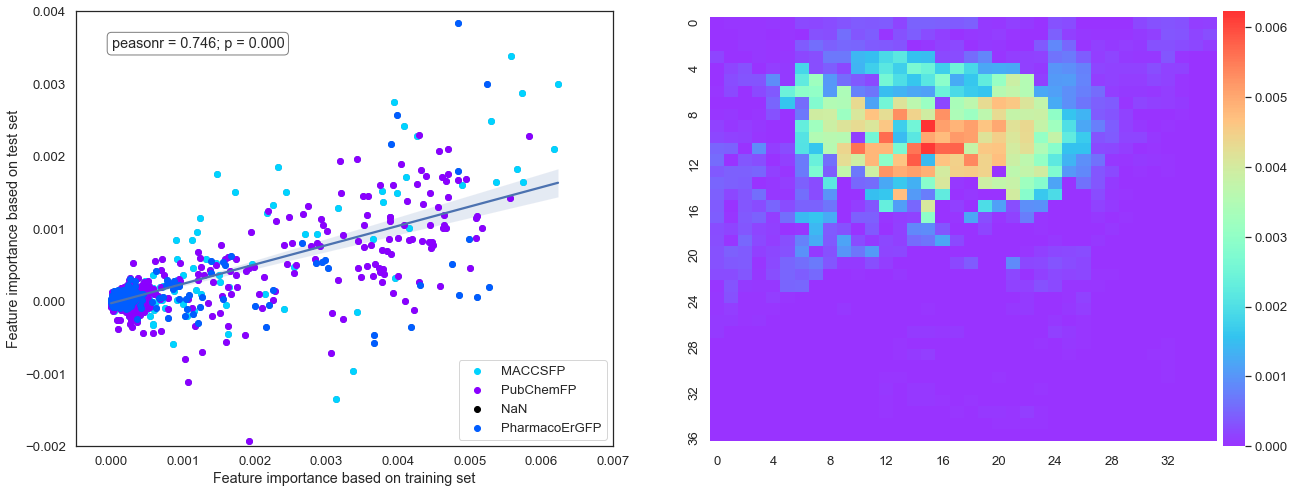

In [25]:
sns.set(style='white',  font='sans-serif', font_scale=1.2)

fig, (ax, ax2)  = plt.subplots(1, 2, figsize=(21, 8))
sns.regplot(dfp['Feature importance based on training set'], 
            dfp['Feature importance based on test set'], ax = ax)

for subtype, color in colormaps.items():
    dfi = dfp[dfp['Subtypes'] == subtype]
    x = dfi['Feature importance based on training set']
    y = dfi['Feature importance based on test set']
    ax.scatter(x, y, label = subtype, color = color)
for i,j in dfp.iterrows():
    x = j['Feature importance based on training set']
    y = j['Feature importance based on test set']
    if (x > 0.03) | (y > 0.052):
        ax.text(x-0.005,y,i, fontsize = 11, verticalalignment = 'center')
from scipy.stats import pearsonr
pcc, p = pearsonr(dfp['Feature importance based on training set'], dfp['Feature importance based on test set'])    
p = '%.3f' % p
pcc = '%.3f' % pcc
ax.text(0.00,0.0035,'peasonr = %s; p = %s' % (pcc, p), bbox = {'boxstyle': 'round', 'facecolor': 'white', 'edgecolor':'gray'})
ax.legend(loc = 'lower right')

ax.set_xlim(-0.0005, 0.007)
ax.set_ylim(-0.002, 0.004)

IMPM = pd.Series(abs_train).values.reshape(37,36)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, 
            yticklabels=4, 
#             vmin = -0.004,
            ax = ax2,  
            cbar_kws = {'fraction':0.046, 'pad':0.01})

bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)


plt.subplots_adjust(wspace = 0.18)
# plt.savefig('../result/feature_importance.svg', dpi = 400, bbox_inches="tight")
plt.show()